# R Notebook: CMIP5 Wet Spell Length Distributions, 2041-2070

Wet state, spell length for PRISM data.

Uses R to do some analysis

Add in the part to make a DataFrame with our best fit negative binomial parameters and then to output this to a spreadsheet

## Parameters and Library Loading

In [1]:
oldw <- getOption("warn")

In [2]:
options(warn = -1)

In [3]:
library(feather)
library(dplyr)
library(fitdistrplus)
library(vcd)
library(dgof)
library(xlsx)
library(r2excel)
library(moments)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: survival
Loading required package: npsurv
Loading required package: lsei
Loading required package: grid

Attaching package: 'dgof'

The following object is masked from 'package:stats':

    ks.test



**Note:** We only want to mask package:stats ks.test with that from package:dgof when working with discrete distributions.

In [4]:
setwd("\\\\augustine.space.swri.edu\\jdrive\\Groundwater\\R8937_Stochastic_CC_Recharge\\Data\\R\\Working\\CMIP5_2041_WetDays")

Now specify some parameters - just file names

In [5]:
feLODPath <- "WetDays_LOCA_2041-2070.feather"

In [6]:
feBCDPath <- "WetDays_BCCA_2041-2070.feather"

## Initial Load and Process of DataFrame

In [7]:
dfLOWet <- read_feather(feLODPath)
ddates <- as.Date( ISOdate( dfLOWet$Year, dfLOWet$Month, dfLOWet$Day ) )
dfLOWet["Date"] <- ddates

In [8]:
str(dfLOWet)

Classes 'tbl_df', 'tbl' and 'data.frame':	12982452 obs. of  56 variables:
 $ MGrid_Id   : chr  "M10_1" "M10_1" "M10_1" "M10_1" ...
 $ Grid_Id    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Mod_Id     : int  10 10 10 10 10 10 10 10 10 10 ...
 $ Year       : num  2041 2041 2041 2041 2041 ...
 $ Month      : num  1 1 1 1 2 2 2 3 4 4 ...
 $ Day        : num  5 10 19 27 4 12 24 31 9 17 ...
 $ Wet_Count  : num  3 5 1 3 1 8 1 1 2 2 ...
 $ Total_Depth: num  8.59 27.66 2.93 12.3 1.66 ...
 $ Day_1      : num  2.404 0.772 2.93 1.277 1.664 ...
 $ Day_2      : num  0.411 0.64 0 10.359 0 ...
 $ Day_3      : num  5.78 4.67 0 0.66 0 ...
 $ Day_4      : num  0 12.2 0 0 0 ...
 $ Day_5      : num  0 9.41 0 0 0 ...
 $ Day_6      : num  0 0 0 0 0 ...
 $ Day_7      : num  0 0 0 0 0 ...
 $ Day_8      : num  0 0 0 0 0 ...
 $ Day_9      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_10     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_11     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_12     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_13     : num 

In [9]:
head(dfLOWet)

MGrid_Id,Grid_Id,Mod_Id,Year,Month,Day,Wet_Count,Total_Depth,Day_1,Day_2,...,Day_39,Day_40,Day_41,Day_42,Day_43,Day_44,Day_45,Day_46,Day_47,Date
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
M10_1,1,10,2041,1,5,3,8.592035,2.4037583,0.4110381,...,0,0,0,0,0,0,0,0,0,2041-01-05
M10_1,1,10,2041,1,10,5,27.664704,0.7717416,0.6400209,...,0,0,0,0,0,0,0,0,0,2041-01-10
M10_1,1,10,2041,1,19,1,2.929670,2.9296703,0.0000000,...,0,0,0,0,0,0,0,0,0,2041-01-19
M10_1,1,10,2041,1,27,3,12.296292,1.2771530,10.3594770,...,0,0,0,0,0,0,0,0,0,2041-01-27
M10_1,1,10,2041,2,4,1,1.663593,1.6635932,0.0000000,...,0,0,0,0,0,0,0,0,0,2041-02-04
M10_1,1,10,2041,2,12,8,28.847171,0.2137693,8.4605350,...,0,0,0,0,0,0,0,0,0,2041-02-12


In [10]:
dfBCWet <- read_feather(feBCDPath)
ddates <- as.Date( ISOdate( dfBCWet$Year, dfBCWet$Month, dfBCWet$Day ) )
dfBCWet["Date"] <- ddates

In [11]:
str(dfBCWet)

Classes 'tbl_df', 'tbl' and 'data.frame':	9139490 obs. of  79 variables:
 $ MGrid_Id   : chr  "M100_169" "M100_169" "M100_169" "M100_169" ...
 $ Grid_Id    : int  169 169 169 169 169 169 169 169 169 169 ...
 $ Mod_Id     : int  100 100 100 100 100 100 100 100 100 100 ...
 $ Year       : num  2041 2041 2041 2041 2041 ...
 $ Month      : num  1 1 1 1 2 2 2 2 2 3 ...
 $ Day        : num  6 16 22 29 2 12 16 18 20 6 ...
 $ Wet_Count  : num  1 2 2 2 1 2 1 1 2 2 ...
 $ Total_Depth: num  1.199 0.854 6.386 0.721 0.267 ...
 $ Day_1      : num  1.199 0.491 2.231 0.447 0.267 ...
 $ Day_2      : num  0 0.363 4.155 0.273 0 ...
 $ Day_3      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_4      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_5      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_6      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_7      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_8      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_9      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_10     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_11     : num

In [12]:
head(dfBCWet)

MGrid_Id,Grid_Id,Mod_Id,Year,Month,Day,Wet_Count,Total_Depth,Day_1,Day_2,...,Day_62,Day_63,Day_64,Day_65,Day_66,Day_67,Day_68,Day_69,Day_70,Date
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
M100_169,169,100,2041,1,6,1,1.1991322,1.1991322,0.0000000,...,0,0,0,0,0,0,0,0,0,2041-01-06
M100_169,169,100,2041,1,16,2,0.8537013,0.4905194,0.3631819,...,0,0,0,0,0,0,0,0,0,2041-01-16
M100_169,169,100,2041,1,22,2,6.3860874,2.2312269,4.1548605,...,0,0,0,0,0,0,0,0,0,2041-01-22
M100_169,169,100,2041,1,29,2,0.7206046,0.4471543,0.2734503,...,0,0,0,0,0,0,0,0,0,2041-01-29
M100_169,169,100,2041,2,2,1,0.2667683,0.2667683,0.0000000,...,0,0,0,0,0,0,0,0,0,2041-02-02
M100_169,169,100,2041,2,12,2,0.5660075,0.2233747,0.3426328,...,0,0,0,0,0,0,0,0,0,2041-02-12


First filter for each month with all Grid_Id

In [13]:
dLOJan <- dfLOWet %>% filter( Month == 1 )
dLOFeb <- dfLOWet %>% filter( Month == 2 )
dLOMar <- dfLOWet %>% filter( Month == 3 )
dLOApr <- dfLOWet %>% filter( Month == 4 )
dLOMay <- dfLOWet %>% filter( Month == 5 )
dLOJun <- dfLOWet %>% filter( Month == 6 )
dLOJul <- dfLOWet %>% filter( Month == 7 )
dLOAug <- dfLOWet %>% filter( Month == 8 )
dLOSep <- dfLOWet %>% filter( Month == 9 )
dLOOct <- dfLOWet %>% filter( Month == 10 )
dLONov <- dfLOWet %>% filter( Month == 11 )
dLODec <- dfLOWet %>% filter( Month == 12 )

In [14]:
dBCJan <- dfBCWet %>% filter( Month == 1 )
dBCFeb <- dfBCWet %>% filter( Month == 2 )
dBCMar <- dfBCWet %>% filter( Month == 3 )
dBCApr <- dfBCWet %>% filter( Month == 4 )
dBCMay <- dfBCWet %>% filter( Month == 5 )
dBCJun <- dfBCWet %>% filter( Month == 6 )
dBCJul <- dfBCWet %>% filter( Month == 7 )
dBCAug <- dfBCWet %>% filter( Month == 8 )
dBCSep <- dfBCWet %>% filter( Month == 9 )
dBCOct <- dfBCWet %>% filter( Month == 10 )
dBCNov <- dfBCWet %>% filter( Month == 11 )
dBCDec <- dfBCWet %>% filter( Month == 12 )

Set-up a dataframe to store the basic summary statistics. Eventually will write this to Excel.

In [15]:
MonLOSumStatDF <- data.frame( month=rep(NA,12), mean=rep(NA,12), median=rep(NA,12), 
                            max=rep(NA,12), min=rep(NA,12), stdev=rep(NA,12), var=rep(NA,12),
                            skew=rep(NA,12), kurt=rep(NA,12), perc0=rep(NA,12), perc10=rep(NA,12), 
                            perc20=rep(NA,12), perc30=rep(NA,12), perc40=rep(NA,12), 
                            perc50=rep(NA,12), perc60=rep(NA,12), perc70=rep(NA,12), 
                            perc80=rep(NA,12), perc90=rep(NA,12), perc100=rep(NA,12), 
                            stringsAsFactors=FALSE )

In [16]:
pvec <- seq(0,1,0.1)

In [17]:
NumDeciles = length( pvec )
cat("Number of deciles: ", NumDeciles)

Number of deciles:  11

Now look at summary stats for the Wet day counts for each month

In [18]:
summary( dLOJan$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.784   2.000  14.000 

In [19]:
oQuants = quantile( dLOJan$Wet_Count, pvec )

In [20]:
MonLOSumStatDF[1, ] <-list( 1, mean(dLOJan$Wet_Count), median(dLOJan$Wet_Count), 
                          max(dLOJan$Wet_Count), min(dLOJan$Wet_Count), sd(dLOJan$Wet_Count),
                          var(dLOJan$Wet_Count), skewness(dLOJan$Wet_Count), 
                          kurtosis(dLOJan$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [21]:
summary( dLOFeb$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   1.935   2.000  18.000 

In [22]:
oQuants = quantile( dLOFeb$Wet_Count, pvec )

In [23]:
MonLOSumStatDF[2, ] <-list( 2, mean(dLOFeb$Wet_Count), median(dLOFeb$Wet_Count), 
                          max(dLOFeb$Wet_Count), min(dLOFeb$Wet_Count), sd(dLOFeb$Wet_Count),
                          var(dLOFeb$Wet_Count), skewness(dLOFeb$Wet_Count), 
                          kurtosis(dLOFeb$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [24]:
summary( dLOMar$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.885   2.000  16.000 

In [25]:
oQuants = quantile( dLOMar$Wet_Count, pvec )

In [26]:
MonLOSumStatDF[3, ] <-list( 3, mean(dLOMar$Wet_Count), median(dLOMar$Wet_Count), 
                          max(dLOMar$Wet_Count), min(dLOMar$Wet_Count), sd(dLOMar$Wet_Count),
                          var(dLOMar$Wet_Count), skewness(dLOMar$Wet_Count), 
                          kurtosis(dLOMar$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [27]:
summary( dLOApr$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.277   3.000  24.000 

In [28]:
oQuants = quantile( dLOApr$Wet_Count, pvec )

In [29]:
MonLOSumStatDF[4, ] <-list( 4, mean(dLOApr$Wet_Count), median(dLOApr$Wet_Count), 
                          max(dLOApr$Wet_Count), min(dLOApr$Wet_Count), sd(dLOApr$Wet_Count),
                          var(dLOApr$Wet_Count), skewness(dLOApr$Wet_Count), 
                          kurtosis(dLOApr$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [30]:
summary( dLOMay$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.663   3.000  38.000 

In [31]:
oQuants = quantile( dLOMay$Wet_Count, pvec )

In [32]:
MonLOSumStatDF[5, ] <-list( 5, mean(dLOMay$Wet_Count), median(dLOMay$Wet_Count), 
                          max(dLOMay$Wet_Count), min(dLOMay$Wet_Count), sd(dLOMay$Wet_Count),
                          var(dLOMay$Wet_Count), skewness(dLOMay$Wet_Count), 
                          kurtosis(dLOMay$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [33]:
summary( dLOJun$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.956   4.000  37.000 

In [34]:
oQuants = quantile( dLOJun$Wet_Count, pvec )

In [35]:
MonLOSumStatDF[6, ] <-list( 6, mean(dLOJun$Wet_Count), median(dLOJun$Wet_Count), 
                          max(dLOJun$Wet_Count), min(dLOJun$Wet_Count), sd(dLOJun$Wet_Count),
                          var(dLOJun$Wet_Count), skewness(dLOJun$Wet_Count), 
                          kurtosis(dLOJun$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [36]:
summary( dLOJul$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.625   3.000  31.000 

In [37]:
oQuants = quantile( dLOJul$Wet_Count, pvec )

In [38]:
MonLOSumStatDF[7, ] <-list( 7, mean(dLOJul$Wet_Count), median(dLOJul$Wet_Count), 
                          max(dLOJul$Wet_Count), min(dLOJul$Wet_Count), sd(dLOJul$Wet_Count),
                          var(dLOJul$Wet_Count), skewness(dLOJul$Wet_Count), 
                          kurtosis(dLOJul$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [39]:
summary( dLOAug$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    2.00    2.59    3.00   47.00 

In [40]:
oQuants = quantile( dLOAug$Wet_Count, pvec )

In [41]:
MonLOSumStatDF[8, ] <-list( 8, mean(dLOAug$Wet_Count), median(dLOAug$Wet_Count), 
                          max(dLOAug$Wet_Count), min(dLOAug$Wet_Count), sd(dLOAug$Wet_Count),
                          var(dLOAug$Wet_Count), skewness(dLOAug$Wet_Count), 
                          kurtosis(dLOAug$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [42]:
summary( dLOSep$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.917   4.000  33.000 

In [43]:
oQuants = quantile( dLOSep$Wet_Count, pvec )

In [44]:
MonLOSumStatDF[9, ] <-list( 9, mean(dLOSep$Wet_Count), median(dLOSep$Wet_Count), 
                          max(dLOSep$Wet_Count), min(dLOSep$Wet_Count), sd(dLOSep$Wet_Count),
                          var(dLOSep$Wet_Count), skewness(dLOSep$Wet_Count), 
                          kurtosis(dLOSep$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [45]:
summary( dLOOct$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.467   3.000  21.000 

In [46]:
oQuants = quantile( dLOOct$Wet_Count, pvec )

In [47]:
MonLOSumStatDF[10, ] <-list( 10, mean(dLOOct$Wet_Count), median(dLOOct$Wet_Count), 
                          max(dLOOct$Wet_Count), min(dLOOct$Wet_Count), sd(dLOOct$Wet_Count),
                          var(dLOOct$Wet_Count), skewness(dLOOct$Wet_Count), 
                          kurtosis(dLOOct$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [48]:
summary( dLONov$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.114   3.000  22.000 

In [49]:
oQuants = quantile( dLONov$Wet_Count, pvec )

In [50]:
MonLOSumStatDF[11, ] <-list( 11, mean(dLONov$Wet_Count), median(dLONov$Wet_Count), 
                          max(dLONov$Wet_Count), min(dLONov$Wet_Count), sd(dLONov$Wet_Count),
                          var(dLONov$Wet_Count), skewness(dLONov$Wet_Count), 
                          kurtosis(dLONov$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [51]:
summary( dLODec$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.848   2.000  16.000 

In [52]:
oQuants = quantile( dLODec$Wet_Count, pvec )

In [53]:
MonLOSumStatDF[12, ] <-list( 12, mean(dLODec$Wet_Count), median(dLODec$Wet_Count), 
                          max(dLODec$Wet_Count), min(dLODec$Wet_Count), sd(dLODec$Wet_Count),
                          var(dLODec$Wet_Count), skewness(dLODec$Wet_Count), 
                          kurtosis(dLODec$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [54]:
print( MonLOSumStatDF, quote=FALSE, row.names=FALSE )

 month     mean median max min    stdev      var     skew      kurt perc0
     1 1.784445      1  14   1 1.088929 1.185767 1.999068  9.057357     1
     2 1.935286      2  18   1 1.229739 1.512259 2.074817 10.051529     1
     3 1.885040      1  16   1 1.248957 1.559893 2.447471 13.432988     1
     4 2.277225      2  24   1 1.758354 3.091807 2.592518 14.156295     1
     5 2.662997      2  38   1 2.226644 4.957944 2.616697 15.345668     1
     6 2.956322      2  37   1 2.544168 6.472791 2.480784 13.061889     1
     7 2.625297      2  31   1 2.345017 5.499105 2.768120 14.929810     1
     8 2.590146      2  47   1 2.315328 5.360743 2.887044 18.177440     1
     9 2.917455      2  33   1 2.475690 6.129042 2.302991 11.251443     1
    10 2.467021      2  21   1 1.864276 3.475524 2.015877  8.794881     1
    11 2.113786      2  22   1 1.464263 2.144066 2.181503 10.871045     1
    12 1.848448      1  16   1 1.194403 1.426598 2.128871 10.039013     1
 perc10 perc20 perc30 perc40 perc50 pe

BCCA

In [55]:
MonBCSumStatDF <- data.frame( month=rep(NA,12), mean=rep(NA,12), median=rep(NA,12), 
                            max=rep(NA,12), min=rep(NA,12), stdev=rep(NA,12), var=rep(NA,12),
                            skew=rep(NA,12), kurt=rep(NA,12), perc0=rep(NA,12), perc10=rep(NA,12), 
                            perc20=rep(NA,12), perc30=rep(NA,12), perc40=rep(NA,12), 
                            perc50=rep(NA,12), perc60=rep(NA,12), perc70=rep(NA,12), 
                            perc80=rep(NA,12), perc90=rep(NA,12), perc100=rep(NA,12), 
                            stringsAsFactors=FALSE )

Now look at summary stats for the Wet day counts for each month

In [56]:
summary( dBCJan$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.918   2.000  16.000 

In [57]:
oQuants = quantile( dBCJan$Wet_Count, pvec )

In [58]:
MonBCSumStatDF[1, ] <-list( 1, mean(dBCJan$Wet_Count), median(dBCJan$Wet_Count), 
                          max(dBCJan$Wet_Count), min(dBCJan$Wet_Count), sd(dBCJan$Wet_Count),
                          var(dBCJan$Wet_Count), skewness(dBCJan$Wet_Count), 
                          kurtosis(dBCJan$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [59]:
summary( dBCFeb$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   1.986   2.000  21.000 

In [60]:
oQuants = quantile( dBCFeb$Wet_Count, pvec )

In [61]:
MonBCSumStatDF[2, ] <-list( 2, mean(dBCFeb$Wet_Count), median(dBCFeb$Wet_Count), 
                          max(dBCFeb$Wet_Count), min(dBCFeb$Wet_Count), sd(dBCFeb$Wet_Count),
                          var(dBCFeb$Wet_Count), skewness(dBCFeb$Wet_Count), 
                          kurtosis(dBCFeb$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [62]:
summary( dBCMar$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.956   2.000  25.000 

In [63]:
oQuants = quantile( dBCMar$Wet_Count, pvec )

In [64]:
MonBCSumStatDF[3, ] <-list( 3, mean(dBCMar$Wet_Count), median(dBCMar$Wet_Count), 
                          max(dBCMar$Wet_Count), min(dBCMar$Wet_Count), sd(dBCMar$Wet_Count),
                          var(dBCMar$Wet_Count), skewness(dBCMar$Wet_Count), 
                          kurtosis(dBCMar$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [65]:
summary( dBCApr$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.379   3.000  44.000 

In [66]:
oQuants = quantile( dBCApr$Wet_Count, pvec )

In [67]:
MonBCSumStatDF[4, ] <-list( 4, mean(dBCApr$Wet_Count), median(dBCApr$Wet_Count), 
                          max(dBCApr$Wet_Count), min(dBCApr$Wet_Count), sd(dBCApr$Wet_Count),
                          var(dBCApr$Wet_Count), skewness(dBCApr$Wet_Count), 
                          kurtosis(dBCApr$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [68]:
summary( dBCMay$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   3.032   4.000  70.000 

In [69]:
oQuants = quantile( dBCMay$Wet_Count, pvec )

In [70]:
MonBCSumStatDF[5, ] <-list( 5, mean(dBCMay$Wet_Count), median(dBCMay$Wet_Count), 
                          max(dBCMay$Wet_Count), min(dBCMay$Wet_Count), sd(dBCMay$Wet_Count),
                          var(dBCMay$Wet_Count), skewness(dBCMay$Wet_Count), 
                          kurtosis(dBCMay$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [71]:
summary( dBCJun$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.841   4.000  59.000 

In [72]:
oQuants = quantile( dBCJun$Wet_Count, pvec )

In [73]:
MonBCSumStatDF[6, ] <-list( 6, mean(dBCJun$Wet_Count), median(dBCJun$Wet_Count), 
                          max(dBCJun$Wet_Count), min(dBCJun$Wet_Count), sd(dBCJun$Wet_Count),
                          var(dBCJun$Wet_Count), skewness(dBCJun$Wet_Count), 
                          kurtosis(dBCJun$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [74]:
summary( dBCJul$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.685   3.000  47.000 

In [75]:
oQuants = quantile( dBCJul$Wet_Count, pvec )

In [76]:
MonBCSumStatDF[7, ] <-list( 7, mean(dBCJul$Wet_Count), median(dBCJul$Wet_Count), 
                          max(dBCJul$Wet_Count), min(dBCJul$Wet_Count), sd(dBCJul$Wet_Count),
                          var(dBCJul$Wet_Count), skewness(dBCJul$Wet_Count), 
                          kurtosis(dBCJul$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [77]:
summary( dBCAug$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.896   4.000  54.000 

In [78]:
oQuants = quantile( dBCAug$Wet_Count, pvec )

In [79]:
MonBCSumStatDF[8, ] <-list( 8, mean(dBCAug$Wet_Count), median(dBCAug$Wet_Count), 
                          max(dBCAug$Wet_Count), min(dBCAug$Wet_Count), sd(dBCAug$Wet_Count),
                          var(dBCAug$Wet_Count), skewness(dBCAug$Wet_Count), 
                          kurtosis(dBCAug$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [80]:
summary( dBCSep$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   3.089   4.000  38.000 

In [81]:
oQuants = quantile( dBCSep$Wet_Count, pvec )

In [82]:
MonBCSumStatDF[9, ] <-list( 9, mean(dBCSep$Wet_Count), median(dBCSep$Wet_Count), 
                          max(dBCSep$Wet_Count), min(dBCSep$Wet_Count), sd(dBCSep$Wet_Count),
                          var(dBCSep$Wet_Count), skewness(dBCSep$Wet_Count), 
                          kurtosis(dBCSep$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [83]:
summary( dBCOct$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    2.00    2.43    3.00   29.00 

In [84]:
oQuants = quantile( dBCOct$Wet_Count, pvec )

In [85]:
MonBCSumStatDF[10, ] <-list( 10, mean(dBCOct$Wet_Count), median(dBCOct$Wet_Count), 
                          max(dBCOct$Wet_Count), min(dBCOct$Wet_Count), sd(dBCOct$Wet_Count),
                          var(dBCOct$Wet_Count), skewness(dBCOct$Wet_Count), 
                          kurtosis(dBCOct$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [86]:
summary( dBCNov$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.021   3.000  18.000 

In [87]:
oQuants = quantile( dBCNov$Wet_Count, pvec )

In [88]:
MonBCSumStatDF[11, ] <-list( 11, mean(dBCNov$Wet_Count), median(dBCNov$Wet_Count), 
                          max(dBCNov$Wet_Count), min(dBCNov$Wet_Count), sd(dBCNov$Wet_Count),
                          var(dBCNov$Wet_Count), skewness(dBCNov$Wet_Count), 
                          kurtosis(dBCNov$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [89]:
summary( dBCDec$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.912   2.000  22.000 

In [90]:
oQuants = quantile( dBCDec$Wet_Count, pvec )

In [91]:
MonBCSumStatDF[12, ] <-list( 12, mean(dBCDec$Wet_Count), median(dBCDec$Wet_Count), 
                          max(dBCDec$Wet_Count), min(dBCDec$Wet_Count), sd(dBCDec$Wet_Count),
                          var(dBCDec$Wet_Count), skewness(dBCDec$Wet_Count), 
                          kurtosis(dBCDec$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [92]:
print( MonBCSumStatDF, quote=FALSE, row.names=FALSE )

 month     mean median max min    stdev      var     skew     kurt perc0 perc10
     1 1.918293      1  16   1 1.314034 1.726687 2.215485 10.43356     1      1
     2 1.985640      2  21   1 1.379876 1.904059 2.190710 10.46853     1      1
     3 1.956357      1  25   1 1.389036 1.929422 2.417787 13.25426     1      1
     4 2.378602      2  44   1 2.148309 4.615231 3.373831 24.98584     1      1
     5 3.031576      2  70   1 2.935930 8.619686 2.676689 14.41973     1      1
     6 2.841019      2  59   1 2.795249 7.813414 2.713349 14.33433     1      1
     7 2.684914      2  47   1 2.736830 7.490239 3.117513 18.25678     1      1
     8 2.895663      2  54   1 3.022603 9.136127 3.193515 19.16221     1      1
     9 3.088916      2  38   1 2.864016 8.202586 2.319448 10.67923     1      1
    10 2.430230      2  29   1 2.014321 4.057491 2.382277 11.95139     1      1
    11 2.020961      2  18   1 1.436603 2.063829 2.198014 10.26955     1      1
    12 1.912133      1  22   1 1.322405 

## Month Distribution Fits

Start out by making distributions using all of the grid cells

There are 4 steps in fitting distributions (Ricci, 2005):

1. Model/function choice: hypothesize families of distributions;
2. Estimate parameters;
3. Evaluate quality of fit;
4. Goodness of fit statistical tests.

We will use the negative binomial distribution, **nbinom**, for the wet and Wet day spell length distributions so #1 is taken care of and we can start with #2.

### Basic Plotting and Analysis

Basic plotting and analysis is to look at discrete histograms, empirial CDFs, and Q-Q plots with theoretical negative binomial distributions for each month. This is to ensure that everything looks exceptable.

Use another value tracking DataFrame here to keep track of sample distribution and theoretical, fitted distribution properties.

In [93]:
LOMonDistDF <- data.frame( month=rep(NA,12), smu=rep(NA,12), ssize=rep(NA,12),
                           sprob=rep(NA,12), tmu=rep(NA,12), tsize=rep(NA,12),
                           pvalue=rep(NA,12), stringsAsFactors=FALSE )

In [94]:
BCMonDistDF <- data.frame( month=rep(NA,12), smu=rep(NA,12), ssize=rep(NA,12),
                           sprob=rep(NA,12), tmu=rep(NA,12), tsize=rep(NA,12),
                           pvalue=rep(NA,12), stringsAsFactors=FALSE )

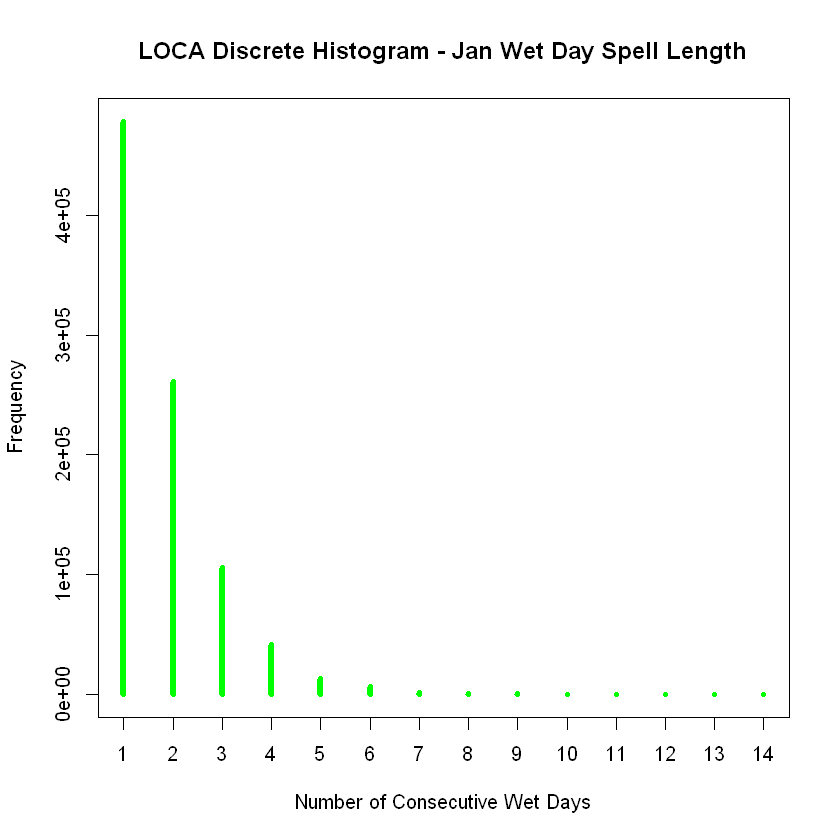

In [95]:
# our case is discrete so use this command
plot( table( dLOJan$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Jan Wet Day Spell Length", 
      col="green" )

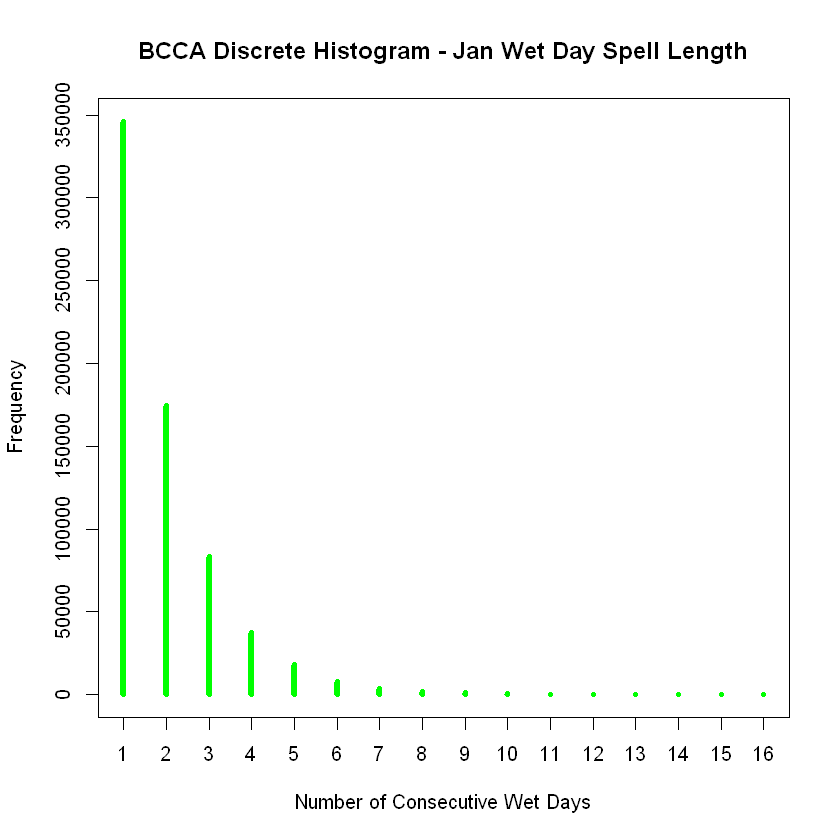

In [96]:
plot( table( dBCJan$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Jan Wet Day Spell Length", 
      col="green" )

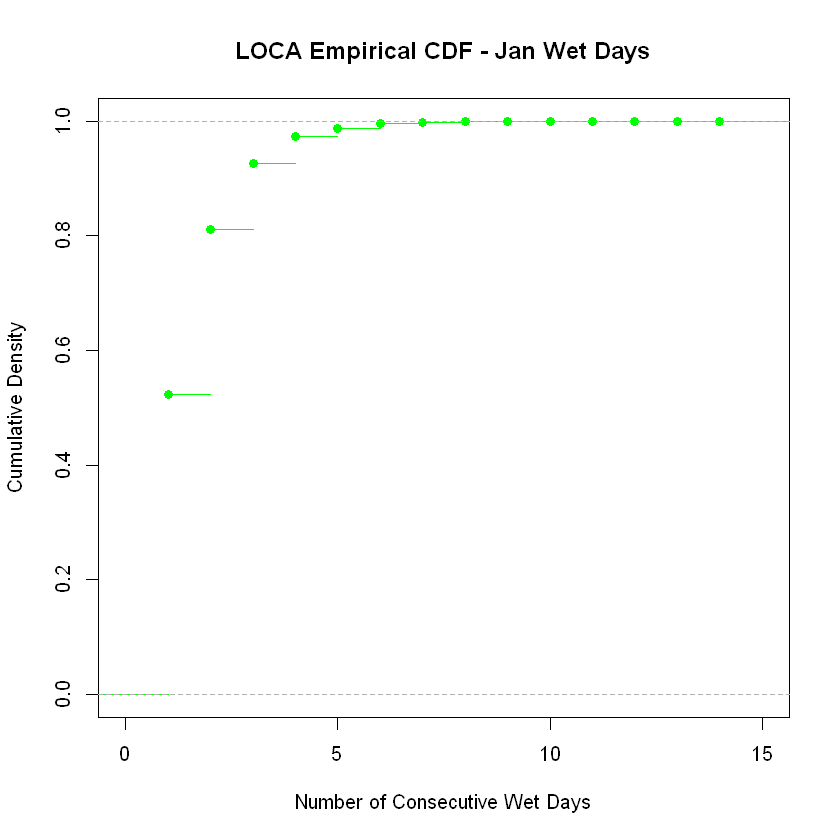

In [97]:
plot(ecdf(dLOJan$Wet_Count), main="LOCA Empirical CDF - Jan Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

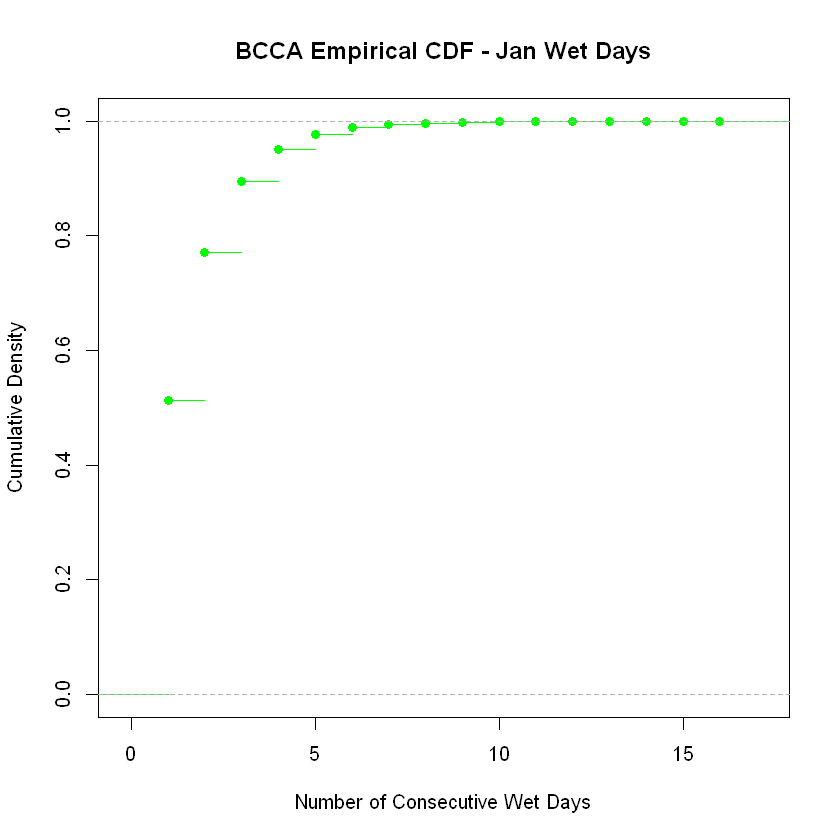

In [98]:
plot(ecdf(dBCJan$Wet_Count), main="BCCA Empirical CDF - Jan Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

In [99]:
dLOJanMax <- max( dLOJan$Wet_Count )
dLOJanMean <- mean( dLOJan$Wet_Count )
dLOJanVar <- var( dLOJan$Wet_Count )
dLOJanBNr <- dLOJanMean^2 / abs(dLOJanVar - dLOJanMean)
dLOJanTstNB <- rnbinom( 1000, mu=dLOJanMean, size=dLOJanBNr )

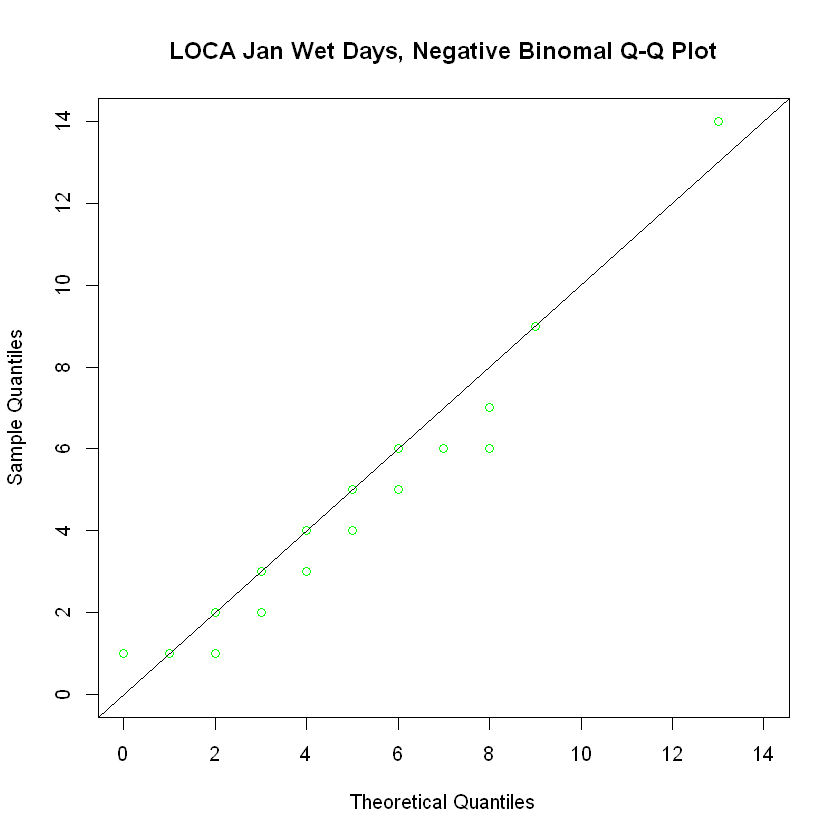

In [100]:
qqplot( dLOJanTstNB, dLOJan$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Jan Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOJanMax), ylim=c(0,dLOJanMax) )
abline( 0, 1)

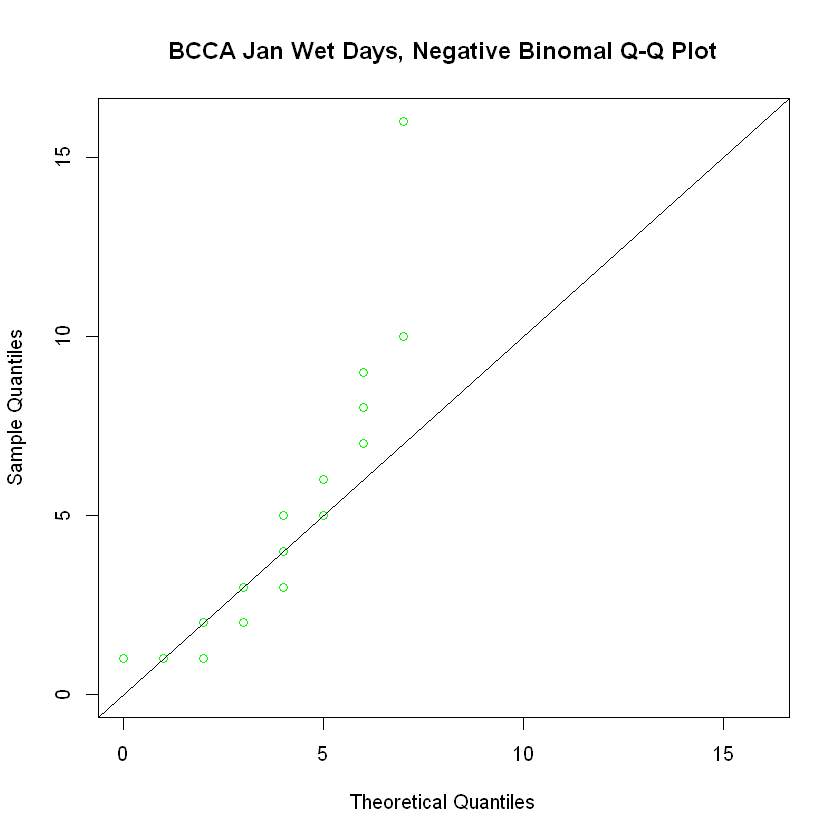

In [101]:
dBCJanMax <- max( dBCJan$Wet_Count )
dBCJanMean <- mean( dBCJan$Wet_Count )
dBCJanVar <- var( dBCJan$Wet_Count )
dBCJanBNr <- dBCJanMean^2 / abs(dBCJanVar - dBCJanMean)
dBCJanTstNB <- rnbinom( 1000, mu=dBCJanMean, size=dBCJanBNr )
qqplot( dBCJanTstNB, dBCJan$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Jan Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCJanMax), ylim=c(0,dBCJanMax) )
abline( 0, 1)

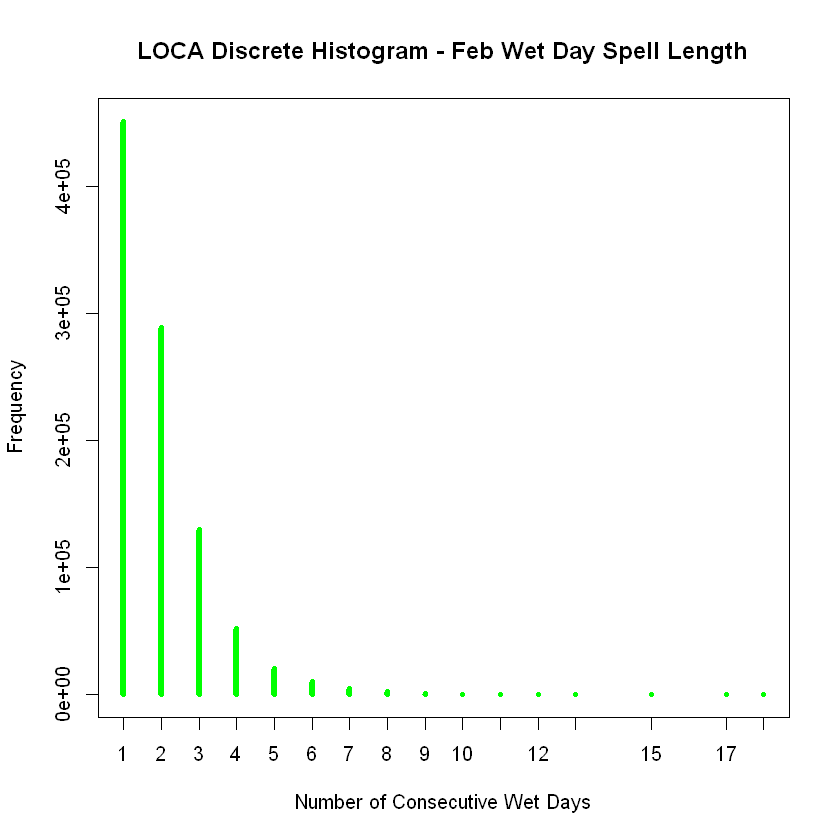

In [102]:
# our case is discrete so use this command
plot( table( dLOFeb$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Feb Wet Day Spell Length", 
      col="green" )

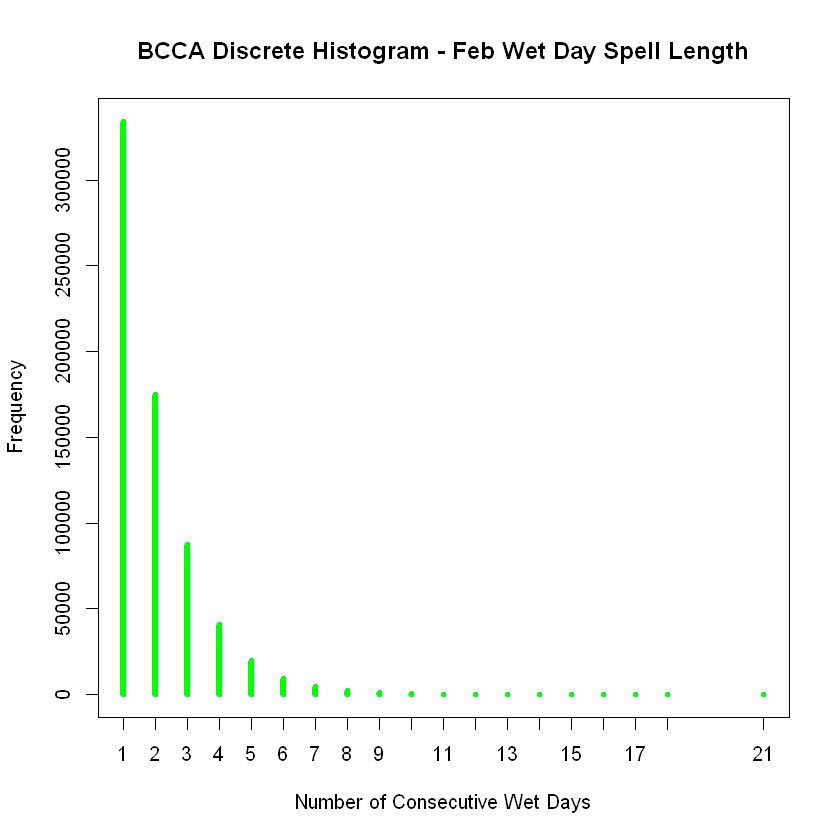

In [103]:
plot( table( dBCFeb$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Feb Wet Day Spell Length", 
      col="green" )

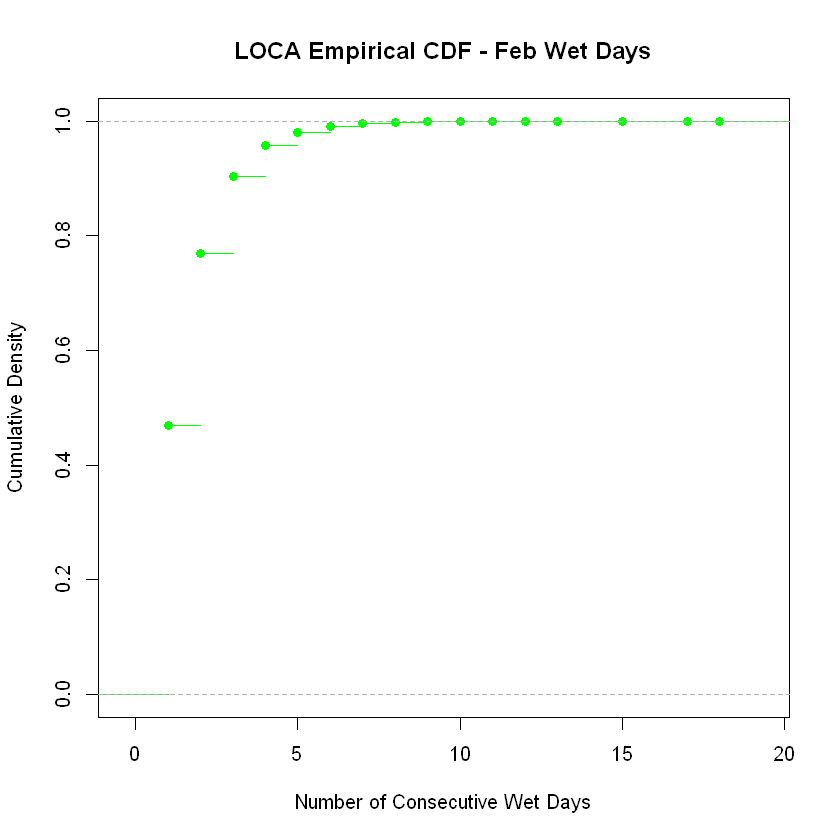

In [104]:
plot(ecdf(dLOFeb$Wet_Count), main="LOCA Empirical CDF - Feb Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

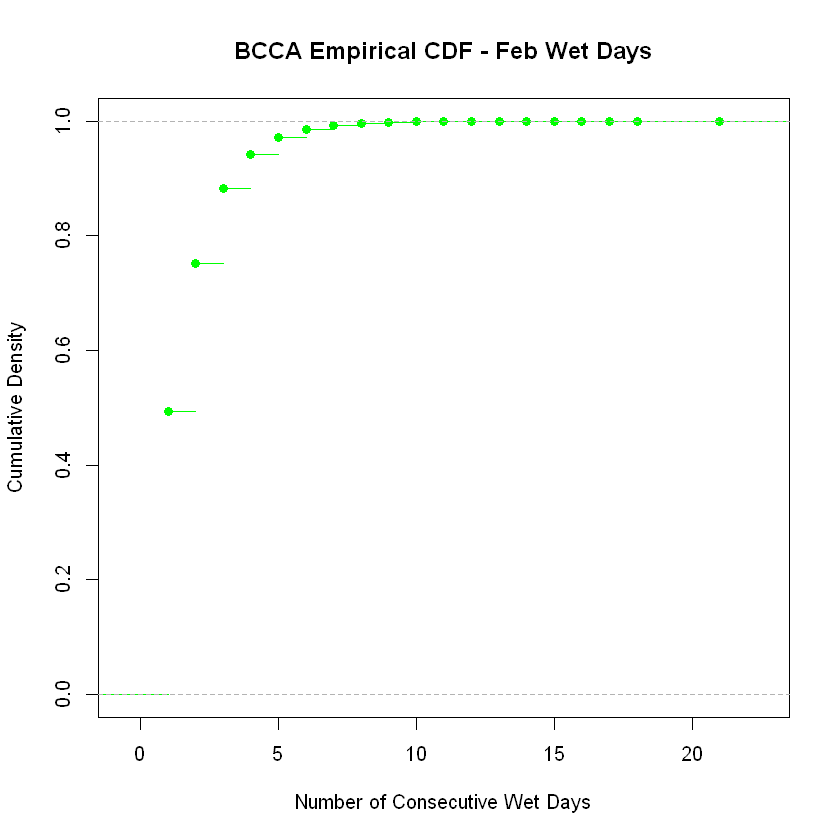

In [105]:
plot(ecdf(dBCFeb$Wet_Count), main="BCCA Empirical CDF - Feb Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

In [106]:
#dLOFeb$Wet_Count

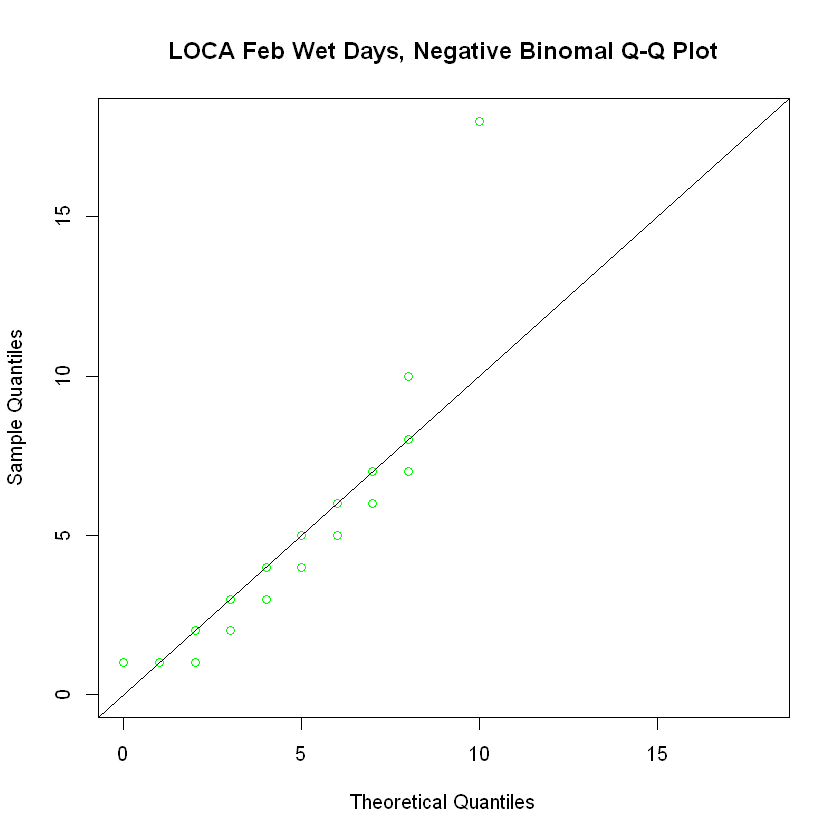

In [107]:
dLOFebMax <- max( dLOFeb$Wet_Count )
dLOFebMean <- mean( dLOFeb$Wet_Count )
dLOFebVar <- var( dLOFeb$Wet_Count )
dLOFebBNr <- dLOFebMean^2 / abs(dLOFebVar - dLOFebMean)
dLOFebTstNB <- rnbinom( 1000, mu=dLOFebMean, size=dLOFebBNr )
qqplot( dLOFebTstNB, dLOFeb$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Feb Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOFebMax), ylim=c(0,dLOFebMax) )
abline( 0, 1)

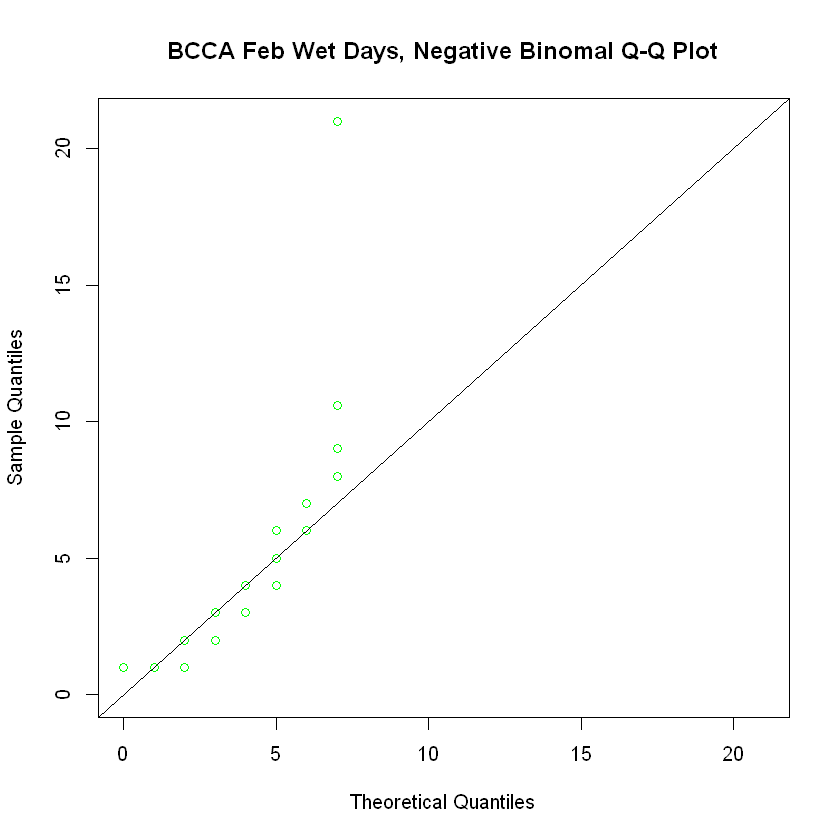

In [108]:
dBCFebMax <- max( dBCFeb$Wet_Count )
dBCFebMean <- mean( dBCFeb$Wet_Count )
dBCFebVar <- var( dBCFeb$Wet_Count )
dBCFebBNr <- dBCFebMean^2 / abs(dBCFebVar - dBCFebMean)
dBCFebTstNB <- rnbinom( 1000, mu=dBCFebMean, size=dBCFebBNr )
qqplot( dBCFebTstNB, dBCFeb$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Feb Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCFebMax), ylim=c(0,dBCFebMax) )
abline( 0, 1)

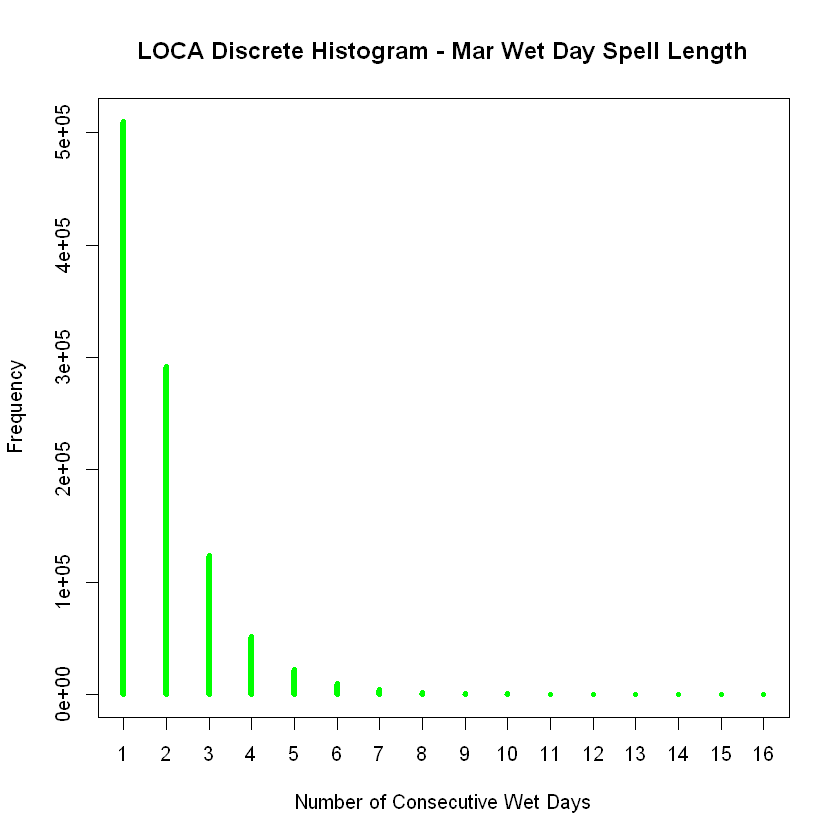

In [109]:
# our case is discrete so use this command
plot( table( dLOMar$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Mar Wet Day Spell Length", 
      col="green" )

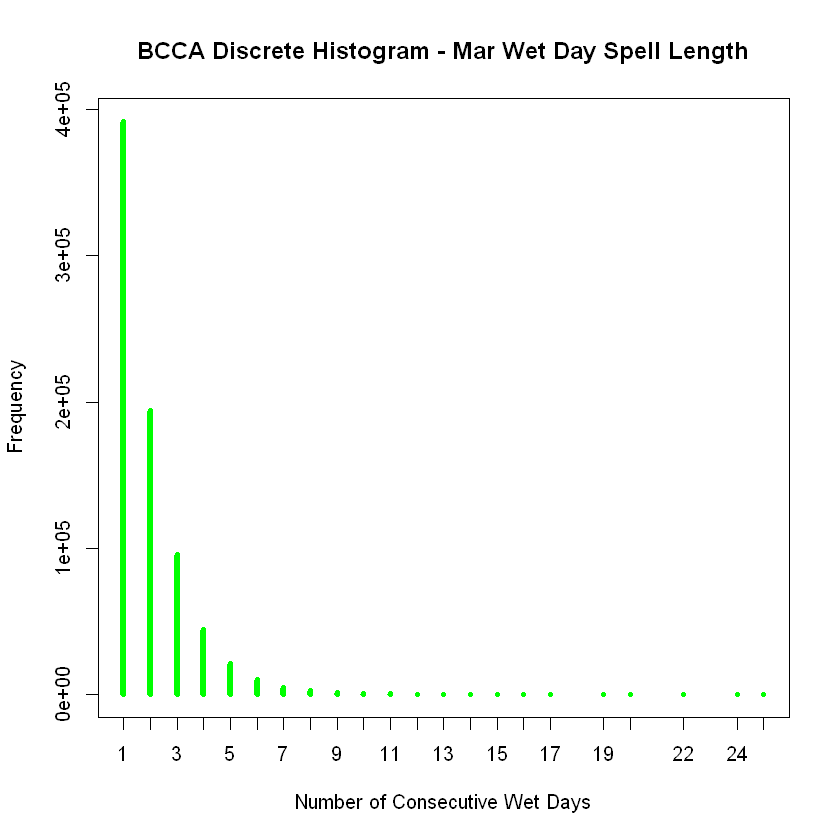

In [110]:
plot( table( dBCMar$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Mar Wet Day Spell Length", 
      col="green" )

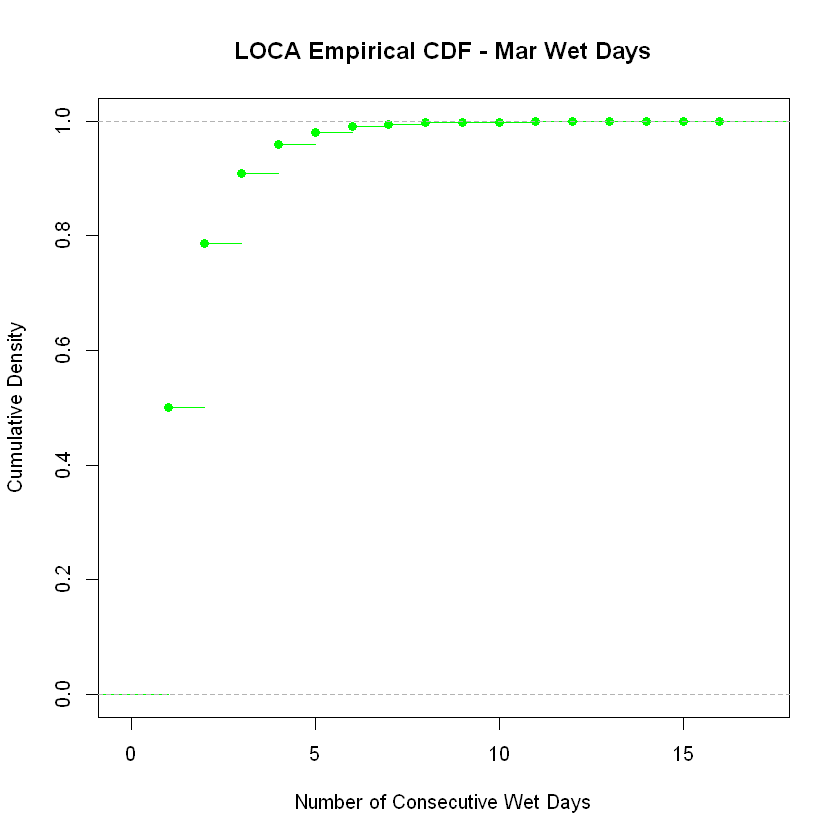

In [111]:
plot(ecdf(dLOMar$Wet_Count), main="LOCA Empirical CDF - Mar Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

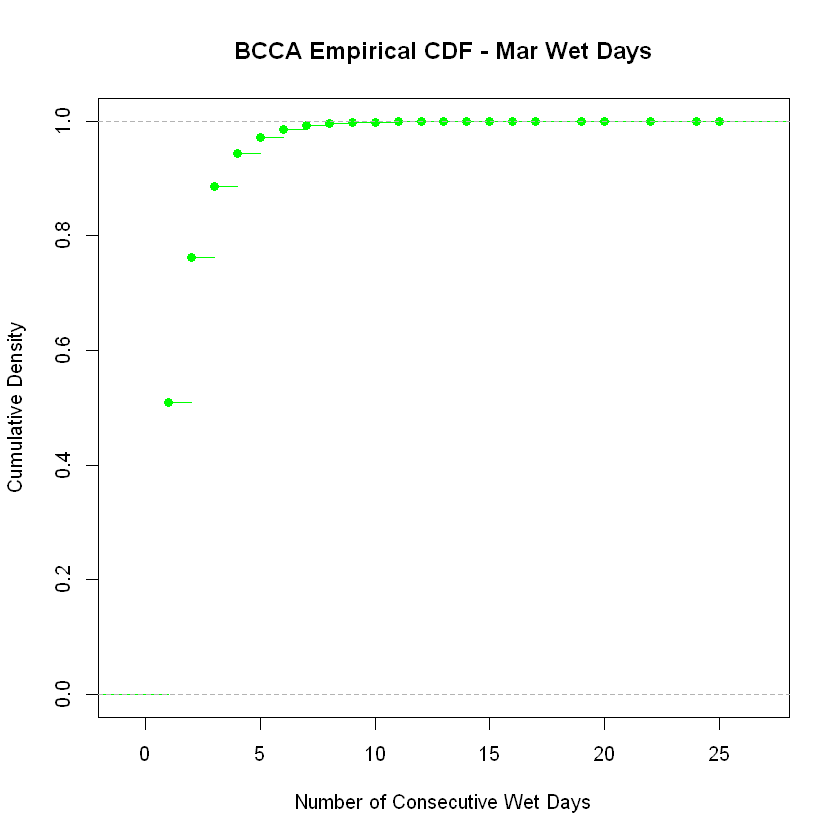

In [112]:
plot(ecdf(dBCMar$Wet_Count), main="BCCA Empirical CDF - Mar Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

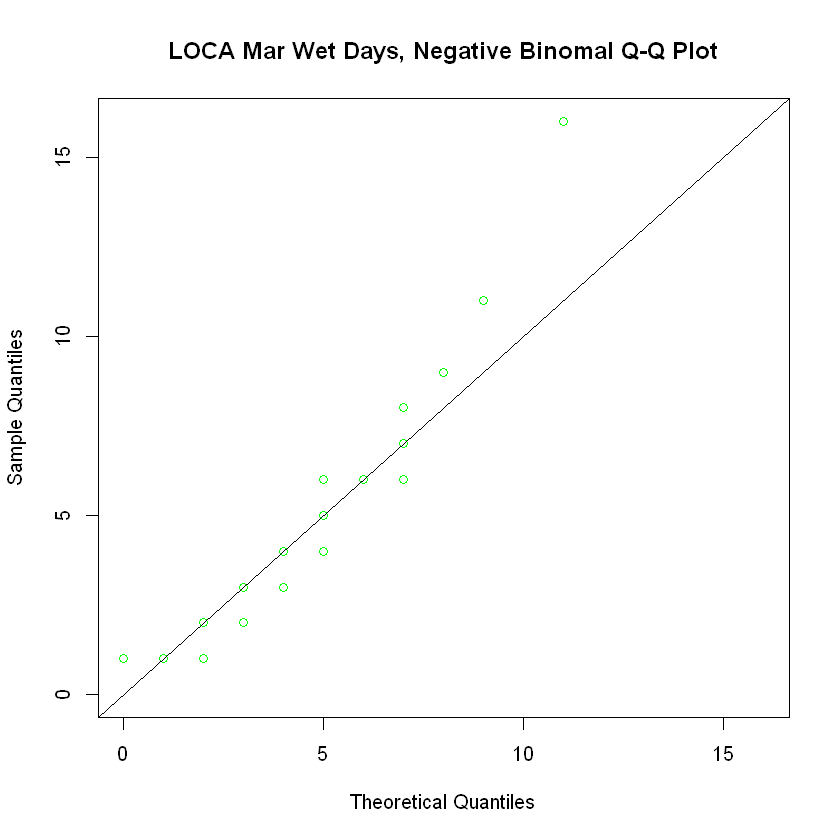

In [113]:
dLOMarMax <- max( dLOMar$Wet_Count )
dLOMarMean <- mean( dLOMar$Wet_Count )
dLOMarVar <- var( dLOMar$Wet_Count )
dLOMarBNr <- dLOMarMean^2 / abs(dLOMarVar - dLOMarMean)
dLOMarTstNB <- rnbinom( 1000, mu=dLOMarMean, size=dLOMarBNr )
qqplot( dLOMarTstNB, dLOMar$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Mar Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOMarMax), ylim=c(0,dLOMarMax) )
abline( 0, 1)

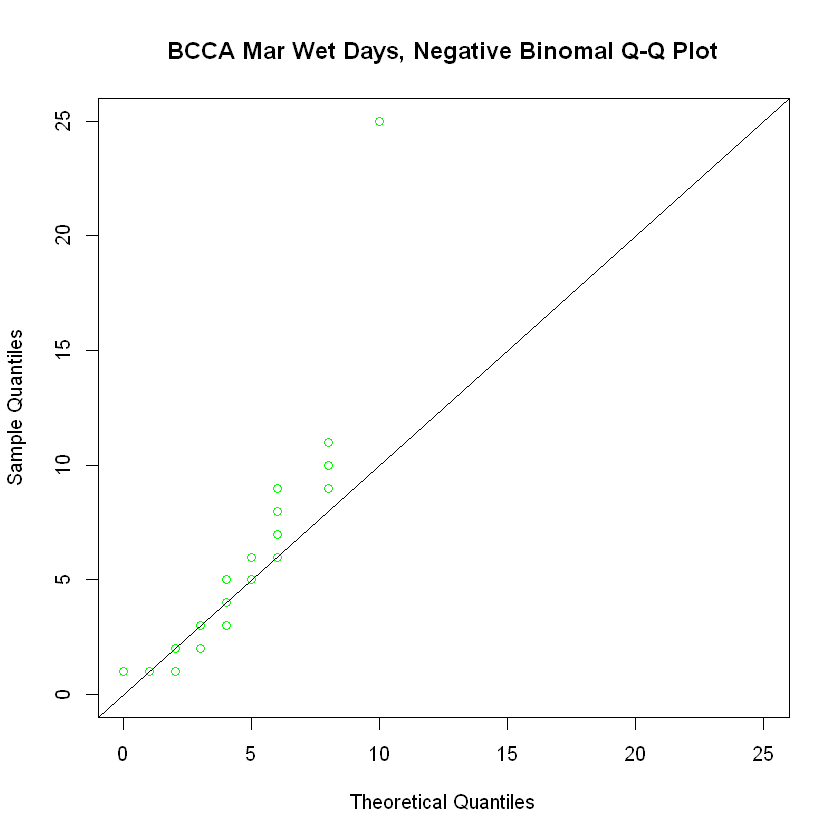

In [114]:
dBCMarMax <- max( dBCMar$Wet_Count )
dBCMarMean <- mean( dBCMar$Wet_Count )
dBCMarVar <- var( dBCMar$Wet_Count )
dBCMarBNr <- dBCMarMean^2 / abs(dBCMarVar - dBCMarMean)
dBCMarTstNB <- rnbinom( 1000, mu=dBCMarMean, size=dBCMarBNr )
qqplot( dBCMarTstNB, dBCMar$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Mar Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCMarMax), ylim=c(0,dBCMarMax) )
abline( 0, 1)

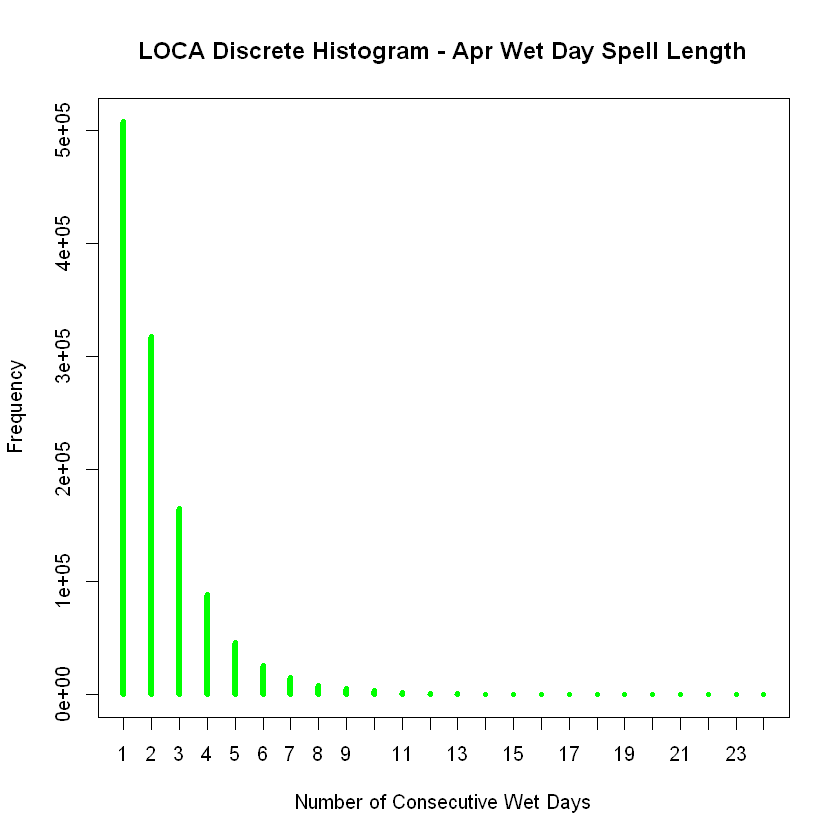

In [115]:
# our case is discrete so use this command
plot( table( dLOApr$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Apr Wet Day Spell Length", 
      col="green" )

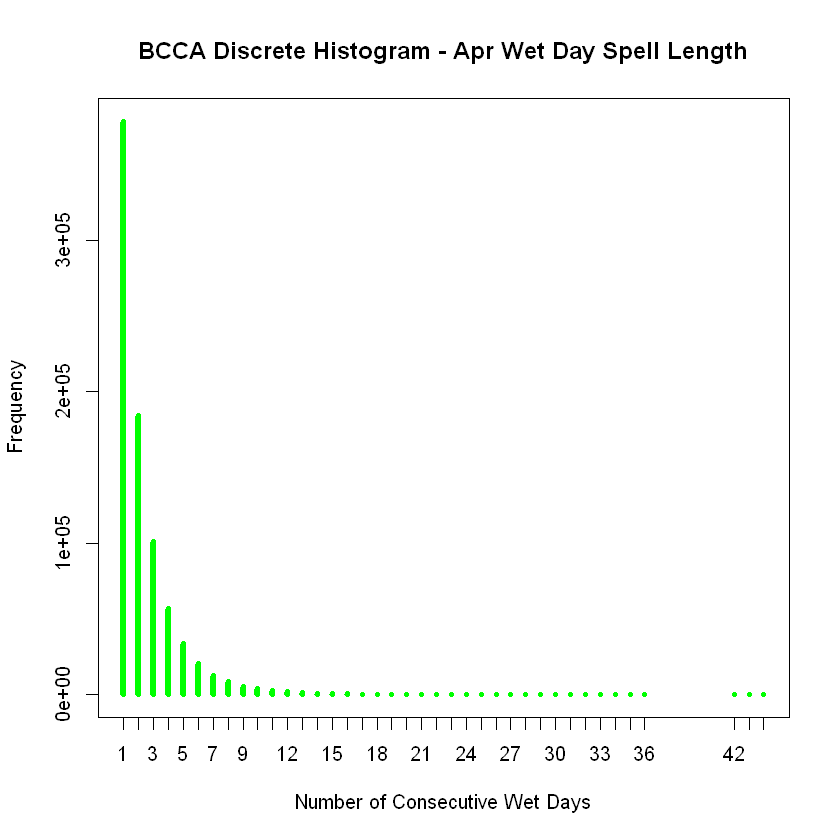

In [116]:
plot( table( dBCApr$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Apr Wet Day Spell Length", 
      col="green" )

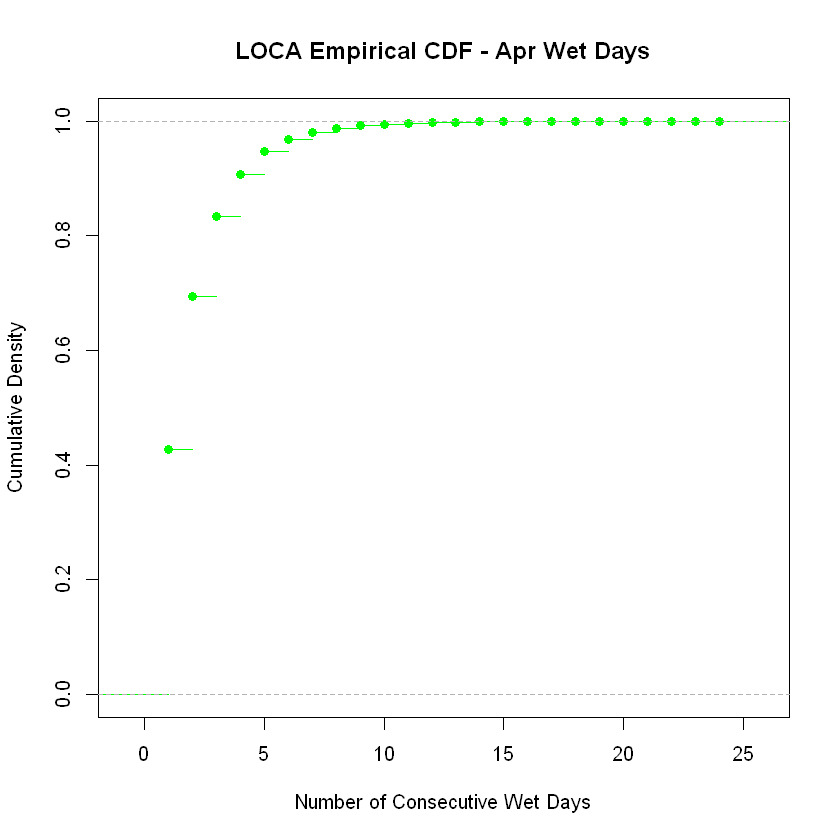

In [117]:
plot(ecdf(dLOApr$Wet_Count), main="LOCA Empirical CDF - Apr Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

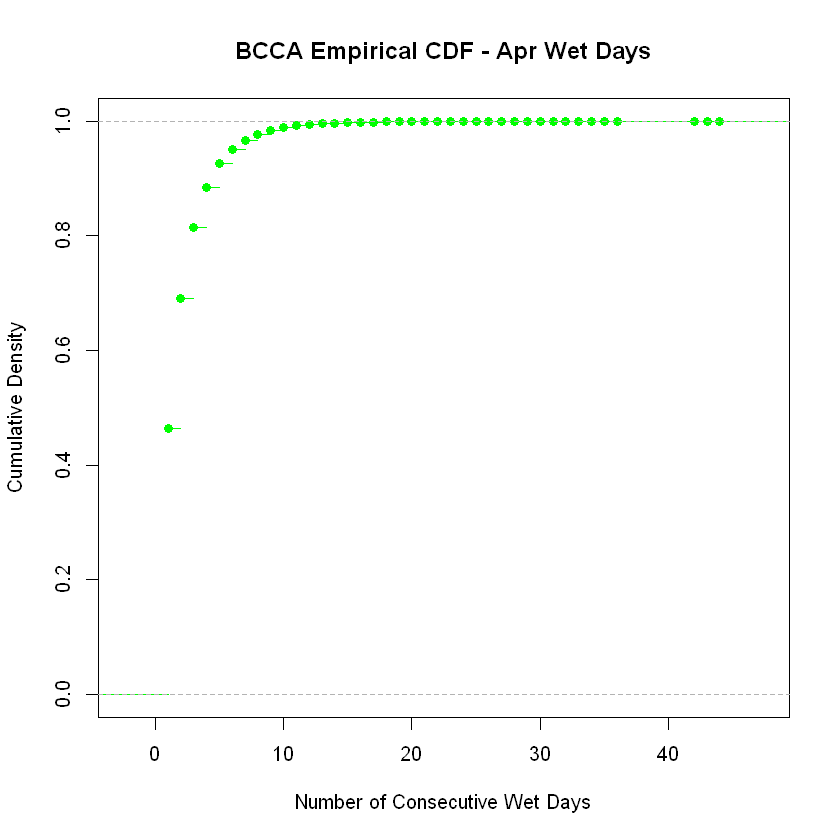

In [118]:
plot(ecdf(dBCApr$Wet_Count), main="BCCA Empirical CDF - Apr Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

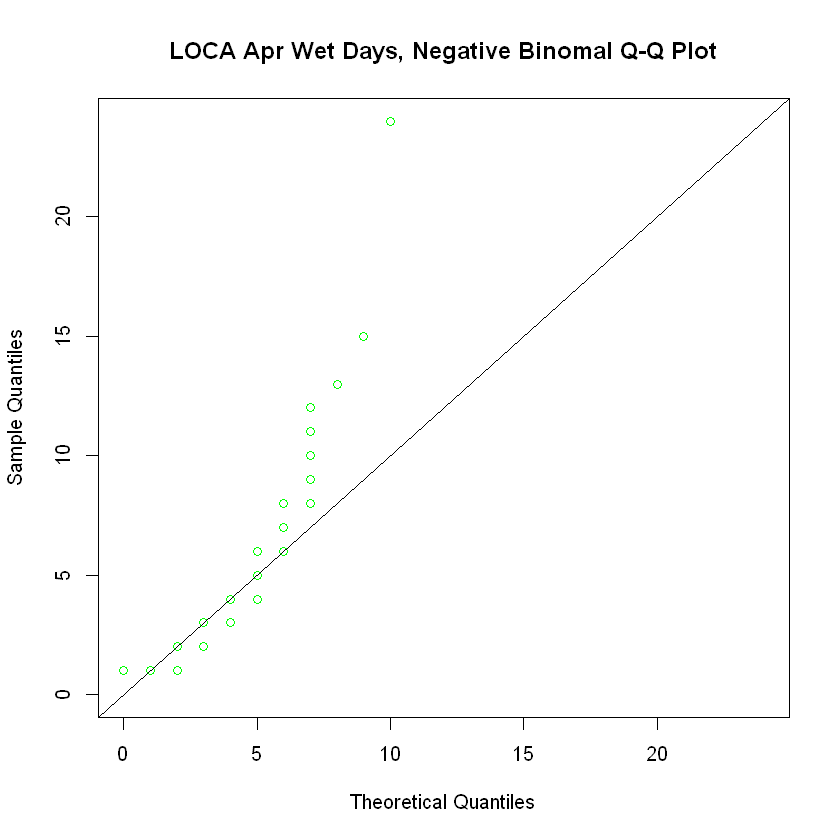

In [119]:
dLOAprMax <- max( dLOApr$Wet_Count )
dLOAprMean <- mean( dLOApr$Wet_Count )
dLOAprVar <- var( dLOApr$Wet_Count )
dLOAprBNr <- dLOAprMean^2 / abs(dLOAprVar - dLOAprMean)
dLOAprTstNB <- rnbinom( 1000, mu=dLOAprMean, size=dLOAprBNr )
qqplot( dLOAprTstNB, dLOApr$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Apr Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOAprMax), ylim=c(0,dLOAprMax) )
abline( 0, 1)

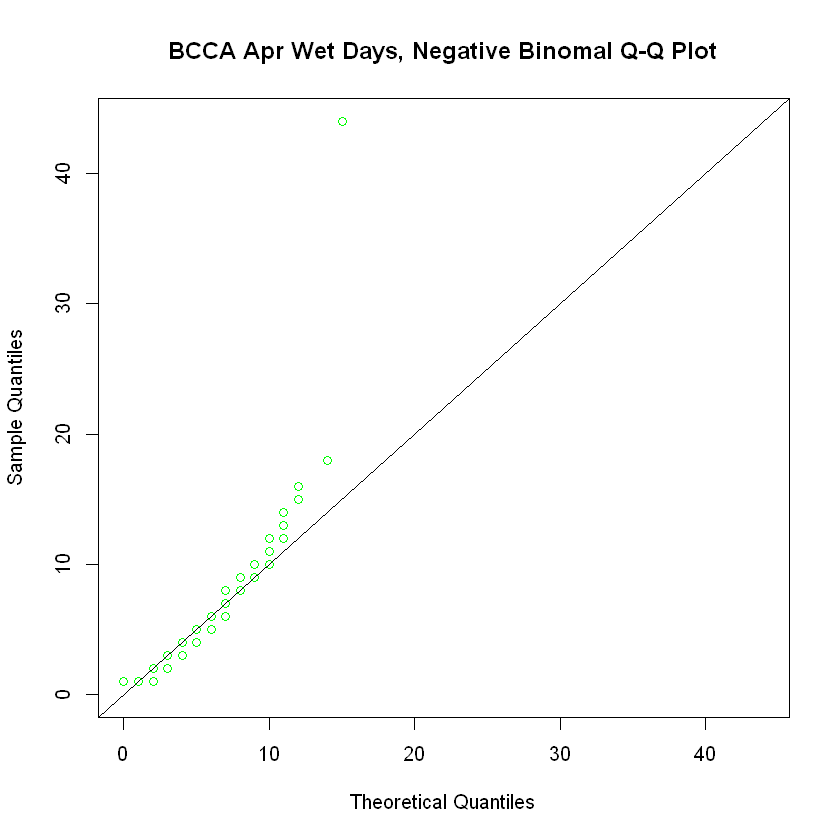

In [120]:
dBCAprMax <- max( dBCApr$Wet_Count )
dBCAprMean <- mean( dBCApr$Wet_Count )
dBCAprVar <- var( dBCApr$Wet_Count )
dBCAprBNr <- dBCAprMean^2 / abs(dBCAprVar - dBCAprMean)
dBCAprTstNB <- rnbinom( 1000, mu=dBCAprMean, size=dBCAprBNr )
qqplot( dBCAprTstNB, dBCApr$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Apr Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCAprMax), ylim=c(0,dBCAprMax) )
abline( 0, 1)

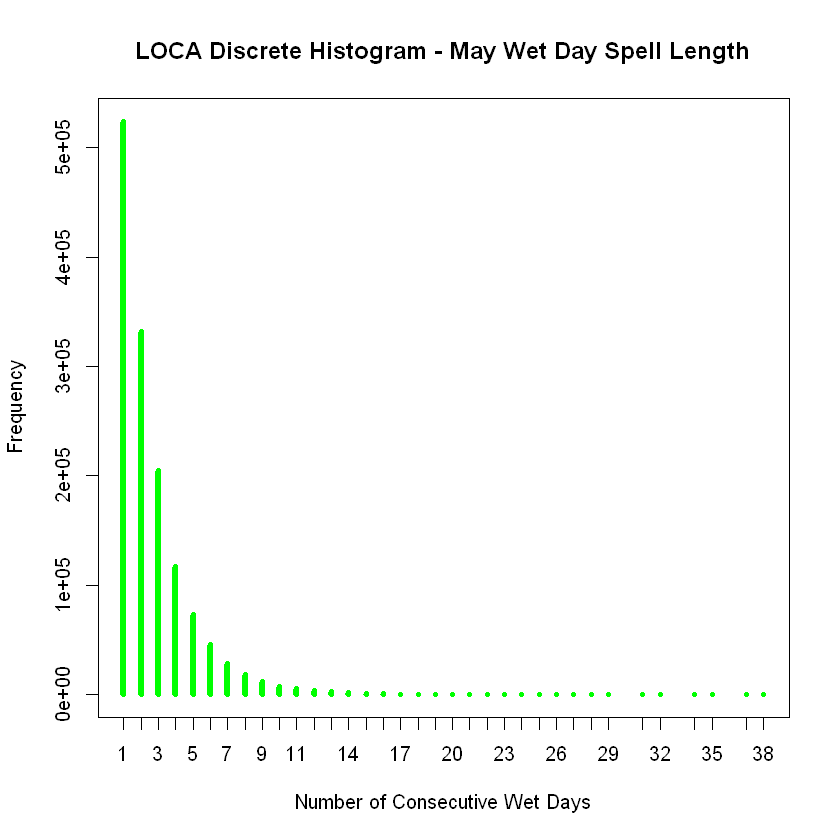

In [121]:
# our case is discrete so use this command
plot( table( dLOMay$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - May Wet Day Spell Length", 
      col="green" )

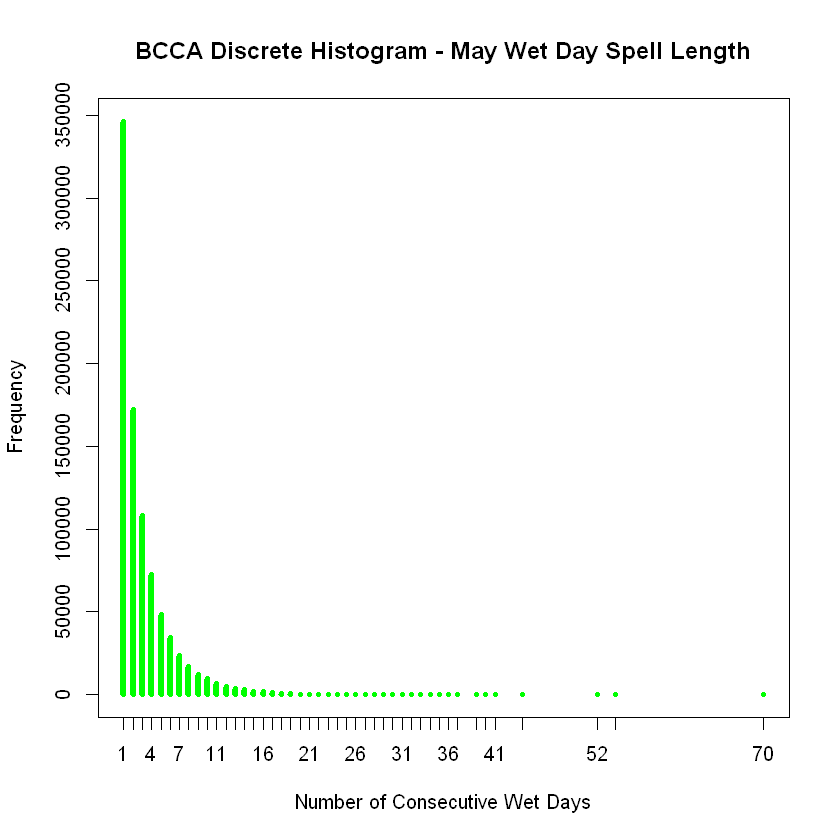

In [122]:
plot( table( dBCMay$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - May Wet Day Spell Length", 
      col="green" )

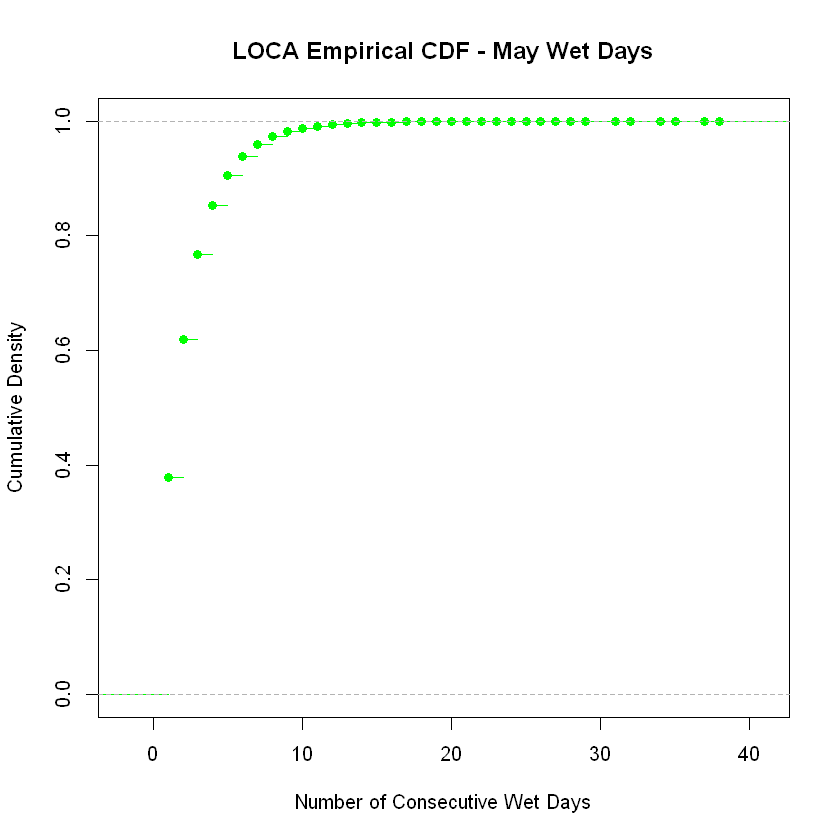

In [123]:
plot(ecdf(dLOMay$Wet_Count), main="LOCA Empirical CDF - May Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

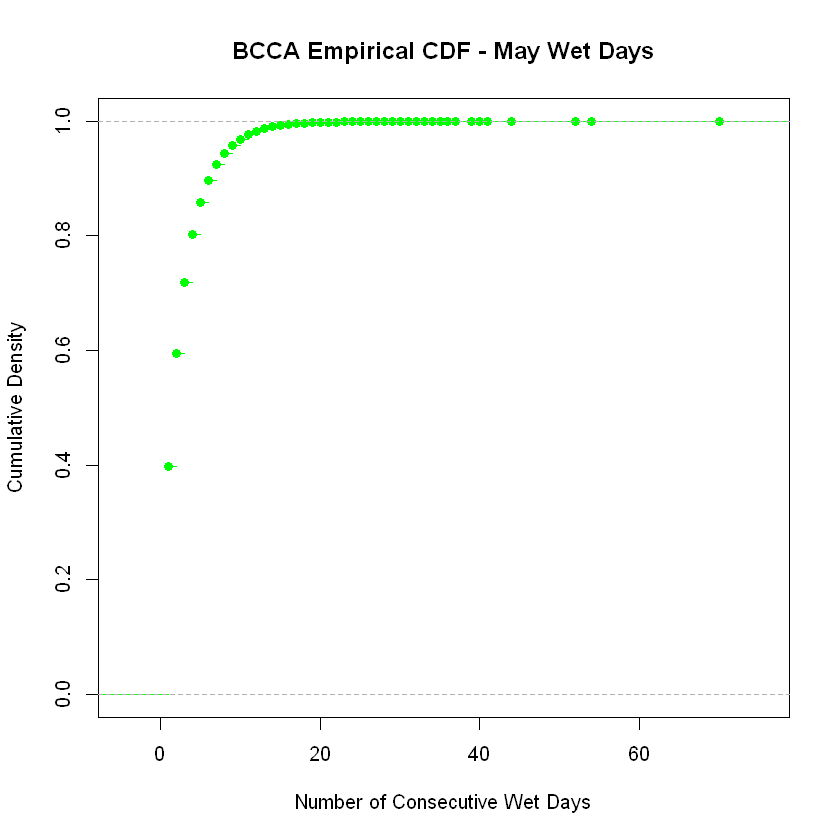

In [124]:
plot(ecdf(dBCMay$Wet_Count), main="BCCA Empirical CDF - May Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

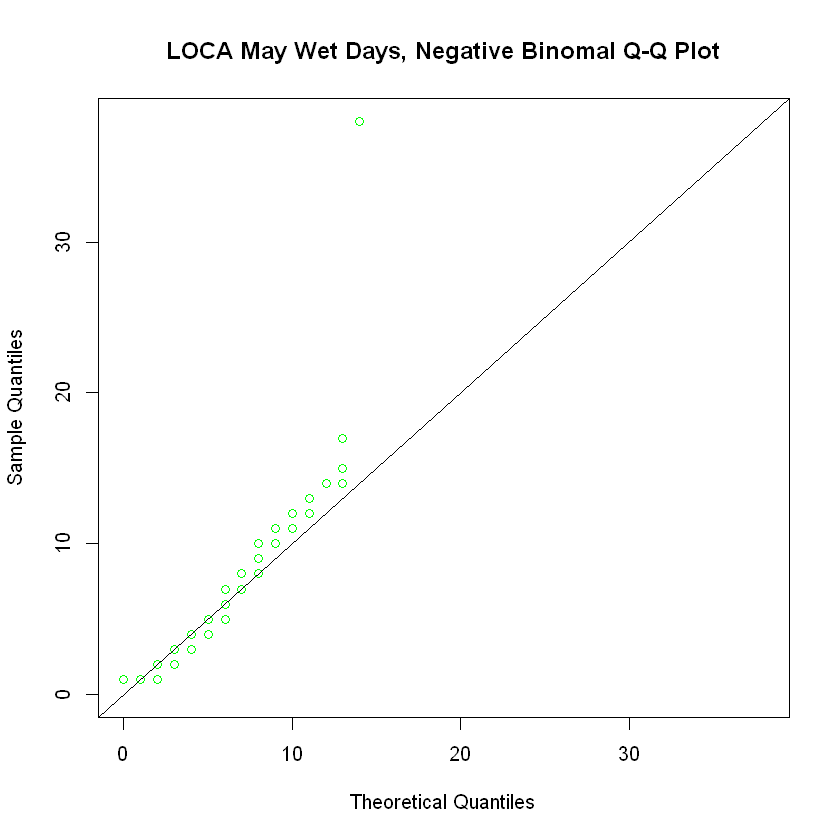

In [125]:
dLOMayMax <- max( dLOMay$Wet_Count )
dLOMayMean <- mean( dLOMay$Wet_Count )
dLOMayVar <- var( dLOMay$Wet_Count )
dLOMayBNr <- dLOMayMean^2 / abs(dLOMayVar - dLOMayMean)
dLOMayTstNB <- rnbinom( 1000, mu=dLOMayMean, size=dLOMayBNr )
qqplot( dLOMayTstNB, dLOMay$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA May Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOMayMax), ylim=c(0,dLOMayMax) )
abline( 0, 1)

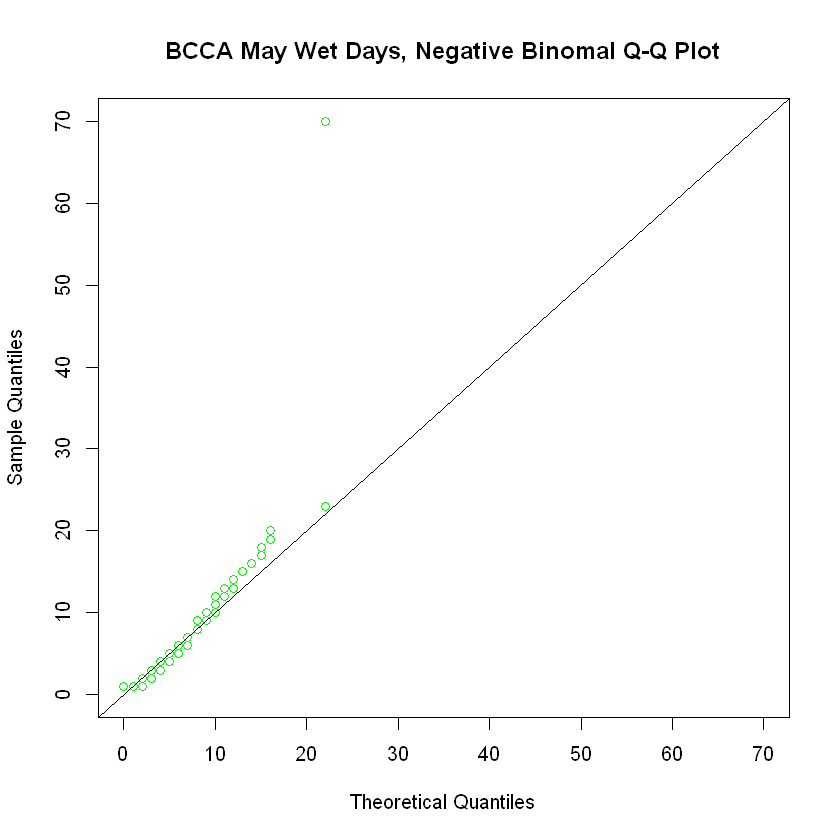

In [126]:
dBCMayMax <- max( dBCMay$Wet_Count )
dBCMayMean <- mean( dBCMay$Wet_Count )
dBCMayVar <- var( dBCMay$Wet_Count )
dBCMayBNr <- dBCMayMean^2 / abs(dBCMayVar - dBCMayMean)
dBCMayTstNB <- rnbinom( 1000, mu=dBCMayMean, size=dBCMayBNr )
qqplot( dBCMayTstNB, dBCMay$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA May Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCMayMax), ylim=c(0,dBCMayMax) )
abline( 0, 1)

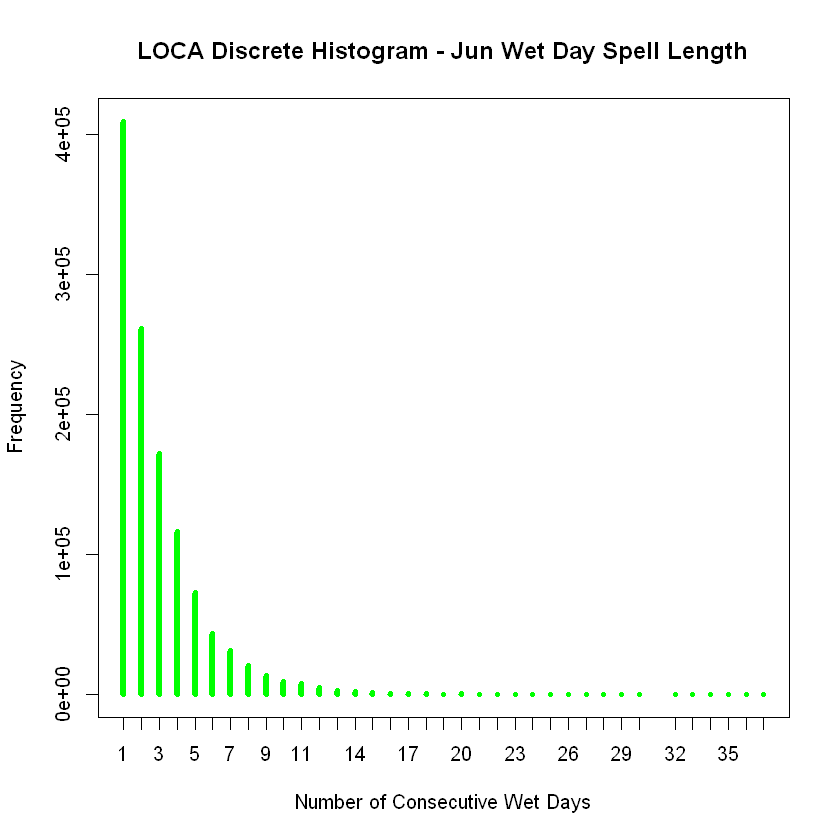

In [127]:
# our case is discrete so use this command
plot( table( dLOJun$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Jun Wet Day Spell Length", 
      col="green" )

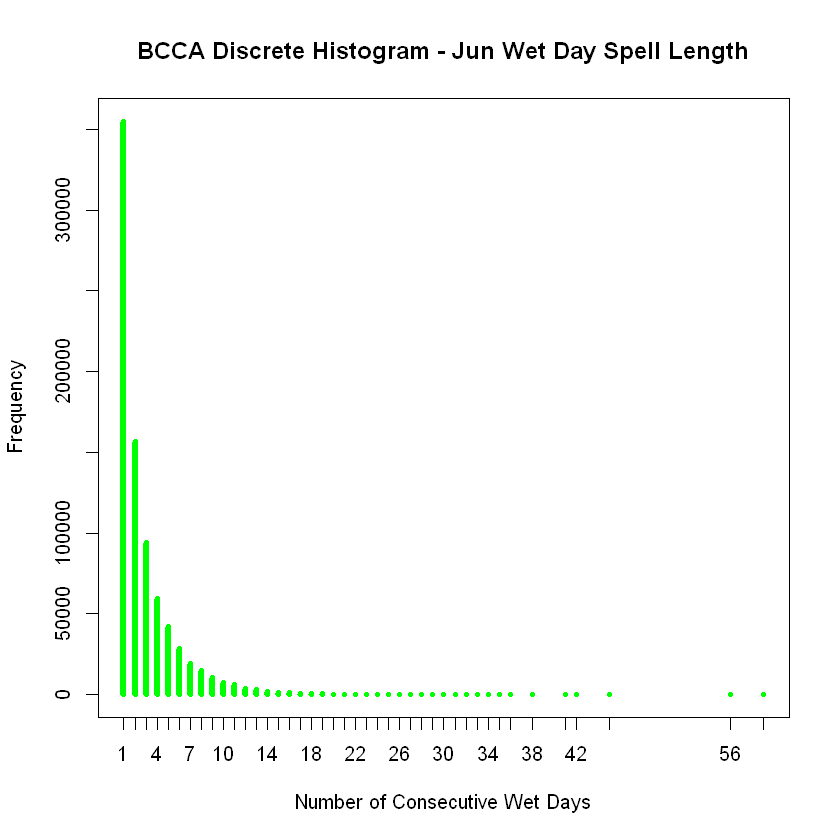

In [128]:
plot( table( dBCJun$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Jun Wet Day Spell Length", 
      col="green" )

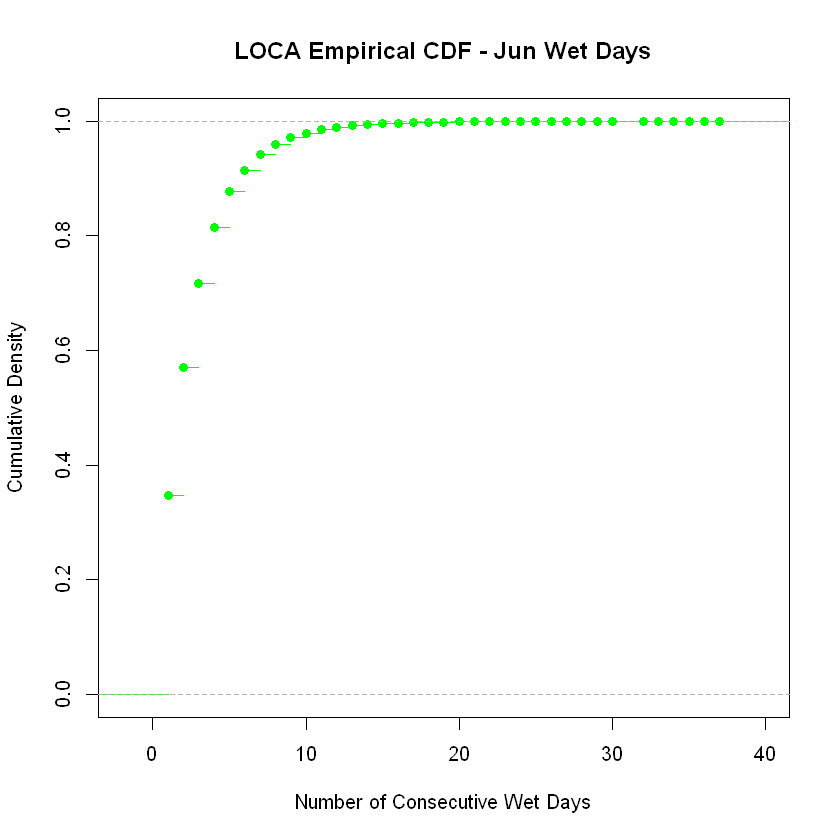

In [129]:
plot(ecdf(dLOJun$Wet_Count), main="LOCA Empirical CDF - Jun Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

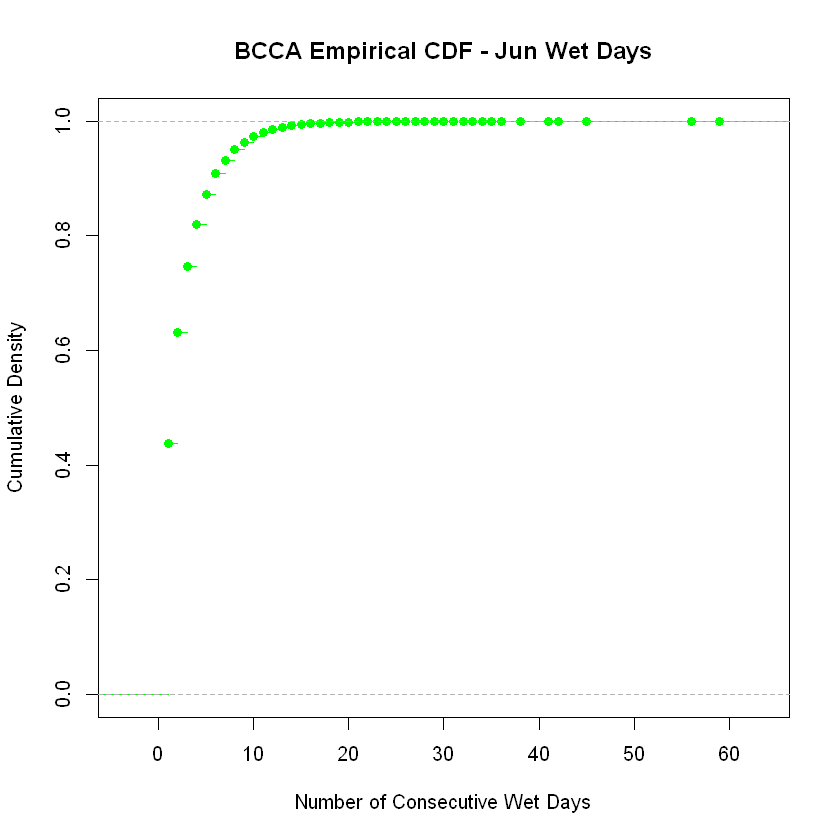

In [130]:
plot(ecdf(dBCJun$Wet_Count), main="BCCA Empirical CDF - Jun Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

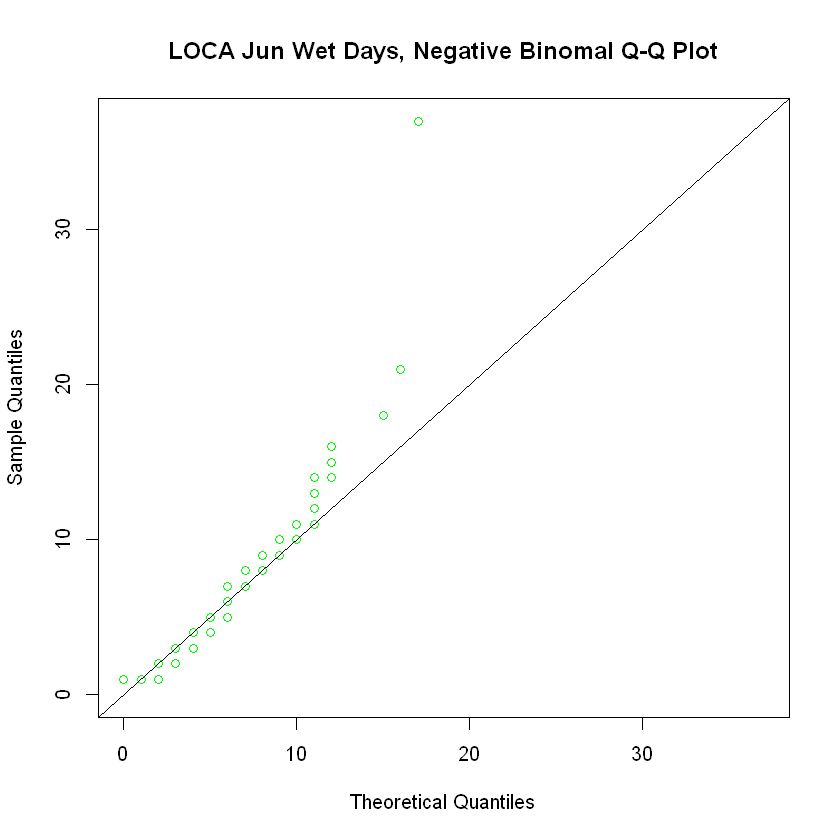

In [131]:
dLOJunMax <- max( dLOJun$Wet_Count )
dLOJunMean <- mean( dLOJun$Wet_Count )
dLOJunVar <- var( dLOJun$Wet_Count )
dLOJunBNr <- dLOJunMean^2 / abs(dLOJunVar - dLOJunMean)
dLOJunTstNB <- rnbinom( 1000, mu=dLOJunMean, size=dLOJunBNr )
qqplot( dLOJunTstNB, dLOJun$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Jun Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOJunMax), ylim=c(0,dLOJunMax) )
abline( 0, 1)

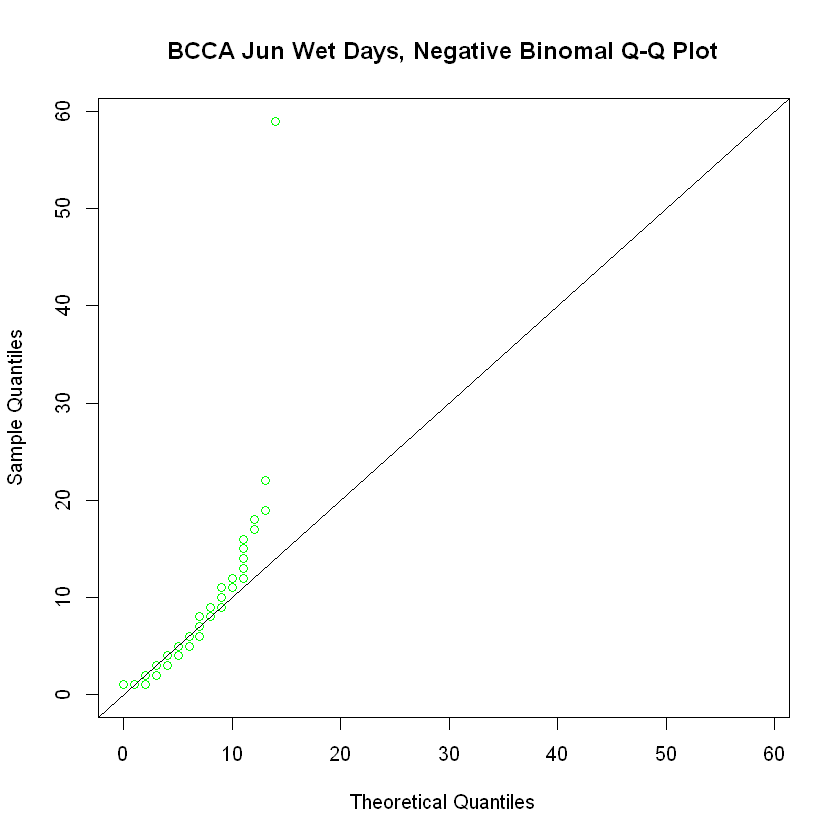

In [132]:
dBCJunMax <- max( dBCJun$Wet_Count )
dBCJunMean <- mean( dBCJun$Wet_Count )
dBCJunVar <- var( dBCJun$Wet_Count )
dBCJunBNr <- dBCJunMean^2 / abs(dBCJunVar - dBCJunMean)
dBCJunTstNB <- rnbinom( 1000, mu=dBCJunMean, size=dBCJunBNr )
qqplot( dBCJunTstNB, dBCJun$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Jun Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCJunMax), ylim=c(0,dBCJunMax) )
abline( 0, 1)

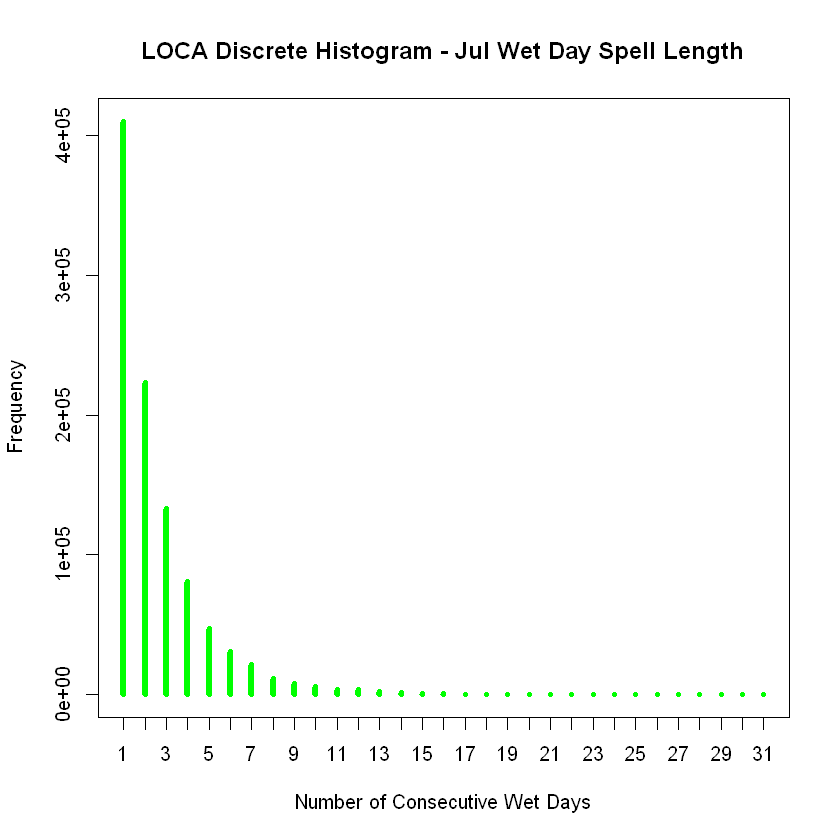

In [133]:
# our case is discrete so use this command
plot( table( dLOJul$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Jul Wet Day Spell Length", 
      col="green" )

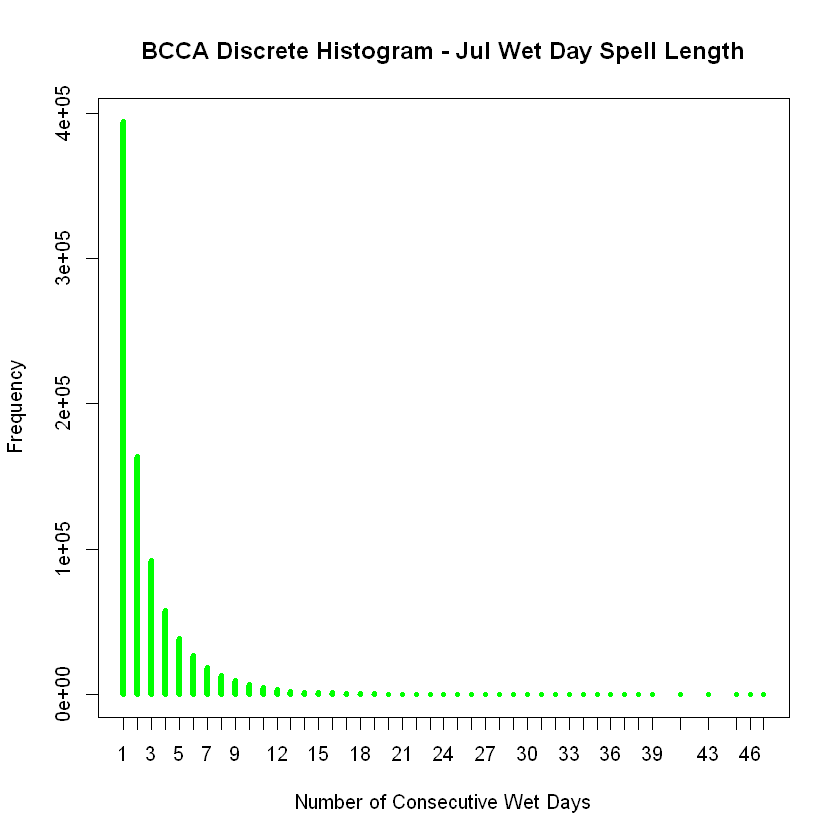

In [134]:
plot( table( dBCJul$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Jul Wet Day Spell Length", 
      col="green" )

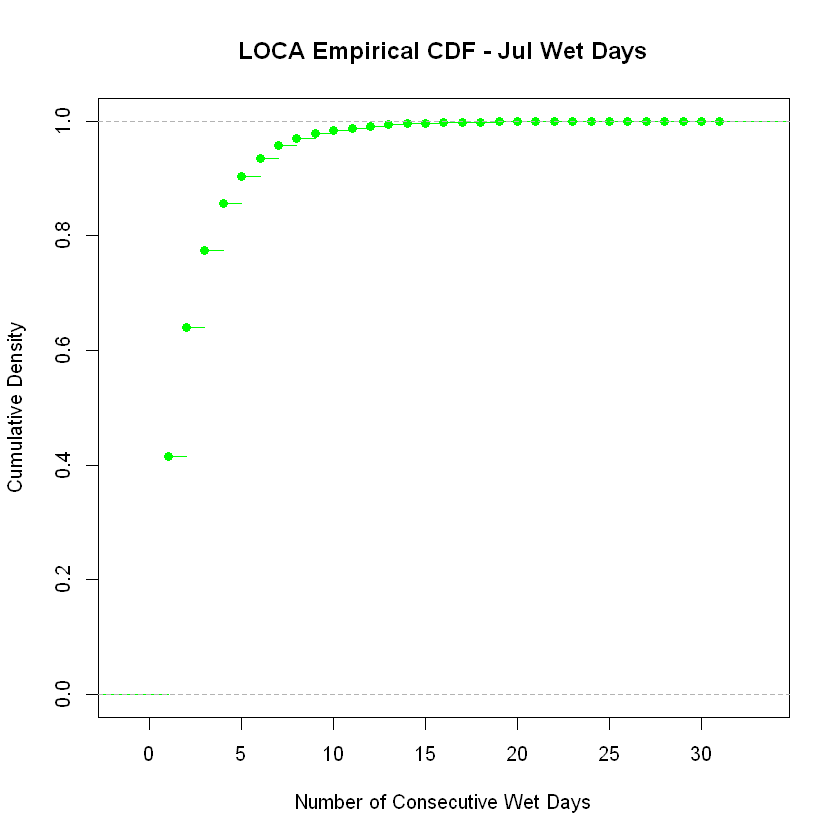

In [135]:
plot(ecdf(dLOJul$Wet_Count), main="LOCA Empirical CDF - Jul Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

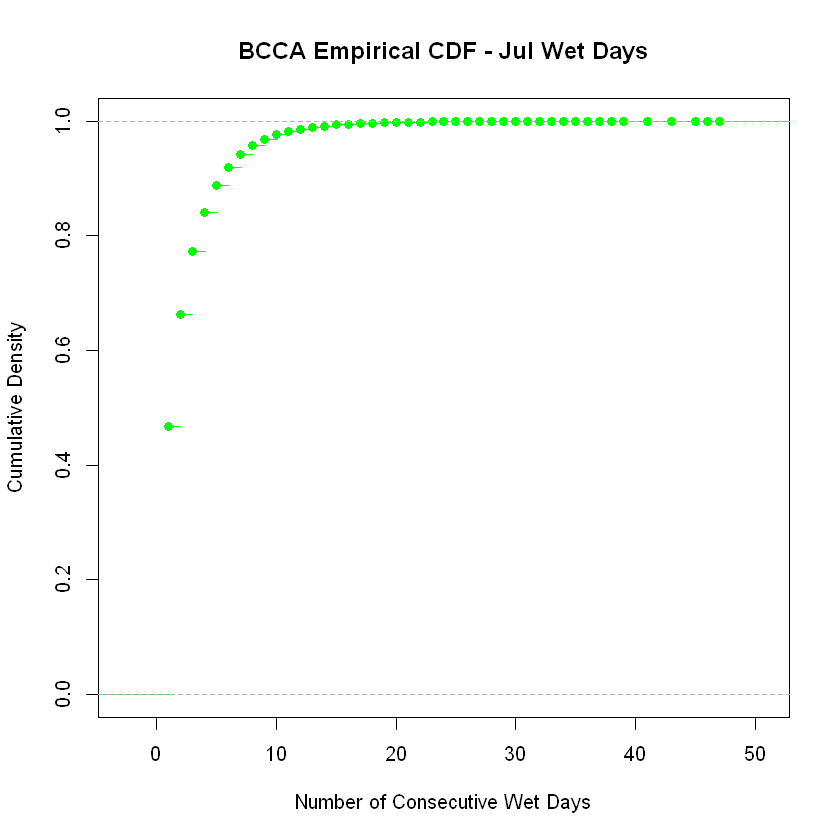

In [136]:
plot(ecdf(dBCJul$Wet_Count), main="BCCA Empirical CDF - Jul Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

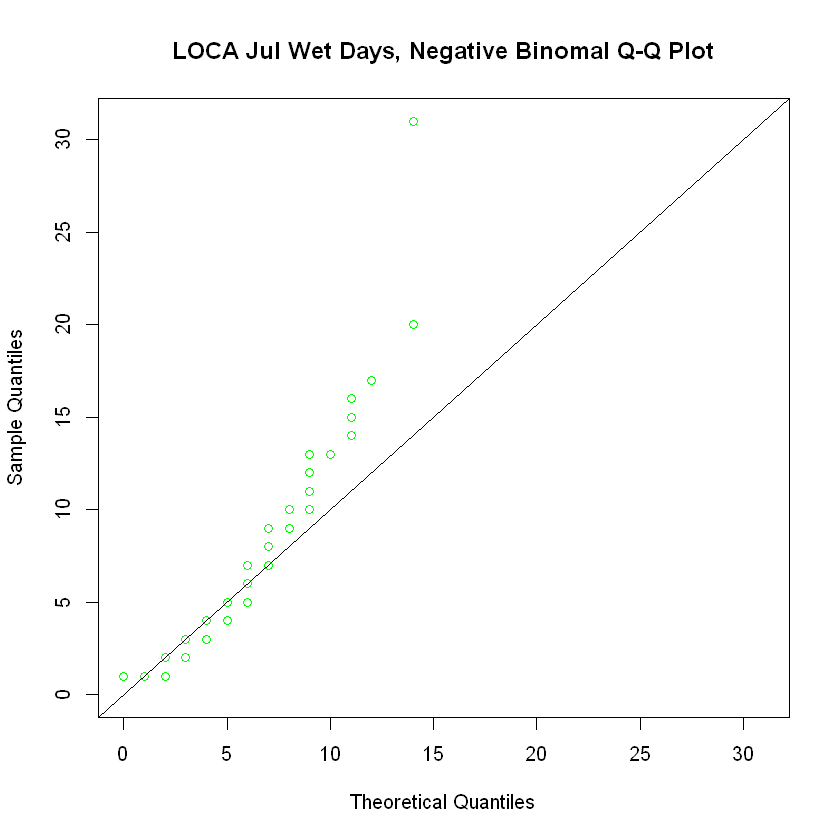

In [137]:
dLOJulMax <- max( dLOJul$Wet_Count )
dLOJulMean <- mean( dLOJul$Wet_Count )
dLOJulVar <- var( dLOJul$Wet_Count )
dLOJulBNr <- dLOJulMean^2 / abs(dLOJulVar - dLOJulMean)
dLOJulTstNB <- rnbinom( 1000, mu=dLOJulMean, size=dLOJulBNr )
qqplot( dLOJulTstNB, dLOJul$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Jul Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOJulMax), ylim=c(0,dLOJulMax) )
abline( 0, 1)

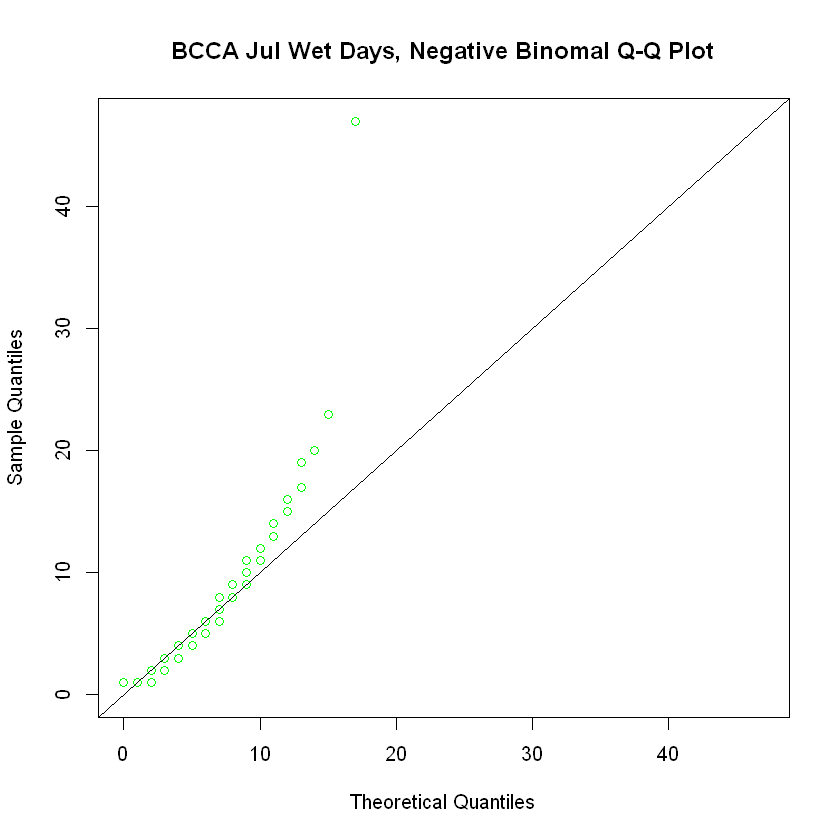

In [138]:
dBCJulMax <- max( dBCJul$Wet_Count )
dBCJulMean <- mean( dBCJul$Wet_Count )
dBCJulVar <- var( dBCJul$Wet_Count )
dBCJulBNr <- dBCJulMean^2 / abs(dBCJulVar - dBCJulMean)
dBCJulTstNB <- rnbinom( 1000, mu=dBCJulMean, size=dBCJulBNr )
qqplot( dBCJulTstNB, dBCJul$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Jul Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCJulMax), ylim=c(0,dBCJulMax) )
abline( 0, 1)

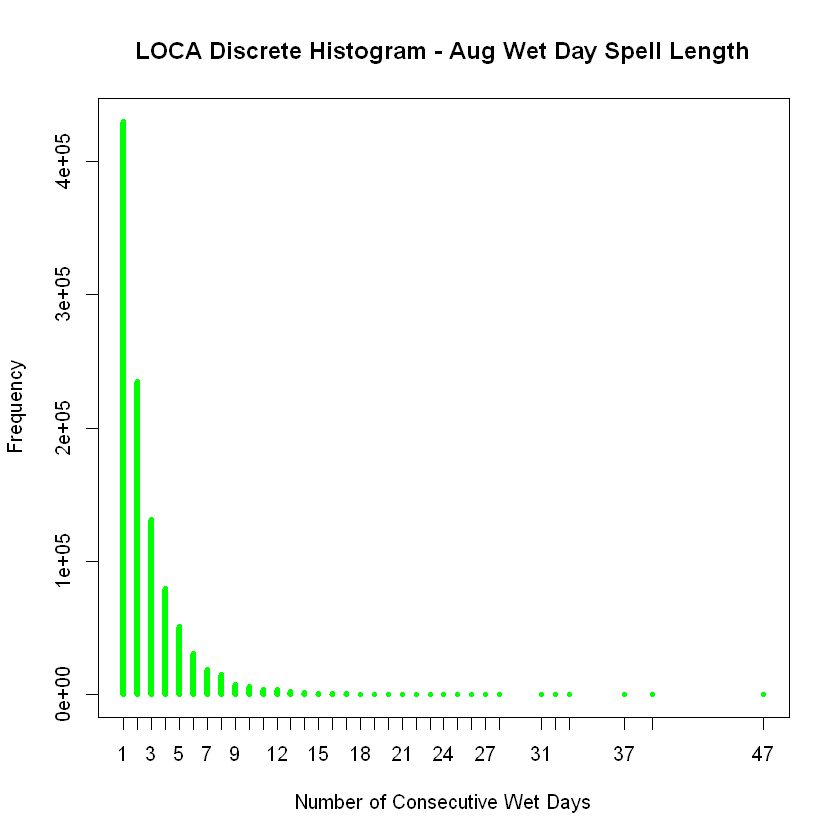

In [139]:
# our case is discrete so use this command
plot( table( dLOAug$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Aug Wet Day Spell Length", 
      col="green" )

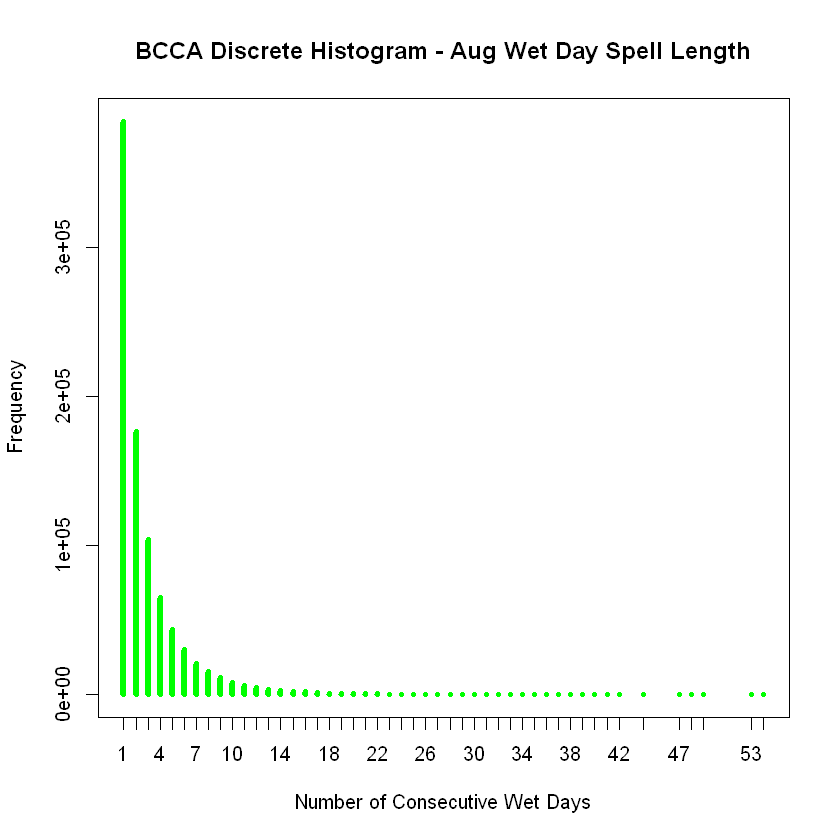

In [140]:
plot( table( dBCAug$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Aug Wet Day Spell Length", 
      col="green" )

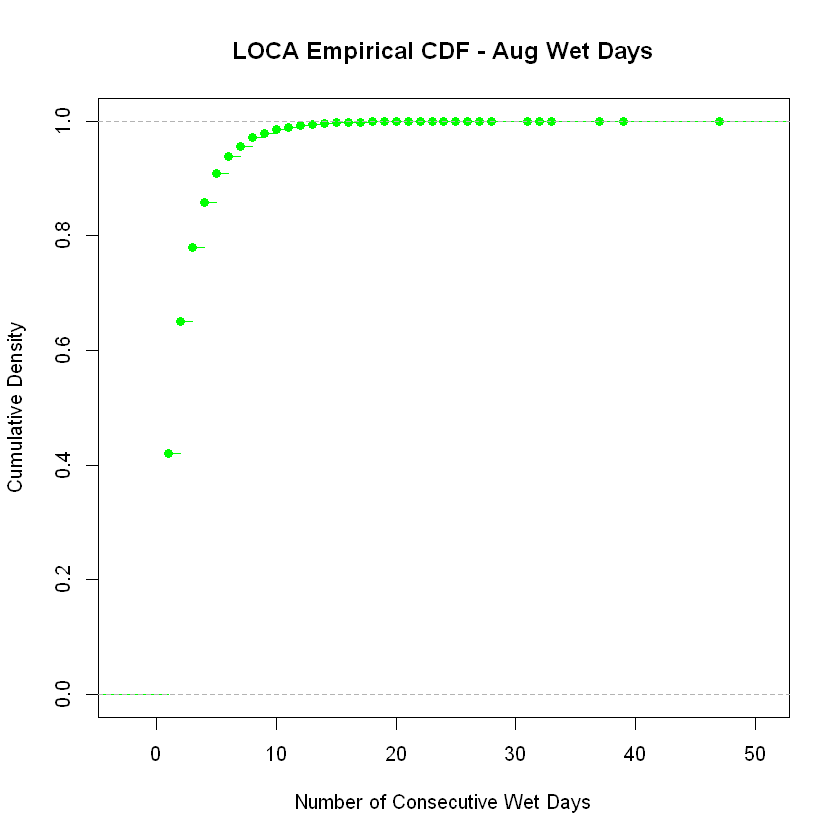

In [141]:
plot(ecdf(dLOAug$Wet_Count), main="LOCA Empirical CDF - Aug Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

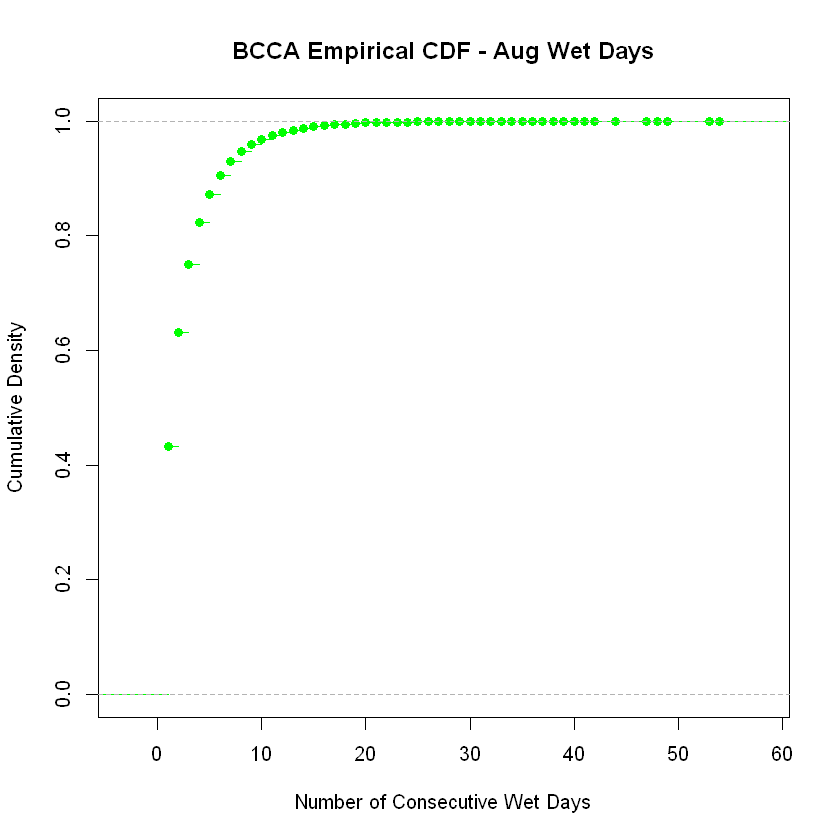

In [142]:
plot(ecdf(dBCAug$Wet_Count), main="BCCA Empirical CDF - Aug Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

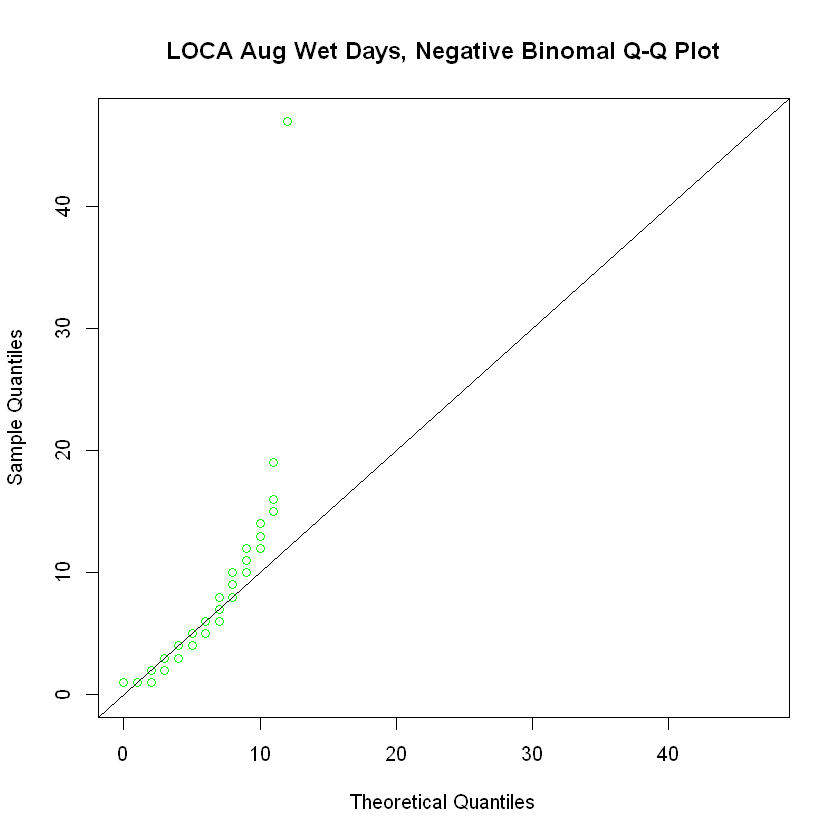

In [143]:
dLOAugMax <- max( dLOAug$Wet_Count )
dLOAugMean <- mean( dLOAug$Wet_Count )
dLOAugVar <- var( dLOAug$Wet_Count )
dLOAugBNr <- dLOAugMean^2 / abs(dLOAugVar - dLOAugMean)
dLOAugTstNB <- rnbinom( 1000, mu=dLOAugMean, size=dLOAugBNr )
qqplot( dLOAugTstNB, dLOAug$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Aug Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOAugMax), ylim=c(0,dLOAugMax) )
abline( 0, 1)

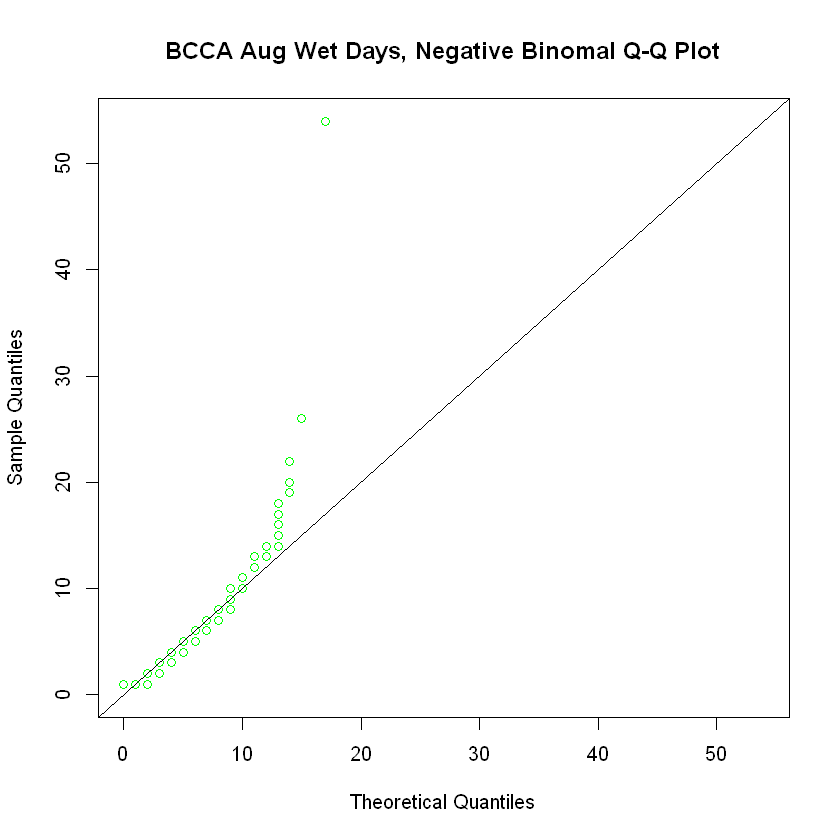

In [144]:
dBCAugMax <- max( dBCAug$Wet_Count )
dBCAugMean <- mean( dBCAug$Wet_Count )
dBCAugVar <- var( dBCAug$Wet_Count )
dBCAugBNr <- dBCAugMean^2 / abs(dBCAugVar - dBCAugMean)
dBCAugTstNB <- rnbinom( 1000, mu=dBCAugMean, size=dBCAugBNr )
qqplot( dBCAugTstNB, dBCAug$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Aug Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCAugMax), ylim=c(0,dBCAugMax) )
abline( 0, 1)

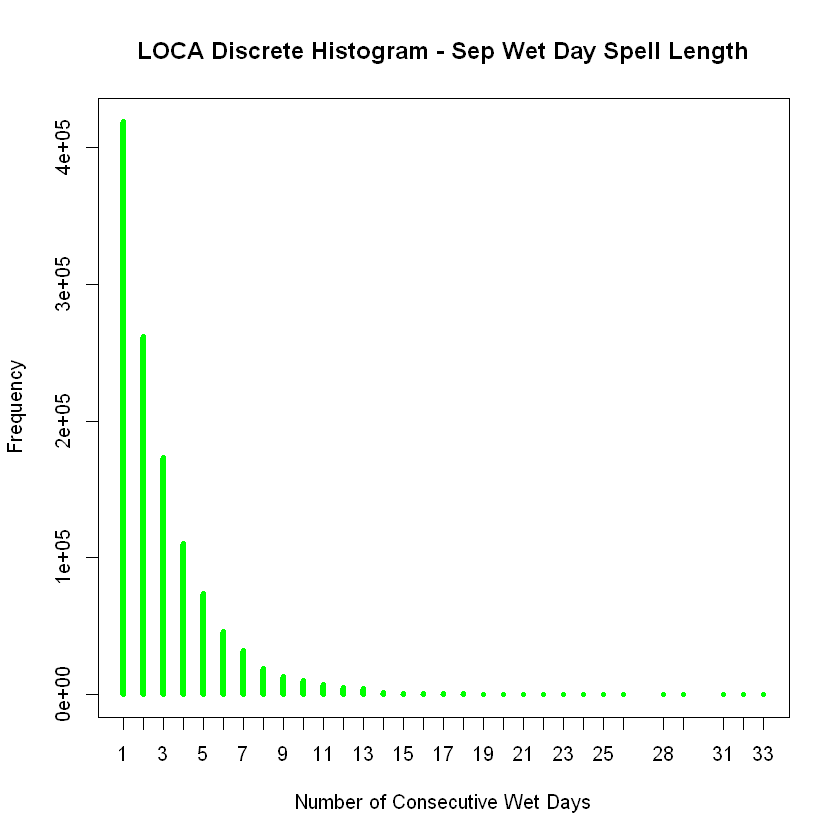

In [145]:
# our case is discrete so use this command
plot( table( dLOSep$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Sep Wet Day Spell Length", 
      col="green" )

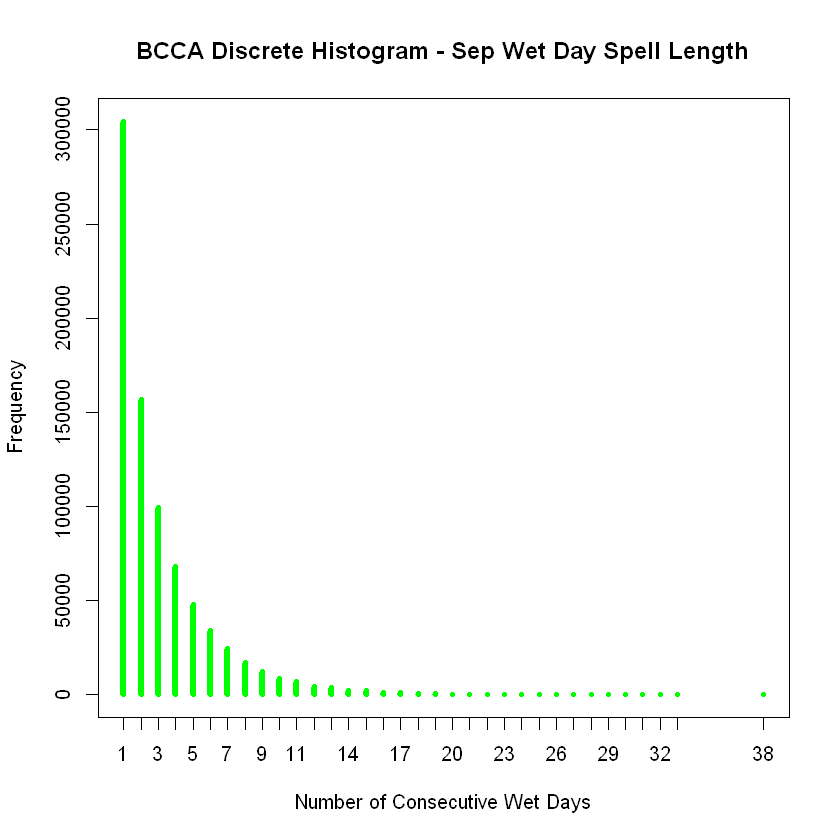

In [146]:
plot( table( dBCSep$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Sep Wet Day Spell Length", 
      col="green" )

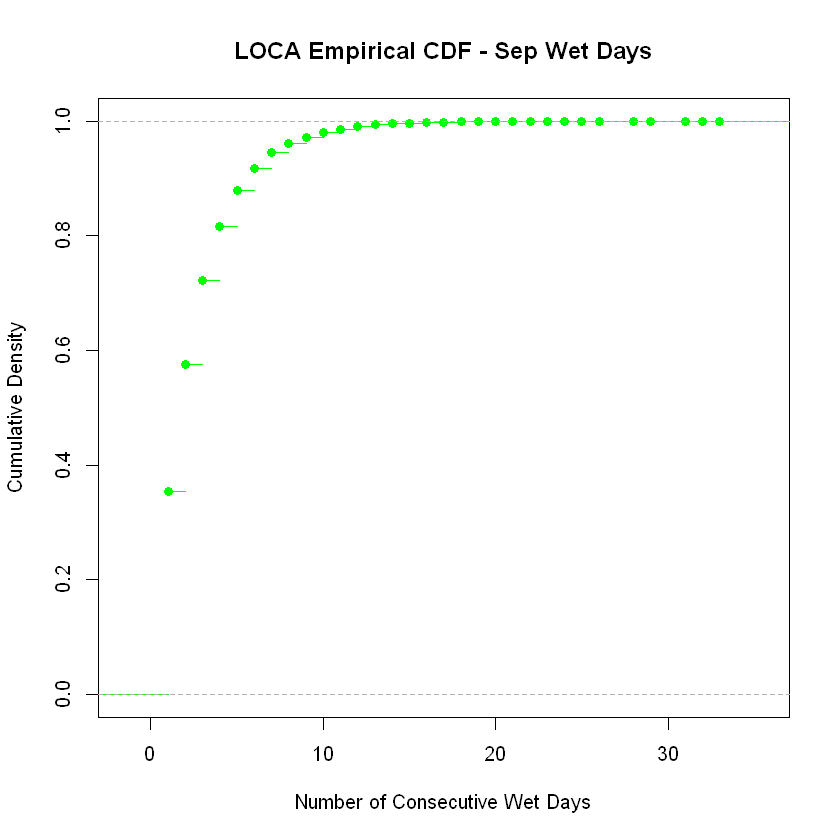

In [147]:
plot(ecdf(dLOSep$Wet_Count), main="LOCA Empirical CDF - Sep Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

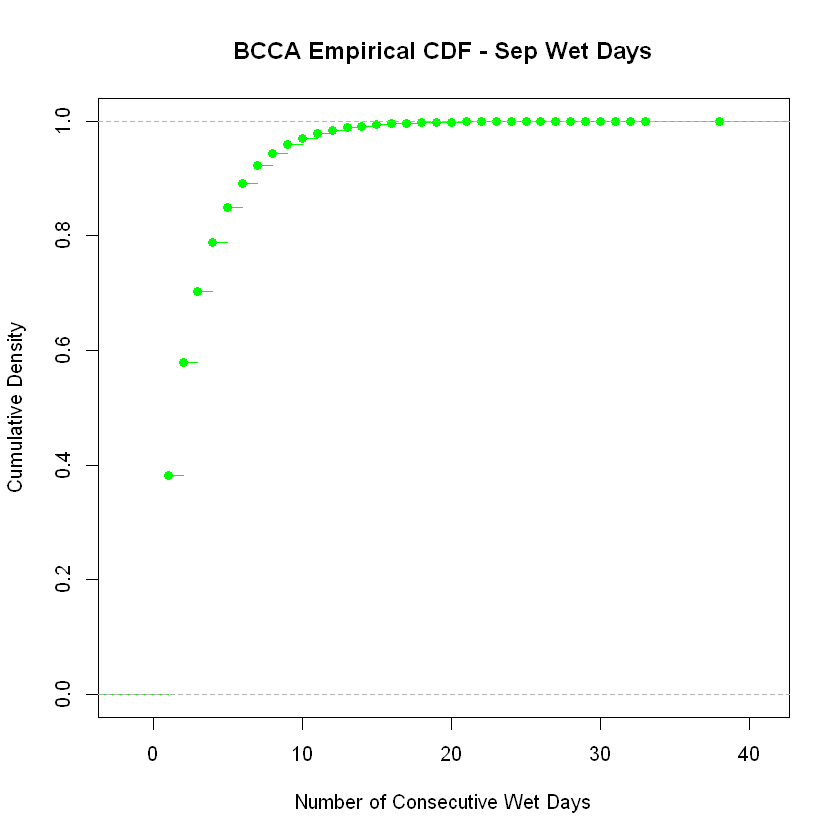

In [148]:
plot(ecdf(dBCSep$Wet_Count), main="BCCA Empirical CDF - Sep Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

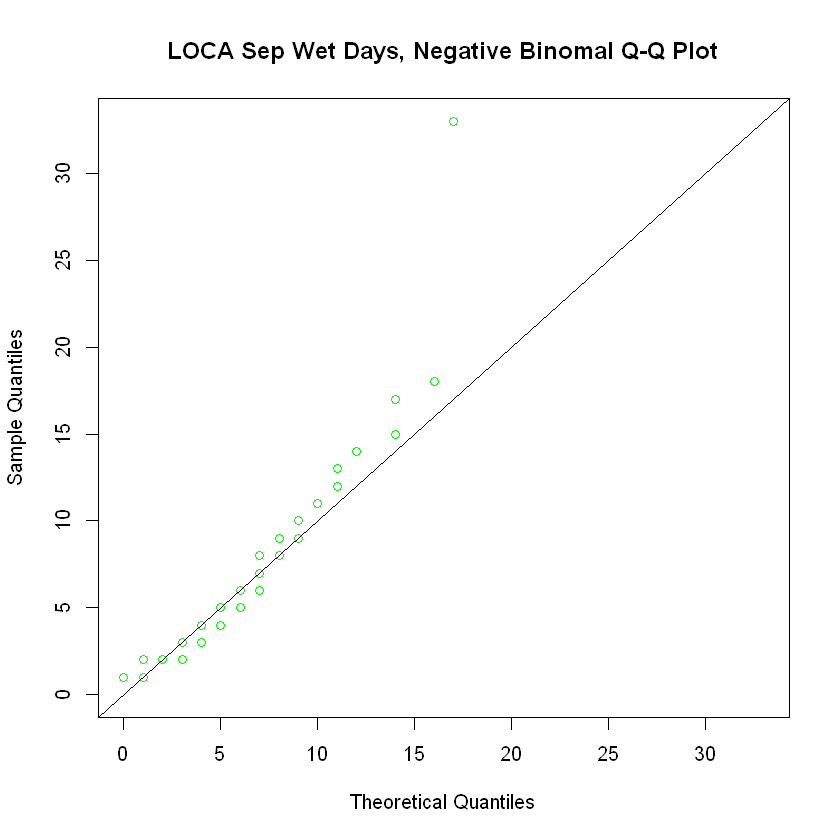

In [149]:
dLOSepMax <- max( dLOSep$Wet_Count )
dLOSepMean <- mean( dLOSep$Wet_Count )
dLOSepVar <- var( dLOSep$Wet_Count )
dLOSepBNr <- dLOSepMean^2 / abs(dLOSepVar - dLOSepMean)
dLOSepTstNB <- rnbinom( 1000, mu=dLOSepMean, size=dLOSepBNr )
qqplot( dLOSepTstNB, dLOSep$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Sep Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOSepMax), ylim=c(0,dLOSepMax) )
abline( 0, 1)

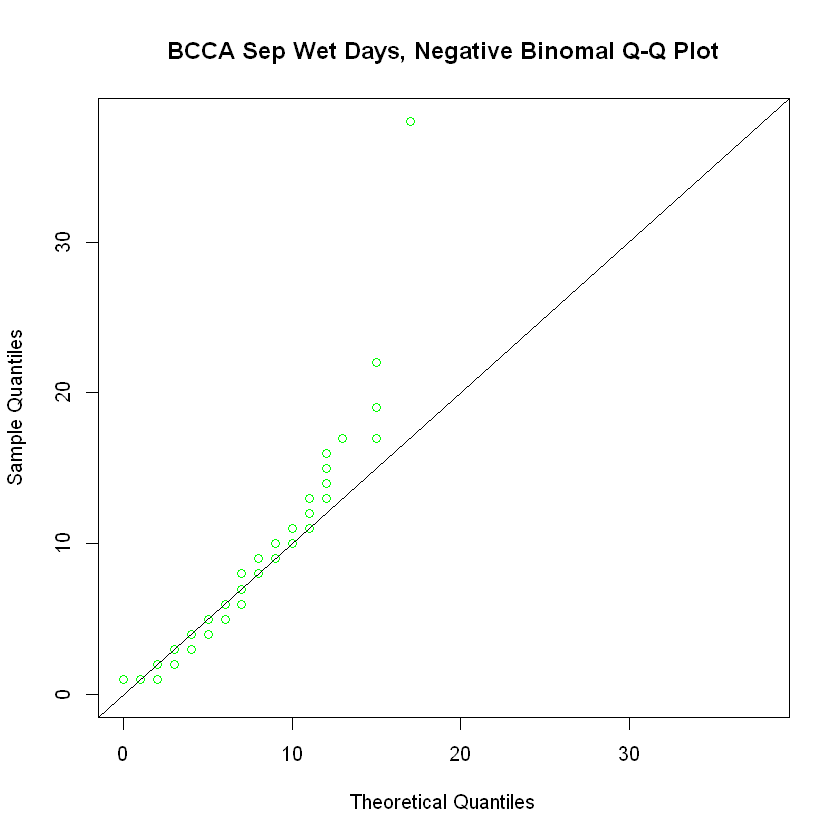

In [150]:
dBCSepMax <- max( dBCSep$Wet_Count )
dBCSepMean <- mean( dBCSep$Wet_Count )
dBCSepVar <- var( dBCSep$Wet_Count )
dBCSepBNr <- dBCSepMean^2 / abs(dBCSepVar - dBCSepMean)
dBCSepTstNB <- rnbinom( 1000, mu=dBCSepMean, size=dBCSepBNr )
qqplot( dBCSepTstNB, dBCSep$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Sep Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCSepMax), ylim=c(0,dBCSepMax) )
abline( 0, 1)

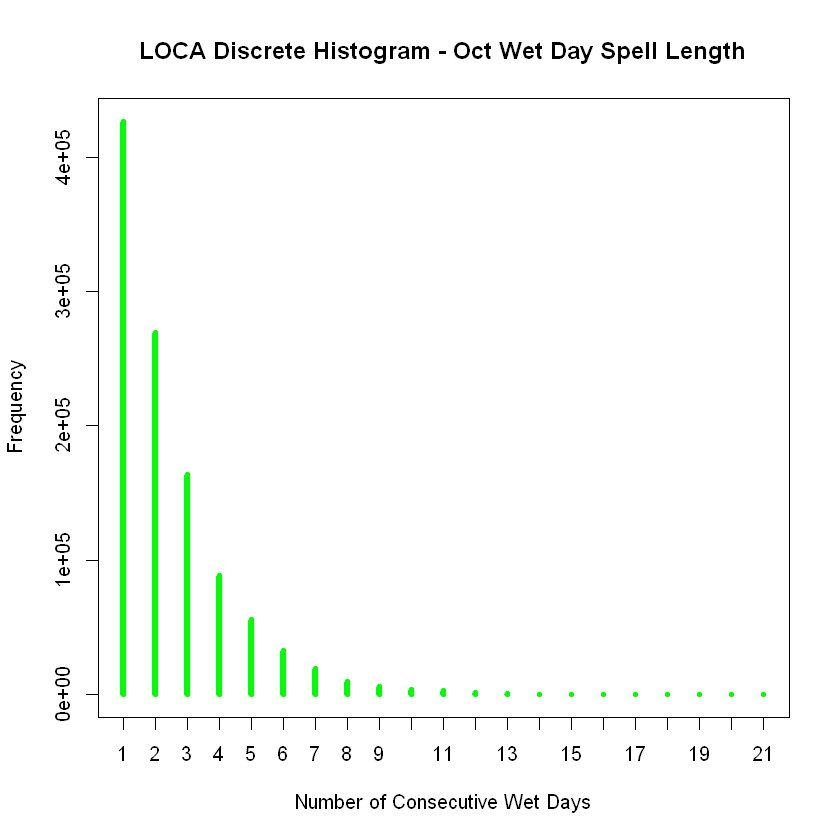

In [151]:
# our case is discrete so use this command
plot( table( dLOOct$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Oct Wet Day Spell Length", 
      col="green" )

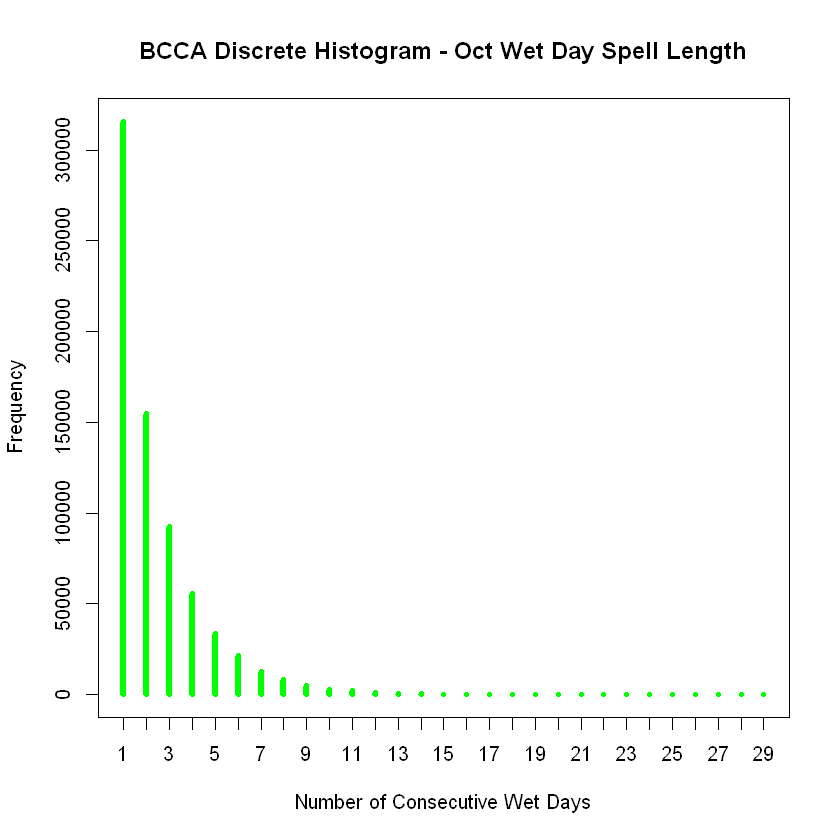

In [152]:
plot( table( dBCOct$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Oct Wet Day Spell Length", 
      col="green" )

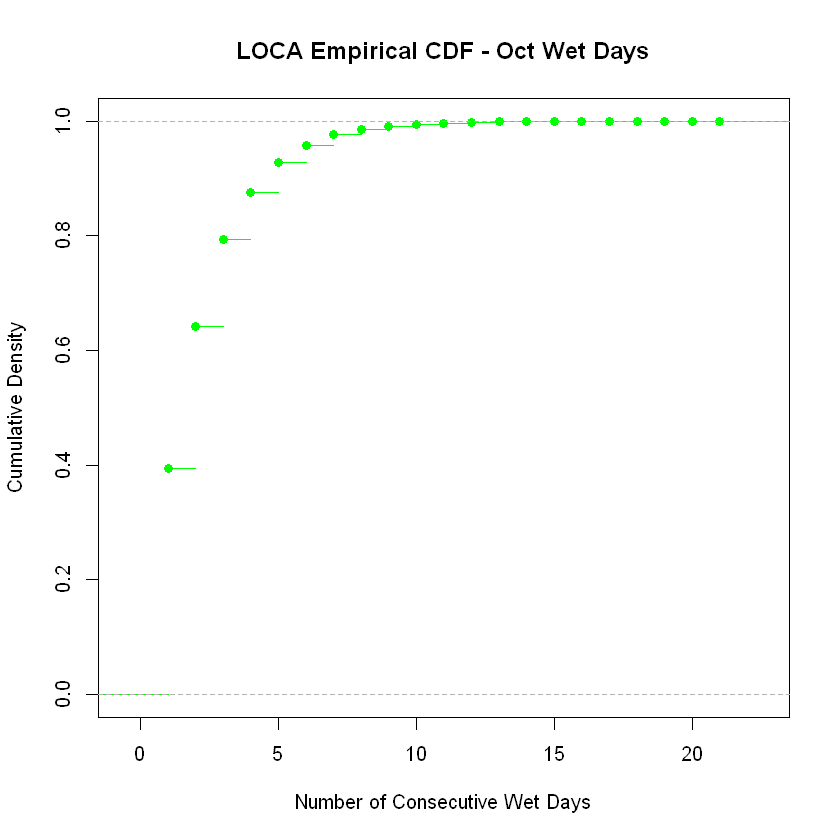

In [153]:
plot(ecdf(dLOOct$Wet_Count), main="LOCA Empirical CDF - Oct Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

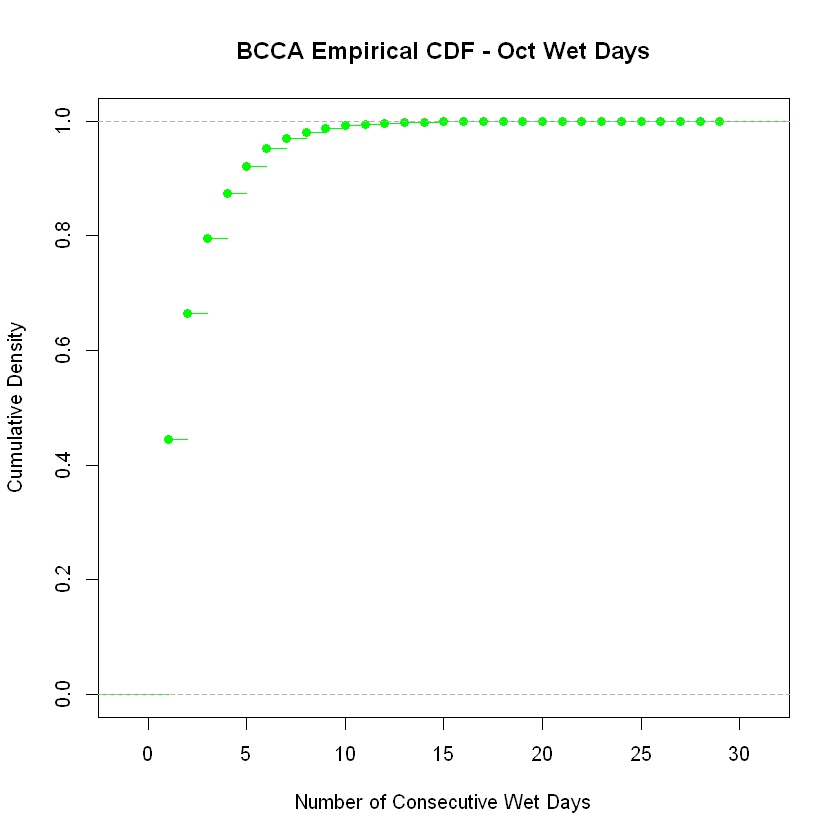

In [154]:
plot(ecdf(dBCOct$Wet_Count), main="BCCA Empirical CDF - Oct Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

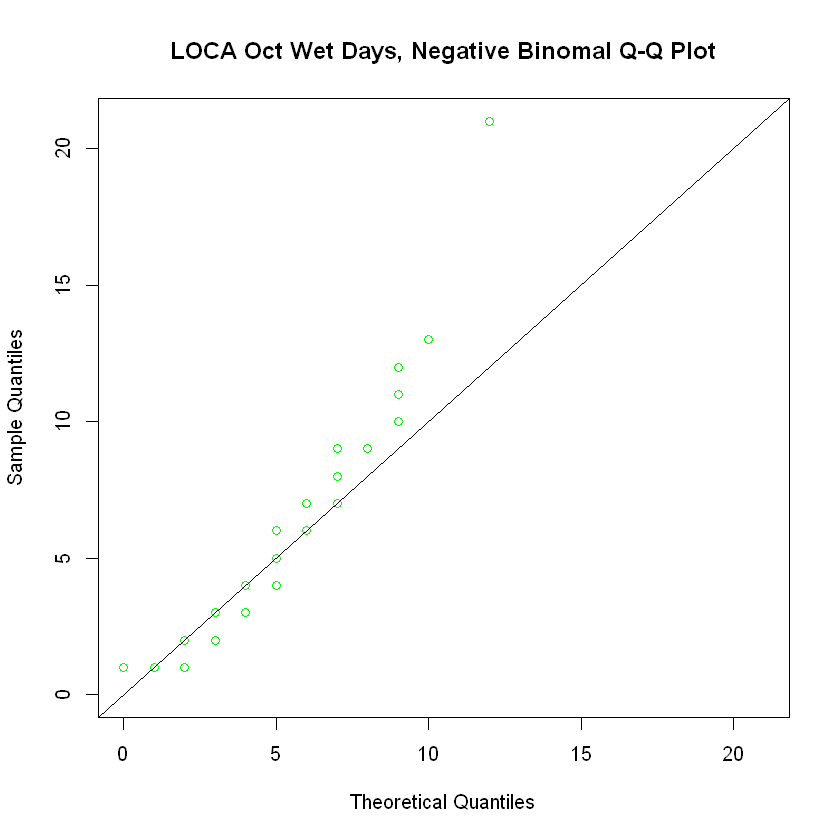

In [155]:
dLOOctMax <- max( dLOOct$Wet_Count )
dLOOctMean <- mean( dLOOct$Wet_Count )
dLOOctVar <- var( dLOOct$Wet_Count )
dLOOctBNr <- dLOOctMean^2 / abs(dLOOctVar - dLOOctMean)
dLOOctTstNB <- rnbinom( 1000, mu=dLOOctMean, size=dLOOctBNr )
qqplot( dLOOctTstNB, dLOOct$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Oct Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOOctMax), ylim=c(0,dLOOctMax) )
abline( 0, 1)

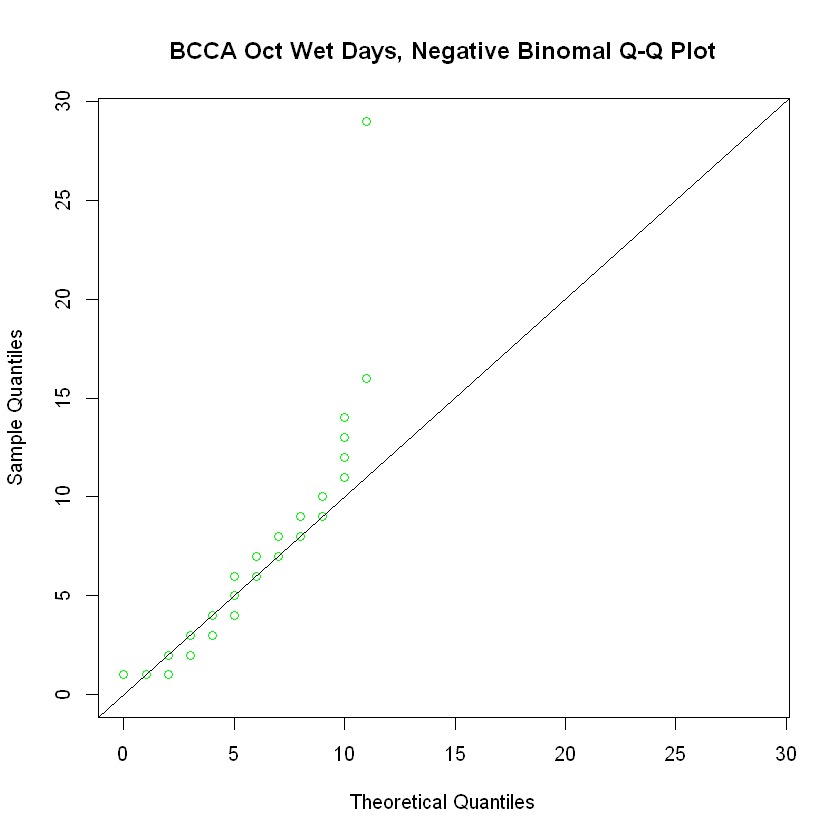

In [156]:
dBCOctMax <- max( dBCOct$Wet_Count )
dBCOctMean <- mean( dBCOct$Wet_Count )
dBCOctVar <- var( dBCOct$Wet_Count )
dBCOctBNr <- dBCOctMean^2 / abs(dBCOctVar - dBCOctMean)
dBCOctTstNB <- rnbinom( 1000, mu=dBCOctMean, size=dBCOctBNr )
qqplot( dBCOctTstNB, dBCOct$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Oct Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCOctMax), ylim=c(0,dBCOctMax) )
abline( 0, 1)

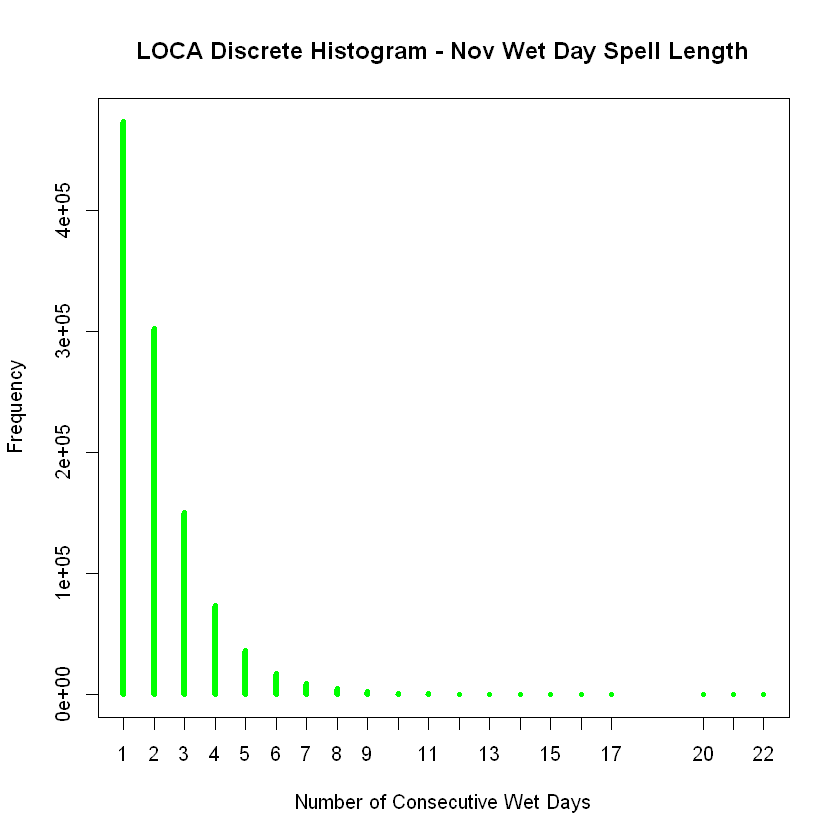

In [157]:
# our case is discrete so use this command
plot( table( dLONov$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Nov Wet Day Spell Length", 
      col="green" )

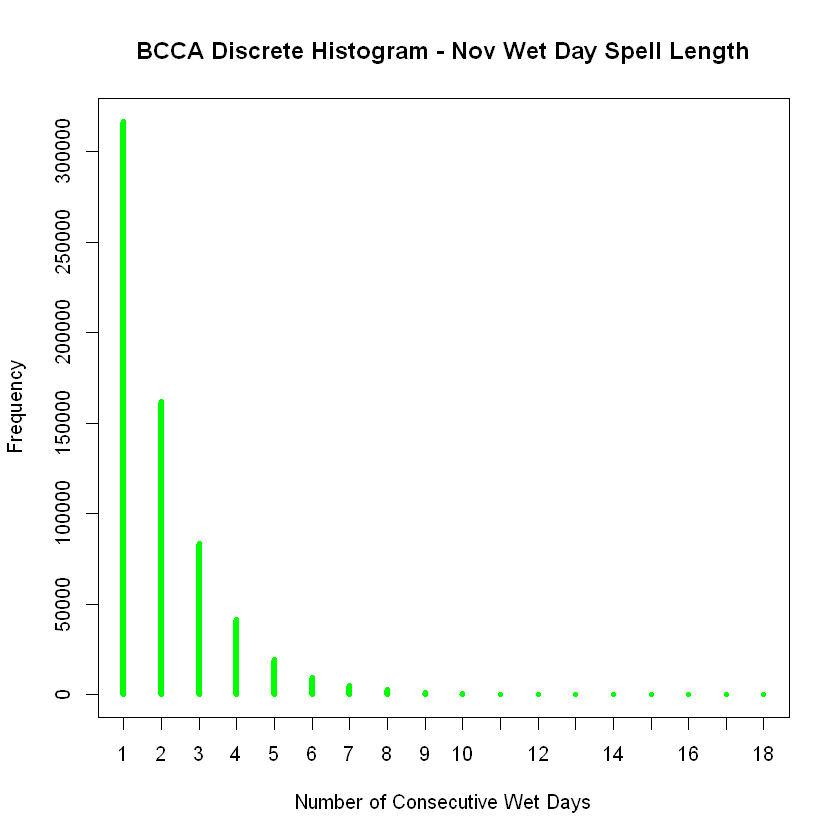

In [158]:
plot( table( dBCNov$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Nov Wet Day Spell Length", 
      col="green" )

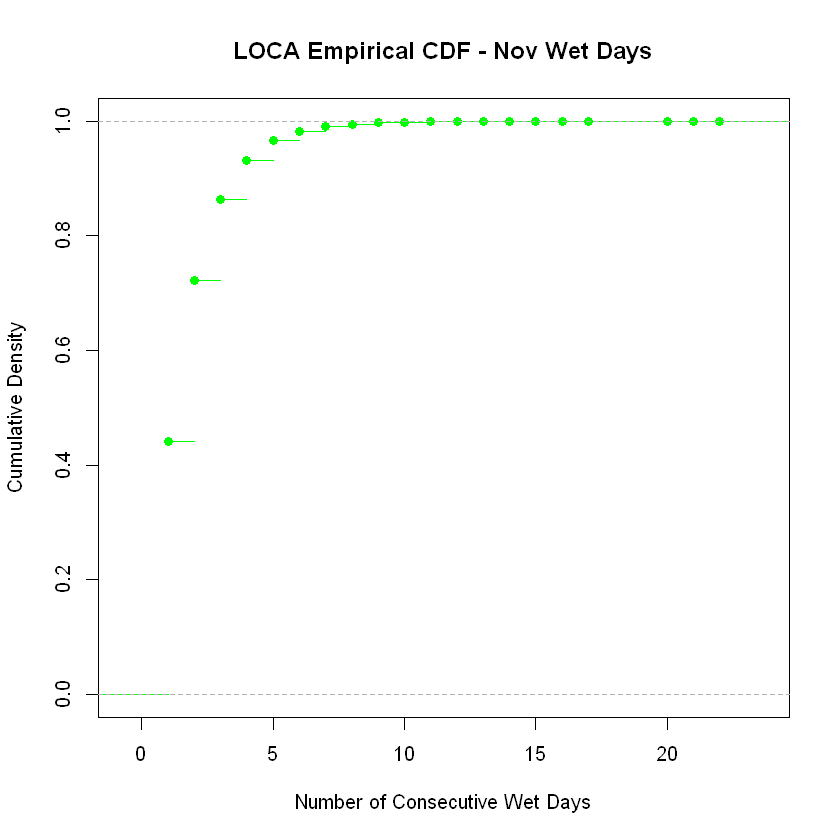

In [159]:
plot(ecdf(dLONov$Wet_Count), main="LOCA Empirical CDF - Nov Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

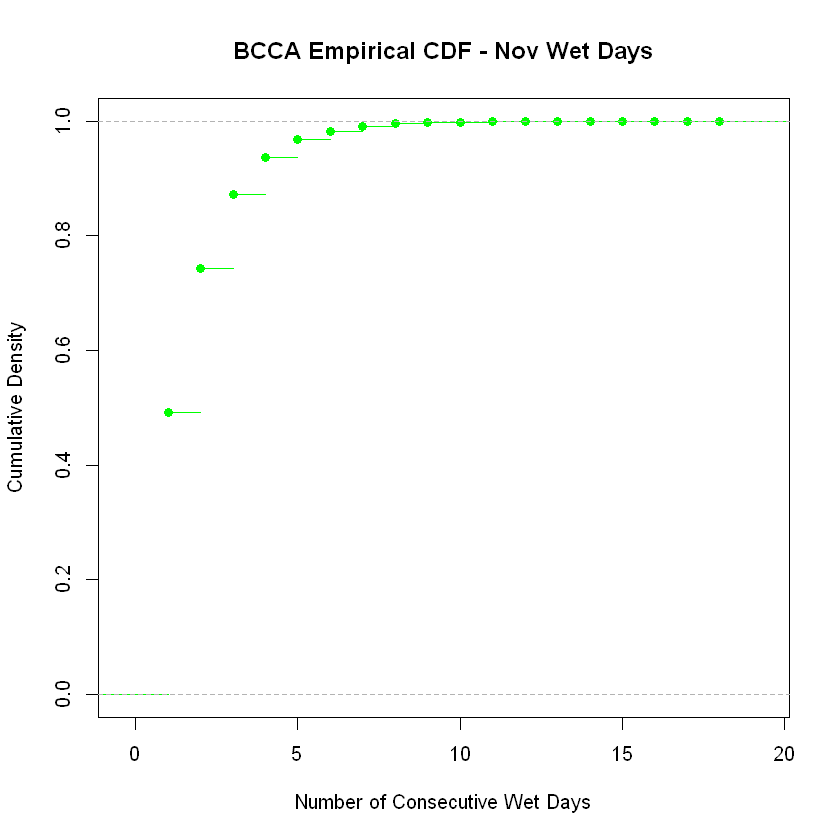

In [160]:
plot(ecdf(dBCNov$Wet_Count), main="BCCA Empirical CDF - Nov Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

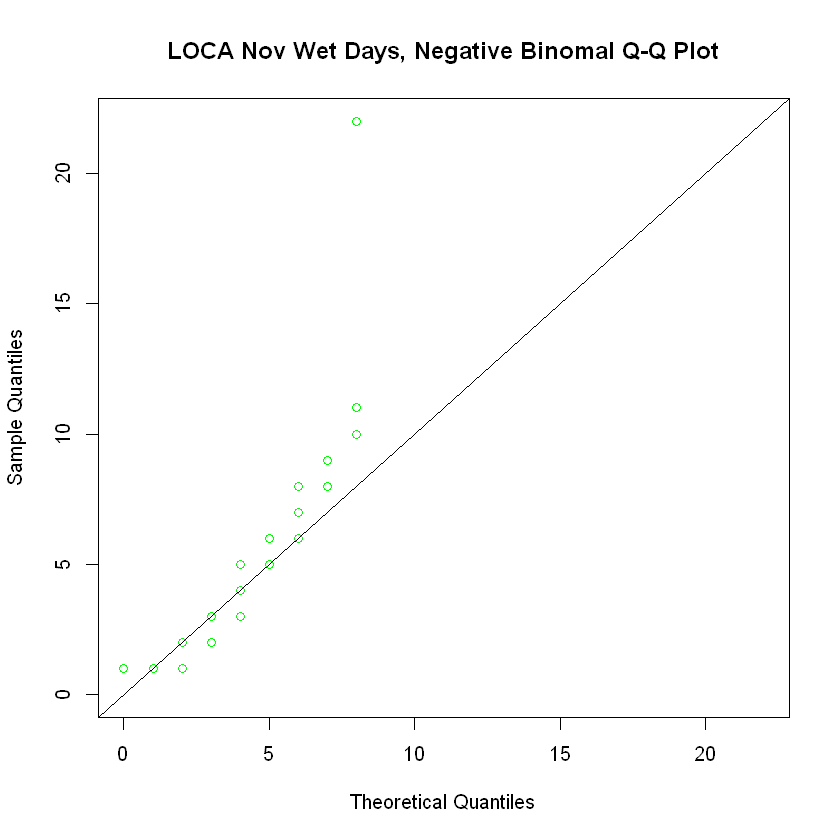

In [161]:
dLONovMax <- max( dLONov$Wet_Count )
dLONovMean <- mean( dLONov$Wet_Count )
dLONovVar <- var( dLONov$Wet_Count )
dLONovBNr <- dLONovMean^2 / abs(dLONovVar - dLONovMean)
dLONovTstNB <- rnbinom( 1000, mu=dLONovMean, size=dLONovBNr )
qqplot( dLONovTstNB, dLONov$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Nov Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLONovMax), ylim=c(0,dLONovMax) )
abline( 0, 1)

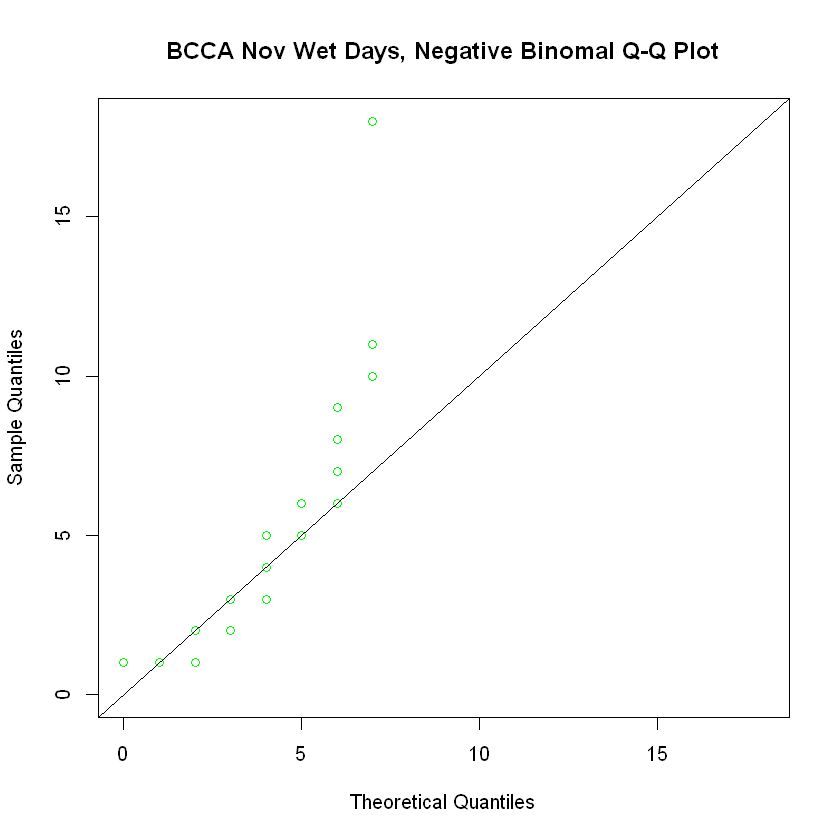

In [162]:
dBCNovMax <- max( dBCNov$Wet_Count )
dBCNovMean <- mean( dBCNov$Wet_Count )
dBCNovVar <- var( dBCNov$Wet_Count )
dBCNovBNr <- dBCNovMean^2 / abs(dBCNovVar - dBCNovMean)
dBCNovTstNB <- rnbinom( 1000, mu=dBCNovMean, size=dBCNovBNr )
qqplot( dBCNovTstNB, dBCNov$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Nov Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCNovMax), ylim=c(0,dBCNovMax) )
abline( 0, 1)

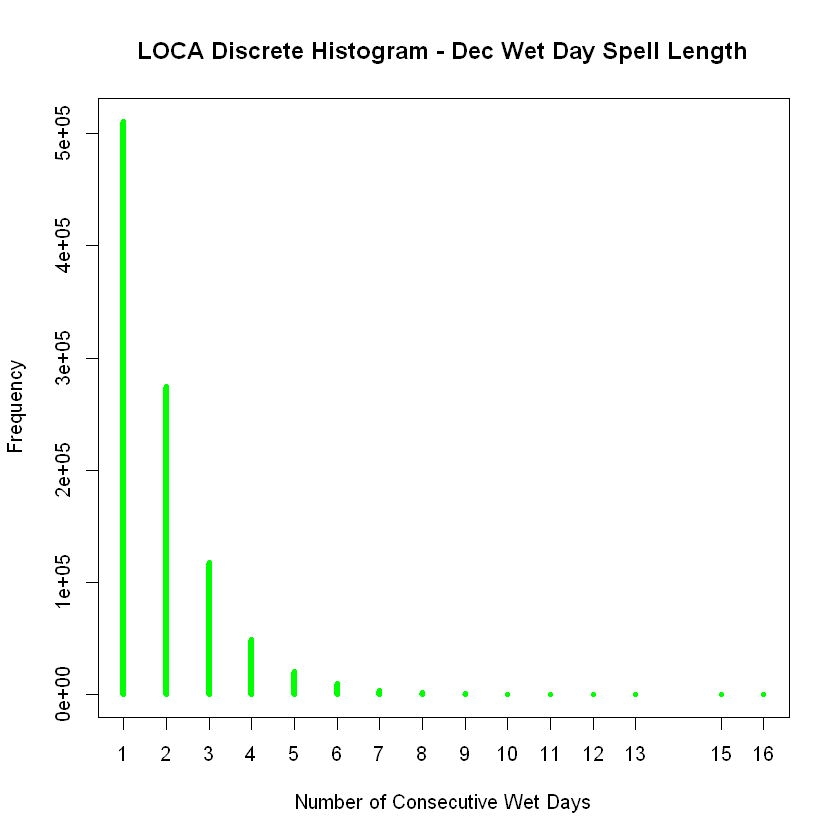

In [163]:
# our case is discrete so use this command
plot( table( dLODec$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Dec Wet Day Spell Length", 
      col="green" )

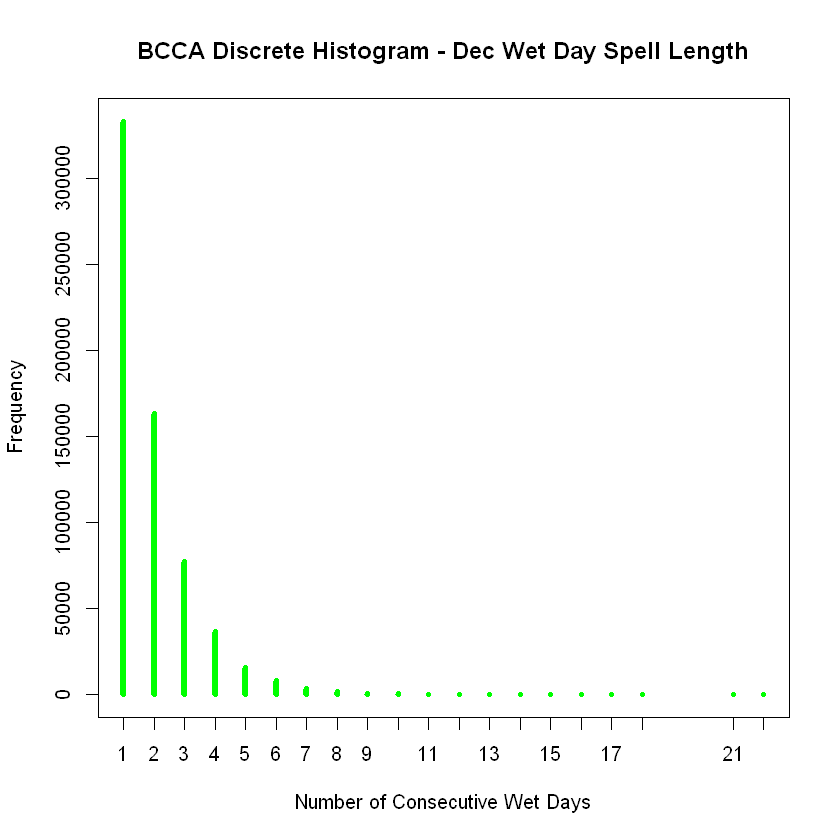

In [164]:
plot( table( dBCDec$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Dec Wet Day Spell Length", 
      col="green" )

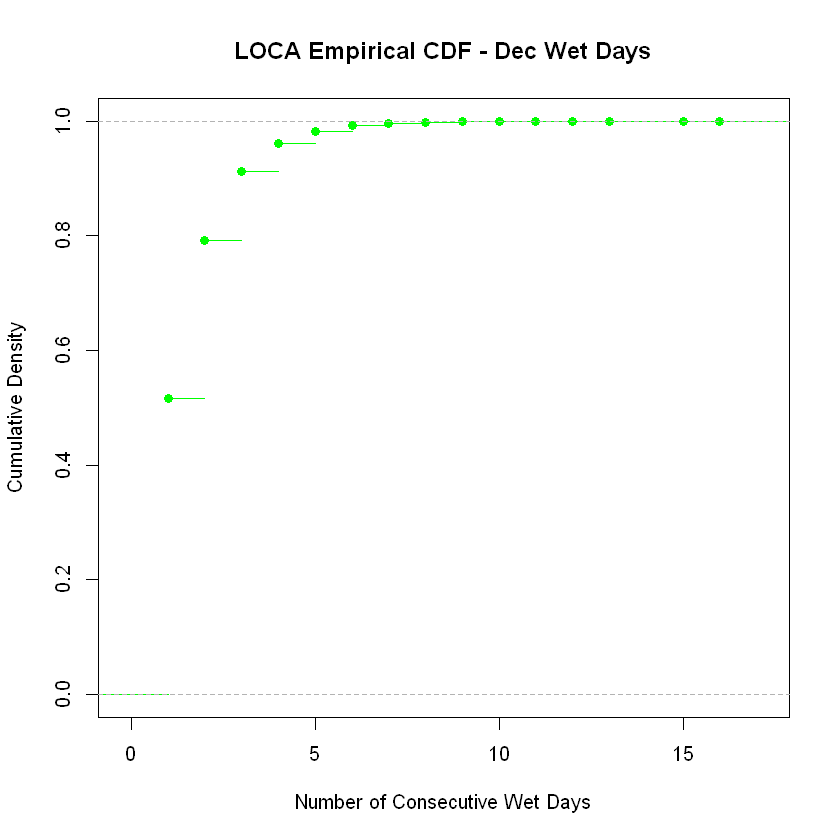

In [165]:
plot(ecdf(dLODec$Wet_Count), main="LOCA Empirical CDF - Dec Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

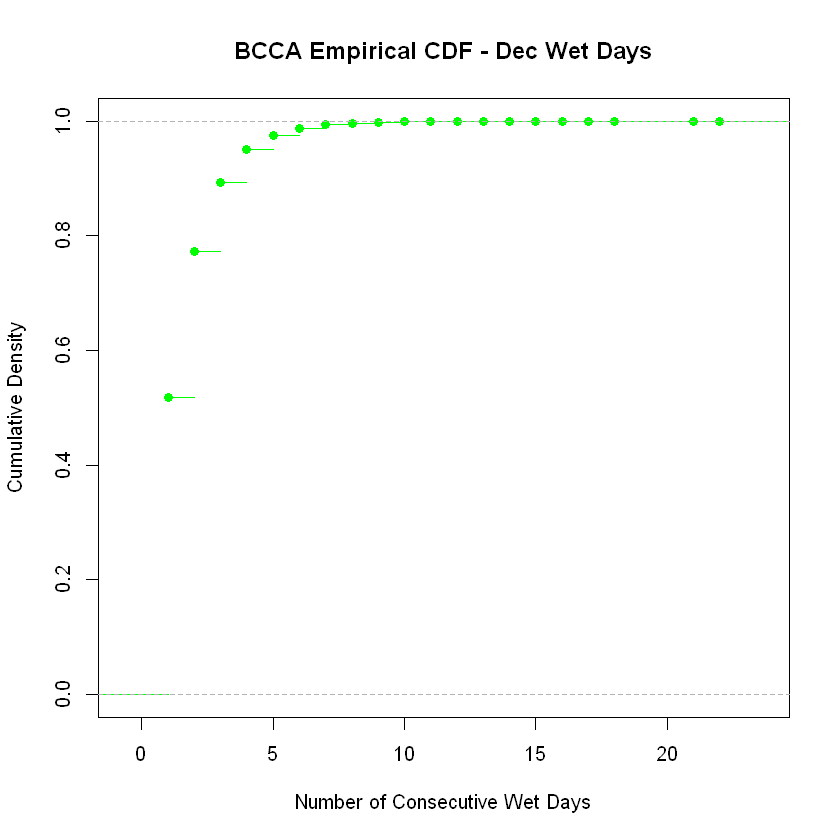

In [166]:
plot(ecdf(dBCDec$Wet_Count), main="BCCA Empirical CDF - Dec Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

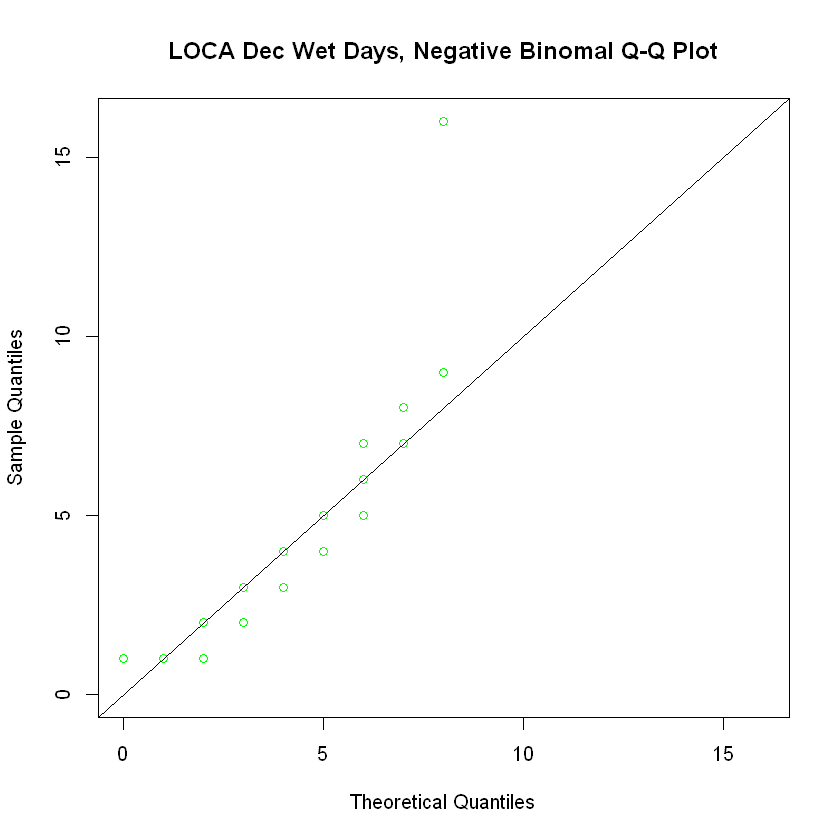

In [167]:
dLODecMax <- max( dLODec$Wet_Count )
dLODecMean <- mean( dLODec$Wet_Count )
dLODecVar <- var( dLODec$Wet_Count )
dLODecBNr <- dLODecMean^2 / abs(dLODecVar - dLODecMean)
dLODecTstNB <- rnbinom( 1000, mu=dLODecMean, size=dLODecBNr )
qqplot( dLODecTstNB, dLODec$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Dec Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLODecMax), ylim=c(0,dLODecMax) )
abline( 0, 1)

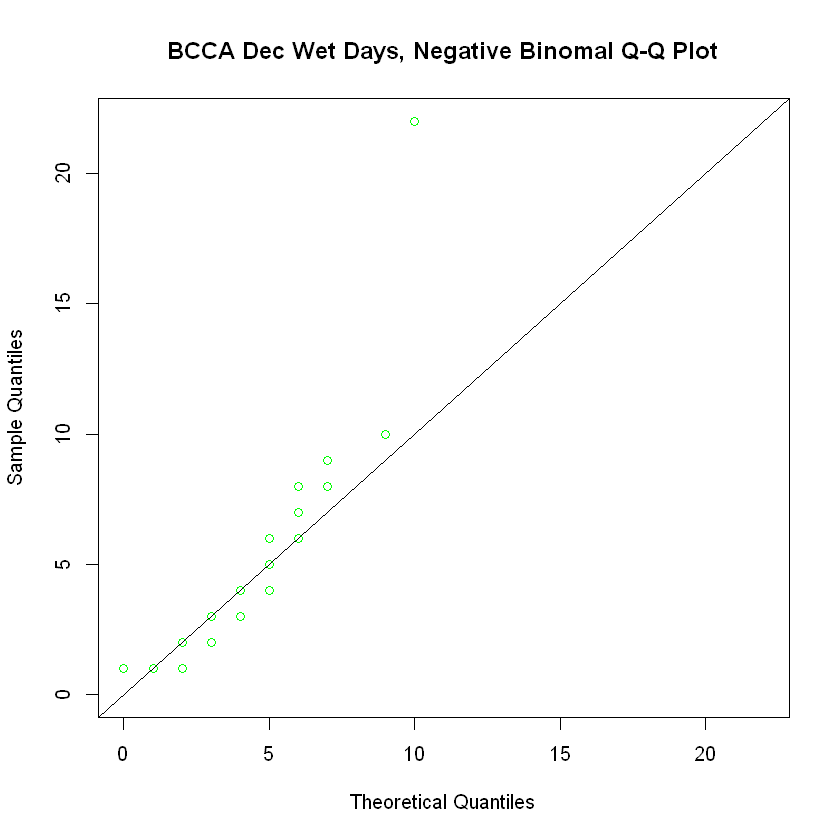

In [168]:
dBCDecMax <- max( dBCDec$Wet_Count )
dBCDecMean <- mean( dBCDec$Wet_Count )
dBCDecVar <- var( dBCDec$Wet_Count )
dBCDecBNr <- dBCDecMean^2 / abs(dBCDecVar - dBCDecMean)
dBCDecTstNB <- rnbinom( 1000, mu=dBCDecMean, size=dBCDecBNr )
qqplot( dBCDecTstNB, dBCDec$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Dec Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCDecMax), ylim=c(0,dBCDecMax) )
abline( 0, 1)

In [169]:
cat("LOCA Jan scale: ", dLOJanBNr, "\n", "LOCA Feb scale: ", dLOFebBNr, "\n",
    "LOCA Mar scale: ", dLOMarBNr, "\n", "LOCA Apr scale: ", dLOAprBNr, "\n",
    "LOCA May scale: ", dLOMayBNr, "\n", "LOCA Jun scale: ", dLOJunBNr, "\n",
    "LOCA Jul scale: ", dLOJulBNr, "\n", "LOCA Aug scale: ", dLOAugBNr, "\n",
    "LOCA Sep scale: ", dLOSepBNr, "\n", "LOCA Oct scale: ", dLOOctBNr, "\n",
    "LOCA Nov scale: ", dLONovBNr, "\n", "LOCA Dec scale: ", dLODecBNr, "\n" )

LOCA Jan scale:  5.318792 
 LOCA Feb scale:  8.853641 
 LOCA Mar scale:  10.92853 
 LOCA Apr scale:  6.366151 
 LOCA May scale:  3.090073 
 LOCA Jun scale:  2.485403 
 LOCA Jul scale:  2.398276 
 LOCA Aug scale:  2.421449 
 LOCA Sep scale:  2.650261 
 LOCA Oct scale:  6.034884 
 LOCA Nov scale:  147.5566 
 LOCA Dec scale:  8.099468 


In [170]:
cat("BCCA Jan scale: ", dBCJanBNr, "\n", "BCCA Feb scale: ", dBCFebBNr, "\n",
    "BCCA Mar scale: ", dBCMarBNr, "\n", "BCCA Apr scale: ", dBCAprBNr, "\n",
    "BCCA May scale: ", dBCMayBNr, "\n", "BCCA Jun scale: ", dBCJunBNr, "\n",
    "BCCA Jul scale: ", dBCJulBNr, "\n", "BCCA Aug scale: ", dBCAugBNr, "\n",
    "BCCA Sep scale: ", dBCSepBNr, "\n", "BCCA Oct scale: ", dBCOctBNr, "\n",
    "BCCA Nov scale: ", dBCNovBNr, "\n", "BCCA Dec scale: ", dBCDecBNr, "\n" )

BCCA Jan scale:  19.20528 
 BCCA Feb scale:  48.32953 
 BCCA Mar scale:  142.0941 
 BCCA Apr scale:  2.529587 
 BCCA May scale:  1.644645 
 BCCA Jun scale:  1.62324 
 BCCA Jul scale:  1.500161 
 BCCA Aug scale:  1.343629 
 BCCA Sep scale:  1.865862 
 BCCA Oct scale:  3.629423 
 BCCA Nov scale:  95.27554 
 BCCA Dec scale:  22.37917 


### Fitting Negative Binomial Distributions

Use the **fitdistrplus** package for distribution fitting. This also provides the *plotdist* function which provides a pair of plots: 

1. empirical density, or a histogram
2. empirical cumulative distribution

These plots were provided above from scratch. **fitdistrplus** also provides a *descdist* function that provides classical descriptive statistics for the sample.

Distributions are then fit using a Maximum Likelihood Estimation (MLE) estimator in the *fitdist* function. Then goodness-of-fit statistics are calculated using the *gofstat* function.

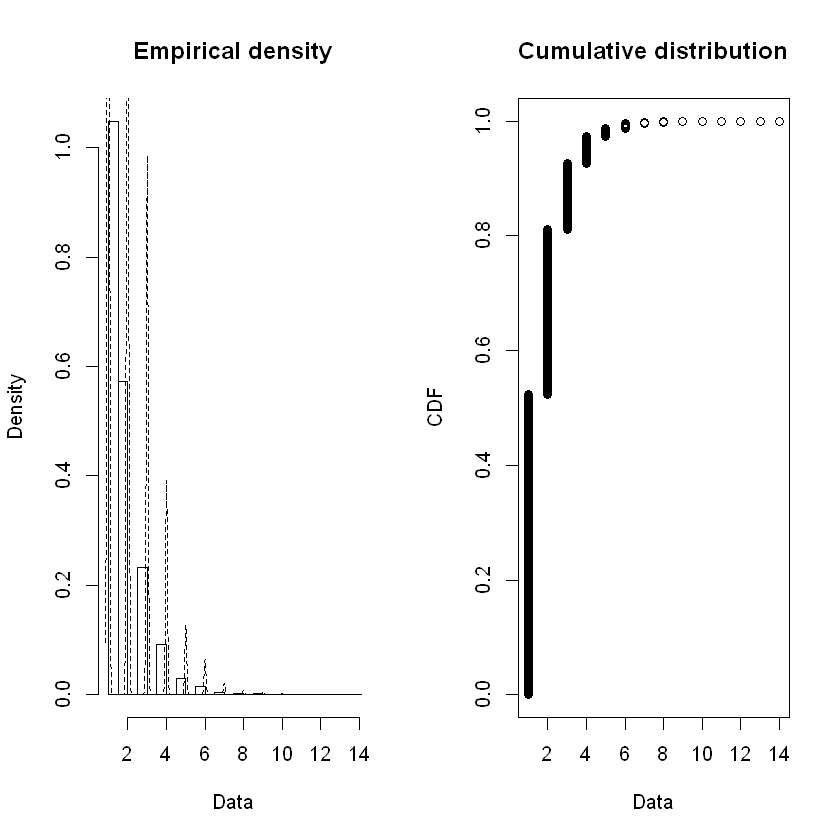

In [171]:
plotdist( dLOJan$Wet_Count, histo=TRUE, demp=TRUE )

In [172]:
LOfd_NB_dJan <- fitdist( dLOJan$Wet_Count, "nbinom" )
LOfd_GE_dJan <- fitdist( dLOJan$Wet_Count, "geom" )

In [173]:
summary( LOfd_NB_dJan )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
         estimate  Std. Error
size 8.392017e+06 0.165573497
mu   1.784622e+00 0.001398723
Loglikelihood:  -1341305   AIC:  2682614   BIC:  2682637 
Correlation matrix:
            size          mu
size 1.00000e+00 5.39216e-08
mu   5.39216e-08 1.00000e+00


In [174]:
LOfdNB_dJan_size <- LOfd_NB_dJan$estimate[["size"]]
LOfdNB_dJan_mu <- LOfd_NB_dJan$estimate[["mu"]]
cat("LOCA Jan size: ", LOfdNB_dJan_size, "\n", "LOCA Jan mu: ", LOfdNB_dJan_mu, "\n")

LOCA Jan size:  8392017 
 LOCA Jan mu:  1.784622 


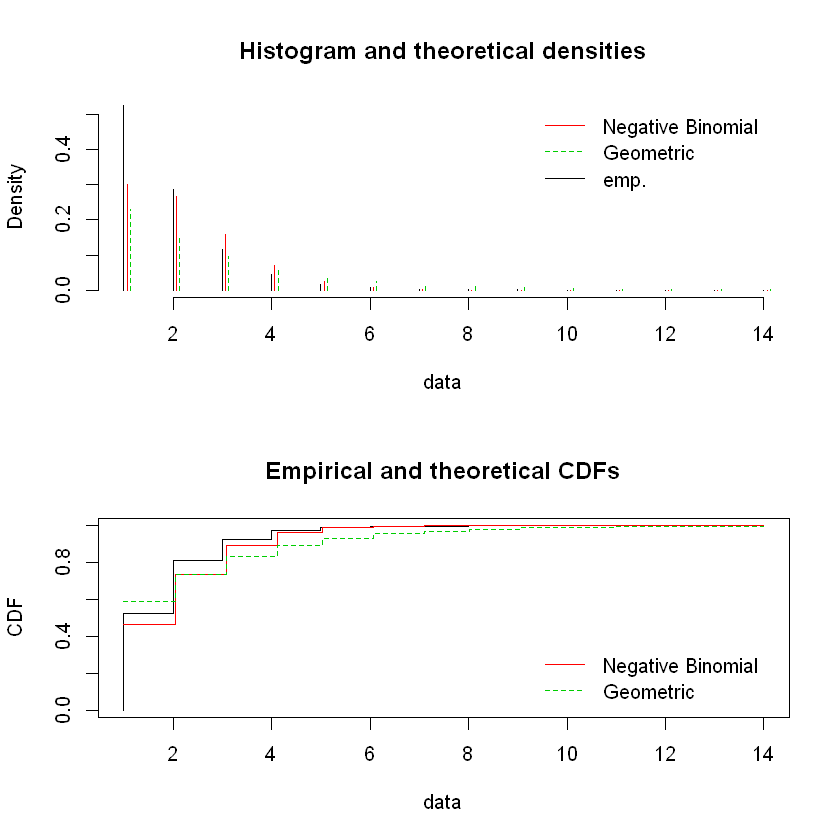

In [175]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dJan, LOfd_GE_dJan), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dJan, LOfd_GE_dJan), legendtext=plot.legend )

In [176]:
LOstatRes <- gofstat( list(LOfd_NB_dJan, LOfd_GE_dJan), fitnames=c("Negative Binomial", "Geometric") )

In [177]:
print(LOstatRes)

Chi-squared statistic:  33388.66 191298.7 
Degree of freedom of the Chi-squared distribution:  5 6 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    478267            426422.5238      537599.31
<= 2    261300            243857.5687      134559.91
<= 3    106404            145064.5158       86234.34
<= 4     41761             64721.3341       55264.31
<= 5     13624             23100.6270       35416.80
<= 6      6964              6870.9831       22697.28
<= 7      2187              1751.7304       14545.83
> 7       1767               484.7171       25956.23

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2682614   3317070
Bayesian Information Criterion           2682637   3317081


In [178]:
LOfdNB_dJan_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

[Chi-Squared Test](https://www.r-bloggers.com/chi-squared-test/)

Like all statistical tests, chi-squared test assumes a null hypothesis and an alternate hypothesis. The general practice is, if the p-value that comes out in the result is less than a pre-determined significance level, which is 0.05 usually, then we reject the null hypothesis.

- H0: The The two variables are independent
- H1: The two variables are related.

The null hypothesis of the chi-squared test is that the two variables are independent and the alternate hypothesis is that they are related.

In this case our p-value is 0.0 and we can reject the null hypothesis that sample and MLE-fit distribution are not related.

In [179]:
LOfdNB_dJan_p = LOfdNB_dJan_size / (LOfdNB_dJan_size + LOfdNB_dJan_mu)
cat("LOCA prob: ", LOfdNB_dJan_p)

LOCA prob:  0.9999998

In [180]:
# add to our tracking dataframe
LOMonDistDF[1, ] <- list( 1, dLOJanMean, dLOJanBNr, LOfdNB_dJan_p, LOfdNB_dJan_mu, LOfdNB_dJan_size,
                          LOfdNB_dJan_pvalue )

In [181]:
LOgf_dJan <- goodfit( dLOJan$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dJan_size, prob=LOfdNB_dJan_p) )

In [182]:
summary( LOgf_dJan )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          357039.0 14        0
Likelihood Ratio 461523.3 13        0


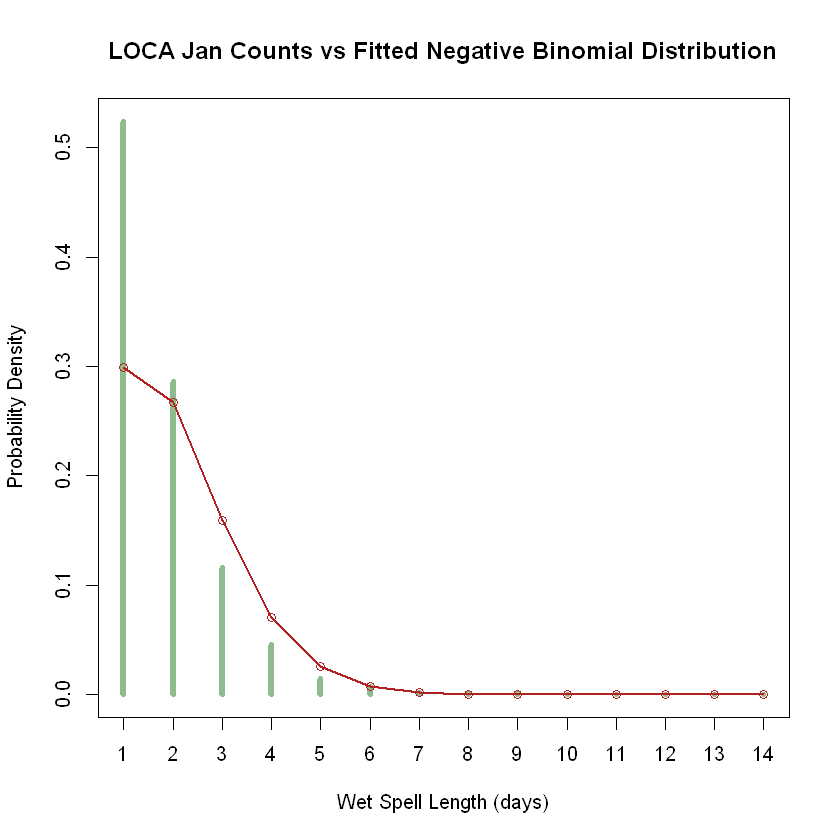

In [183]:
maxP <- max(dLOJan$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dJan_size, mu=LOfdNB_dJan_mu )
ttab <- table( dLOJan$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Jan Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

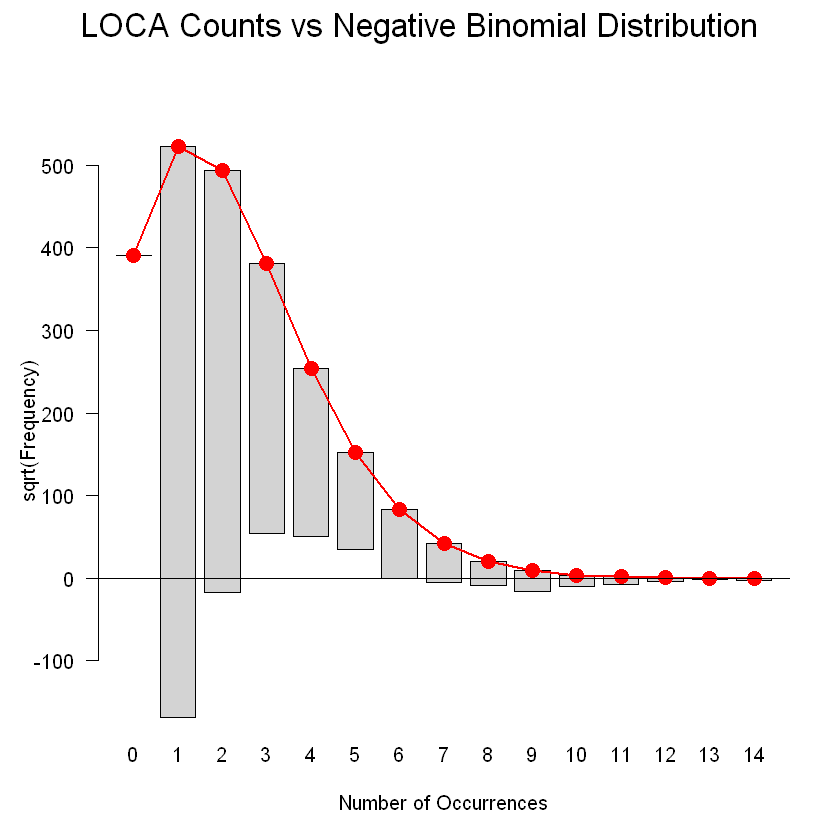

In [184]:
plot( LOgf_dJan, main="LOCA Counts vs Negative Binomial Distribution" )

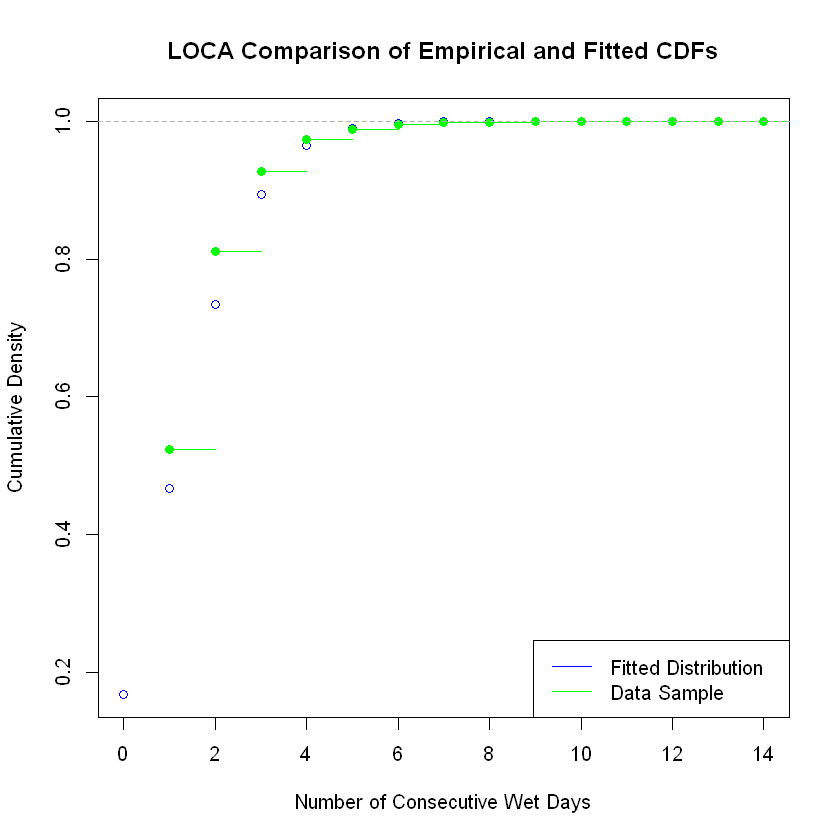

In [185]:
x <- seq(0,dLOJanMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dJan_mu, size=LOfdNB_dJan_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOJan$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

In [186]:
ks.test( dLOJan$Wet_Count, "pnbinom", mu=LOfdNB_dJan_mu, size=LOfdNB_dJan_size )


	One-sample Kolmogorov-Smirnov test

data:  dLOJan$Wet_Count
D = 0.46743, p-value < 2.2e-16
alternative hypothesis: two-sided


Generally, K-S test is better for continuous distributions.

[Kolmogorv-Smirnov Test](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/ks.test.html)

Null hypothesis that the true distribution function of x is equal to the hypothesized distribution function (one-sample case). This is a comparison of cumulative distribution functions, and the test statistic is the maximum difference in value, with the statistic in the "greater" alternative being D^+ = max[F_x(u) - F_y(u)]

Exact p-values are not available for the two-sample case if one-sided or in the presence of ties. If exact = NULL (the default), an exact p-value is computed if the sample size is less than 100 in the one-sample case and there are no ties, and if the product of the sample sizes is less than 10000 in the two-sample case. Otherwise, asymptotic distributions are used whose approximations may be inaccurate in small samples.

The Kolmogorov–Smirnov statistic quantifies a distance between the empirical distribution function of the sample and the cumulative distribution function of the reference distribution, or between the empirical distribution functions of two samples. The null distribution of this statistic is calculated under the null hypothesis that the sample is drawn from the reference distribution (in the one-sample case) or that the samples are drawn from the same distribution (in the two-sample case). In the one-sample case, the distribution considered under the null hypothesis may be continuous (see Section 2), purely discrete or mixed (see Section 2.2).

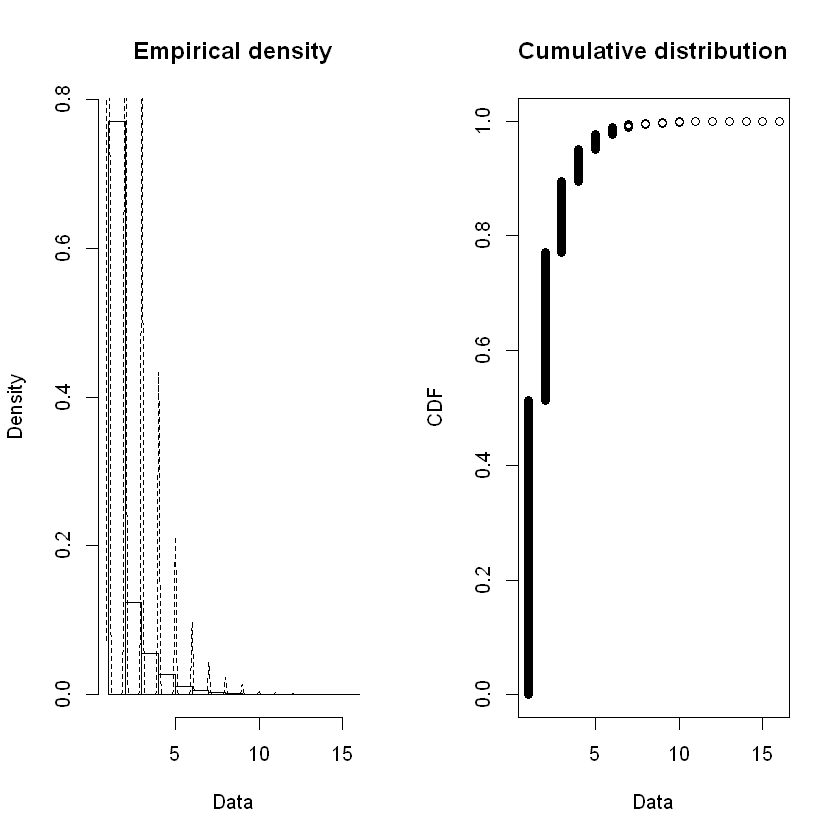

In [187]:
plotdist( dBCJan$Wet_Count, histo=TRUE, demp=TRUE )

In [188]:
BCfd_NB_dJan <- fitdist( dBCJan$Wet_Count, "nbinom" )
BCfd_GE_dJan <- fitdist( dBCJan$Wet_Count, "geom" )

In [189]:
summary( BCfd_NB_dJan )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
         estimate Std. Error
size 3.062845e+06        NaN
mu   1.918418e+00 0.00168558
Loglikelihood:  -1063498   AIC:  2127000   BIC:  2127022 
Correlation matrix:
     size  mu
size    1 NaN
mu    NaN   1


In [190]:
BCfdNB_dJan_size <- BCfd_NB_dJan$estimate[["size"]]
BCfdNB_dJan_mu <- BCfd_NB_dJan$estimate[["mu"]]
cat("BCCA Jan size: ", BCfdNB_dJan_size, "\n", "BCCA Jan mu: ", BCfdNB_dJan_mu, "\n")

BCCA Jan size:  3062845 
 BCCA Jan mu:  1.918418 


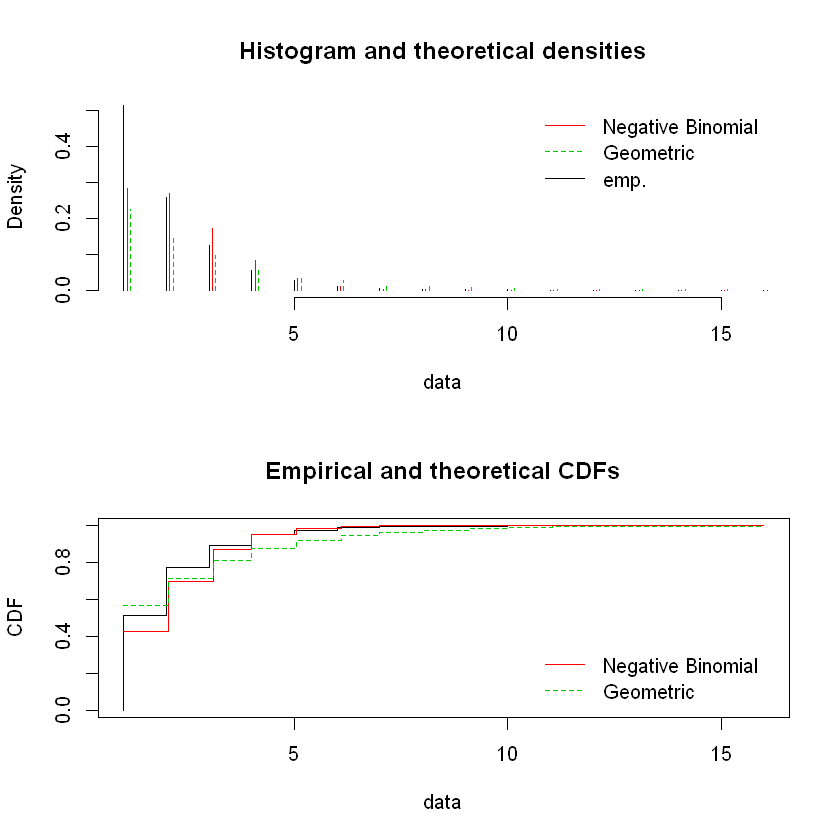

In [191]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dJan, BCfd_GE_dJan), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dJan, BCfd_GE_dJan), legendtext=plot.legend )

In [192]:
BCstatRes <- gofstat( list(BCfd_NB_dJan, BCfd_GE_dJan), fitnames=c("Negative Binomial", "Geometric") )

In [193]:
print(BCstatRes)

Chi-squared statistic:  69018.51 96965.17 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    346201            289375.6958     383490.081
<= 2    174486            182461.3799      99980.696
<= 3     83565            116679.0954      65720.698
<= 4     37349             55959.8520      43200.441
<= 5     18060             21470.8970      28397.113
<= 6      7793              6865.0344      18666.385
<= 7      3712              1881.4323      12270.047
<= 8      1959               451.1726       8065.517
> 8       2138               118.4406      15472.022

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2127000   2533378
Bayesian Information Criterion           2127022   2533389


In [194]:
BCfdNB_dJan_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [195]:
BCfdNB_dJan_p = BCfdNB_dJan_size / (BCfdNB_dJan_size + BCfdNB_dJan_mu)
cat("BCCA prob: ", BCfdNB_dJan_p)

BCCA prob:  0.9999994

In [196]:
# add to our tracking dataframe
BCMonDistDF[1, ] <- list( 1, dBCJanMean, dBCJanBNr, BCfdNB_dJan_p, BCfdNB_dJan_mu, BCfdNB_dJan_size,
                          BCfdNB_dJan_pvalue )

In [197]:
BCgf_dJan <- goodfit( dBCJan$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dJan_size, prob=BCfdNB_dJan_p) )

In [198]:
summary( BCgf_dJan )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          942023.2 16        0
Likelihood Ratio 334365.5 15        0


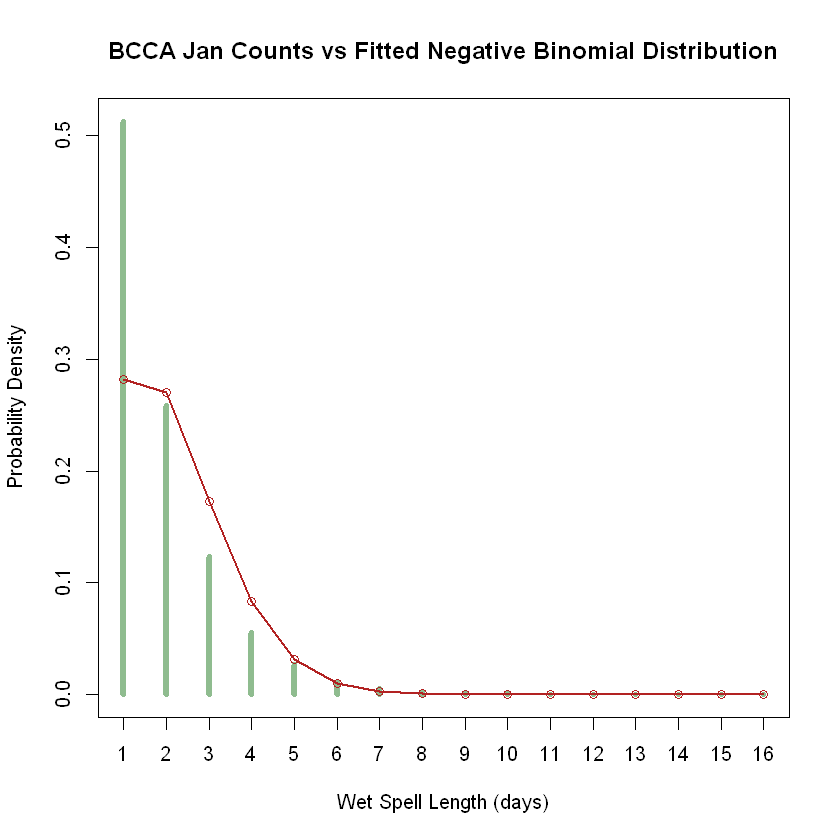

In [199]:
maxP <- max(dBCJan$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dJan_size, mu=BCfdNB_dJan_mu )
ttab <- table( dBCJan$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Jan Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

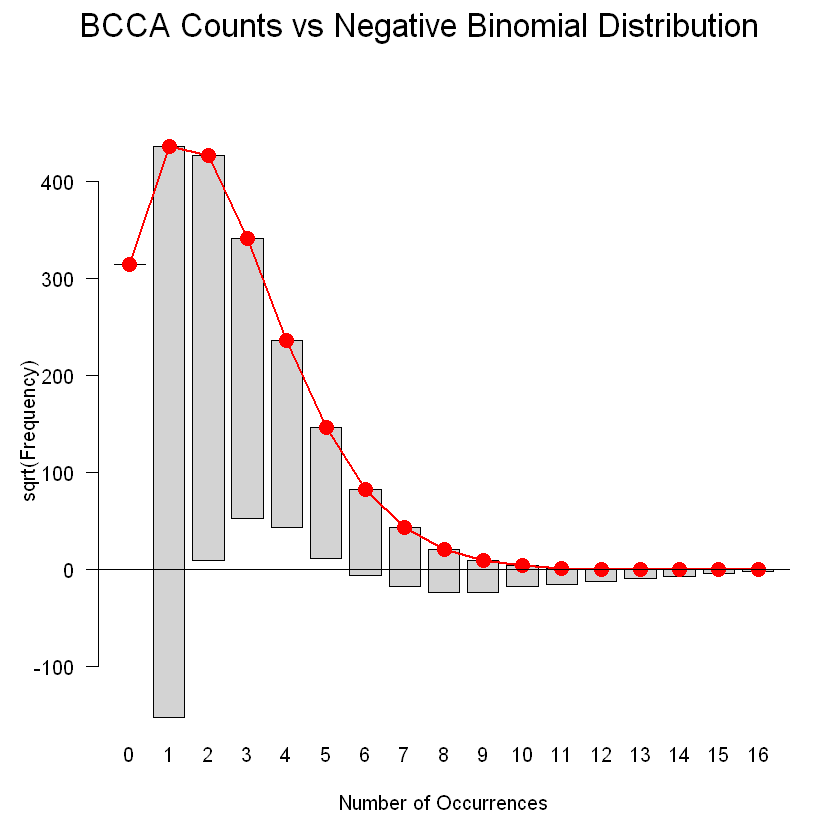

In [200]:
plot( BCgf_dJan, main="BCCA Counts vs Negative Binomial Distribution" )

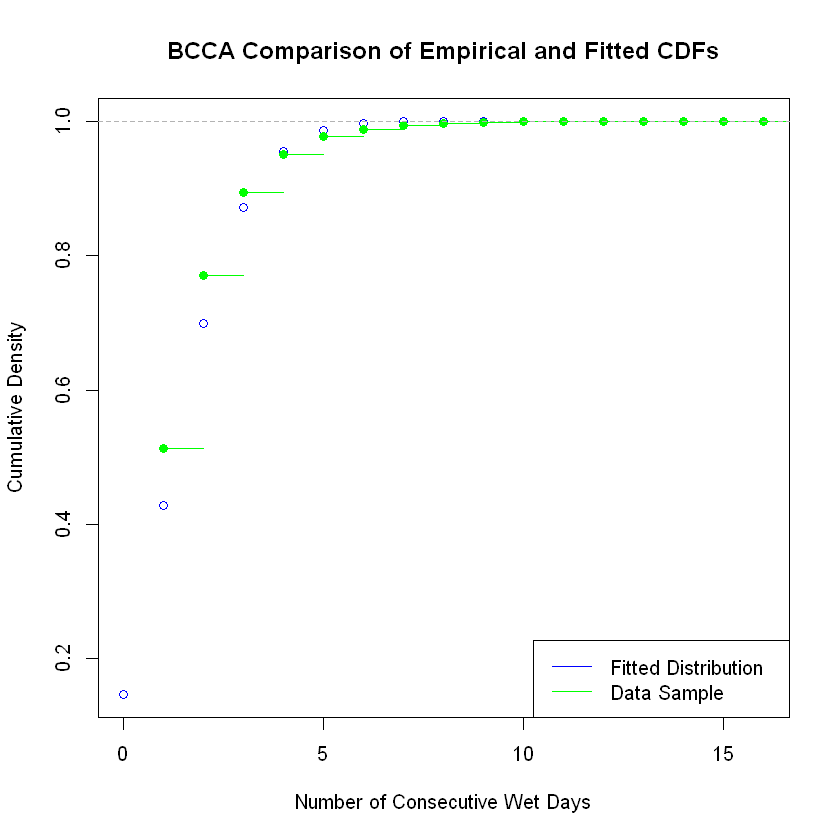

In [201]:
x <- seq(0,dBCJanMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dJan_mu, size=BCfdNB_dJan_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCJan$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

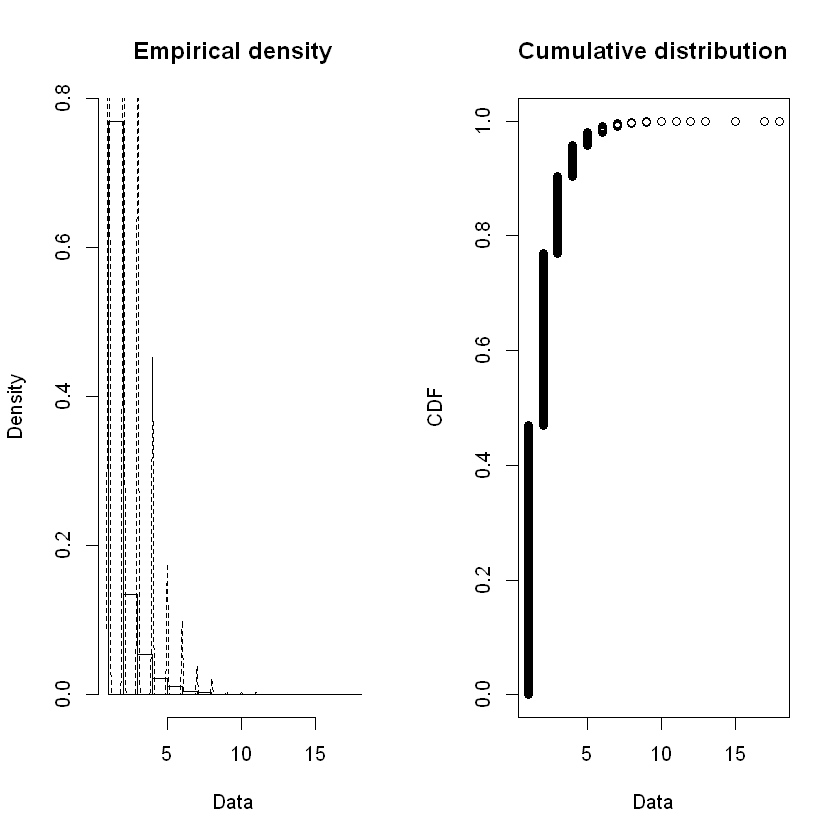

In [202]:
plotdist( dLOFeb$Wet_Count, histo=TRUE, demp=TRUE )

In [203]:
LOfd_NB_dFeb <- fitdist( dLOFeb$Wet_Count, "nbinom" )
LOfd_GE_dFeb <- fitdist( dLOFeb$Wet_Count, "geom" )

In [204]:
LOfdNB_dFeb_size <- LOfd_NB_dFeb$estimate[["size"]]
LOfdNB_dFeb_mu <- LOfd_NB_dFeb$estimate[["mu"]]
cat("LOCA Feb size: ", LOfdNB_dFeb_size, "\n", "LOCA Feb mu: ", LOfdNB_dFeb_mu, "\n")

LOCA Feb size:  4317364 
 LOCA Feb mu:  1.935439 


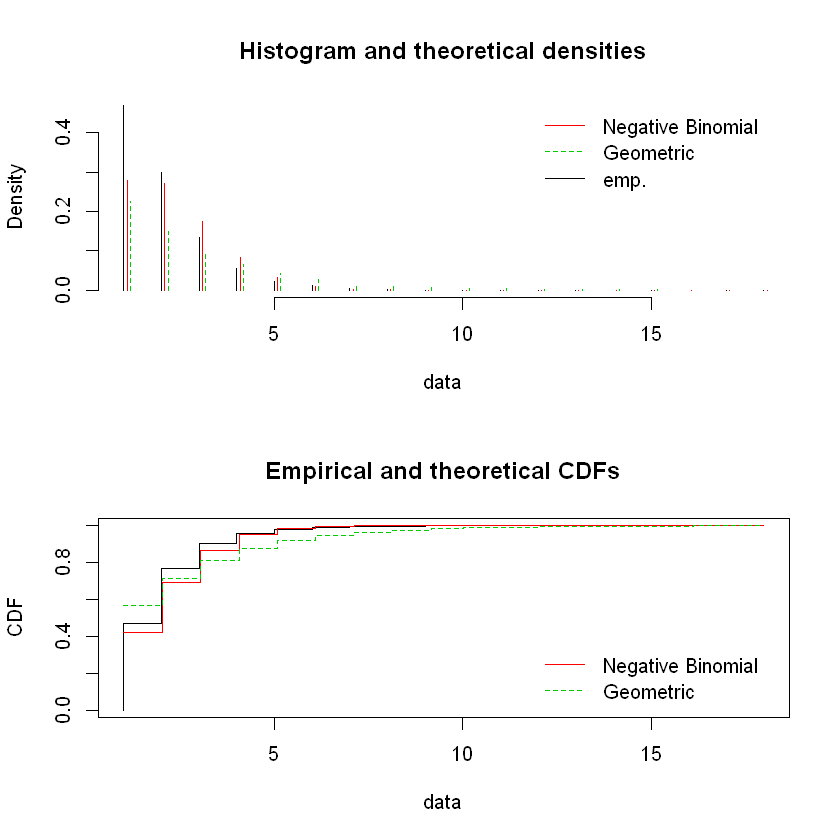

In [205]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dFeb, LOfd_GE_dFeb), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dFeb, LOfd_GE_dFeb), legendtext=plot.legend )

In [206]:
LOstatRes <- gofstat( list(LOfd_NB_dFeb, LOfd_GE_dFeb), fitnames=c("Negative Binomial", "Geometric") )

In [207]:
print( LOstatRes )

Chi-squared statistic:  45952.85 238389.6 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    451267            407711.4066      543887.77
<= 2    289082            260140.8434      142485.01
<= 3    129748            167828.8913       93942.89
<= 4     52144             81205.6545       61938.20
<= 5     20656             31433.7290       40836.95
<= 6     10671             10139.6833       26924.52
<= 7      4640              2803.5363       17751.81
<= 8      2415               678.2599       11704.08
> 8       1499               179.9957       22650.75

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2979463   3623253
Bayesian Information Criterion           2979486   3623265


In [208]:
LOfdNB_dFeb_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [209]:
LOfdNB_dFeb_p = LOfdNB_dFeb_size / (LOfdNB_dFeb_size + LOfdNB_dFeb_mu)
cat("LOCA prob: ", LOfdNB_dFeb_p)

LOCA prob:  0.9999996

In [210]:
# add to our tracking dataframe
LOMonDistDF[2, ] <- list( 2, dLOFebMean, dLOFebBNr, LOfdNB_dFeb_p, LOfdNB_dFeb_mu, LOfdNB_dFeb_size,
                          LOfdNB_dFeb_pvalue )

In [211]:
LOgf_dFeb <- goodfit( dLOFeb$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dFeb_size, prob=LOfdNB_dFeb_p) )

In [212]:
summary( LOgf_dFeb )


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          8909110.2 18        0
Likelihood Ratio  419817.8 15        0


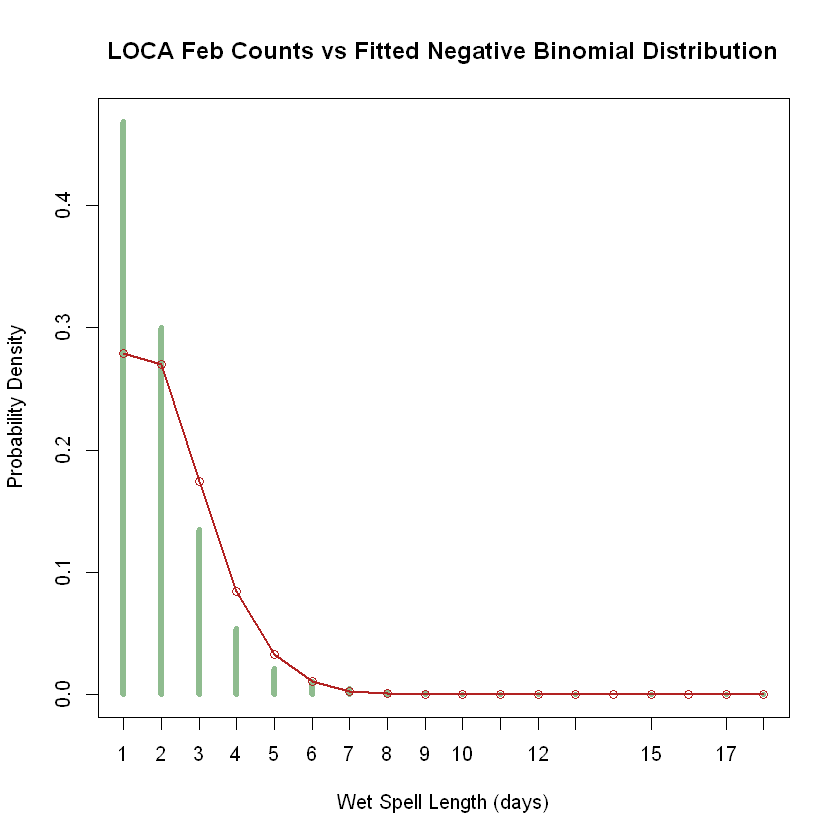

In [213]:
maxP <- max(dLOFeb$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dFeb_size, mu=LOfdNB_dFeb_mu )
ttab <- table( dLOFeb$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Feb Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

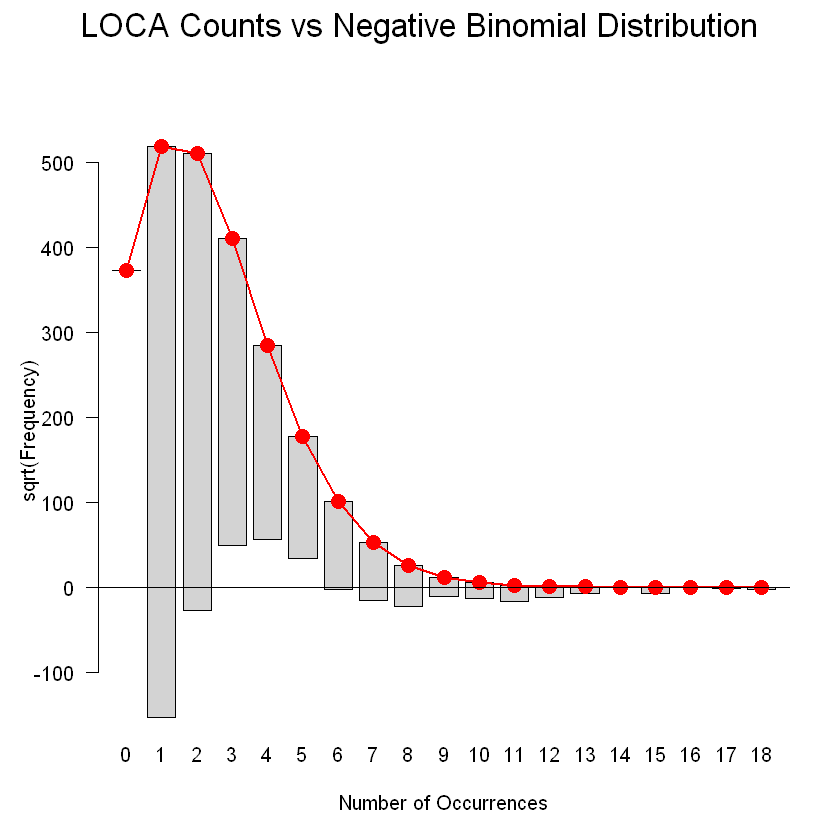

In [214]:
plot( LOgf_dFeb, main="LOCA Counts vs Negative Binomial Distribution" )

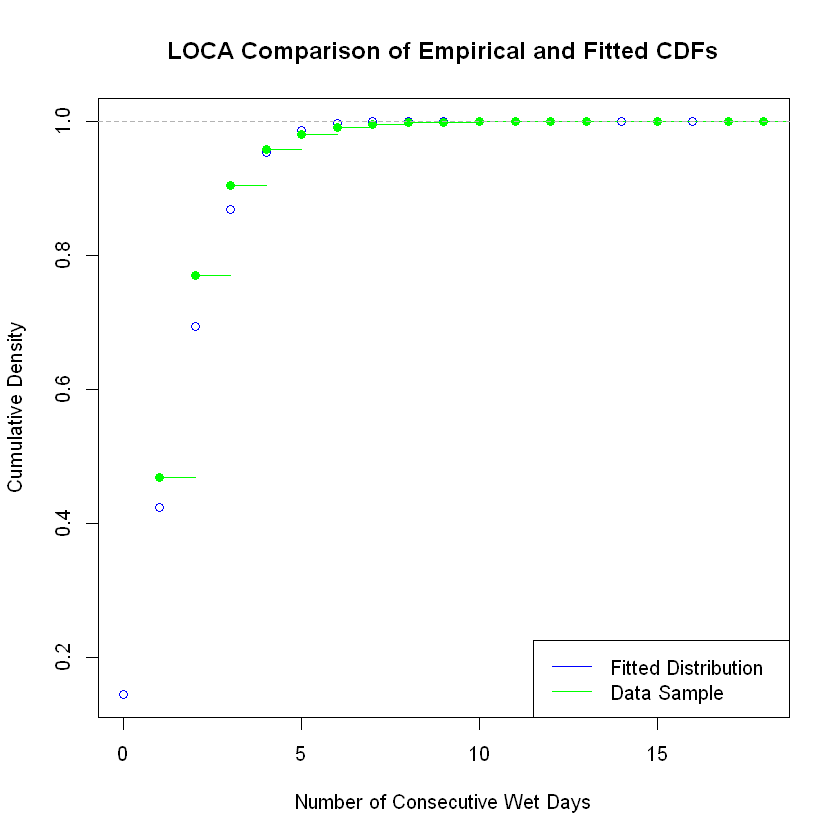

In [215]:
x <- seq(0,dLOFebMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dFeb_mu, size=LOfdNB_dFeb_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOFeb$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

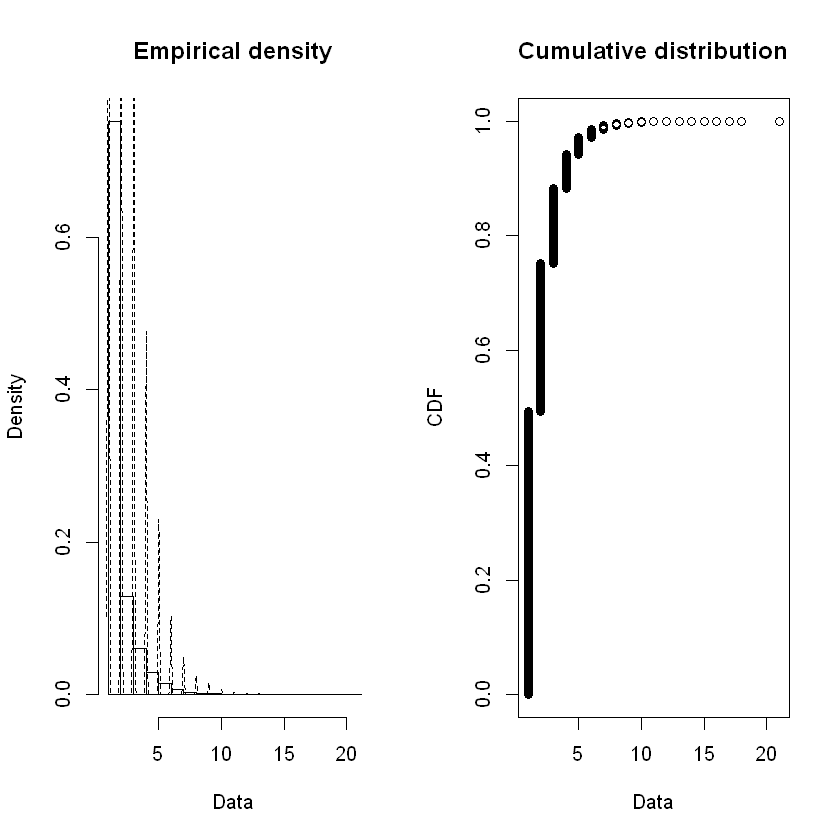

In [216]:
plotdist( dBCFeb$Wet_Count, histo=TRUE, demp=TRUE )

In [217]:
BCfd_NB_dFeb <- fitdist( dBCFeb$Wet_Count, "nbinom" )
BCfd_GE_dFeb <- fitdist( dBCFeb$Wet_Count, "geom" )

In [218]:
summary( BCfd_NB_dFeb )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
         estimate  Std. Error
size 1.999106e+05 1.204168892
mu   1.985985e+00 0.001713256
Loglikelihood:  -1091142   AIC:  2182289   BIC:  2182312 
Correlation matrix:
              size            mu
size  1.000000e+00 -1.080768e-06
mu   -1.080768e-06  1.000000e+00


In [219]:
BCfdNB_dFeb_size <- BCfd_NB_dFeb$estimate[["size"]]
BCfdNB_dFeb_mu <- BCfd_NB_dFeb$estimate[["mu"]]
cat("BCCA Feb size: ", BCfdNB_dFeb_size, "\n", "BCCA Feb mu: ", BCfdNB_dFeb_mu, "\n")

BCCA Feb size:  199910.6 
 BCCA Feb mu:  1.985985 


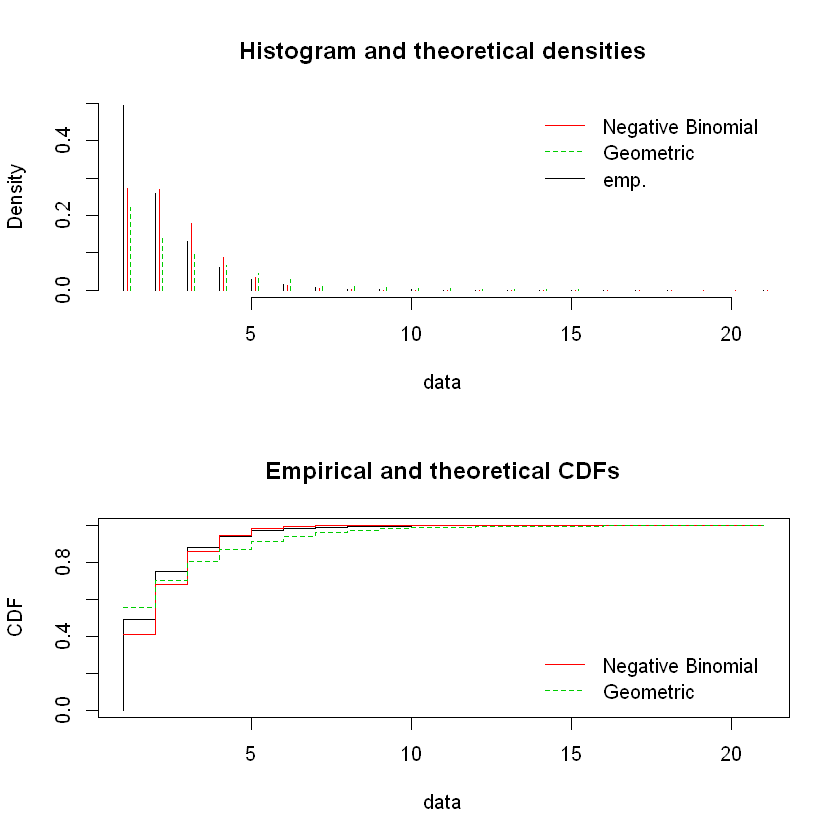

In [220]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dFeb, BCfd_GE_dFeb), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dFeb, BCfd_GE_dFeb), legendtext=plot.legend )

In [221]:
BCstatRes <- gofstat( list(BCfd_NB_dFeb, BCfd_GE_dFeb), fitnames=c("Negative Binomial", "Geometric") )

In [222]:
print(BCstatRes)

Chi-squared statistic:  75423.82 98543.48 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    334312            277330.5870     377402.111
<= 2    175036            183159.0445     100253.523
<= 3     87634            121250.3540      66674.948
<= 4     40859             60200.6384      44343.067
<= 5     19922             23911.7487      29490.951
<= 6      9589              7914.8467      19613.352
<= 7      4558              2245.5827      13044.122
<= 8      2202               557.4756       8675.168
> 8       2611               152.7224      17225.758

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2182289   2576561
Bayesian Information Criterion           2182312   2576572


In [223]:
BCfdNB_dFeb_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [224]:
BCfdNB_dFeb_p = BCfdNB_dFeb_size / (BCfdNB_dFeb_size + BCfdNB_dFeb_mu)
cat("BCCA prob: ", BCfdNB_dFeb_p)

BCCA prob:  0.9999901

In [225]:
# add to our tracking dataframe
BCMonDistDF[2, ] <- list( 2, dBCFebMean, dBCFebBNr, BCfdNB_dFeb_p, BCfdNB_dFeb_mu, BCfdNB_dFeb_size,
                          BCfdNB_dFeb_pvalue )

In [226]:
BCgf_dFeb <- goodfit( dBCFeb$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dFeb_size, prob=BCfdNB_dFeb_p) )

In [227]:
summary( BCgf_dFeb )


	 Goodness-of-fit test for nbinomial distribution

                          X^2 df P(> X^2)
Pearson          2508978848.9 21        0
Likelihood Ratio     320288.2 18        0


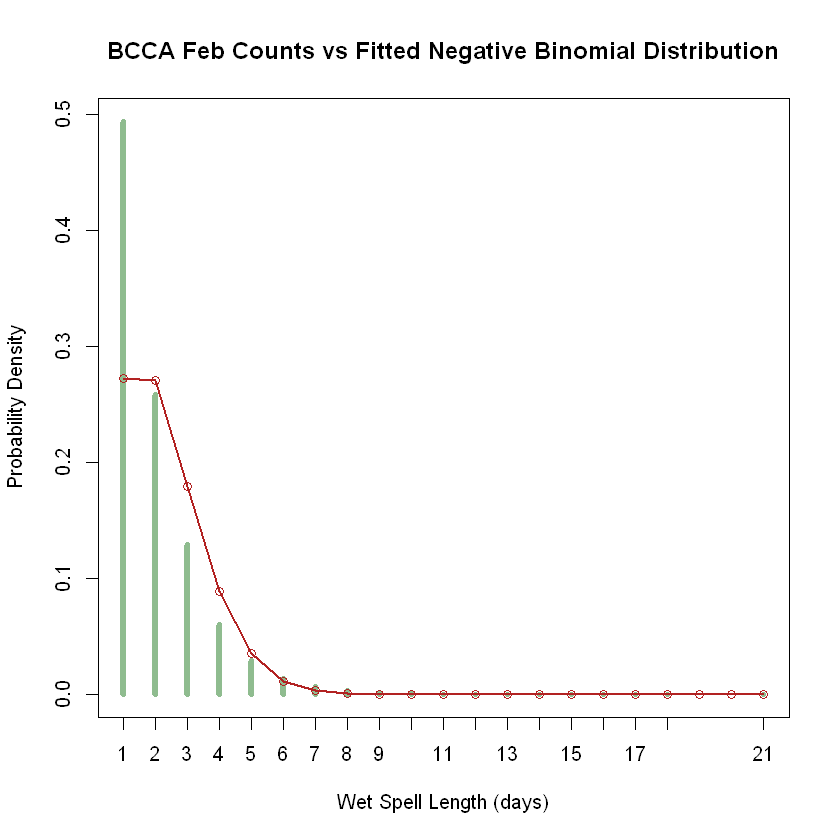

In [228]:
maxP <- max(dBCFeb$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dFeb_size, mu=BCfdNB_dFeb_mu )
ttab <- table( dBCFeb$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Feb Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

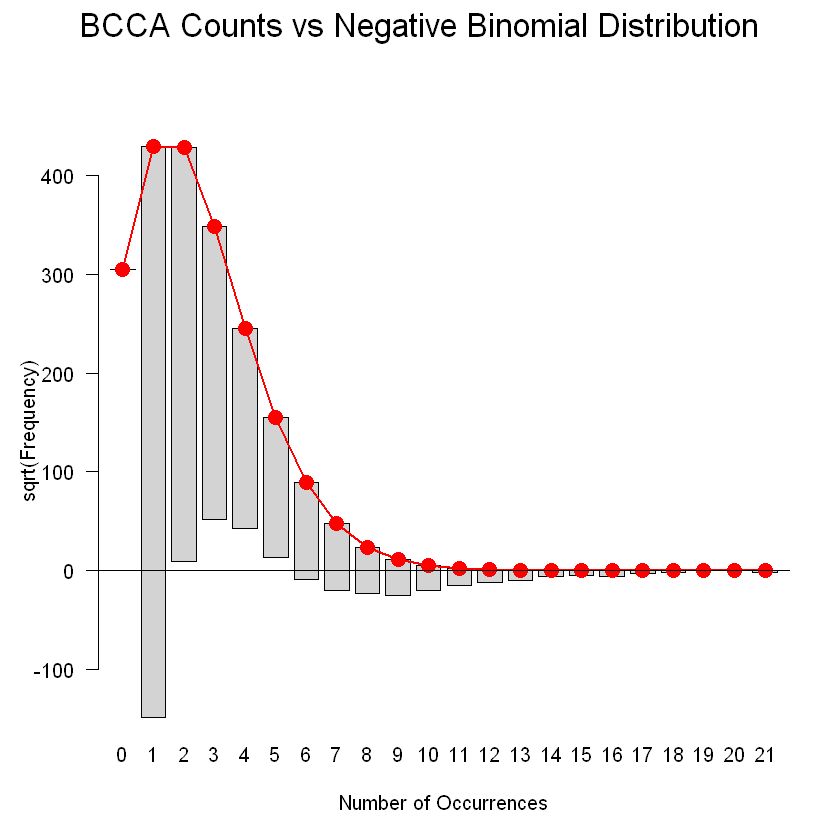

In [229]:
plot( BCgf_dFeb, main="BCCA Counts vs Negative Binomial Distribution" )

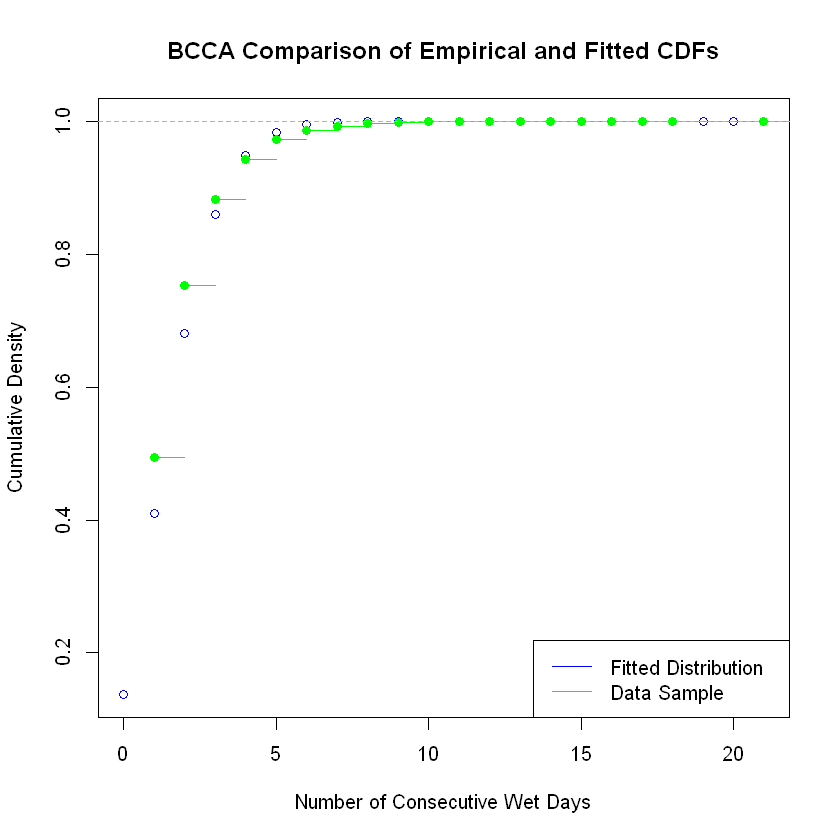

In [230]:
x <- seq(0,dBCFebMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dFeb_mu, size=BCfdNB_dFeb_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCFeb$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

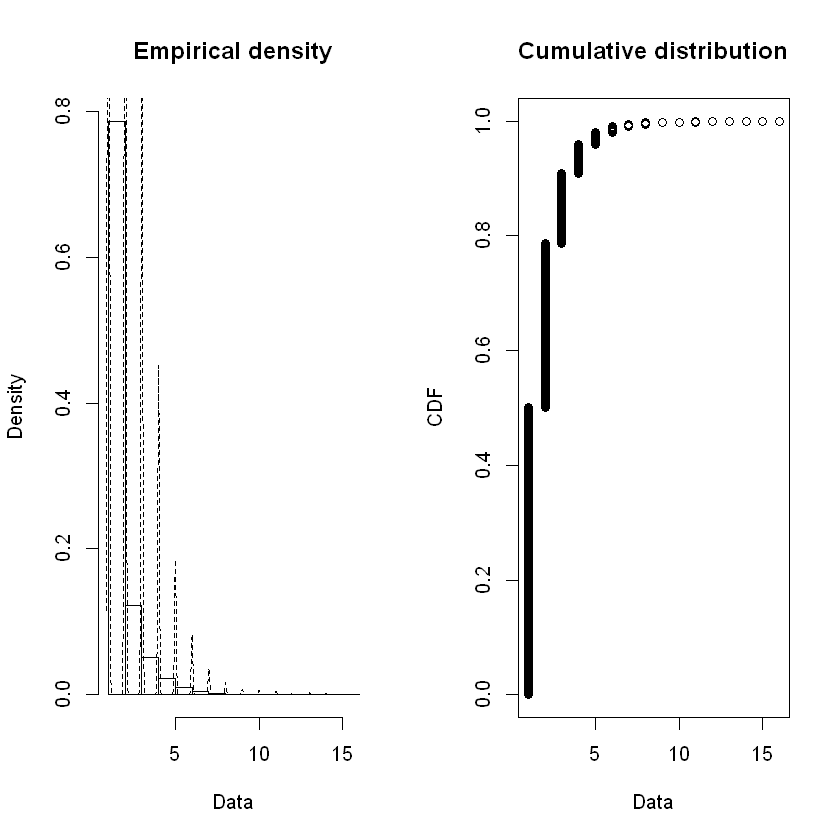

In [231]:
plotdist( dLOMar$Wet_Count, histo=TRUE, demp=TRUE )

In [232]:
LOfd_NB_dMar <- fitdist( dLOMar$Wet_Count, "nbinom" )
LOfd_GE_dMar <- fitdist( dLOMar$Wet_Count, "geom" )

In [233]:
LOfdNB_dMar_size <- LOfd_NB_dMar$estimate[["size"]]
LOfdNB_dMar_mu <- LOfd_NB_dMar$estimate[["mu"]]
cat("LOCA Mar size: ", LOfdNB_dMar_size, "\n", "LOCA Mar mu: ", LOfdNB_dMar_mu, "\n")

LOCA Mar size:  2546743 
 LOCA Mar mu:  1.885269 


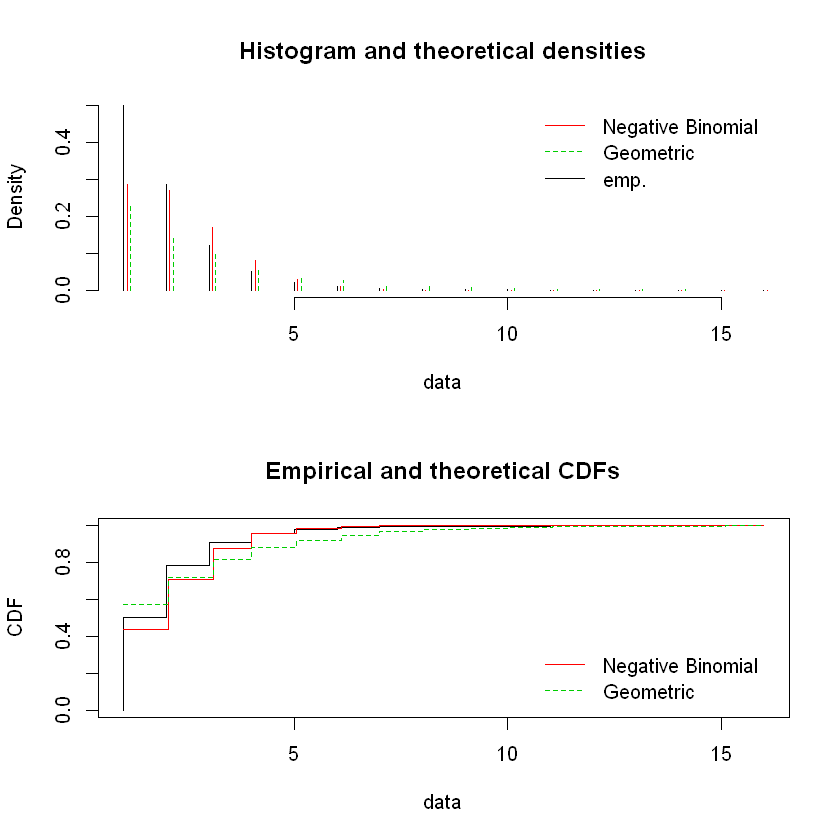

In [234]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dMar, LOfd_GE_dMar), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dMar, LOfd_GE_dMar), legendtext=plot.legend )

In [235]:
LOstatRes <- gofstat( list(LOfd_NB_dMar, LOfd_GE_dMar), fitnames=c("Negative Binomial", "Geometric") )

In [236]:
print( LOstatRes )

Chi-squared statistic:  177387.9 205654.5 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    510074           446350.79922      584081.85
<= 2    291677           274919.97788      150812.51
<= 3    124076           172766.01505       98538.54
<= 4     51829            81427.62462       64383.54
<= 5     22452            30702.61545       42067.20
<= 6     10011             9647.12498       27486.05
<= 7      4276             2598.20741       17958.96
<= 9      2785              740.55067       19400.98
> 9       2002               29.08473       14452.37

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           3141782   3795013
Bayesian Information Criterion           3141805   3795025


In [237]:
LOfdNB_dMar_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [238]:
LOfdNB_dMar_p = LOfdNB_dMar_size / (LOfdNB_dMar_size + LOfdNB_dMar_mu)
cat("LOCA prob: ", LOfdNB_dMar_p)

LOCA prob:  0.9999993

In [239]:
# add to our tracking dataframe
LOMonDistDF[3, ] <- list( 3, dLOMarMean, dLOMarBNr, LOfdNB_dMar_p, LOfdNB_dMar_mu, LOfdNB_dMar_size,
                          LOfdNB_dMar_pvalue )

In [240]:
LOgf_dMar <- goodfit( dLOMar$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dMar_size, prob=LOfdNB_dMar_p) )

In [241]:
summary( LOgf_dMar )


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          8038694.2 16        0
Likelihood Ratio  496202.2 15        0


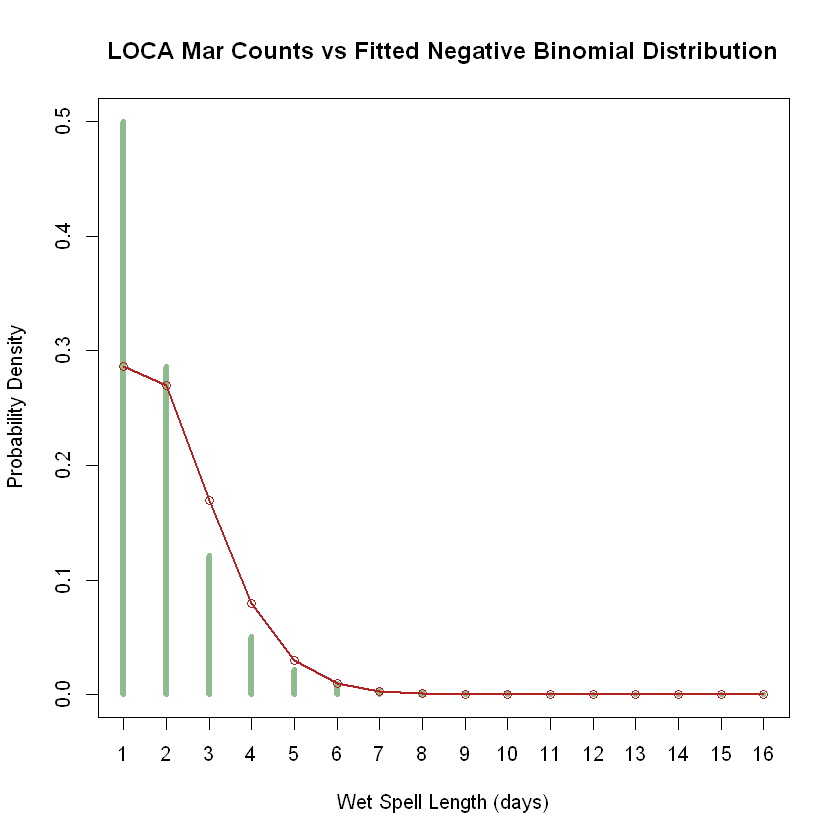

In [242]:
maxP <- max(dLOMar$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dMar_size, mu=LOfdNB_dMar_mu )
ttab <- table( dLOMar$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Mar Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

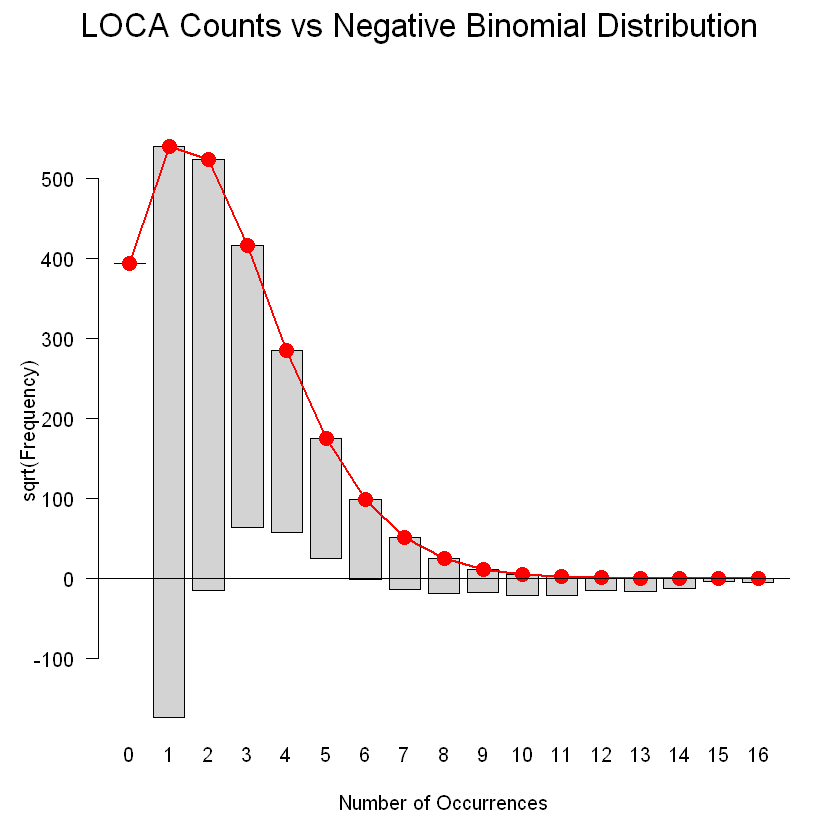

In [243]:
plot( LOgf_dMar, main="LOCA Counts vs Negative Binomial Distribution" )

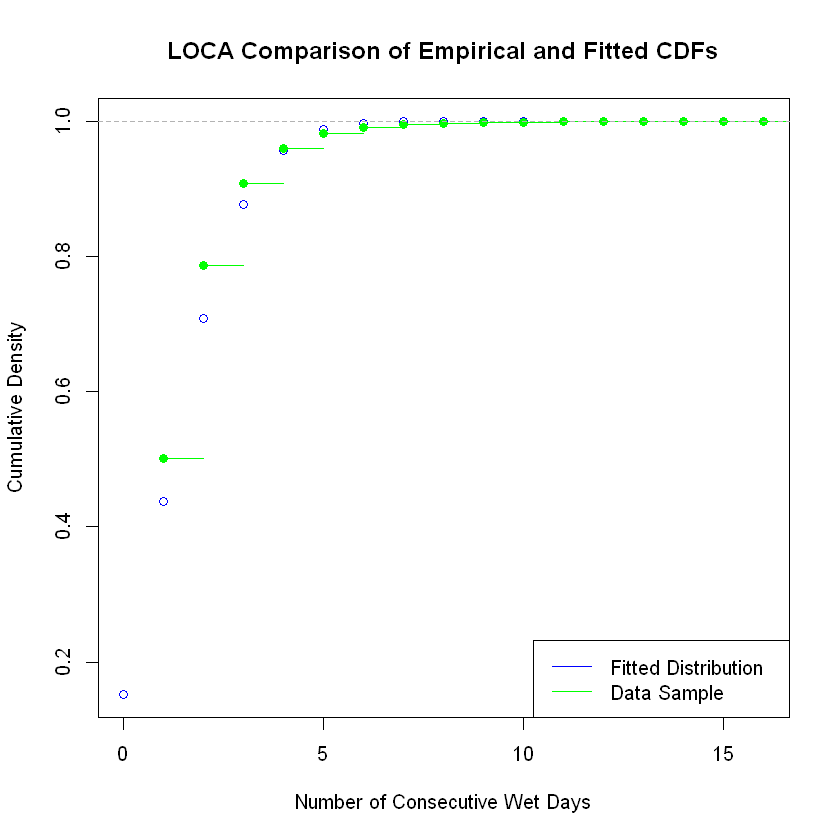

In [244]:
x <- seq(0,dLOMarMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dMar_mu, size=LOfdNB_dMar_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOMar$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

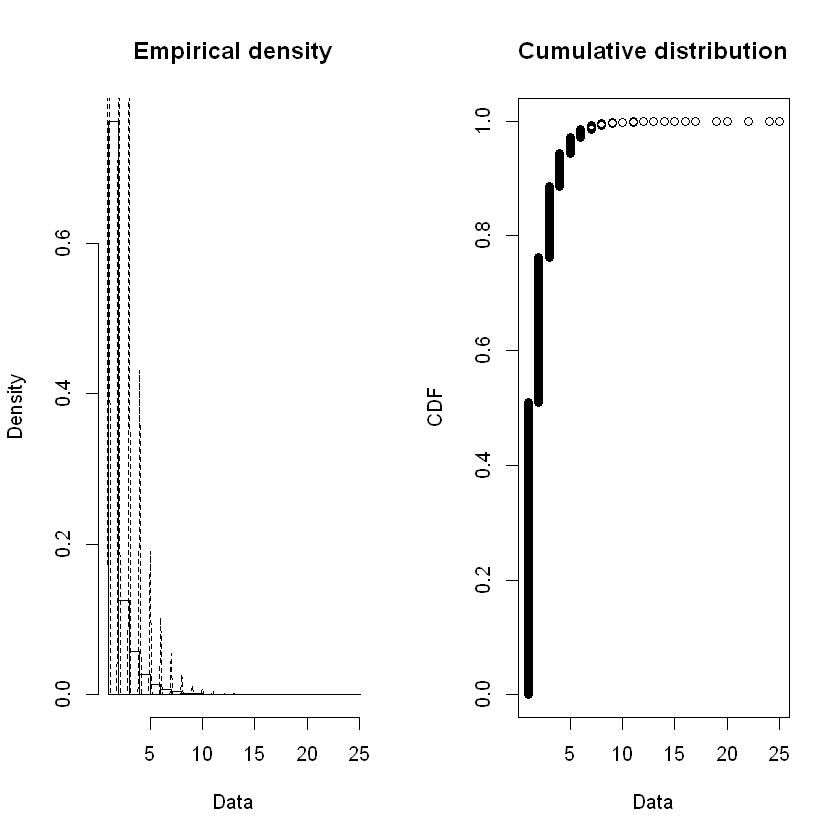

In [245]:
plotdist( dBCMar$Wet_Count, histo=TRUE, demp=TRUE )

In [246]:
BCfd_NB_dMar <- fitdist( dBCMar$Wet_Count, "nbinom" )
BCfd_GE_dMar <- fitdist( dBCMar$Wet_Count, "geom" )

In [247]:
summary( BCfd_NB_dMar )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
         estimate  Std. Error
size 41284.735942 2.141539256
mu       1.956569 0.001595643
Loglikelihood:  -1235544   AIC:  2471091   BIC:  2471114 
Correlation matrix:
              size            mu
size  1.000000e+00 -1.819964e-05
mu   -1.819964e-05  1.000000e+00


In [248]:
BCfdNB_dMar_size <- BCfd_NB_dMar$estimate[["size"]]
BCfdNB_dMar_mu <- BCfd_NB_dMar$estimate[["mu"]]
cat("BCCA Mar size: ", BCfdNB_dMar_size, "\n", "BCCA Mar mu: ", BCfdNB_dMar_mu, "\n")

BCCA Mar size:  41284.74 
 BCCA Mar mu:  1.956569 


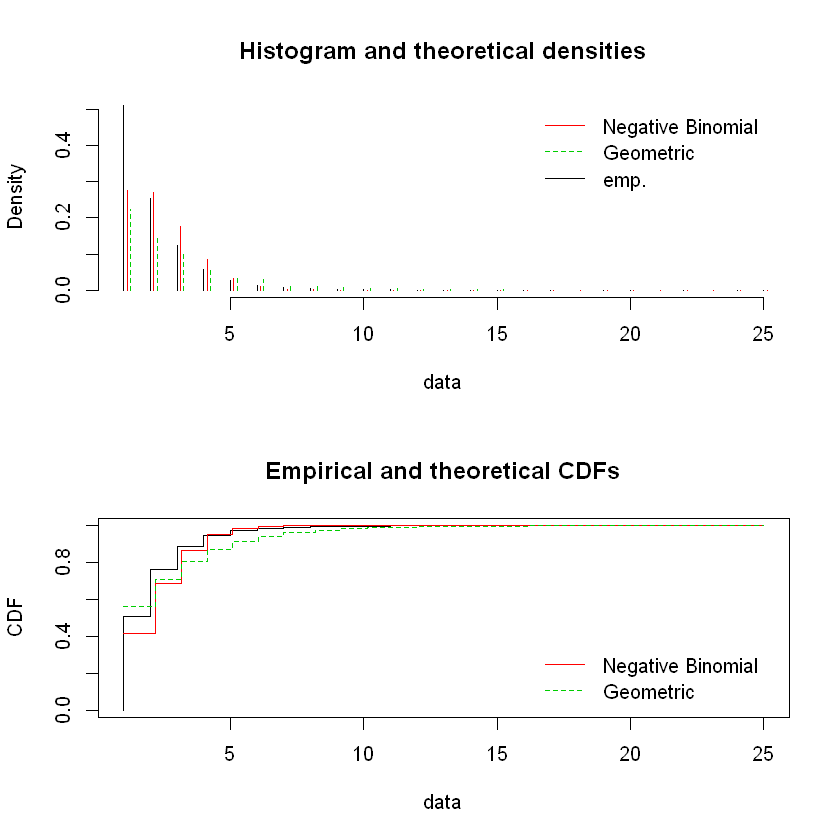

In [249]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dMar, BCfd_GE_dMar), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dMar, BCfd_GE_dMar), legendtext=plot.legend )

In [250]:
BCstatRes <- gofstat( list(BCfd_NB_dMar, BCfd_GE_dMar), fitnames=c("Negative Binomial", "Geometric") )

In [251]:
print(BCstatRes)

Chi-squared statistic:  282951 100244.9 
Degree of freedom of the Chi-squared distribution:  7 8 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     391894           3.211876e+05     432015.213
<= 2     193935           2.079285e+05     113845.777
<= 3      95742           1.356090e+05      75336.975
<= 4      44548           6.633376e+04      49853.933
<= 5      21064           2.595860e+04      32990.635
<= 6      10243           8.465590e+03      21831.417
<= 7       5072           2.366448e+03      14446.850
<= 8       2895           5.788355e+02       9560.144
<= 10      2145           1.504839e+02      10512.845
> 10       1046           5.220948e+00       8190.211

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2471091   2907842
Bayesian Information Criterion           2471114   2907853


In [252]:
BCfdNB_dMar_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [253]:
BCfdNB_dMar_p = BCfdNB_dMar_size / (BCfdNB_dMar_size + BCfdNB_dMar_mu)
cat("BCCA prob: ", BCfdNB_dMar_p)

BCCA prob:  0.9999526

In [254]:
# add to our tracking dataframe
BCMonDistDF[3, ] <- list( 3, dBCMarMean, dBCMarBNr, BCfdNB_dMar_p, BCfdNB_dMar_mu, BCfdNB_dMar_size,
                          BCfdNB_dMar_pvalue )

In [255]:
BCgf_dMar <- goodfit( dBCMar$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dMar_size, prob=BCfdNB_dMar_p) )

In [256]:
summary( BCgf_dMar )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson               NaN 25      NaN
Likelihood Ratio 388301.1 21        0


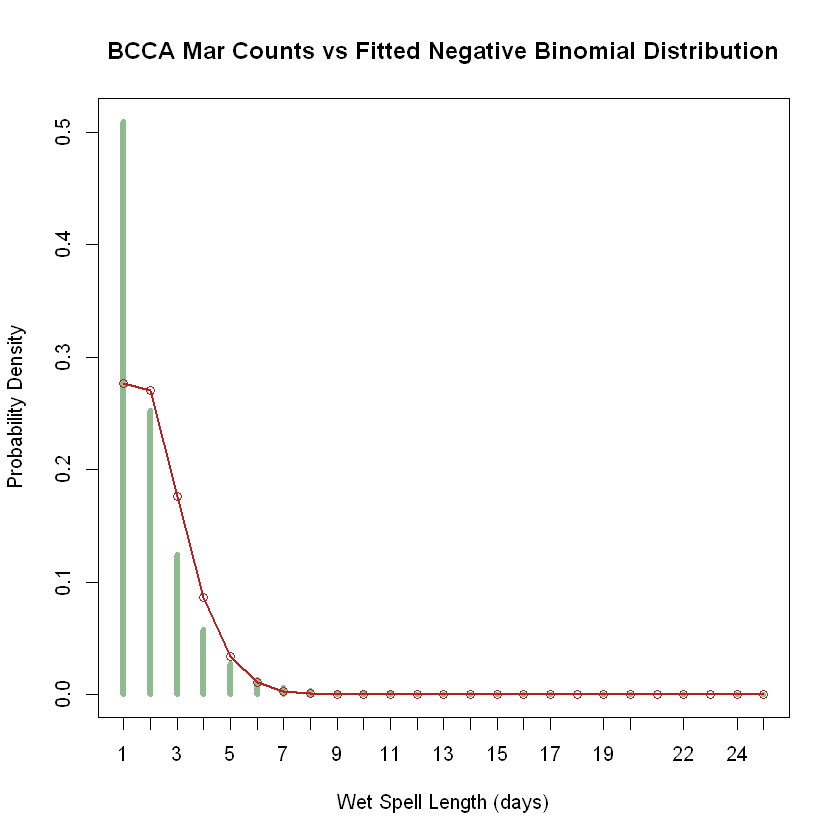

In [257]:
maxP <- max(dBCMar$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dMar_size, mu=BCfdNB_dMar_mu )
ttab <- table( dBCMar$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Mar Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

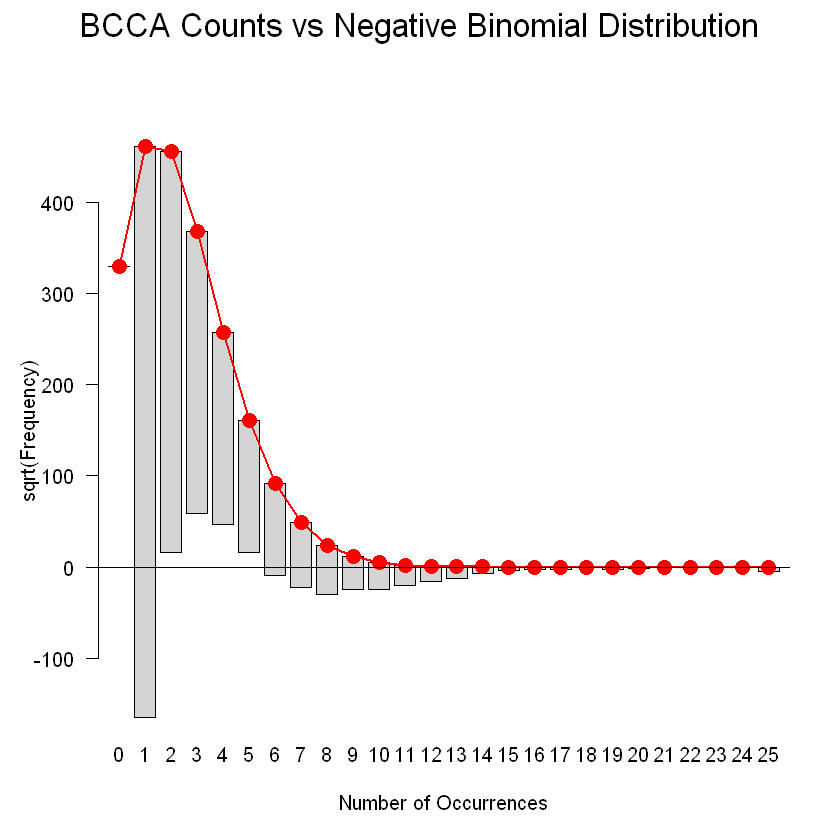

In [258]:
plot( BCgf_dMar, main="BCCA Counts vs Negative Binomial Distribution" )

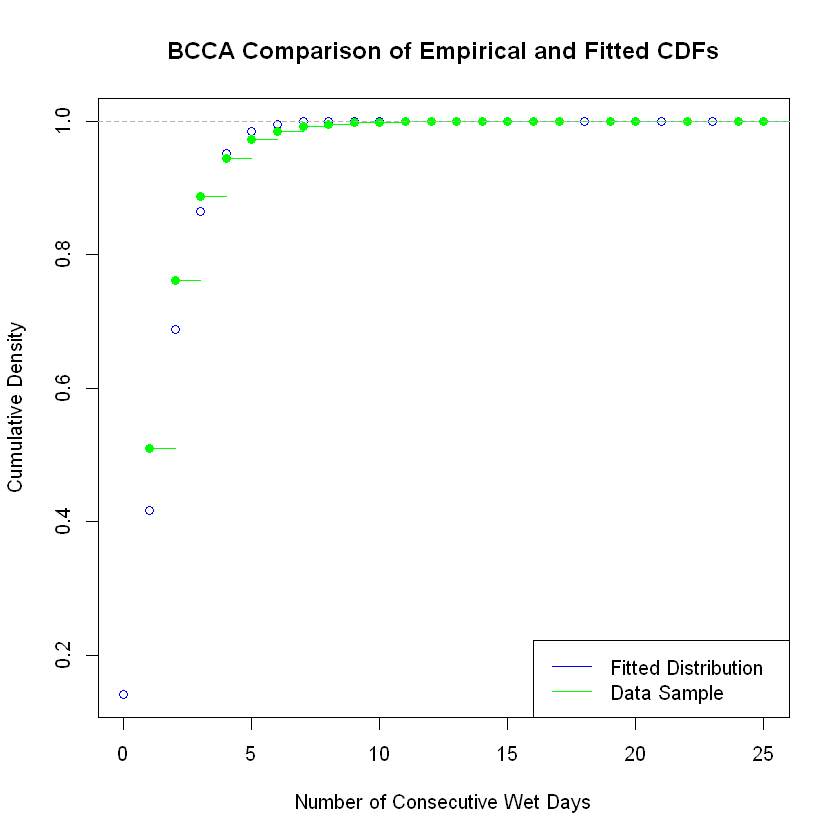

In [259]:
x <- seq(0,dBCMarMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dMar_mu, size=BCfdNB_dMar_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCMar$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

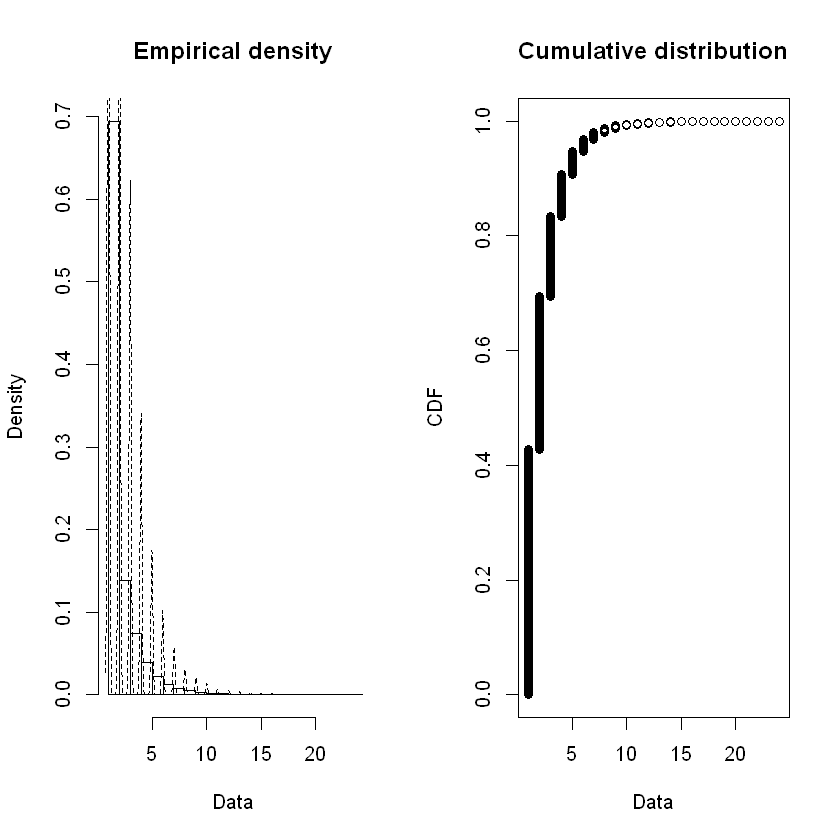

In [260]:
plotdist( dLOApr$Wet_Count, histo=TRUE, demp=TRUE )

In [261]:
LOfd_NB_dApr <- fitdist( dLOApr$Wet_Count, "nbinom" )
LOfd_GE_dApr <- fitdist( dLOApr$Wet_Count, "geom" )

In [262]:
LOfdNB_dApr_size <- LOfd_NB_dApr$estimate[["size"]]
LOfdNB_dApr_mu <- LOfd_NB_dApr$estimate[["mu"]]
cat("LOCA Apr size: ", LOfdNB_dApr_size, "\n", "LOCA Apr mu: ", LOfdNB_dApr_mu, "\n")

LOCA Apr size:  11.17116 
 LOCA Apr mu:  2.277092 


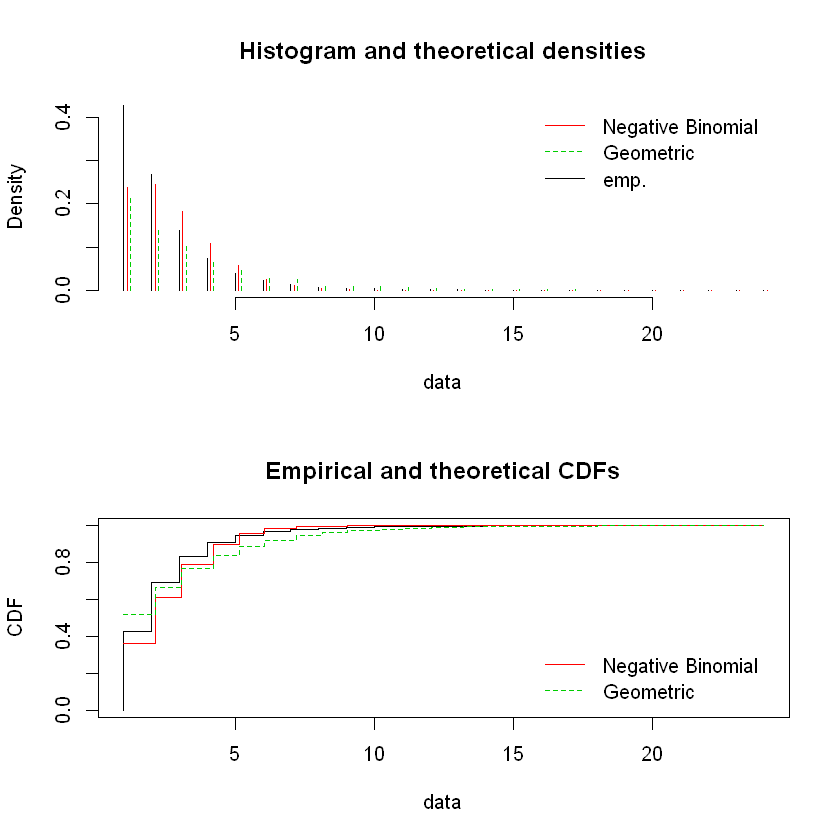

In [263]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dApr, LOfd_GE_dApr), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dApr, LOfd_GE_dApr), legendtext=plot.legend )

In [264]:
LOstatRes <- gofstat( list(LOfd_NB_dApr, LOfd_GE_dApr), fitnames=c("Negative Binomial", "Geometric") )

In [265]:
print( LOstatRes )

Chi-squared statistic:  382795.4 191673.2 
Degree of freedom of the Chi-squared distribution:  9 10 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     508152           432735.81874     614832.861
<= 2     317563           291692.37379     175154.634
<= 3     164944           216841.60755     121708.613
<= 4      88393           130077.68327      84570.908
<= 5      46433            66829.21132      58765.262
<= 6      25544            30497.97555      40833.853
<= 7      14776            12667.39619      28373.966
<= 8       8222             4871.85958      19716.041
<= 9       5387             1757.17648      13699.963
<= 10      3682              600.15163       9519.608
<= 12      3043              256.76712      11211.238
> 12       2715               25.97878      10467.052

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           4238927   4793453
Bayesia

In [266]:
LOfdNB_dApr_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [267]:
LOfdNB_dApr_p = LOfdNB_dApr_size / (LOfdNB_dApr_size + LOfdNB_dApr_mu)
cat("LOCA prob: ", LOfdNB_dApr_p)

LOCA prob:  0.8306775

In [268]:
# add to our tracking dataframe
LOMonDistDF[4, ] <- list( 4, dLOAprMean, dLOAprBNr, LOfdNB_dApr_p, LOfdNB_dApr_mu, LOfdNB_dApr_size,
                          LOfdNB_dApr_pvalue )

In [269]:
LOgf_dApr <- goodfit( dLOApr$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dApr_size, prob=LOfdNB_dApr_p) )

In [270]:
summary( LOgf_dApr )


	 Goodness-of-fit test for nbinomial distribution

                        X^2 df P(> X^2)
Pearson          57627642.9 24        0
Likelihood Ratio   532426.2 23        0


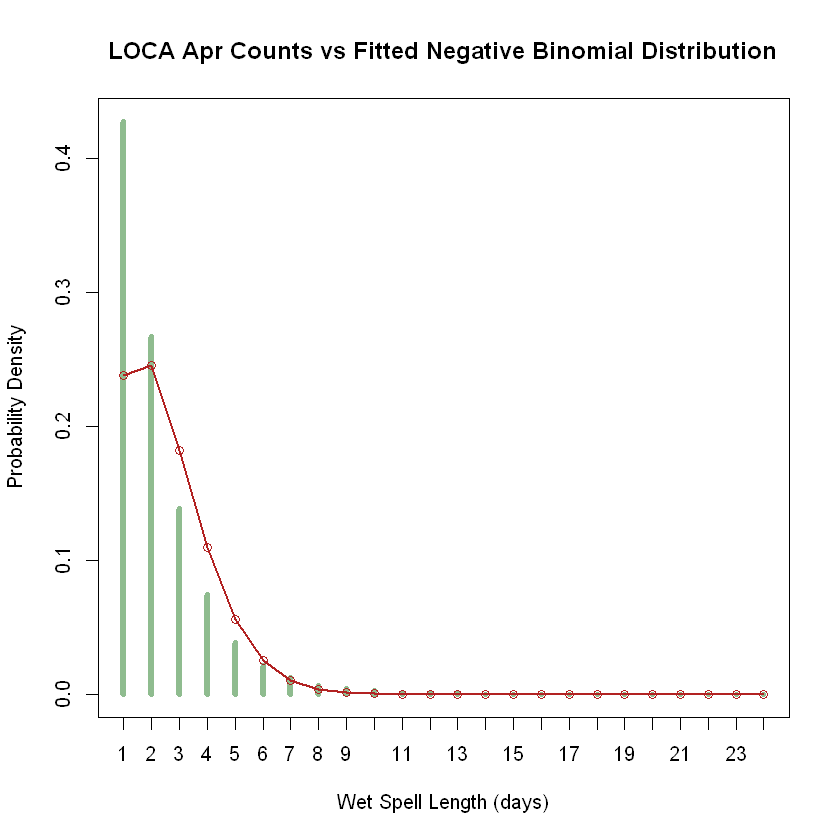

In [271]:
maxP <- max(dLOApr$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dApr_size, mu=LOfdNB_dApr_mu )
ttab <- table( dLOApr$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Apr Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

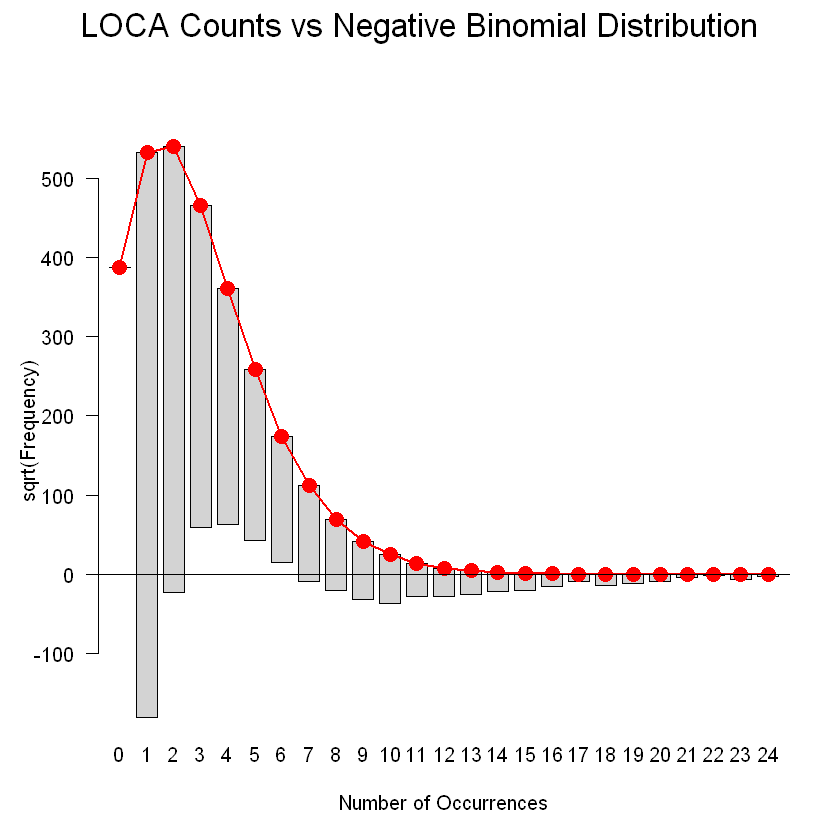

In [272]:
plot( LOgf_dApr, main="LOCA Counts vs Negative Binomial Distribution" )

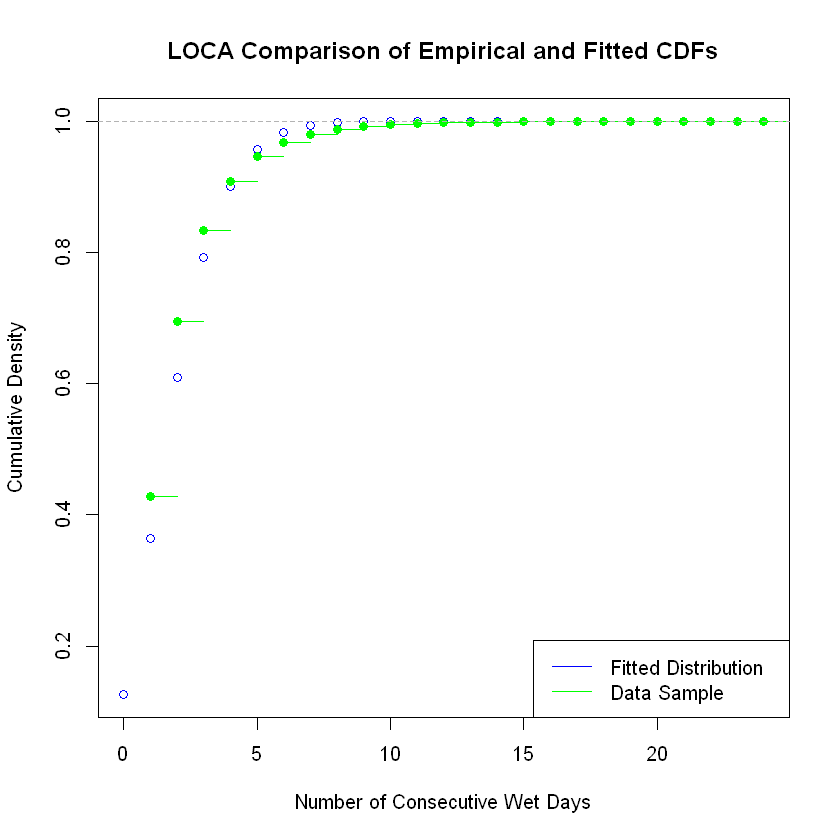

In [273]:
x <- seq(0,dLOAprMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dApr_mu, size=LOfdNB_dApr_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOApr$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

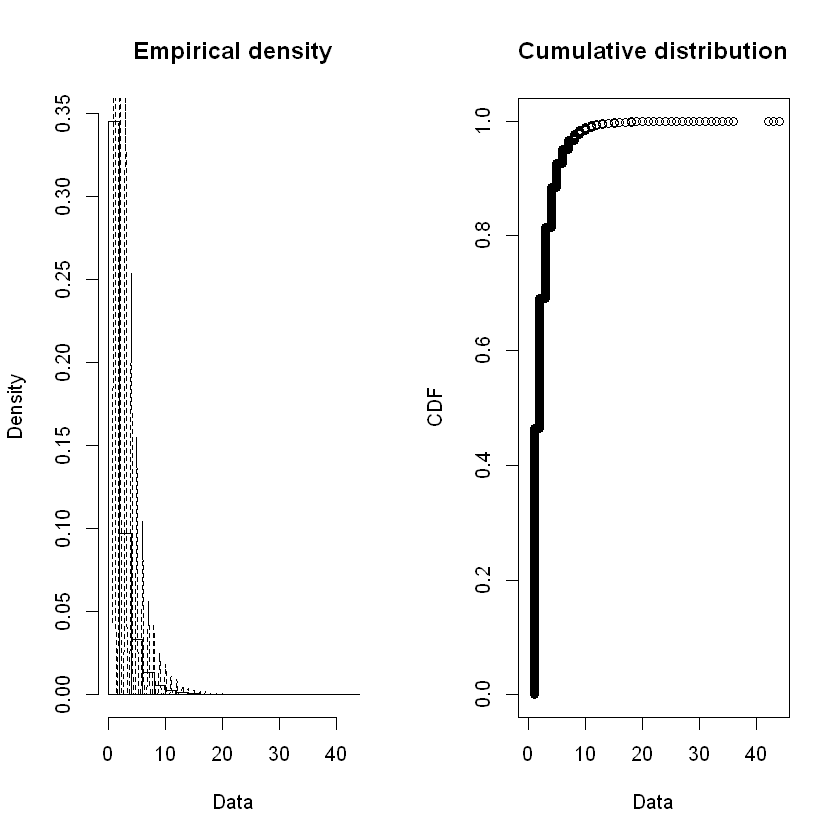

In [274]:
plotdist( dBCApr$Wet_Count, histo=TRUE, demp=TRUE )

In [275]:
BCfd_NB_dApr <- fitdist( dBCApr$Wet_Count, "nbinom" )
BCfd_GE_dApr <- fitdist( dBCApr$Wet_Count, "geom" )

In [276]:
summary( BCfd_NB_dApr )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 4.905220 0.020349019
mu   2.378531 0.002081617
Loglikelihood:  -1537707   AIC:  3075417   BIC:  3075441 
Correlation matrix:
             size           mu
size 1.000000e+00 4.635963e-05
mu   4.635963e-05 1.000000e+00


In [277]:
BCfdNB_dApr_size <- BCfd_NB_dApr$estimate[["size"]]
BCfdNB_dApr_mu <- BCfd_NB_dApr$estimate[["mu"]]
cat("BCCA Apr size: ", BCfdNB_dApr_size, "\n", "BCCA Apr mu: ", BCfdNB_dApr_mu, "\n")

BCCA Apr size:  4.90522 
 BCCA Apr mu:  2.378531 


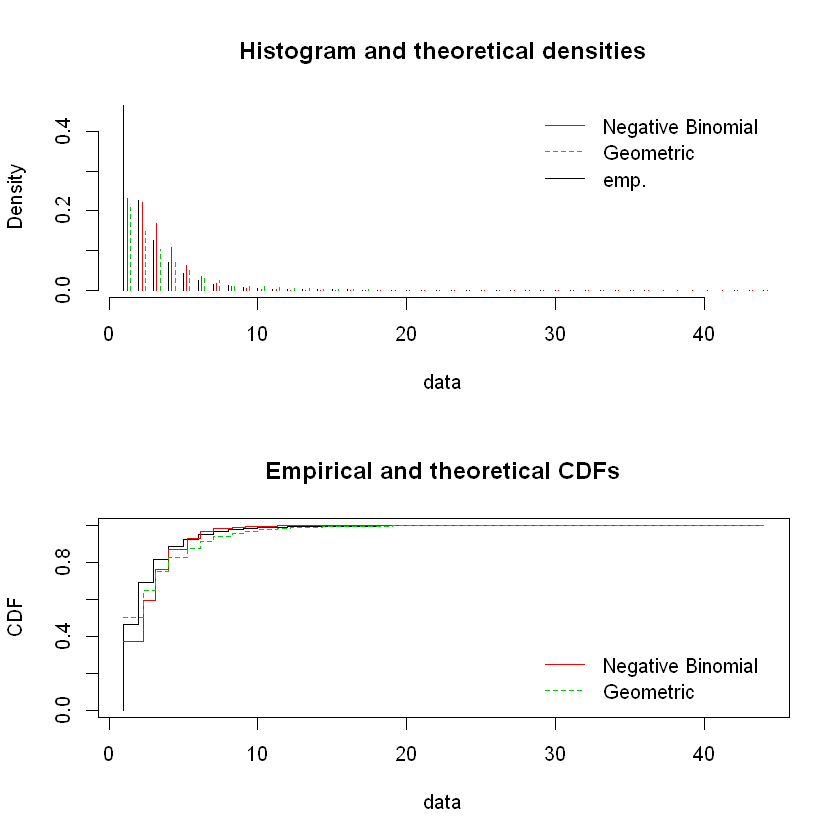

In [278]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dApr, BCfd_GE_dApr), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dApr, BCfd_GE_dApr), legendtext=plot.legend )

In [279]:
BCstatRes <- gofstat( list(BCfd_NB_dApr, BCfd_GE_dApr), fitnames=c("Negative Binomial", "Geometric") )

In [280]:
print(BCstatRes)

Chi-squared statistic:  612186.4 59312.44 
Degree of freedom of the Chi-squared distribution:  11 12 
Chi-squared p-value:  0 0 
   the p-value may be wrong with some theoretical counts < 5  
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     378612           3.049672e+05     411077.763
<= 2     184616           1.810293e+05     119569.069
<= 3     101409           1.360689e+05      84178.962
<= 4      57029           8.781455e+04      59263.635
<= 5      33527           5.107341e+04      41722.757
<= 6      20325           2.753350e+04      29373.637
<= 7      12707           1.400721e+04      20679.615
<= 8       8708           6.806951e+03      14558.853
<= 9       5494           3.187346e+03      10249.717
<= 10      3845           1.447307e+03       7216.001
<= 11      2428           6.404131e+02       5080.206
<= 13      3032           3.948940e+02       6094.535
<= 17      2306           8.091274e+01       4517.916
> 17       1016           2.15618

In [281]:
BCfdNB_dApr_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [282]:
BCfdNB_dApr_p = BCfdNB_dApr_size / (BCfdNB_dApr_size + BCfdNB_dApr_mu)
cat("BCCA prob: ", BCfdNB_dApr_p)

BCCA prob:  0.673447

In [283]:
# add to our tracking dataframe
BCMonDistDF[4, ] <- list( 4, dBCAprMean, dBCAprBNr, BCfdNB_dApr_p, BCfdNB_dApr_mu, BCfdNB_dApr_size,
                          BCfdNB_dApr_pvalue )

In [284]:
BCgf_dApr <- goodfit( dBCApr$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dApr_size, prob=BCfdNB_dApr_p) )

In [285]:
summary( BCgf_dApr )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson               Inf 44        0
Likelihood Ratio 457227.8 38        0


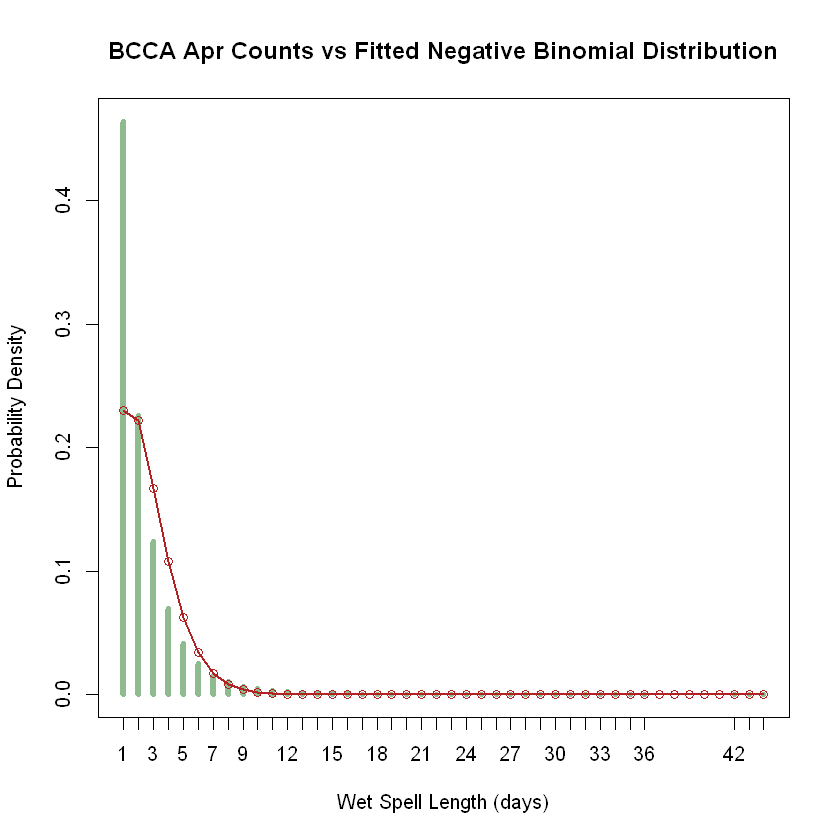

In [286]:
maxP <- max(dBCApr$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dApr_size, mu=BCfdNB_dApr_mu )
ttab <- table( dBCApr$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Apr Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

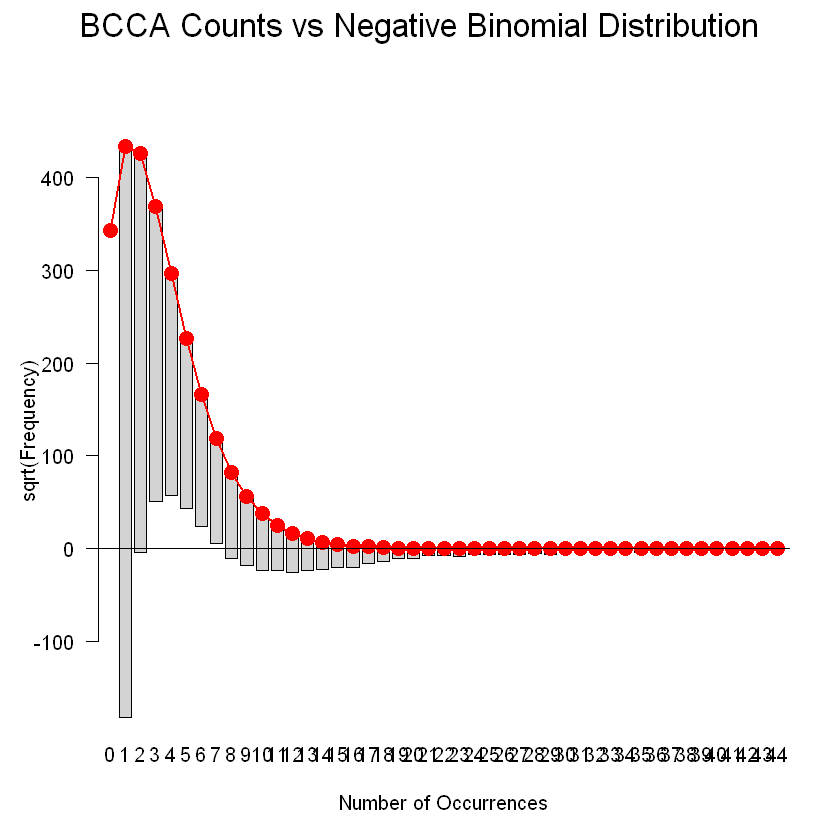

In [287]:
plot( BCgf_dApr, main="BCCA Counts vs Negative Binomial Distribution" )

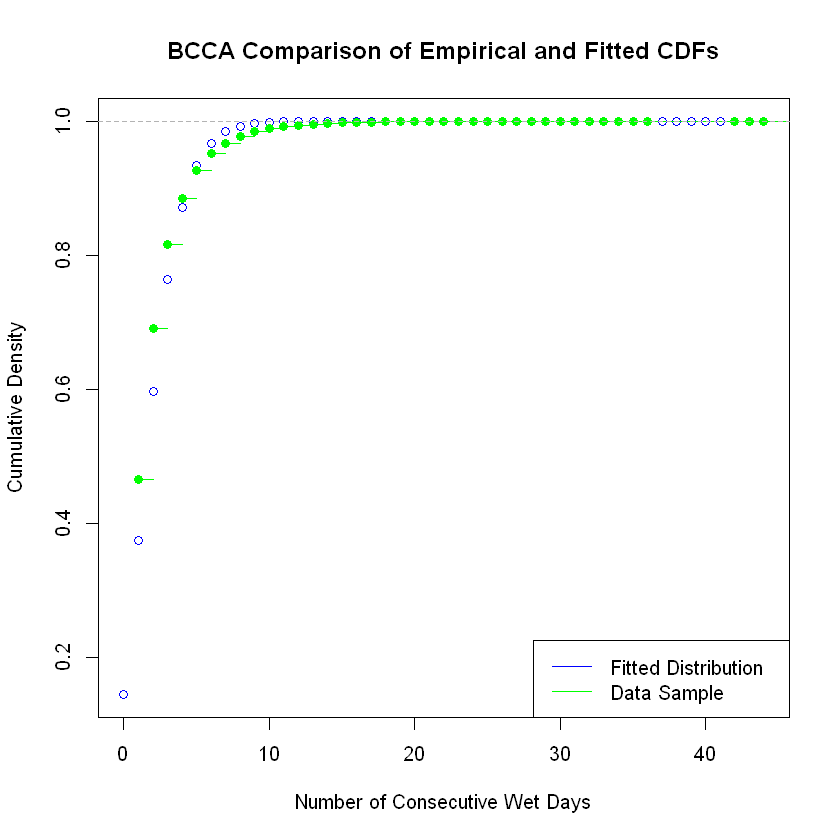

In [288]:
x <- seq(0,dBCAprMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dApr_mu, size=BCfdNB_dApr_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCApr$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

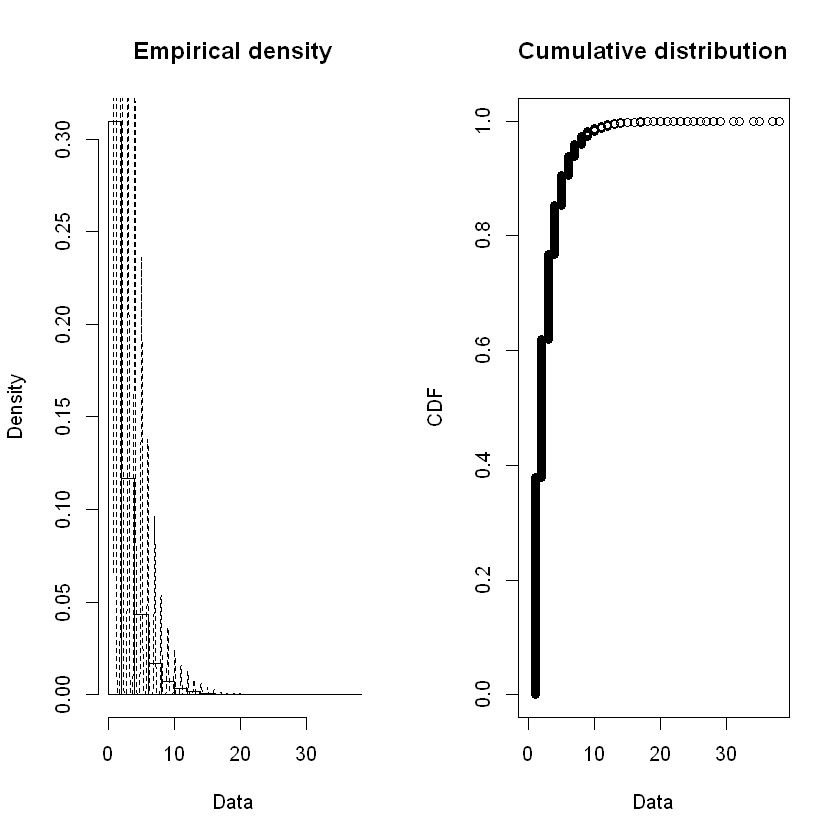

In [289]:
plotdist( dLOMay$Wet_Count, histo=TRUE, demp=TRUE )

In [290]:
LOfd_NB_dMay <- fitdist( dLOMay$Wet_Count, "nbinom" )
LOfd_GE_dMay <- fitdist( dLOMay$Wet_Count, "geom" )

In [291]:
LOfdNB_dMay_size <- LOfd_NB_dMay$estimate[["size"]]
LOfdNB_dMay_mu <- LOfd_NB_dMay$estimate[["mu"]]
cat("LOCA May size: ", LOfdNB_dMay_size, "\n", "LOCA May mu: ", LOfdNB_dMay_mu, "\n")

LOCA May size:  5.127262 
 LOCA May mu:  2.663018 


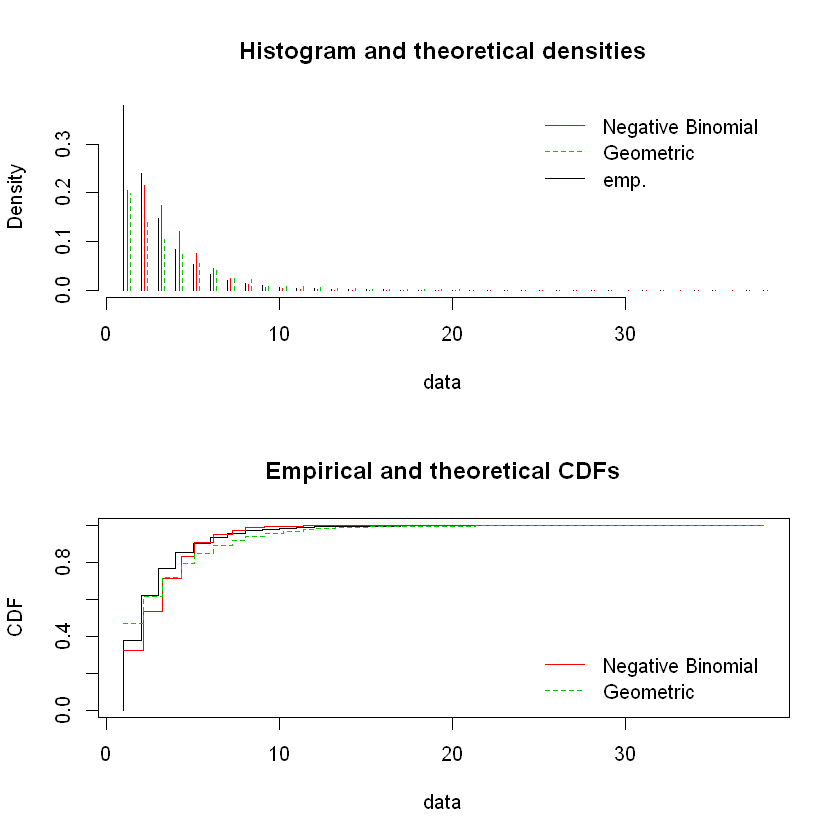

In [292]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dMay, LOfd_GE_dMay), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dMay, LOfd_GE_dMay), legendtext=plot.legend )

In [293]:
LOstatRes <- gofstat( list(LOfd_NB_dMay, LOfd_GE_dMay), fitnames=c("Negative Binomial", "Geometric") )

In [294]:
print( LOstatRes )

Chi-squared statistic:  198670.4 170635.2 
Degree of freedom of the Chi-squared distribution:  11 12 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     524268            445481.3512     651604.592
<= 2     331818            297053.9546     199416.064
<= 3     205097            241244.7333     144975.377
<= 4     117008            167557.2195     105397.025
<= 5      73640            104557.3804      76623.583
<= 6      46010             60327.6663      55705.306
<= 7      28812             32781.4257      40497.729
<= 8      18296             16987.1941      29441.828
<= 9      12349              8469.8229      21404.194
<= 10      7279              4090.2831      15560.838
<= 11      5227              1922.8352      11312.722
<= 12      3844               883.3697       8224.343
<= 14      4664               573.9291      10325.891
> 14       3753               133.8349      11575.508

Goodness-of-fit criteria
                

In [295]:
LOfdNB_dMay_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [296]:
LOfdNB_dMay_p = LOfdNB_dMay_size / (LOfdNB_dMay_size + LOfdNB_dMay_mu)
cat("LOCA prob: ", LOfdNB_dMay_p)

LOCA prob:  0.6581614

In [297]:
# add to our tracking dataframe
LOMonDistDF[5, ] <- list( 5, dLOMayMean, dLOMayBNr, LOfdNB_dMay_p, LOfdNB_dMay_mu, LOfdNB_dMay_size,
                          LOfdNB_dMay_pvalue )

In [298]:
LOgf_dMay <- goodfit( dLOMay$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dMay_size, prob=LOfdNB_dMay_p) )

In [299]:
summary( LOgf_dMay )


	 Goodness-of-fit test for nbinomial distribution

                          X^2 df P(> X^2)
Pearson          2985403305.2 38        0
Likelihood Ratio     576682.1 34        0


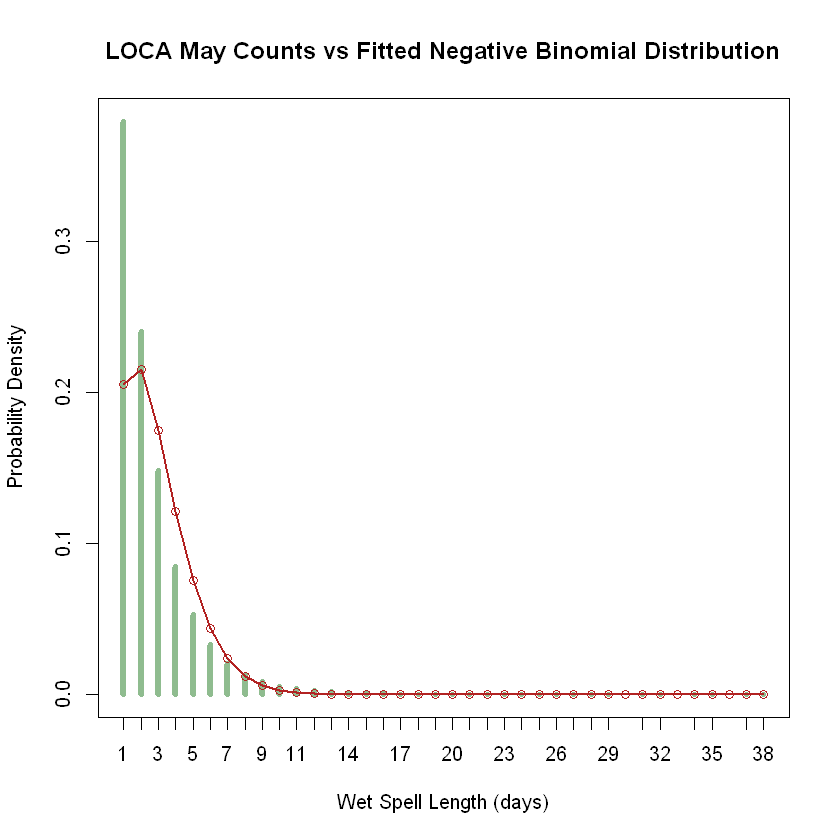

In [300]:
maxP <- max(dLOMay$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dMay_size, mu=LOfdNB_dMay_mu )
ttab <- table( dLOMay$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA May Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

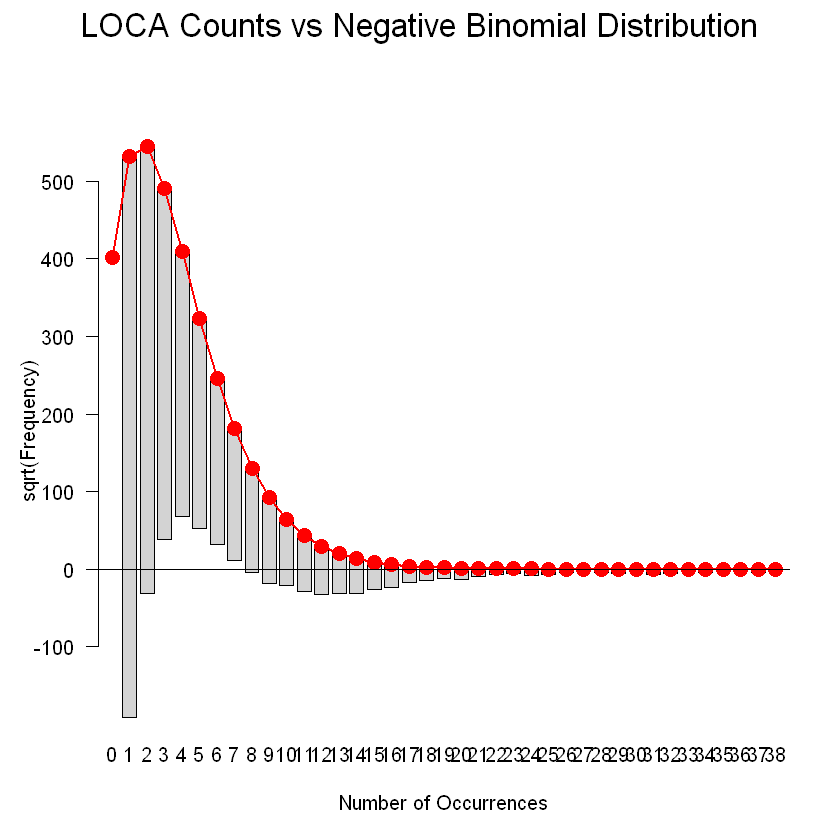

In [301]:
plot( LOgf_dMay, main="LOCA Counts vs Negative Binomial Distribution" )

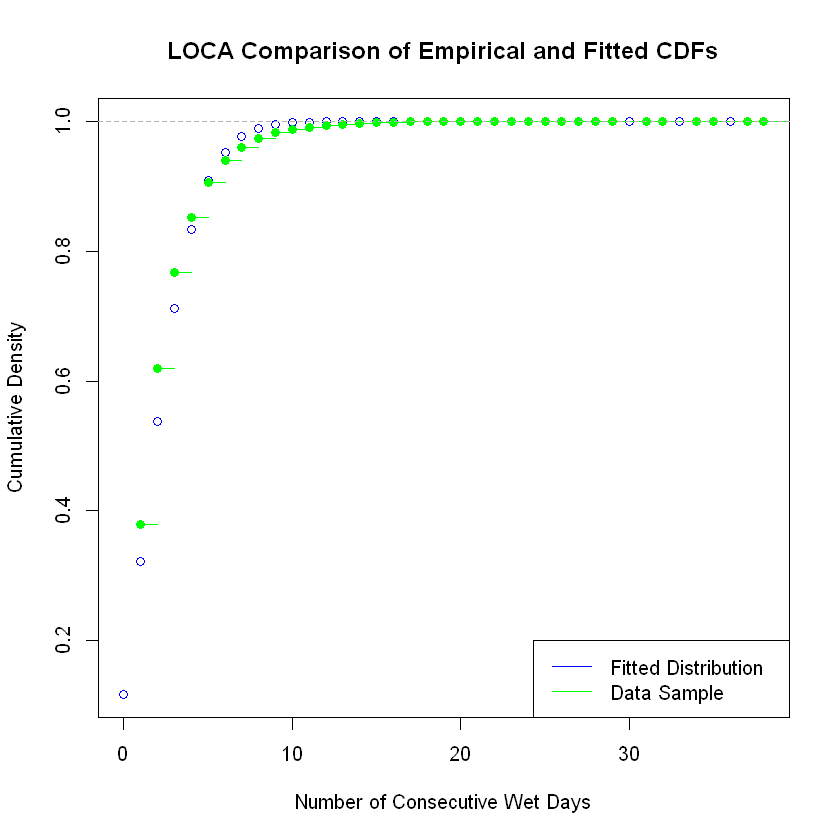

In [302]:
x <- seq(0,dLOMayMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dMay_mu, size=LOfdNB_dMay_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOMay$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

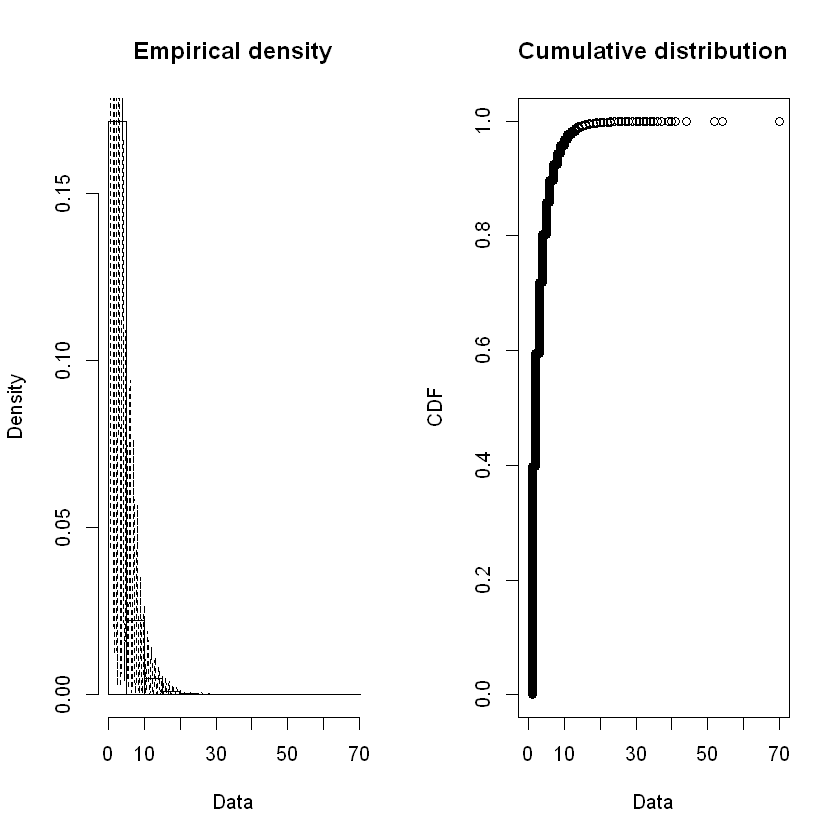

In [303]:
plotdist( dBCMay$Wet_Count, histo=TRUE, demp=TRUE )

In [304]:
BCfd_NB_dMay <- fitdist( dBCMay$Wet_Count, "nbinom" )
BCfd_GE_dMay <- fitdist( dBCMay$Wet_Count, "geom" )

In [305]:
summary( BCfd_NB_dMay )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.737151 0.007309721
mu   3.031764 0.002707585
Loglikelihood:  -1879454   AIC:  3758912   BIC:  3758936 
Correlation matrix:
             size           mu
size  1.00000e+00 -9.74996e-05
mu   -9.74996e-05  1.00000e+00


In [306]:
BCfdNB_dMay_size <- BCfd_NB_dMay$estimate[["size"]]
BCfdNB_dMay_mu <- BCfd_NB_dMay$estimate[["mu"]]
cat("BCCA May size: ", BCfdNB_dMay_size, "\n", "BCCA May mu: ", BCfdNB_dMay_mu, "\n")

BCCA May size:  2.737151 
 BCCA May mu:  3.031764 


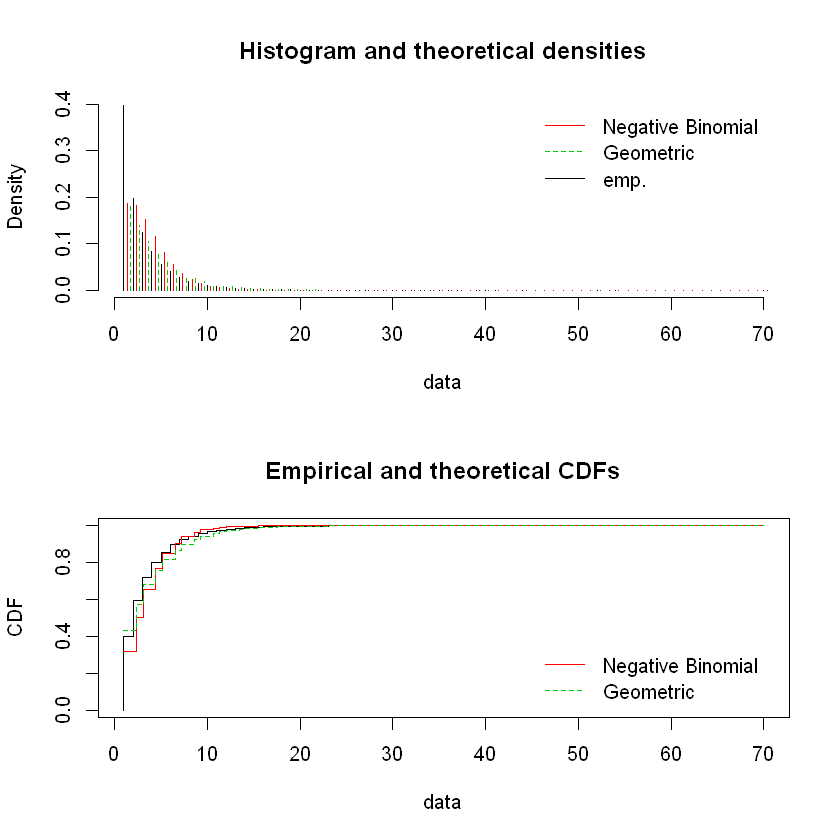

In [307]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dMay, BCfd_GE_dMay), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dMay, BCfd_GE_dMay), legendtext=plot.legend )

In [308]:
BCstatRes <- gofstat( list(BCfd_NB_dMay, BCfd_GE_dMay), fitnames=c("Negative Binomial", "Geometric") )

In [309]:
print(BCstatRes)

Chi-squared statistic:  119906.4 34096.52 
Degree of freedom of the Chi-squared distribution:  14 15 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     346341           276189.74574     378805.591
<= 2     171964           159993.58350     122258.737
<= 3     108381           132769.95995      91933.442
<= 4      72630           100077.71880      69130.092
<= 5      48227            70867.14839      51982.929
<= 6      34392            48025.96087      39088.982
<= 7      23738            31502.79931      29393.275
<= 8      17110            20150.80251      22102.510
<= 9      12427            12633.97985      16620.160
<= 10      9616             7792.99062      12497.663
<= 11      6581             4742.25657       9397.719
<= 12      5039             2852.99989       7066.690
<= 13      3977             1699.70369       5313.855
<= 14      2854             1004.08984       3995.796
<= 16      3658              931.82280    

In [310]:
BCfdNB_dMay_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [311]:
BCfdNB_dMay_p = BCfdNB_dMay_size / (BCfdNB_dMay_size + BCfdNB_dMay_mu)
cat("BCCA prob: ", BCfdNB_dMay_p)

BCCA prob:  0.4744654

In [312]:
# add to our tracking dataframe
BCMonDistDF[5, ] <- list( 5, dBCMayMean, dBCMayBNr, BCfdNB_dMay_p, BCfdNB_dMay_mu, BCfdNB_dMay_size,
                          BCfdNB_dMay_pvalue )

In [313]:
BCgf_dMay <- goodfit( dBCMay$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dMay_size, prob=BCfdNB_dMay_p) )

In [314]:
summary( BCgf_dMay )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson               NaN 70      NaN
Likelihood Ratio 440266.6 43        0


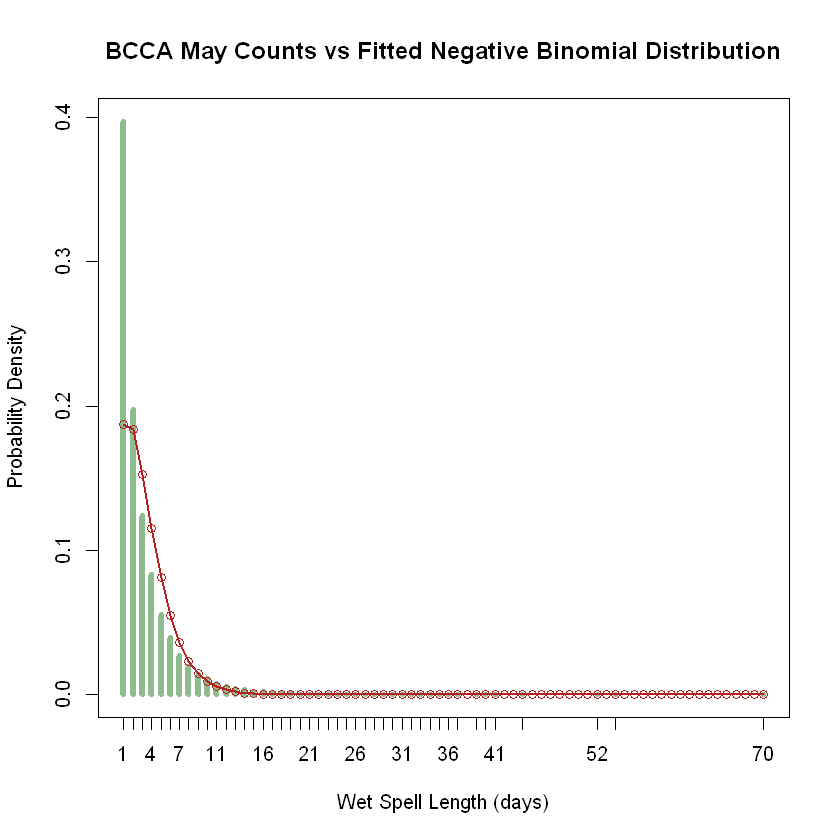

In [315]:
maxP <- max(dBCMay$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dMay_size, mu=BCfdNB_dMay_mu )
ttab <- table( dBCMay$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA May Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

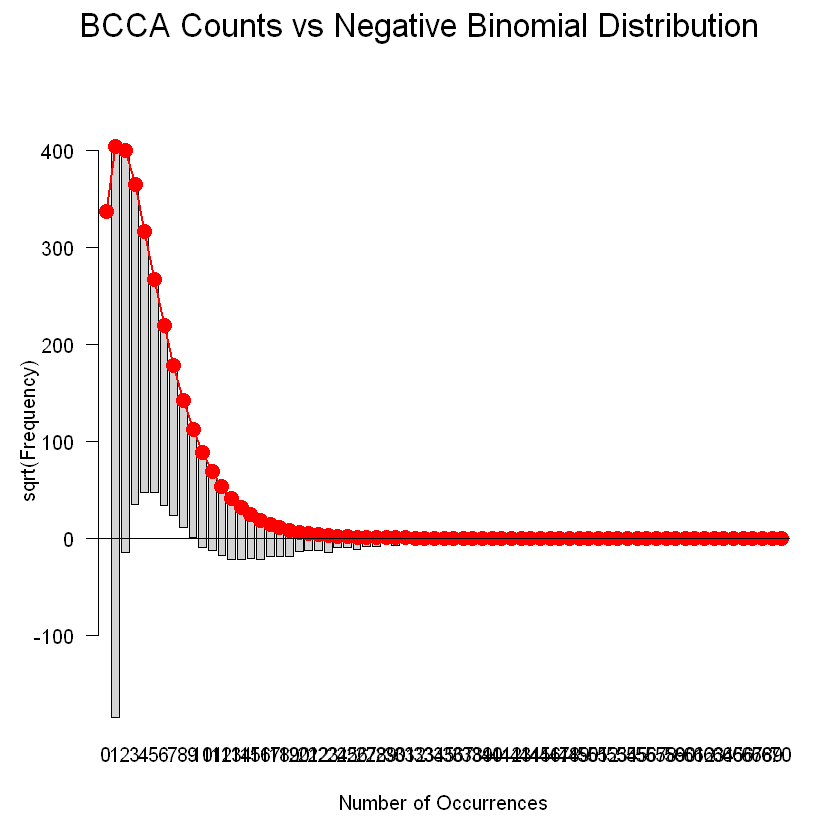

In [316]:
plot( BCgf_dMay, main="BCCA Counts vs Negative Binomial Distribution" )

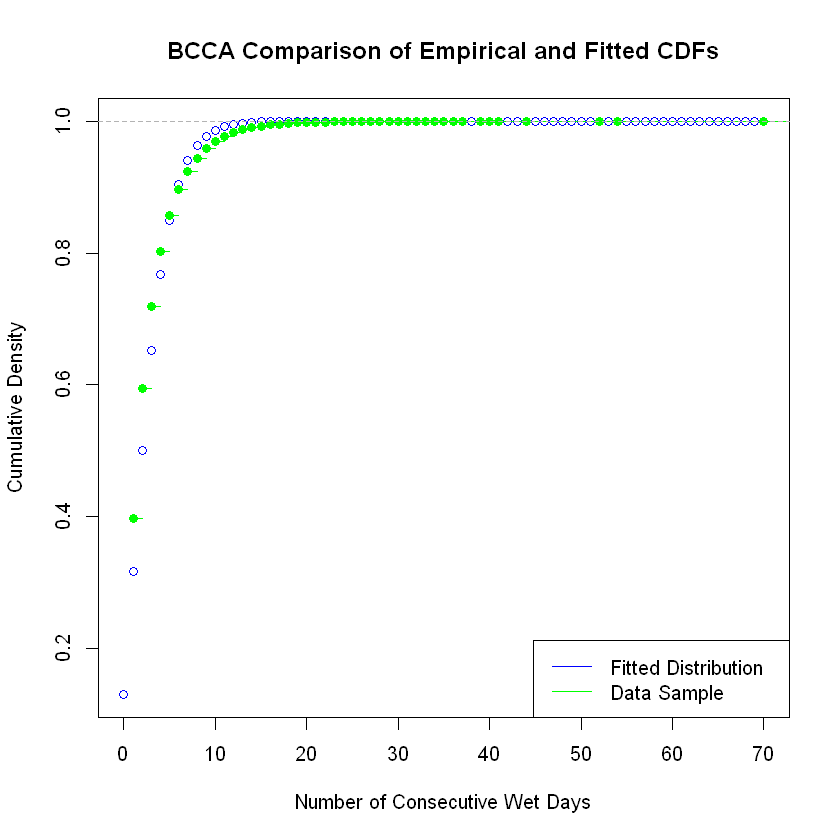

In [317]:
x <- seq(0,dBCMayMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dMay_mu, size=BCfdNB_dMay_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCMay$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

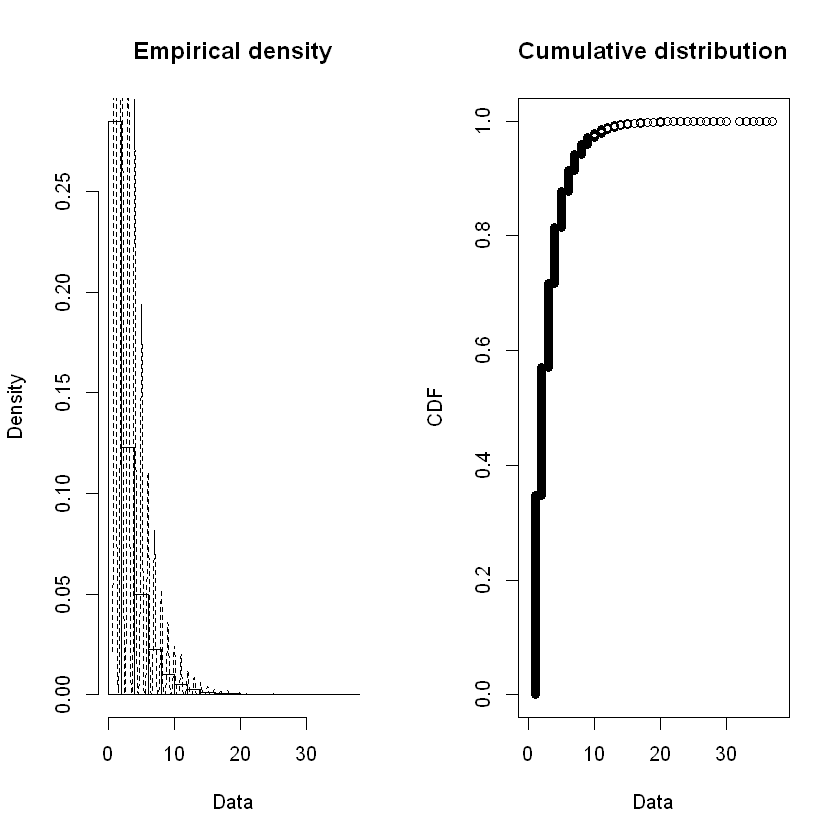

In [318]:
plotdist( dLOJun$Wet_Count, histo=TRUE, demp=TRUE )

In [319]:
LOfd_NB_dJun <- fitdist( dLOJun$Wet_Count, "nbinom" )
LOfd_GE_dJun <- fitdist( dLOJun$Wet_Count, "geom" )

In [320]:
LOfdNB_dJun_size <- LOfd_NB_dJun$estimate[["size"]]
LOfdNB_dJun_mu <- LOfd_NB_dJun$estimate[["mu"]]
cat("LOCA Jun size: ", LOfdNB_dJun_size, "\n", "LOCA Jun mu: ", LOfdNB_dJun_mu, "\n")

LOCA Jun size:  3.946134 
 LOCA Jun mu:  2.95667 


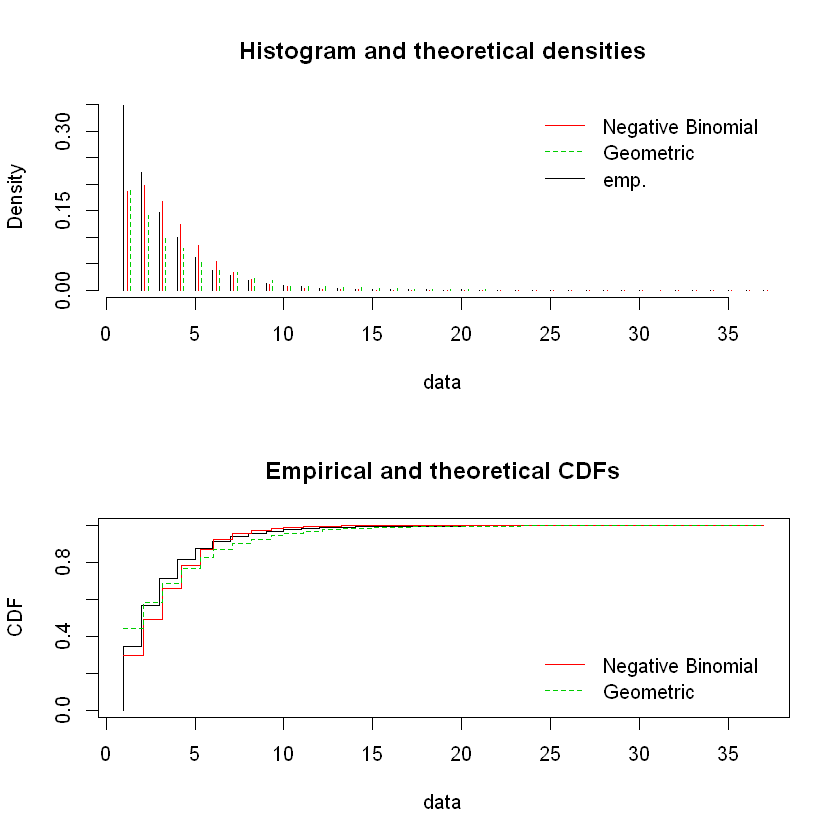

In [321]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dJun, LOfd_GE_dJun), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dJun, LOfd_GE_dJun), legendtext=plot.legend )

In [322]:
LOstatRes <- gofstat( list(LOfd_NB_dJun, LOfd_GE_dJun), fitnames=c("Negative Binomial", "Geometric") )

In [323]:
print( LOstatRes )

Chi-squared statistic:  244150 125183.9 
Degree of freedom of the Chi-squared distribution:  13 14 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     409215           348168.81300     519269.165
<= 2     261061           231718.48510     165943.477
<= 3     172031           196721.31095     123999.602
<= 4     116579           146322.75278      92657.461
<= 5      73172            99603.59801      69237.360
<= 6      43898            63611.62007      51736.924
<= 7      31727            38714.17431      38659.899
<= 8      20575            22689.14087      28888.222
<= 9      13889            12899.71750      21586.435
<= 10      9559             7153.15394      16130.248
<= 11      7624             3884.50776      12053.166
<= 12      4813             2072.33943       9006.608
<= 13      3313             1088.80528       6730.097
<= 15      3961              853.79371       8786.866
<= 19      2688              275.40073      

In [324]:
LOfdNB_dJun_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [325]:
LOfdNB_dJun_p = LOfdNB_dJun_size / (LOfdNB_dJun_size + LOfdNB_dJun_mu)
cat("LOCA prob: ", LOfdNB_dJun_p)

LOCA prob:  0.5716712

In [326]:
# add to our tracking dataframe
LOMonDistDF[6, ] <- list( 6, dLOJunMean, dLOJunBNr, LOfdNB_dJun_p, LOfdNB_dJun_mu, LOfdNB_dJun_size,
                          LOfdNB_dJun_pvalue )

In [327]:
LOgf_dJun <- goodfit( dLOJun$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dJun_size, prob=LOfdNB_dJun_p) )

In [328]:
summary( LOgf_dJun )


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          6298409.6 37        0
Likelihood Ratio  456724.1 35        0


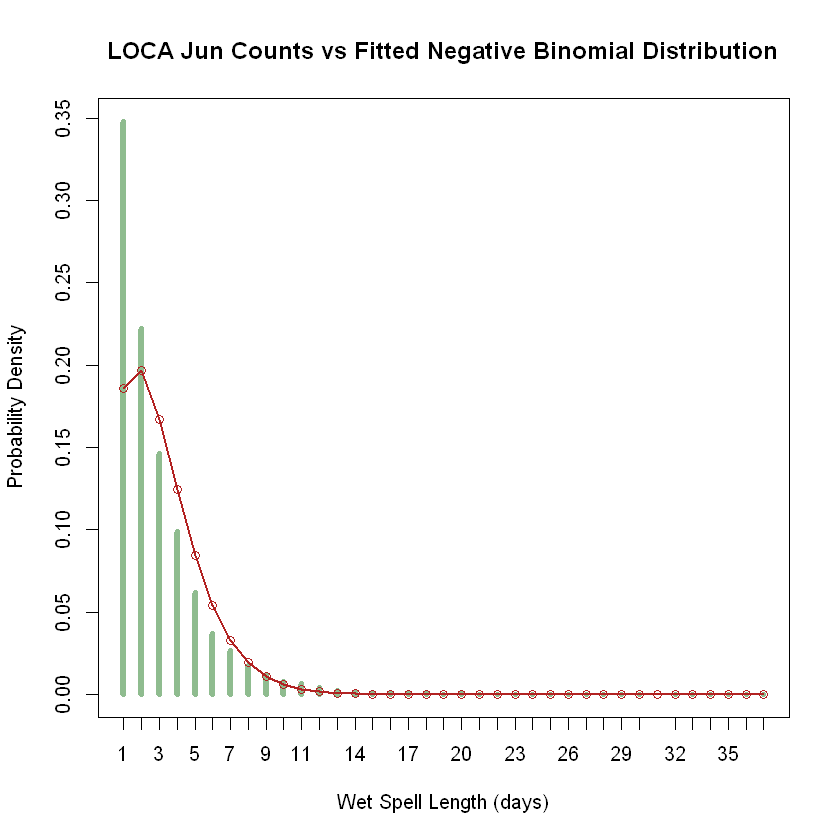

In [329]:
maxP <- max(dLOJun$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dJun_size, mu=LOfdNB_dJun_mu )
ttab <- table( dLOJun$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Jun Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

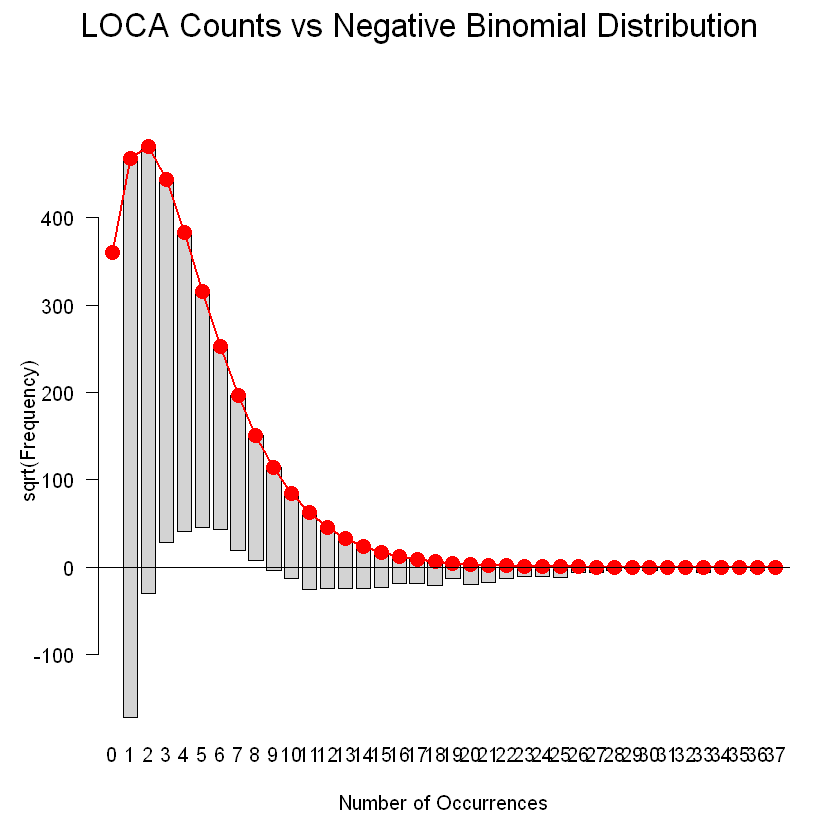

In [330]:
plot( LOgf_dJun, main="LOCA Counts vs Negative Binomial Distribution" )

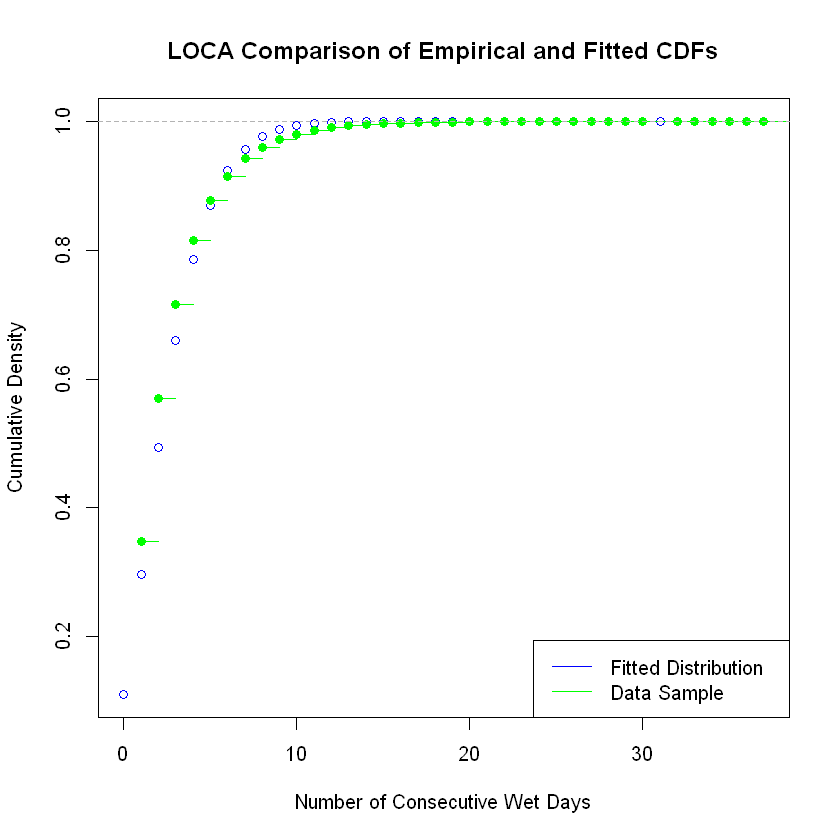

In [331]:
x <- seq(0,dLOJunMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dJun_mu, size=LOfdNB_dJun_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOJun$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

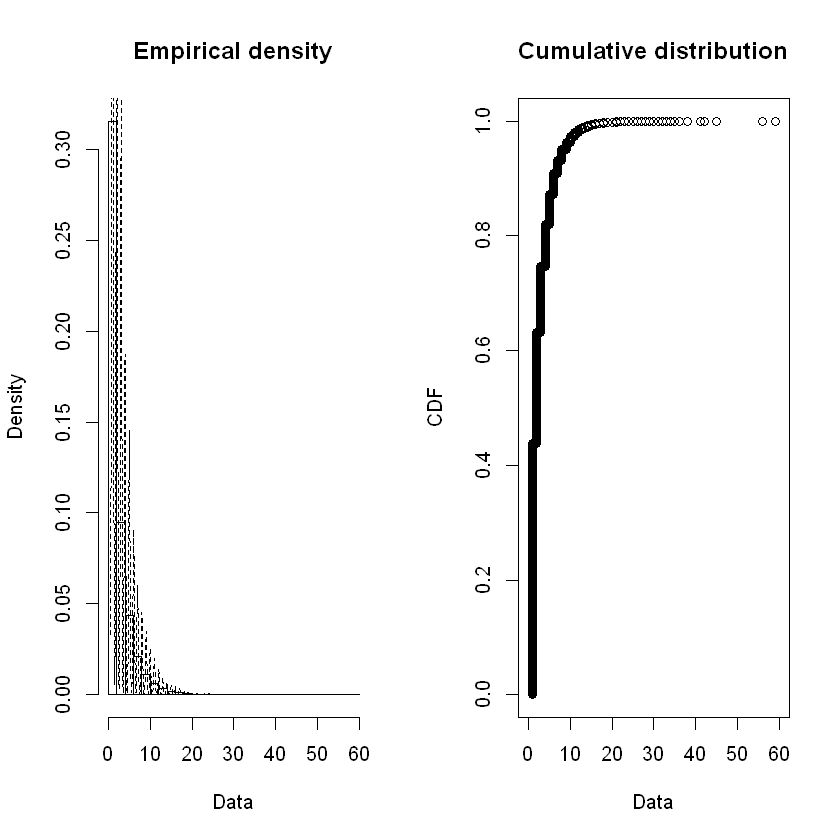

In [332]:
plotdist( dBCJun$Wet_Count, histo=TRUE, demp=TRUE )

In [333]:
BCfd_NB_dJun <- fitdist( dBCJun$Wet_Count, "nbinom" )
BCfd_GE_dJun <- fitdist( dBCJun$Wet_Count, "geom" )

In [334]:
summary( BCfd_NB_dJun )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.786265 0.007941547
mu   2.840649 0.002658866
Loglikelihood:  -1704084   AIC:  3408172   BIC:  3408195 
Correlation matrix:
             size           mu
size 1.0000000000 0.0002002363
mu   0.0002002363 1.0000000000


In [335]:
BCfdNB_dJun_size <- BCfd_NB_dJun$estimate[["size"]]
BCfdNB_dJun_mu <- BCfd_NB_dJun$estimate[["mu"]]
cat("BCCA Jun size: ", BCfdNB_dJun_size, "\n", "BCCA Jun mu: ", BCfdNB_dJun_mu, "\n")

BCCA Jun size:  2.786265 
 BCCA Jun mu:  2.840649 


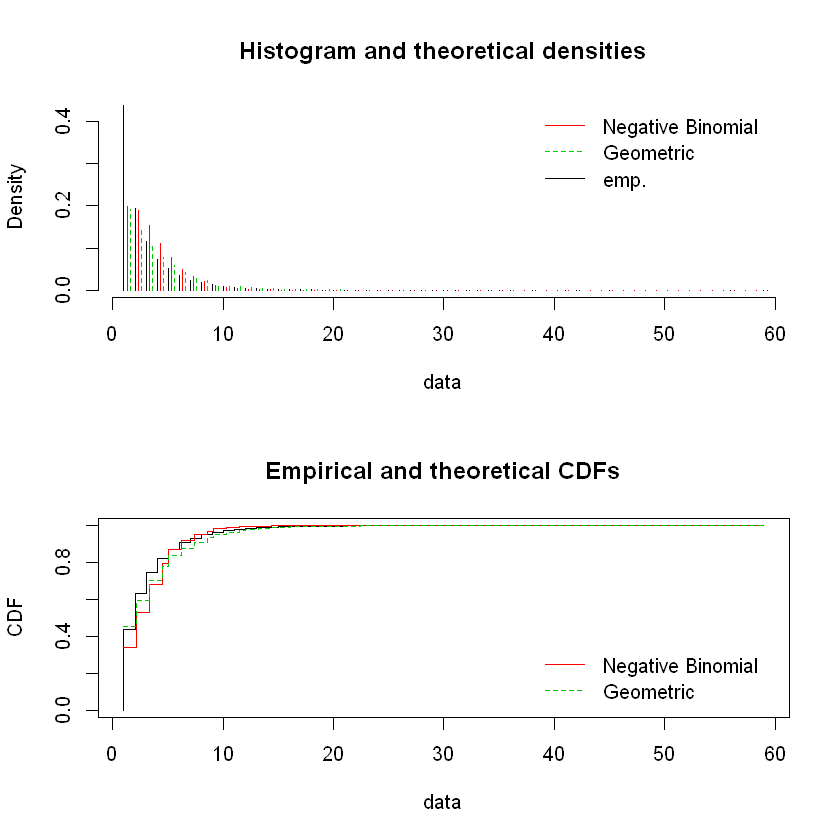

In [336]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dJun, BCfd_GE_dJun), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dJun, BCfd_GE_dJun), legendtext=plot.legend )

In [337]:
BCstatRes <- gofstat( list(BCfd_NB_dJun, BCfd_GE_dJun), fitnames=c("Negative Binomial", "Geometric") )

In [338]:
print(BCstatRes)

Chi-squared statistic:  141175.8 23665.87 
Degree of freedom of the Chi-squared distribution:  14 15 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     354982           275479.50654     367454.350
<= 2     156973           153880.63288     115557.004
<= 3      94485           123938.64953      85472.018
<= 4      59500            90509.13082      63219.585
<= 5      42145            62015.53693      46760.519
<= 6      28739            40628.02771      34586.531
<= 7      19513            25744.19390      25582.011
<= 8      14671            15898.40593      18921.797
<= 9      10599             9618.98961      13995.553
<= 10      7590             5723.38491      10351.844
<= 11      6049             3358.54573       7656.767
<= 12      4117             1947.88780       5663.346
<= 13      3090             1118.47522       4188.908
<= 14      2255              636.68558       3098.336
<= 16      3052              561.55417    

In [339]:
BCfdNB_dJun_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [340]:
BCfdNB_dJun_p = BCfdNB_dJun_size / (BCfdNB_dJun_size + BCfdNB_dJun_mu)
cat("BCCA prob: ", BCfdNB_dJun_p)

BCCA prob:  0.4951675

In [341]:
# add to our tracking dataframe
BCMonDistDF[6, ] <- list( 6, dBCJunMean, dBCJunBNr, BCfdNB_dJun_p, BCfdNB_dJun_mu, BCfdNB_dJun_size,
                          BCfdNB_dJun_pvalue )

In [342]:
BCgf_dJun <- goodfit( dBCJun$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dJun_size, prob=BCfdNB_dJun_p) )

In [343]:
summary( BCgf_dJun )


	 Goodness-of-fit test for nbinomial distribution

                          X^2 df P(> X^2)
Pearson          6016017078.2 59        0
Likelihood Ratio     464569.4 41        0


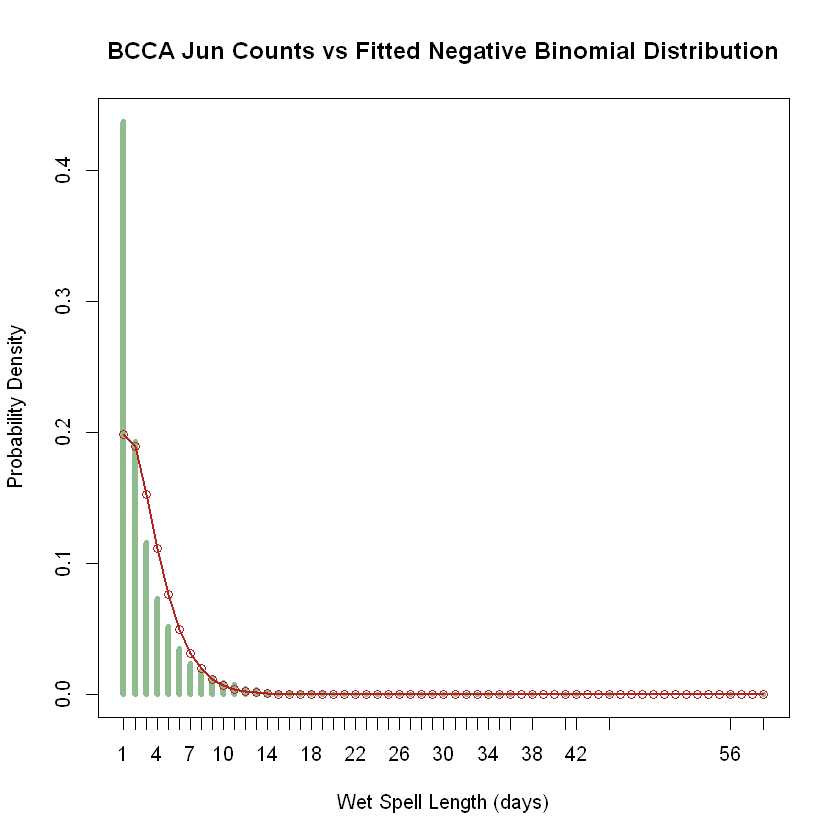

In [344]:
maxP <- max(dBCJun$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dJun_size, mu=BCfdNB_dJun_mu )
ttab <- table( dBCJun$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Jun Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

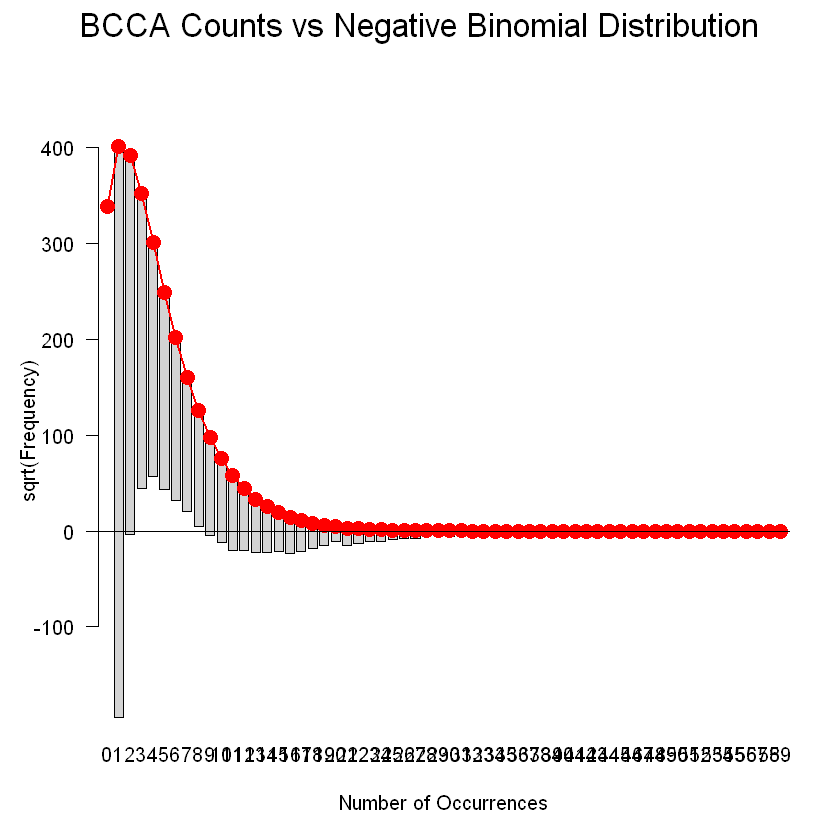

In [345]:
plot( BCgf_dJun, main="BCCA Counts vs Negative Binomial Distribution" )

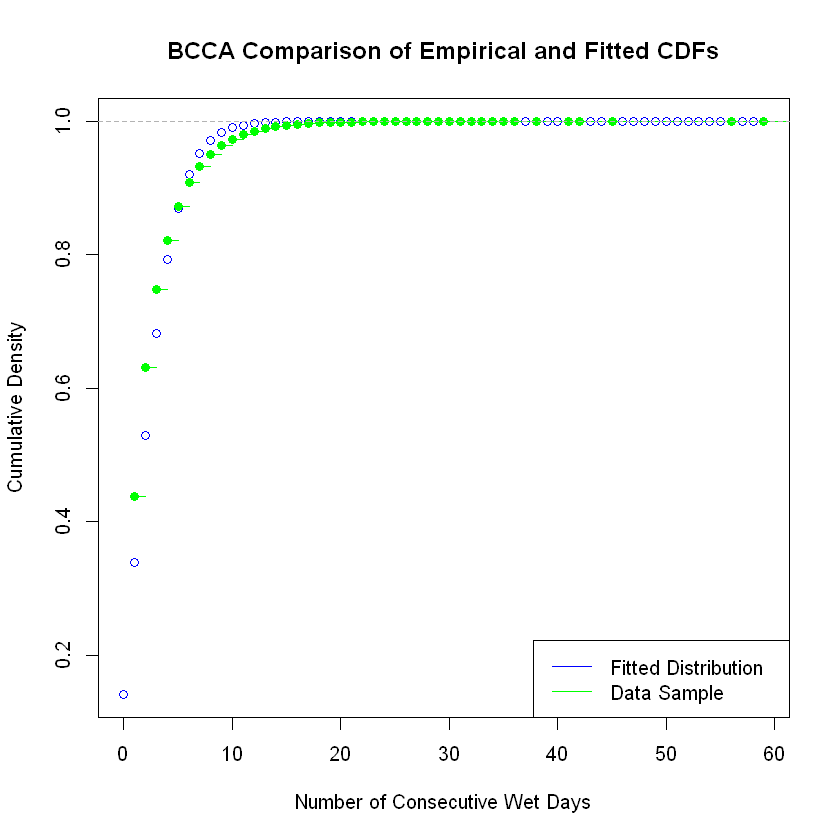

In [346]:
x <- seq(0,dBCJunMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dJun_mu, size=BCfdNB_dJun_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCJun$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

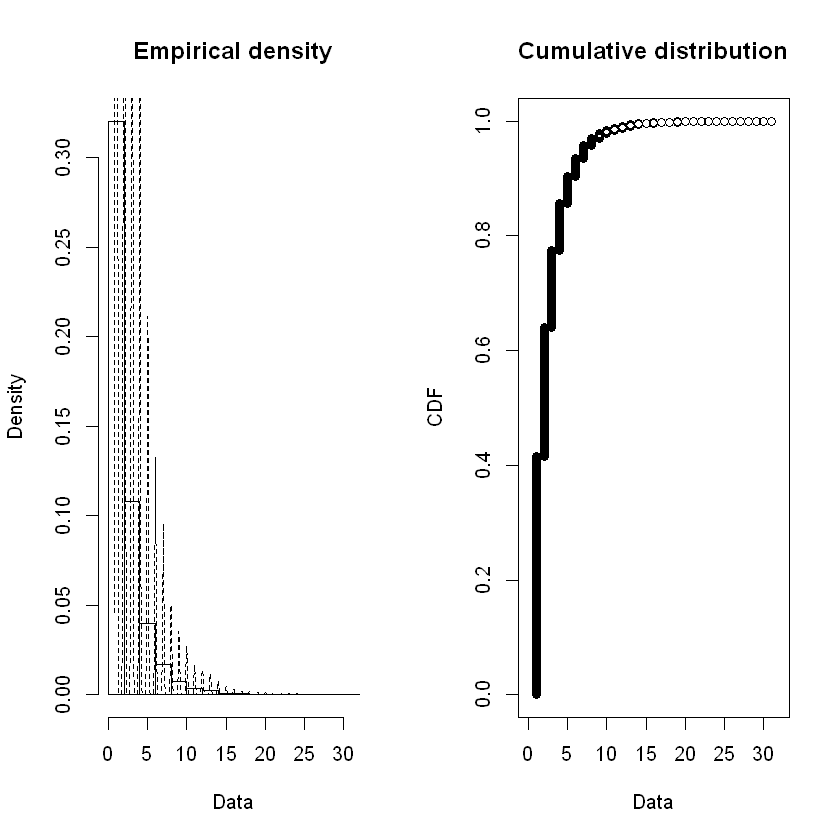

In [347]:
plotdist( dLOJul$Wet_Count, histo=TRUE, demp=TRUE )

In [348]:
LOfd_NB_dJul <- fitdist( dLOJul$Wet_Count, "nbinom" )
LOfd_GE_dJul <- fitdist( dLOJul$Wet_Count, "geom" )

In [349]:
LOfdNB_dJul_size <- LOfd_NB_dJul$estimate[["size"]]
LOfdNB_dJul_mu <- LOfd_NB_dJul$estimate[["mu"]]
cat("LOCA Jul size: ", LOfdNB_dJul_size, "\n", "LOCA Jul mu: ", LOfdNB_dJul_mu, "\n")

LOCA Jul size:  4.192017 
 LOCA Jul mu:  2.624757 


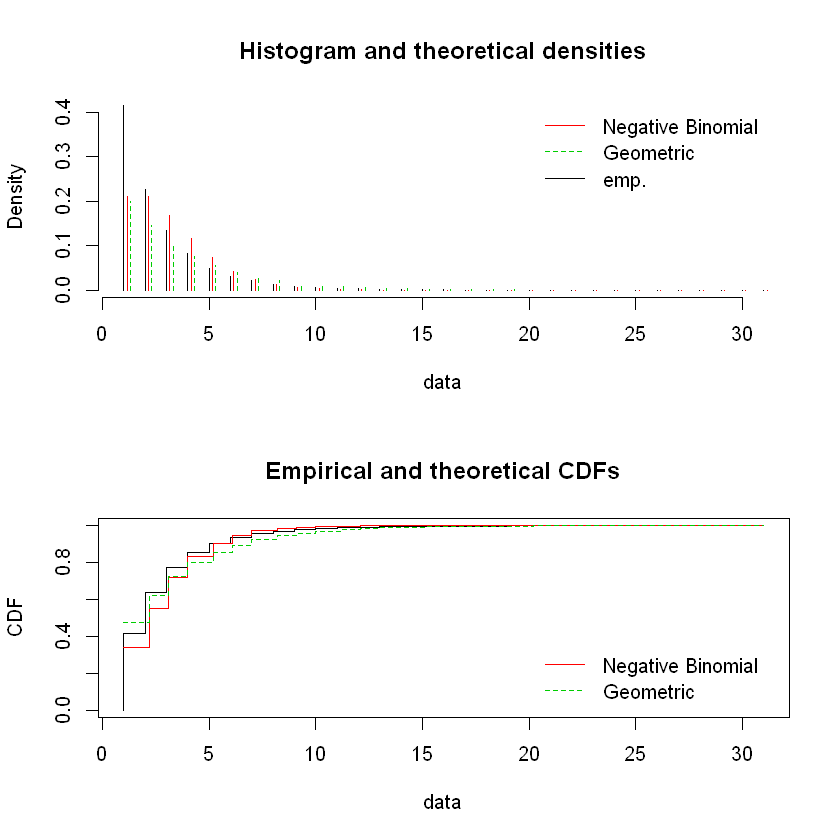

In [350]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dJul, LOfd_GE_dJul), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dJul, LOfd_GE_dJul), legendtext=plot.legend )

In [351]:
LOstatRes <- gofstat( list(LOfd_NB_dJul, LOfd_GE_dJul), fitnames=c("Negative Binomial", "Geometric") )

In [352]:
print( LOstatRes )

Chi-squared statistic:  210609.1 80368.16 
Degree of freedom of the Chi-squared distribution:  12 13 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     410259           336871.64290     470482.744
<= 2     223279           207917.06872     143098.699
<= 3     133001           165238.51360     103626.428
<= 4      80756           114396.37028      75042.167
<= 5      47528            72167.77853      54342.575
<= 6      31038            42570.93193      39352.747
<= 7      21656            23866.32274      28497.705
<= 8      11864            12856.24488      20636.913
<= 9       8302             6705.90565      14944.438
<= 10      6064             3406.26862      10822.172
<= 11      3758             1692.15673       7836.989
<= 12      3404              824.86909       5675.238
<= 13      2610              395.59690       4109.783
<= 15      2705              274.40159       5131.348
> 15       3034               73.92785    

In [353]:
LOfdNB_dJul_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [354]:
LOfdNB_dJul_p = LOfdNB_dJul_size / (LOfdNB_dJul_size + LOfdNB_dJul_mu)
cat("LOCA prob: ", LOfdNB_dJul_p)

LOCA prob:  0.6149561

In [355]:
# add to our tracking dataframe
LOMonDistDF[7, ] <- list( 7, dLOJulMean, dLOJulBNr, LOfdNB_dJul_p, LOfdNB_dJul_mu, LOfdNB_dJul_size,
                          LOfdNB_dJul_pvalue )

In [356]:
LOgf_dJul <- goodfit( dLOJul$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dJul_size, prob=LOfdNB_dJul_p) )

In [357]:
summary( LOgf_dJul )


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          1997475.3 31        0
Likelihood Ratio  485595.4 30        0


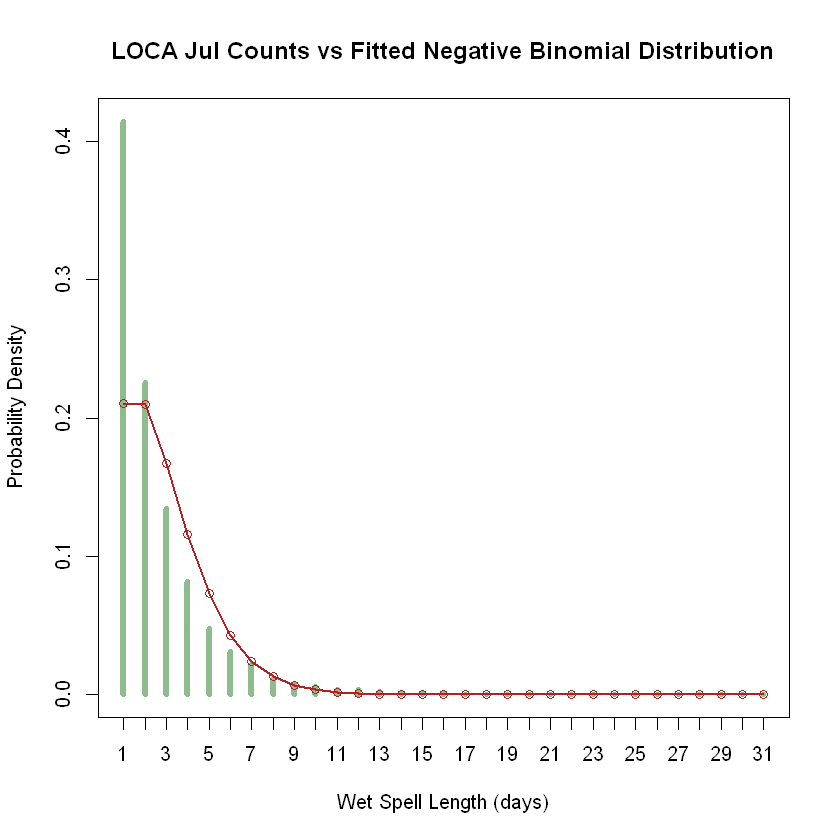

In [358]:
maxP <- max(dLOJul$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dJul_size, mu=LOfdNB_dJul_mu )
ttab <- table( dLOJul$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Jul Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

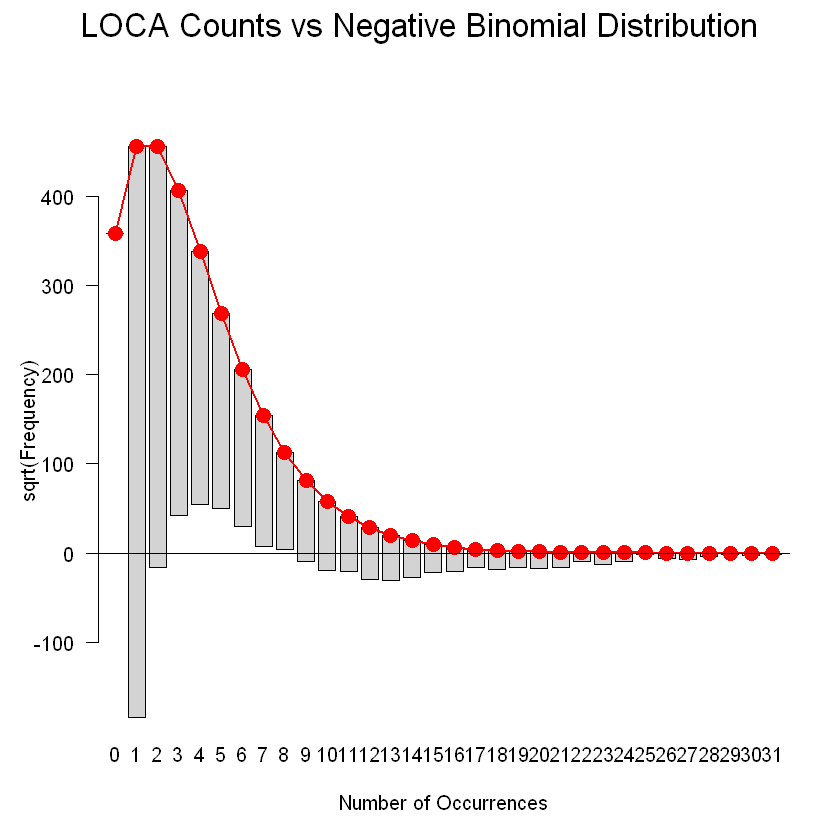

In [359]:
plot( LOgf_dJul, main="LOCA Counts vs Negative Binomial Distribution" )

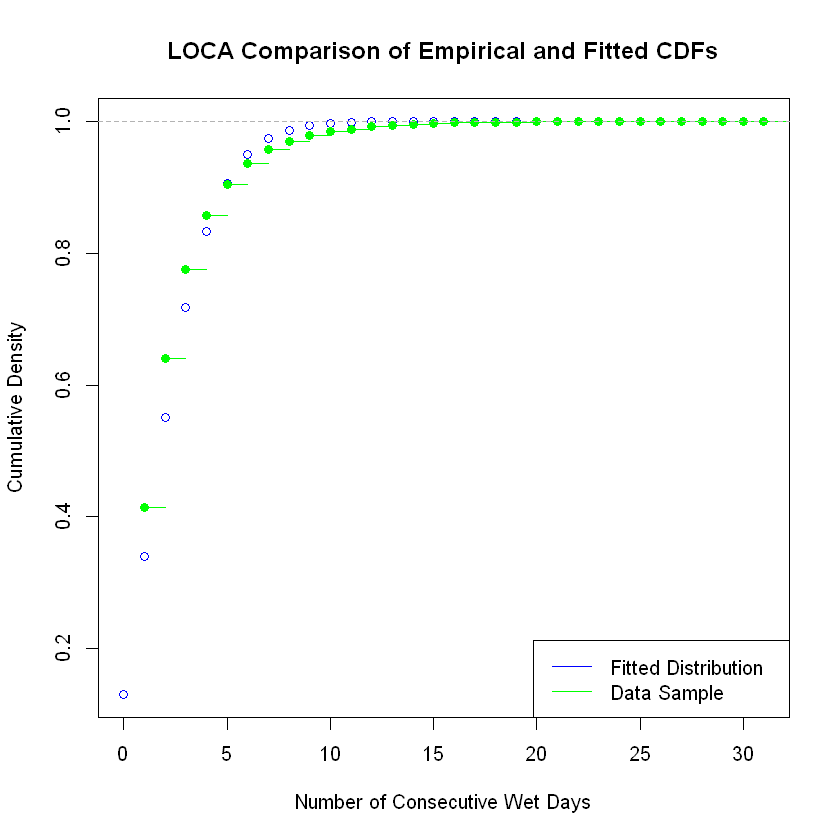

In [360]:
x <- seq(0,dLOJulMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dJul_mu, size=LOfdNB_dJul_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOJul$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

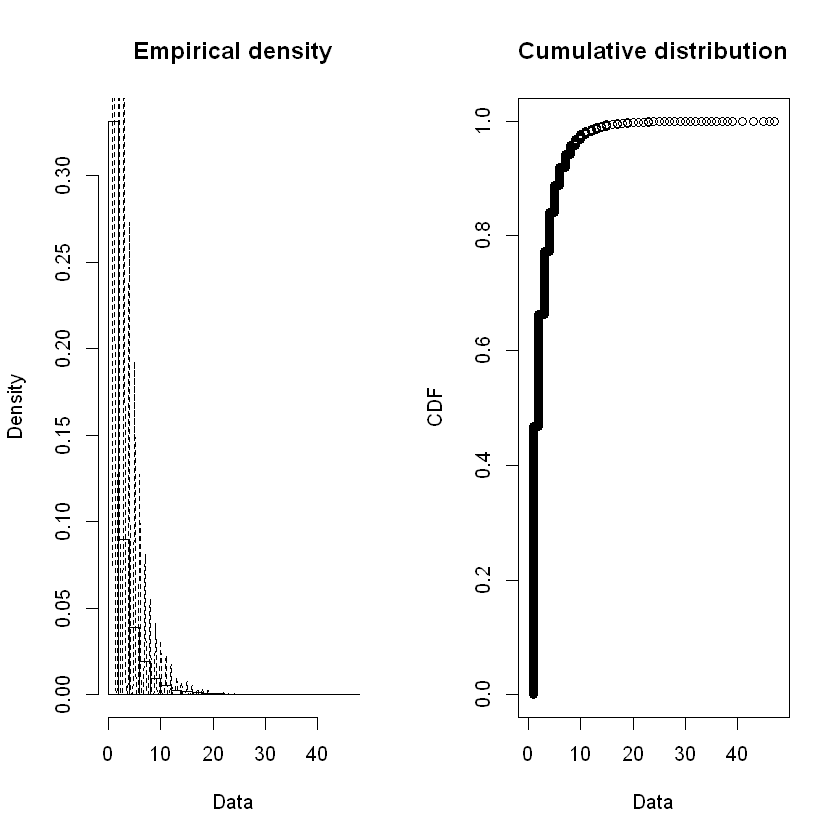

In [361]:
plotdist( dBCJul$Wet_Count, histo=TRUE, demp=TRUE )

In [362]:
BCfd_NB_dJul <- fitdist( dBCJul$Wet_Count, "nbinom" )
BCfd_GE_dJul <- fitdist( dBCJul$Wet_Count, "geom" )

In [363]:
summary( BCfd_NB_dJul )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.820856 0.008039967
mu   2.684850 0.002494616
Loglikelihood:  -1728060   AIC:  3456125   BIC:  3456148 
Correlation matrix:
             size           mu
size 1.000000e+00 3.576598e-05
mu   3.576598e-05 1.000000e+00


In [364]:
BCfdNB_dJul_size <- BCfd_NB_dJul$estimate[["size"]]
BCfdNB_dJul_mu <- BCfd_NB_dJul$estimate[["mu"]]
cat("BCCA Jul size: ", BCfdNB_dJul_size, "\n", "BCCA Jul mu: ", BCfdNB_dJul_mu, "\n")

BCCA Jul size:  2.820856 
 BCCA Jul mu:  2.68485 


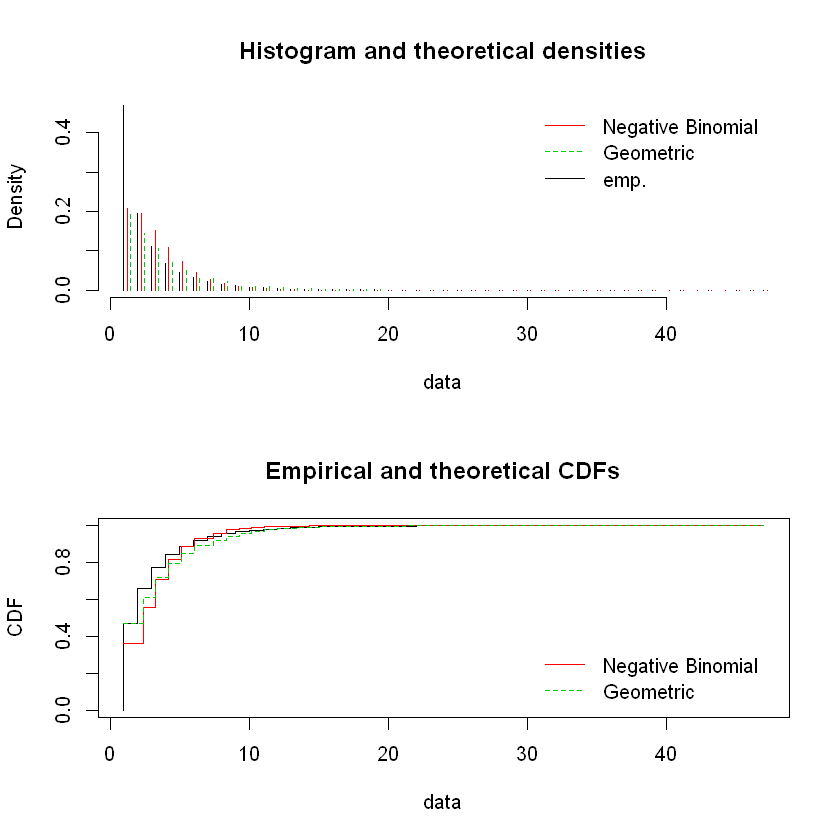

In [365]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dJul, BCfd_GE_dJul), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dJul, BCfd_GE_dJul), legendtext=plot.legend )

In [366]:
BCstatRes <- gofstat( list(BCfd_NB_dJul, BCfd_GE_dJul), fitnames=c("Negative Binomial", "Geometric") )

In [367]:
print(BCstatRes)

Chi-squared statistic:  242563.5 25434.62 
Degree of freedom of the Chi-squared distribution:  13 14 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     394325           303272.38949     395004.588
<= 2     163605           163601.62289     121313.131
<= 3      92579           128202.79892      88391.564
<= 4      58191            90976.94814      64404.146
<= 5      38485            60521.15848      46926.356
<= 6      26795            38469.56387      34191.633
<= 7      18757            23639.42699      24912.818
<= 8      13154            14151.52657      18152.057
<= 9       9558             8297.15854      13226.010
<= 10      6653             4782.83396       9636.778
<= 11      4794             2718.42046       7021.580
<= 12      3787             1526.78299       5116.087
<= 13      2499              848.81733       3727.699
<= 15      3486              723.55211       4695.093
<= 18      2832              254.21575    

In [368]:
BCfdNB_dJul_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [369]:
BCfdNB_dJul_p = BCfdNB_dJul_size / (BCfdNB_dJul_size + BCfdNB_dJul_mu)
cat("BCCA prob: ", BCfdNB_dJul_p)

BCCA prob:  0.5123514

In [370]:
# add to our tracking dataframe
BCMonDistDF[7, ] <- list( 7, dBCJulMean, dBCJulBNr, BCfdNB_dJul_p, BCfdNB_dJul_mu, BCfdNB_dJul_size,
                          BCfdNB_dJul_pvalue )

In [371]:
BCgf_dJul <- goodfit( dBCJul$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dJul_size, prob=BCfdNB_dJul_p) )

In [372]:
summary( BCgf_dJul )


	 Goodness-of-fit test for nbinomial distribution

                        X^2 df P(> X^2)
Pearson          27885892.8 47        0
Likelihood Ratio   534858.8 43        0


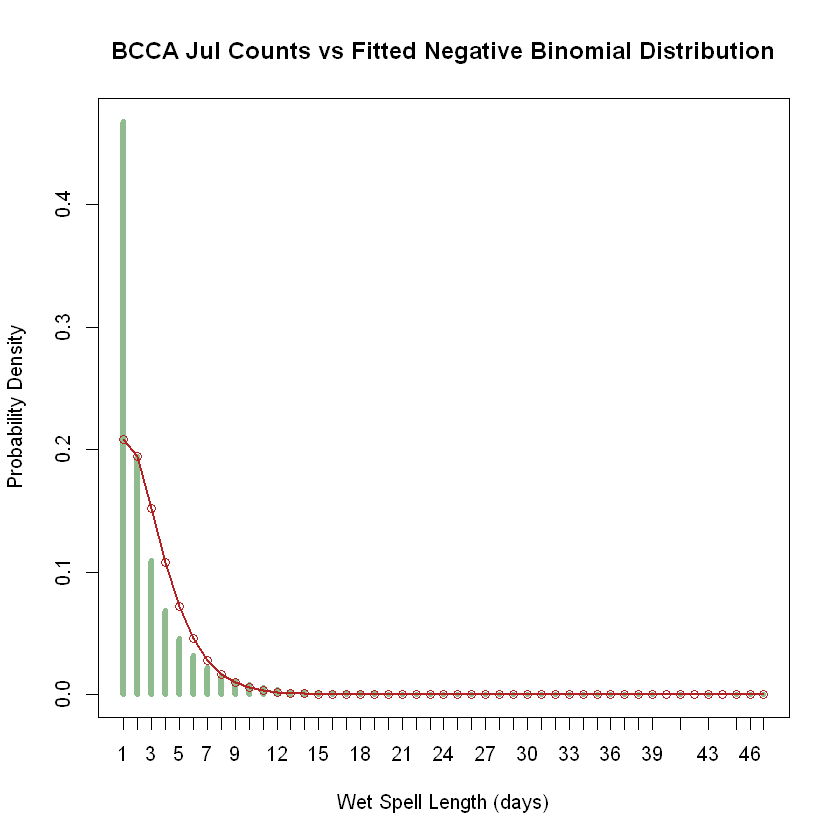

In [373]:
maxP <- max(dBCJul$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dJul_size, mu=BCfdNB_dJul_mu )
ttab <- table( dBCJul$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Jul Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

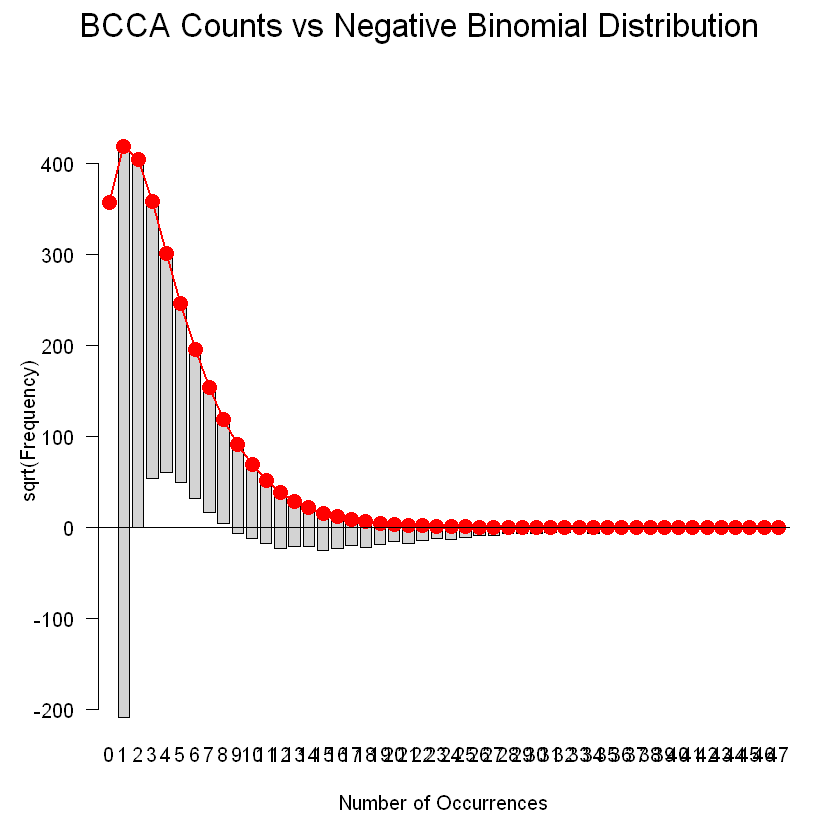

In [374]:
plot( BCgf_dJul, main="BCCA Counts vs Negative Binomial Distribution" )

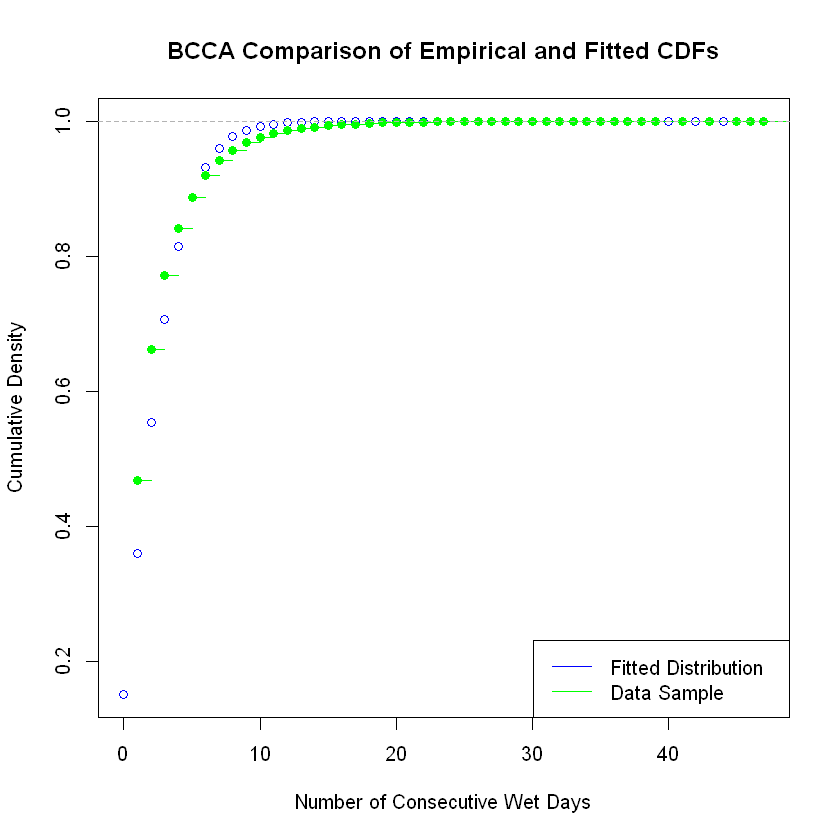

In [375]:
x <- seq(0,dBCJulMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dJul_mu, size=BCfdNB_dJul_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCJul$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

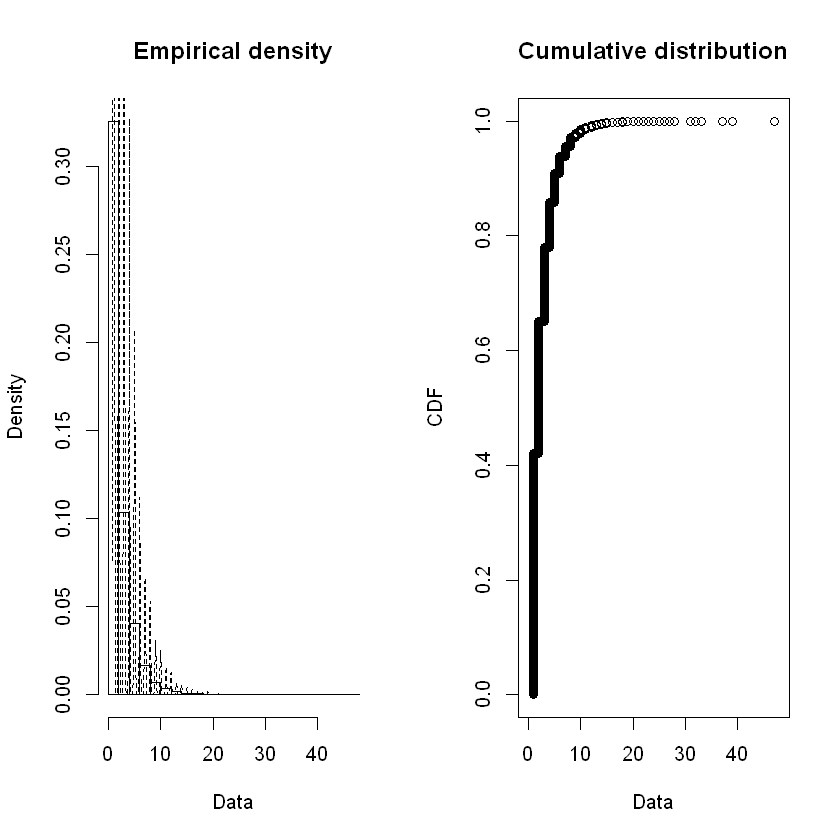

In [376]:
plotdist( dLOAug$Wet_Count, histo=TRUE, demp=TRUE )

In [377]:
LOfd_NB_dAug <- fitdist( dLOAug$Wet_Count, "nbinom" )
LOfd_GE_dAug <- fitdist( dLOAug$Wet_Count, "geom" )

In [378]:
LOfdNB_dAug_size <- LOfd_NB_dAug$estimate[["size"]]
LOfdNB_dAug_mu <- LOfd_NB_dAug$estimate[["mu"]]
cat("LOCA Aug size: ", LOfdNB_dAug_size, "\n", "LOCA Aug mu: ", LOfdNB_dAug_mu, "\n")

LOCA Aug size:  4.270781 
 LOCA Aug mu:  2.590399 


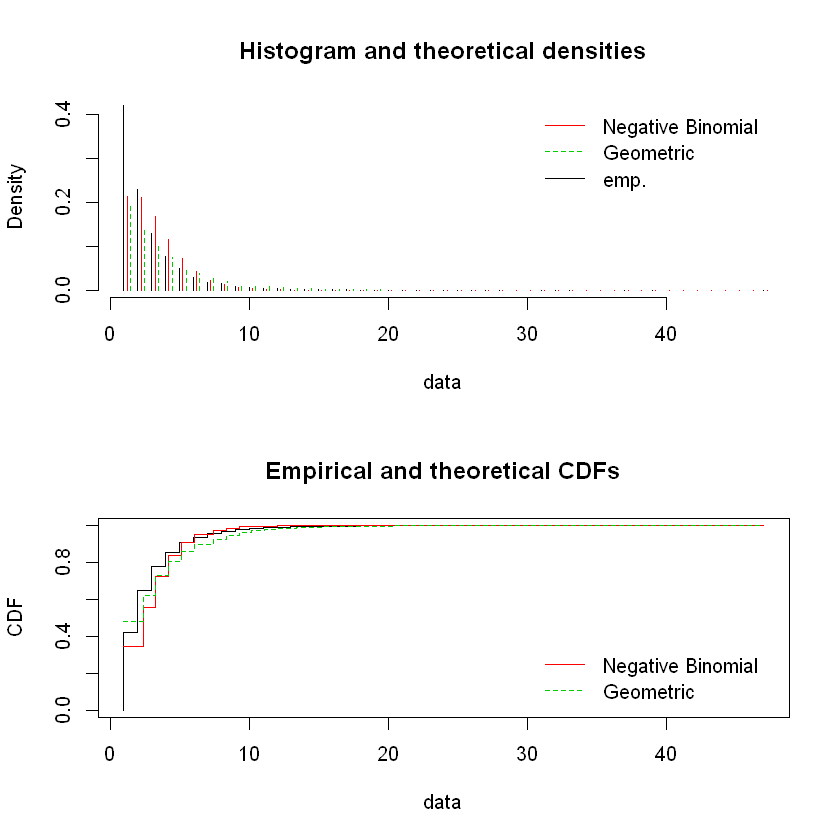

In [379]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dAug, LOfd_GE_dAug), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dAug, LOfd_GE_dAug), legendtext=plot.legend )

In [380]:
LOstatRes <- gofstat( list(LOfd_NB_dAug, LOfd_GE_dAug), fitnames=c("Negative Binomial", "Geometric") )

In [381]:
print( LOstatRes )

Chi-squared statistic:  298134.5 83163.27 
Degree of freedom of the Chi-squared distribution:  12 13 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     430333           352558.35311     490108.426
<= 2     235119           216509.94192     148190.227
<= 3     131545           170862.22738     106913.293
<= 4      79778           117255.97332      77133.644
<= 5      51491            73228.36415      55648.824
<= 6      30602            42718.13099      40148.390
<= 7      18990            23663.85582      28965.449
<= 8      14838            12586.85917      20897.408
<= 9       7889             6479.10334      15076.640
<= 10      6412             3246.22955      10877.190
<= 11      4117             1590.01829       7847.455
<= 12      3507              763.92366       5661.623
<= 14      3609              529.10565       7031.533
<= 17      2422              128.30034       4766.571
> 17       1481               12.61331    

In [382]:
LOfdNB_dAug_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [383]:
LOfdNB_dAug_p = LOfdNB_dAug_size / (LOfdNB_dAug_size + LOfdNB_dAug_mu)
cat("LOCA prob: ", LOfdNB_dAug_p)

LOCA prob:  0.6224558

In [384]:
# add to our tracking dataframe
LOMonDistDF[8, ] <- list( 8, dLOAugMean, dLOAugBNr, LOfdNB_dAug_p, LOfdNB_dAug_mu, LOfdNB_dAug_size,
                          LOfdNB_dAug_pvalue )

In [385]:
LOgf_dAug <- goodfit( dLOAug$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dAug_size, prob=LOfdNB_dAug_p) )

In [386]:
summary( LOgf_dAug )


	 Goodness-of-fit test for nbinomial distribution

                          X^2 df P(> X^2)
Pearson          1.076066e+12 47        0
Likelihood Ratio 5.120105e+05 33        0


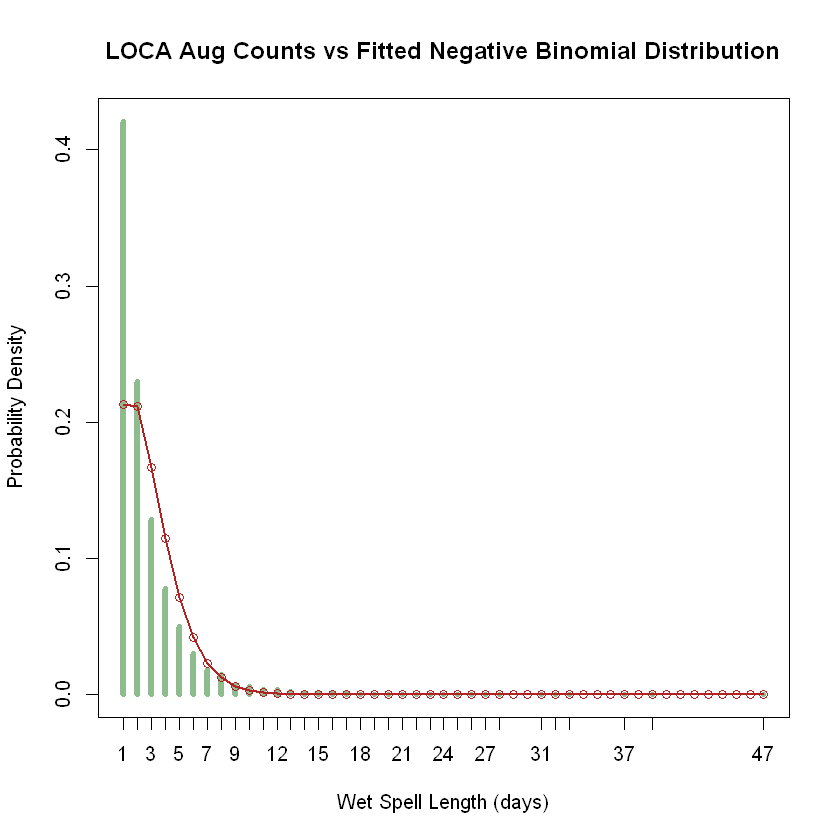

In [387]:
maxP <- max(dLOAug$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dAug_size, mu=LOfdNB_dAug_mu )
ttab <- table( dLOAug$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Aug Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

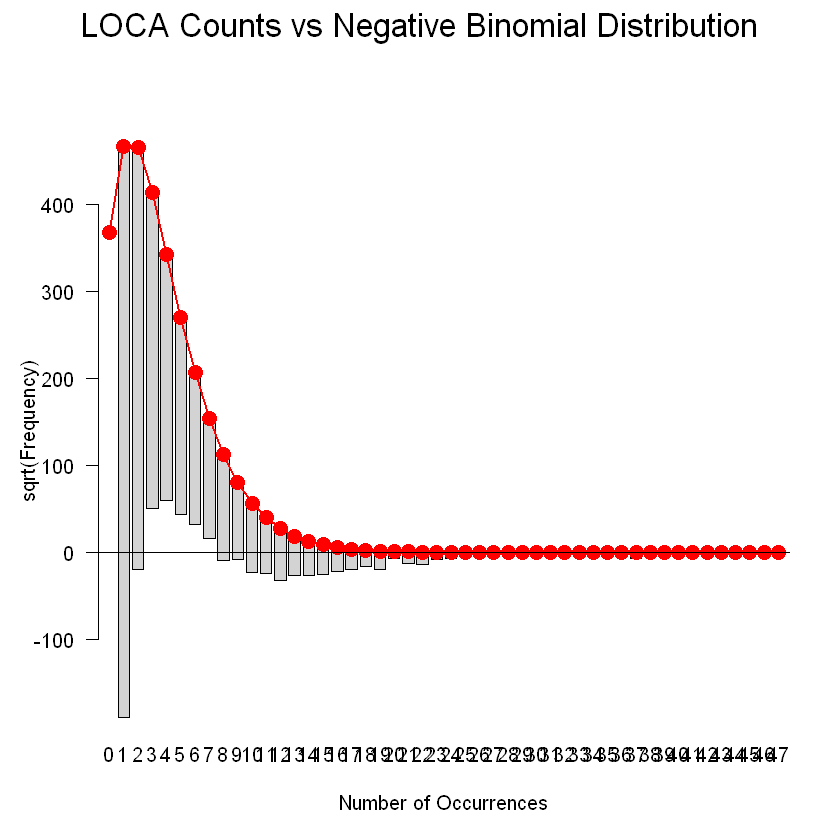

In [388]:
plot( LOgf_dAug, main="LOCA Counts vs Negative Binomial Distribution" )

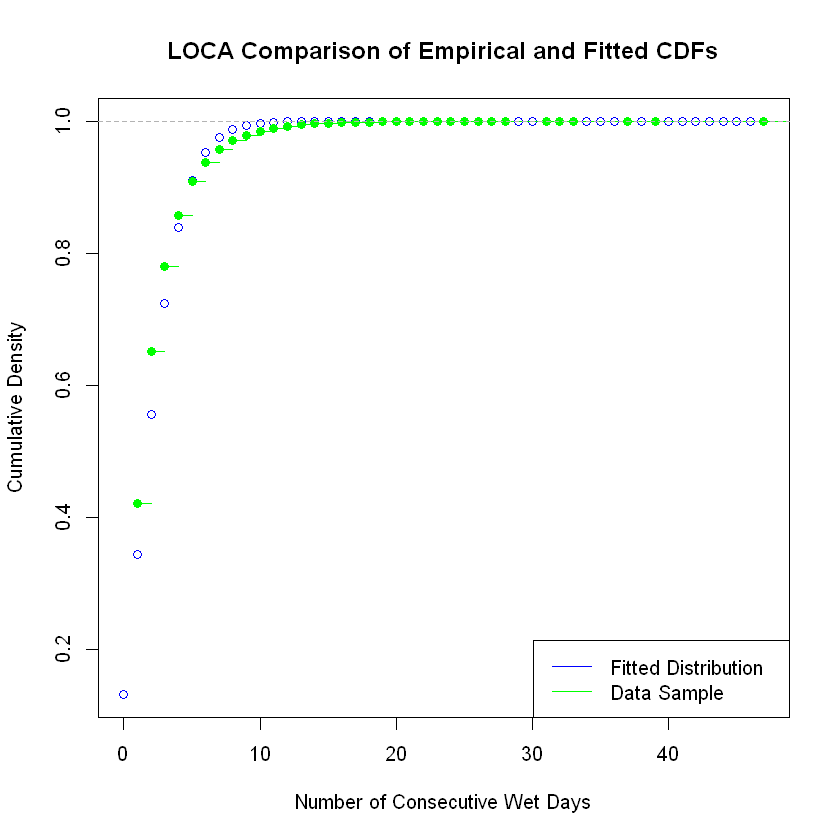

In [389]:
x <- seq(0,dLOAugMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dAug_mu, size=LOfdNB_dAug_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOAug$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

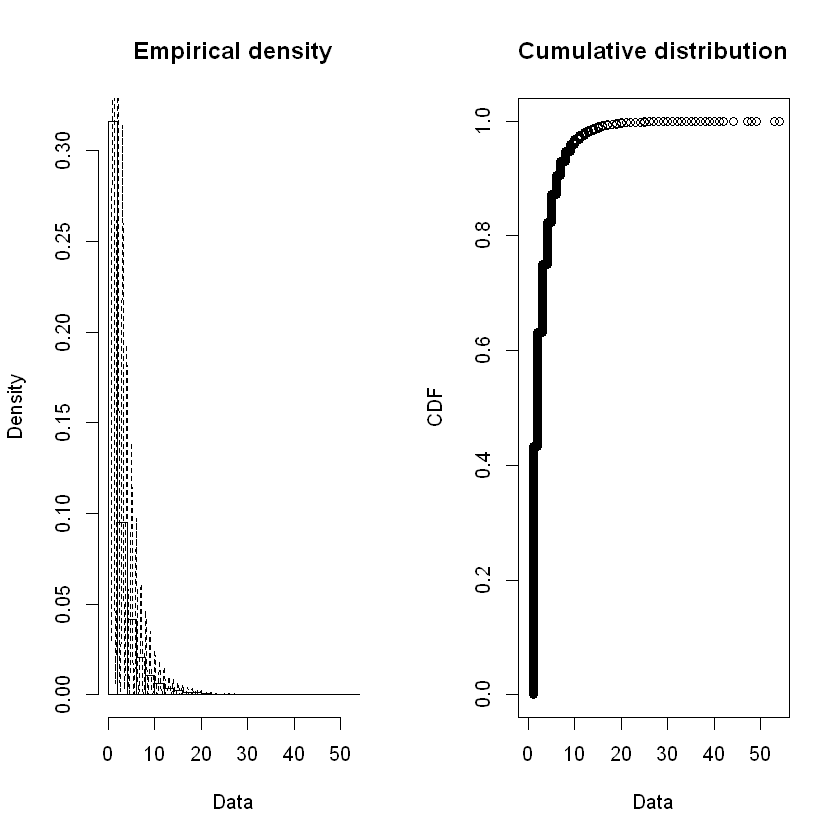

In [390]:
plotdist( dBCAug$Wet_Count, histo=TRUE, demp=TRUE )

In [391]:
BCfd_NB_dAug <- fitdist( dBCAug$Wet_Count, "nbinom" )
BCfd_GE_dAug <- fitdist( dBCAug$Wet_Count, "geom" )

In [392]:
summary( BCfd_NB_dAug )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.523428 0.006464005
mu   2.895815 0.002649018
Loglikelihood:  -1887051   AIC:  3774106   BIC:  3774129 
Correlation matrix:
              size            mu
size  1.000000e+00 -7.815465e-05
mu   -7.815465e-05  1.000000e+00


In [393]:
BCfdNB_dAug_size <- BCfd_NB_dAug$estimate[["size"]]
BCfdNB_dAug_mu <- BCfd_NB_dAug$estimate[["mu"]]
cat("BCCA Aug size: ", BCfdNB_dAug_size, "\n", "BCCA Aug mu: ", BCfdNB_dAug_mu, "\n")

BCCA Aug size:  2.523428 
 BCCA Aug mu:  2.895815 


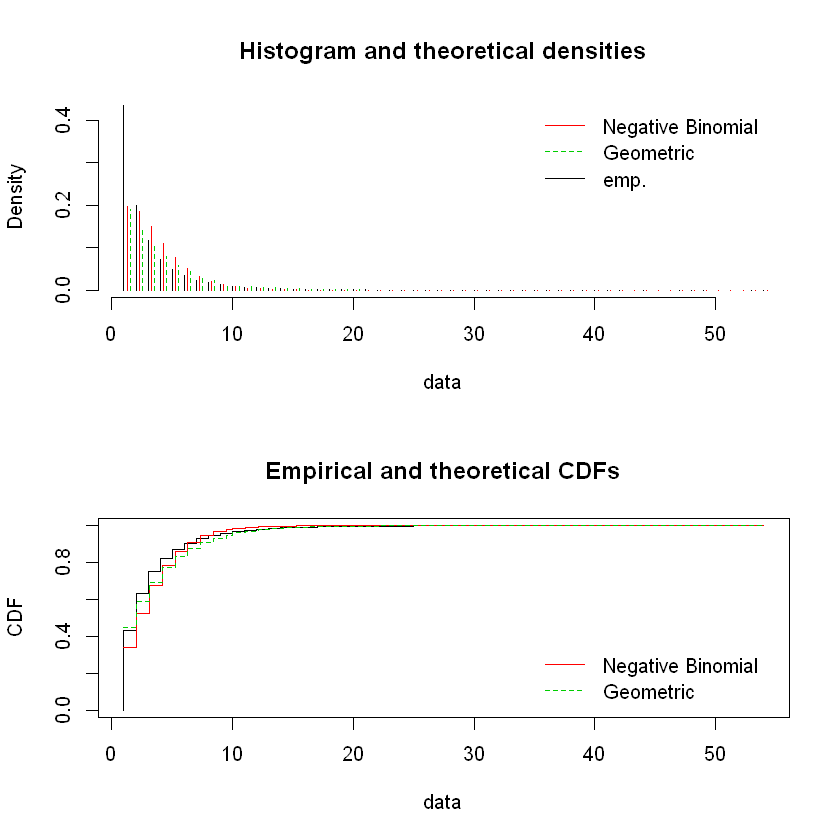

In [394]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dAug, BCfd_GE_dAug), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dAug, BCfd_GE_dAug), legendtext=plot.legend )

In [395]:
BCstatRes <- gofstat( list(BCfd_NB_dAug, BCfd_GE_dAug), fitnames=c("Negative Binomial", "Geometric") )

In [396]:
print(BCstatRes)

Chi-squared statistic:  279174.1 33745.36 
Degree of freedom of the Chi-squared distribution:  15 16 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     384248           302490.45968     396620.331
<= 2     176243           163503.76915     125699.942
<= 3     103936           131736.57397      93433.309
<= 4      64837            97204.69502      69449.382
<= 5      43737            67768.09606      51622.025
<= 6      29942            45406.91304      38370.874
<= 7      20959            29544.07588      28521.236
<= 8      15557            18793.42358      21199.958
<= 9      11252            11742.29005      15758.020
<= 10      7966             7230.47243      11713.004
<= 11      6030             4398.75112       8706.327
<= 12      4750             2648.90947       6471.450
<= 13      3379             1581.33935       4810.257
<= 14      2863              936.95095       3575.485
<= 16      3928              874.28281    

In [397]:
BCfdNB_dAug_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [398]:
BCfdNB_dAug_p = BCfdNB_dAug_size / (BCfdNB_dAug_size + BCfdNB_dAug_mu)
cat("BCCA prob: ", BCfdNB_dAug_p)

BCCA prob:  0.4656422

In [399]:
# add to our tracking dataframe
BCMonDistDF[8, ] <- list( 8, dBCAugMean, dBCAugBNr, BCfdNB_dAug_p, BCfdNB_dAug_mu, BCfdNB_dAug_size,
                          BCfdNB_dAug_pvalue )

In [400]:
BCgf_dAug <- goodfit( dBCAug$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dAug_size, prob=BCfdNB_dAug_p) )

In [401]:
summary( BCgf_dAug )


	 Goodness-of-fit test for nbinomial distribution

                        X^2 df P(> X^2)
Pearson          41683541.3 54        0
Likelihood Ratio   528982.8 47        0


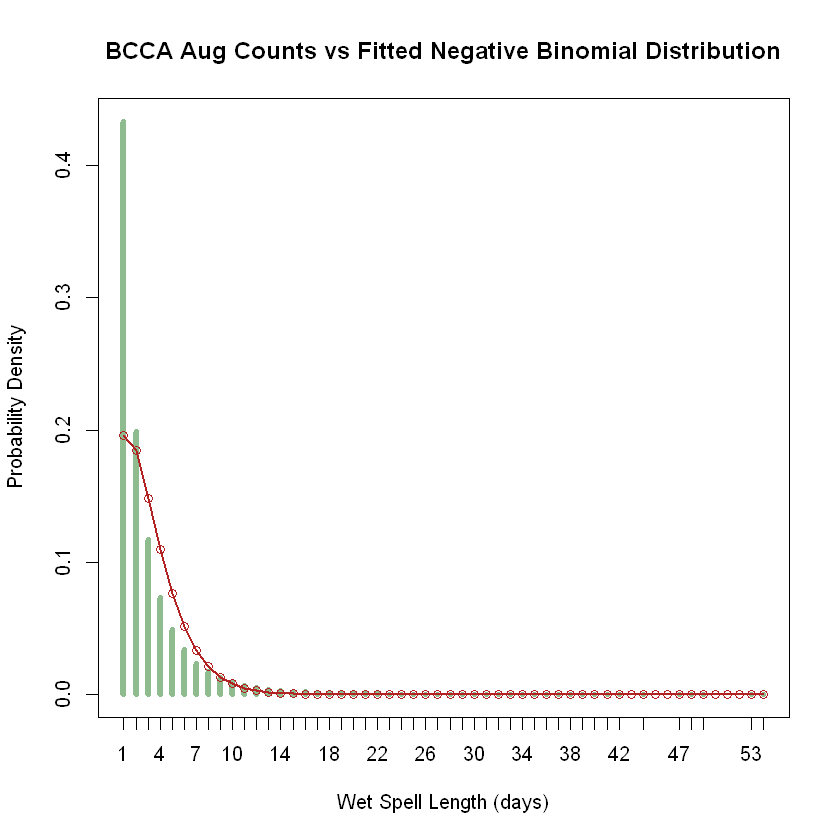

In [402]:
maxP <- max(dBCAug$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dAug_size, mu=BCfdNB_dAug_mu )
ttab <- table( dBCAug$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Aug Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

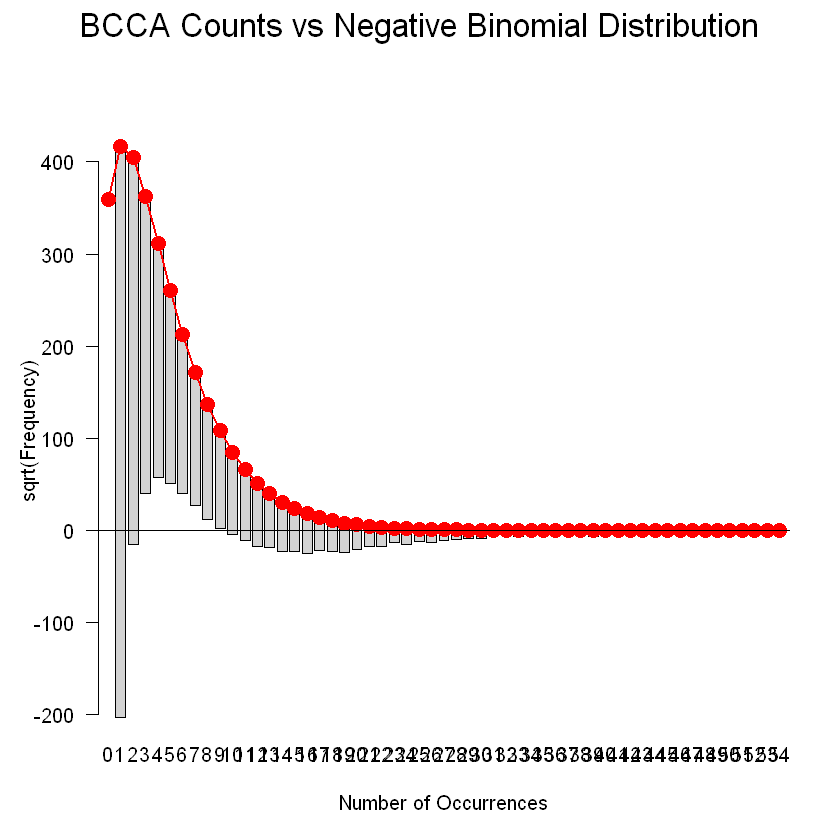

In [403]:
plot( BCgf_dAug, main="BCCA Counts vs Negative Binomial Distribution" )

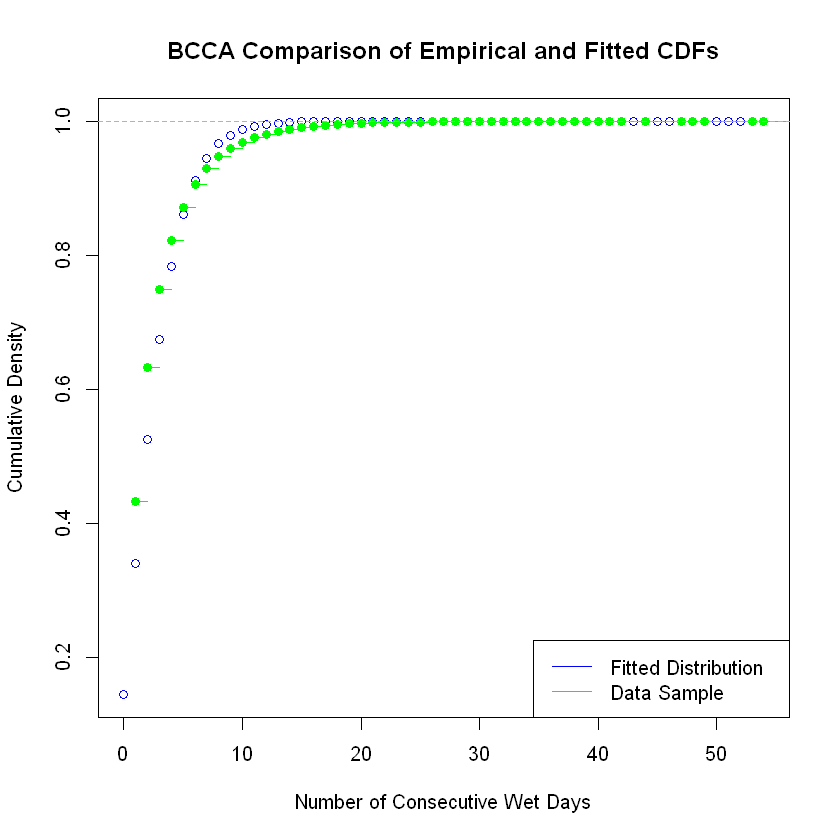

In [404]:
x <- seq(0,dBCAugMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dAug_mu, size=BCfdNB_dAug_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCAug$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

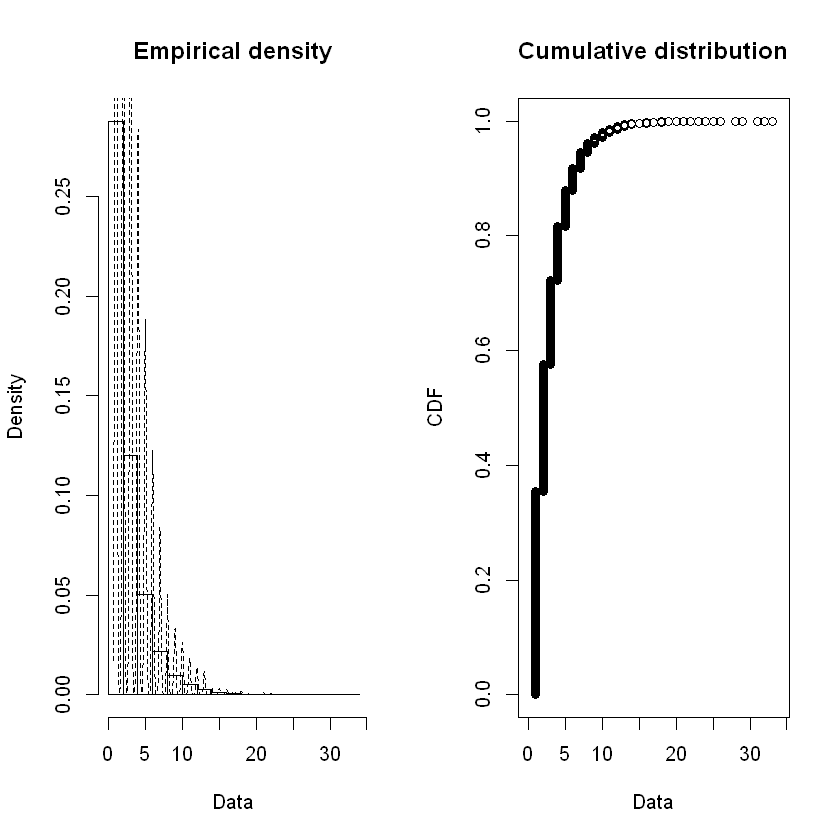

In [405]:
plotdist( dLOSep$Wet_Count, histo=TRUE, demp=TRUE )

In [406]:
LOfd_NB_dSep <- fitdist( dLOSep$Wet_Count, "nbinom" )
LOfd_GE_dSep <- fitdist( dLOSep$Wet_Count, "geom" )

In [407]:
LOfdNB_dSep_size <- LOfd_NB_dSep$estimate[["size"]]
LOfdNB_dSep_mu <- LOfd_NB_dSep$estimate[["mu"]]
cat("LOCA Sep size: ", LOfdNB_dSep_size, "\n", "LOCA Sep mu: ", LOfdNB_dSep_mu, "\n")

LOCA Sep size:  4.091652 
 LOCA Sep mu:  2.917294 


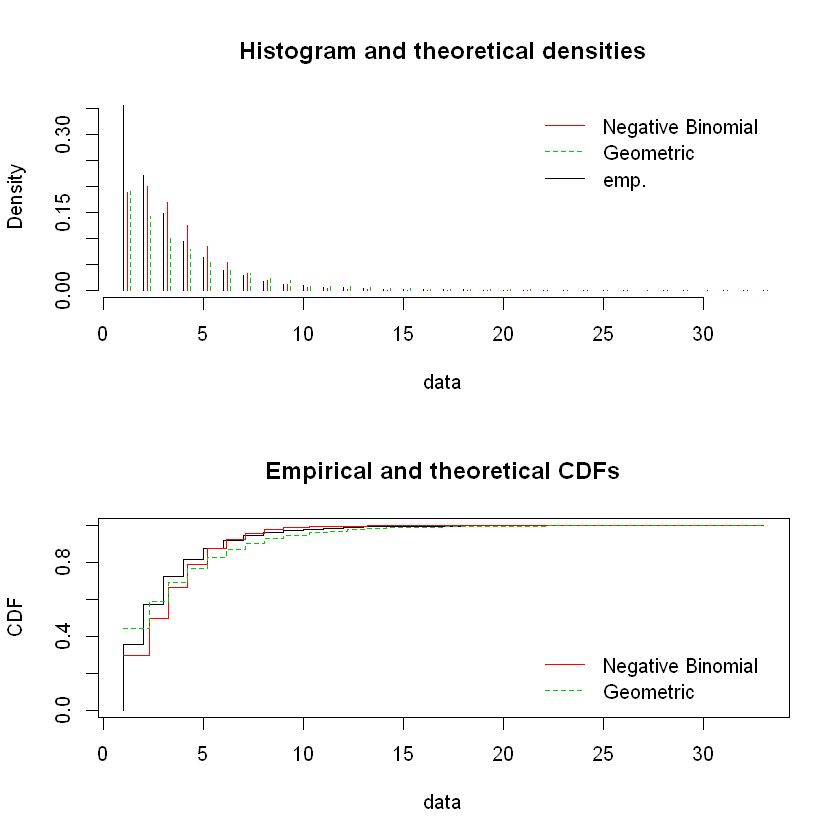

In [408]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dSep, LOfd_GE_dSep), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dSep, LOfd_GE_dSep), legendtext=plot.legend )

In [409]:
LOstatRes <- gofstat( list(LOfd_NB_dSep, LOfd_GE_dSep), fitnames=c("Negative Binomial", "Geometric") )

In [410]:
print( LOstatRes )

Chi-squared statistic:  123384.7 120966.9 
Degree of freedom of the Chi-squared distribution:  12 13 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     419191            353384.0308     526694.299
<= 2     261813            235926.1386     167428.784
<= 3     173693            199396.4482     124689.610
<= 4     110862            147140.5469      92860.370
<= 5      73653             99112.1913      69156.110
<= 6      45857             62509.5179      51502.783
<= 7      32429             37509.2077      38355.782
<= 8      18842             21645.7009      28564.787
<= 9      13046             12104.3729      21273.117
<= 10     10262              6595.7511      15842.776
<= 11      7073              3516.9079      11798.625
<= 12      5361              1840.9587       8786.817
<= 13      4433               948.4814       6543.825
<= 16      3565               844.0771      11205.687
> 16       2509               114.6686    

In [411]:
LOfdNB_dSep_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [412]:
LOfdNB_dSep_p = LOfdNB_dSep_size / (LOfdNB_dSep_size + LOfdNB_dSep_mu)
cat("LOCA prob: ", LOfdNB_dSep_p)

LOCA prob:  0.5837756

In [413]:
# add to our tracking dataframe
LOMonDistDF[9, ] <- list( 9, dLOSepMean, dLOSepBNr, LOfdNB_dSep_p, LOfdNB_dSep_mu, LOfdNB_dSep_size,
                          LOfdNB_dSep_pvalue )

In [414]:
LOgf_dSep <- goodfit( dLOSep$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dSep_size, prob=LOfdNB_dSep_p) )

In [415]:
summary( LOgf_dSep )


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          3230585.6 33        0
Likelihood Ratio  462573.3 30        0


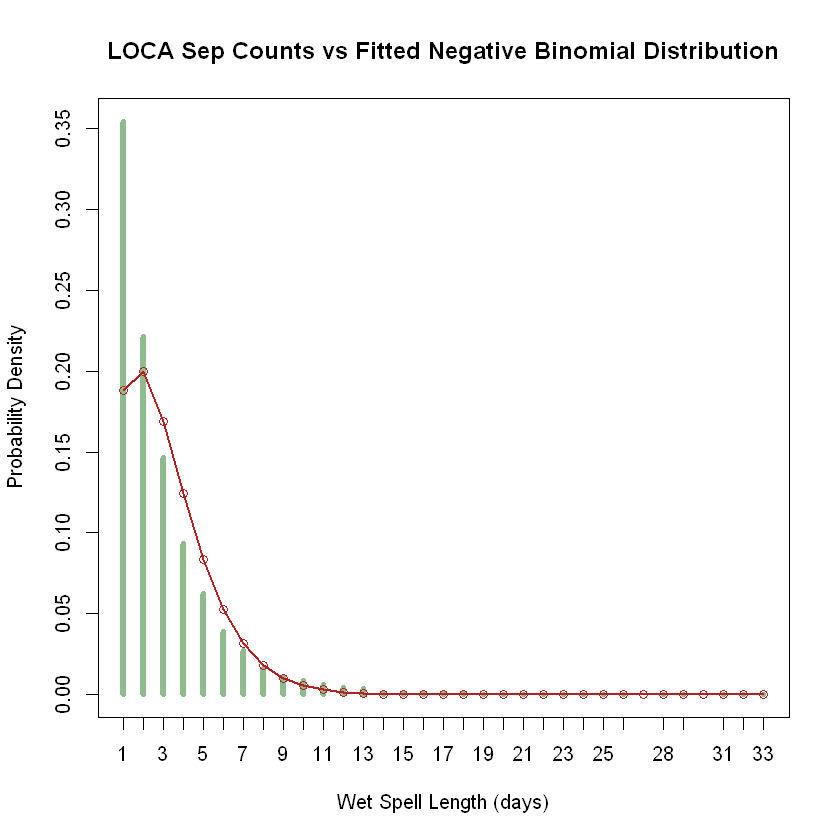

In [416]:
maxP <- max(dLOSep$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dSep_size, mu=LOfdNB_dSep_mu )
ttab <- table( dLOSep$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Sep Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

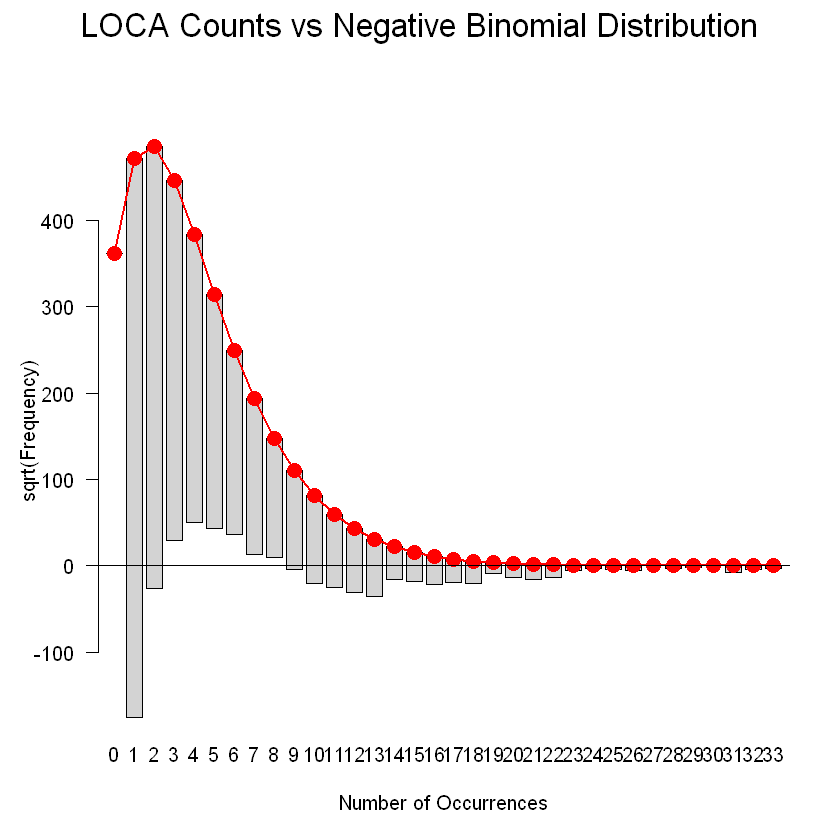

In [417]:
plot( LOgf_dSep, main="LOCA Counts vs Negative Binomial Distribution" )

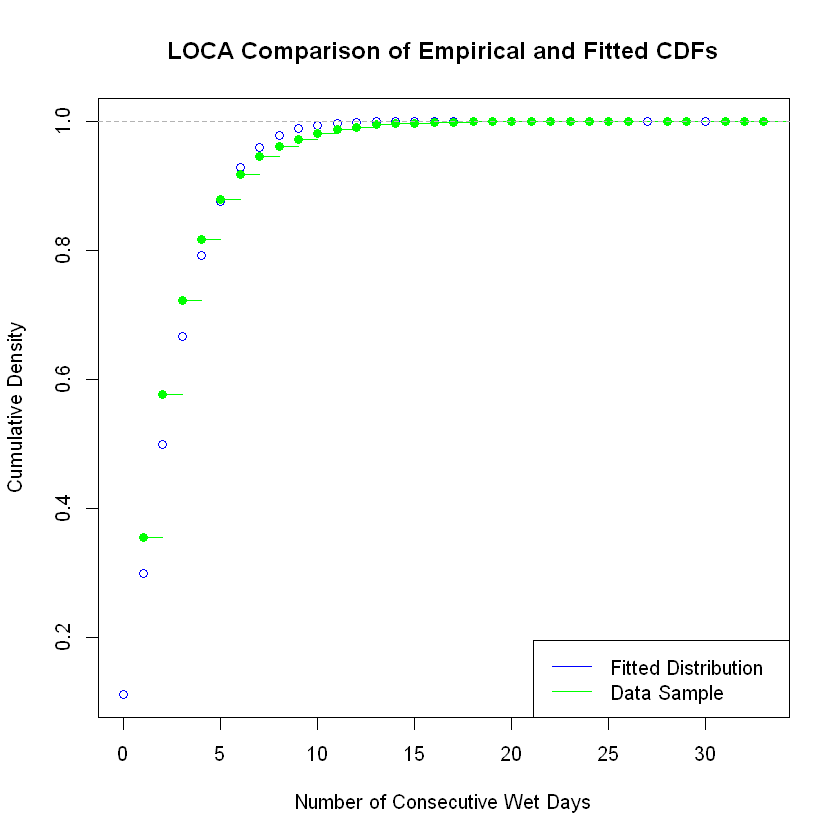

In [418]:
x <- seq(0,dLOSepMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dSep_mu, size=LOfdNB_dSep_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOSep$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

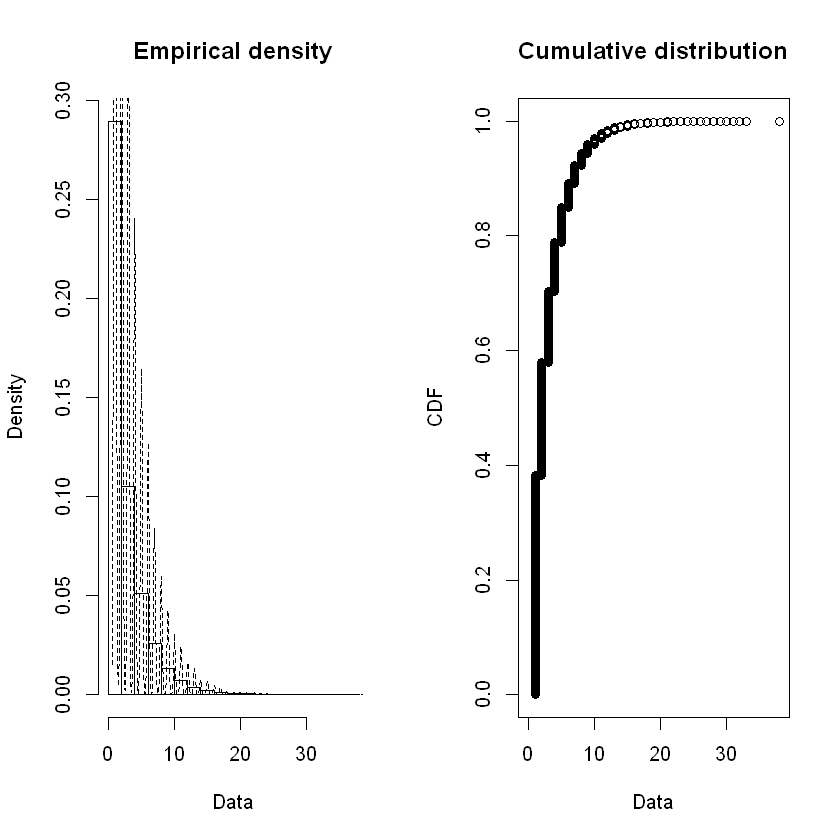

In [419]:
plotdist( dBCSep$Wet_Count, histo=TRUE, demp=TRUE )

In [420]:
BCfd_NB_dSep <- fitdist( dBCSep$Wet_Count, "nbinom" )
BCfd_GE_dSep <- fitdist( dBCSep$Wet_Count, "geom" )

In [421]:
summary( BCfd_NB_dSep )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.885480 0.008264540
mu   3.089337 0.002832541
Loglikelihood:  -1726039   AIC:  3452083   BIC:  3452106 
Correlation matrix:
              size            mu
size  1.0000000000 -0.0002198616
mu   -0.0002198616  1.0000000000


In [422]:
BCfdNB_dSep_size <- BCfd_NB_dSep$estimate[["size"]]
BCfdNB_dSep_mu <- BCfd_NB_dSep$estimate[["mu"]]
cat("BCCA Sep size: ", BCfdNB_dSep_size, "\n", "BCCA Sep mu: ", BCfdNB_dSep_mu, "\n")

BCCA Sep size:  2.88548 
 BCCA Sep mu:  3.089337 


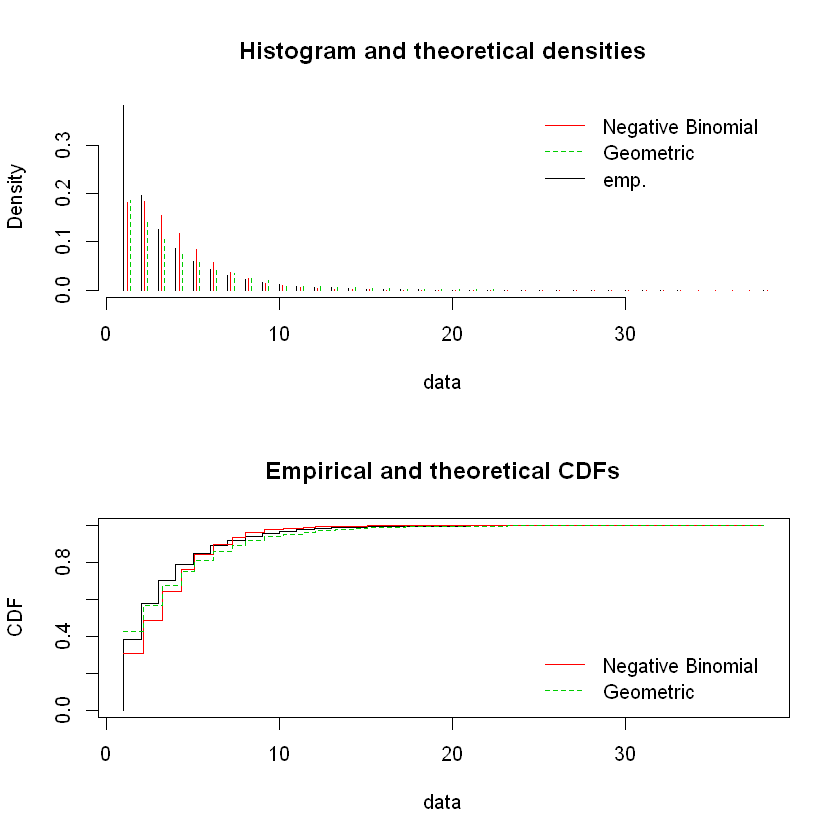

In [423]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dSep, BCfd_GE_dSep), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dSep, BCfd_GE_dSep), legendtext=plot.legend )

In [424]:
BCstatRes <- gofstat( list(BCfd_NB_dSep, BCfd_GE_dSep), fitnames=c("Negative Binomial", "Geometric") )

In [425]:
print(BCstatRes)

Chi-squared statistic:  90153.69 33469.99 
Degree of freedom of the Chi-squared distribution:  14 15 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     304570           243294.25701     342362.221
<= 2     157000           146320.08713     111300.354
<= 3      99620           123205.64209      84080.338
<= 4      68165            93733.13622      63517.347
<= 5      47927            66741.81555      47983.316
<= 6      33881            45353.99513      36248.343
<= 7      24325            29767.27290      27383.318
<= 8      16914            19018.99080      20686.355
<= 9      12242            11894.14384      15627.225
<= 10      8816             7309.54853      11805.375
<= 11      6920             4427.30163       8918.210
<= 12      4542             2648.86242       6737.140
<= 13      3750             1568.26530       5089.481
<= 14      2115              920.09459       3844.779
<= 16      3324              845.08395    

In [426]:
BCfdNB_dSep_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [427]:
BCfdNB_dSep_p = BCfdNB_dSep_size / (BCfdNB_dSep_size + BCfdNB_dSep_mu)
cat("BCCA prob: ", BCfdNB_dSep_p)

BCCA prob:  0.4829404

In [428]:
# add to our tracking dataframe
BCMonDistDF[9, ] <- list( 9, dBCSepMean, dBCSepBNr, BCfdNB_dSep_p, BCfdNB_dSep_mu, BCfdNB_dSep_size,
                          BCfdNB_dSep_pvalue )

In [429]:
BCgf_dSep <- goodfit( dBCSep$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dSep_size, prob=BCfdNB_dSep_p) )

In [430]:
summary( BCgf_dSep )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          359234.8 38        0
Likelihood Ratio 370496.2 33        0


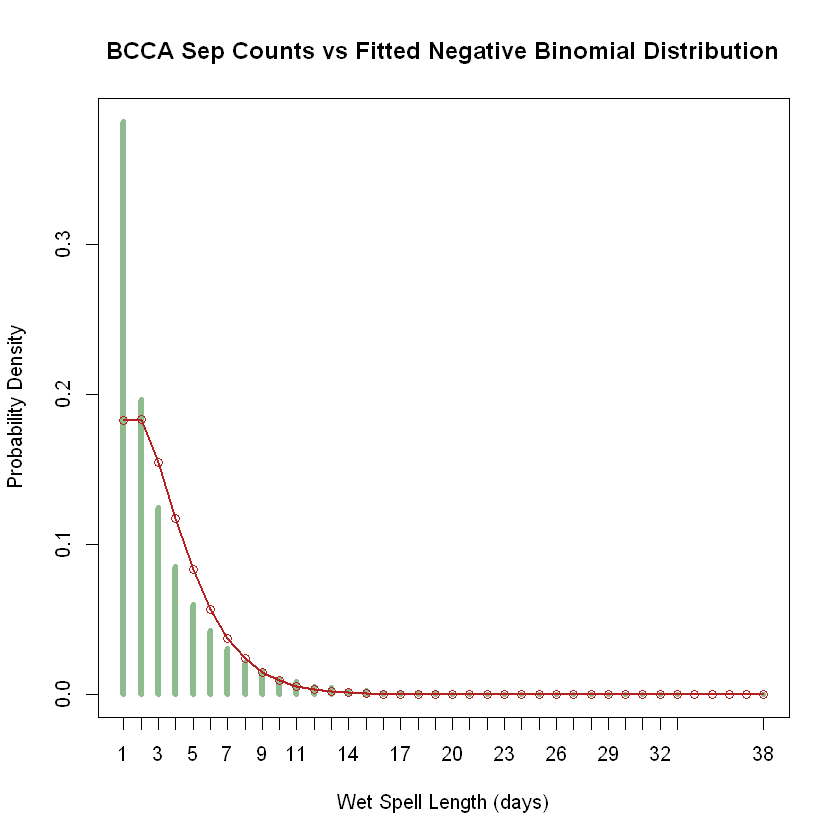

In [431]:
maxP <- max(dBCSep$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dSep_size, mu=BCfdNB_dSep_mu )
ttab <- table( dBCSep$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Sep Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

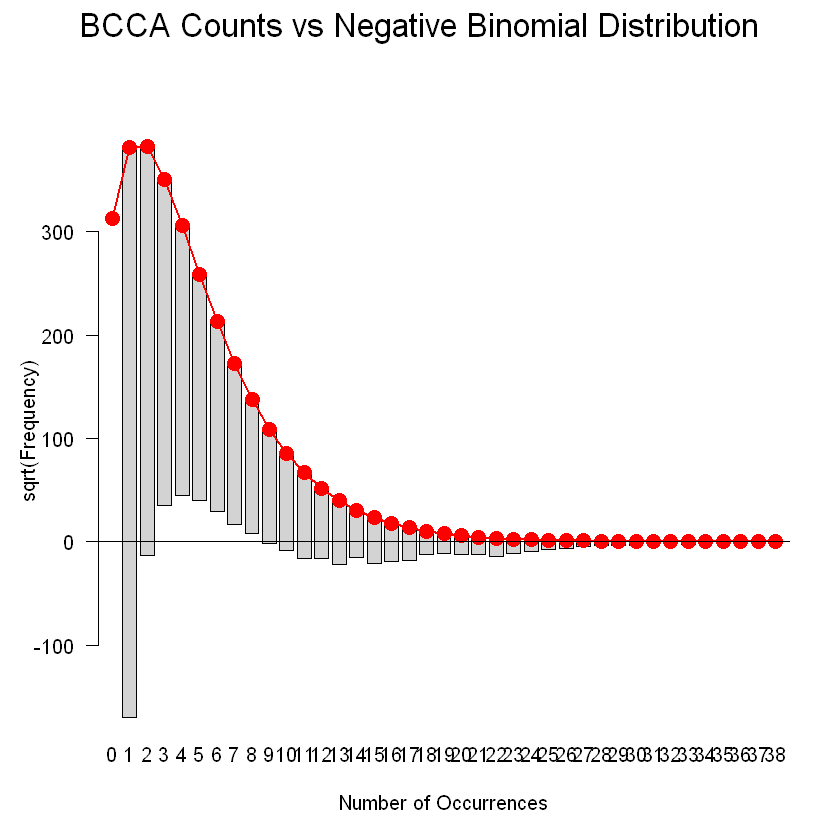

In [432]:
plot( BCgf_dSep, main="BCCA Counts vs Negative Binomial Distribution" )

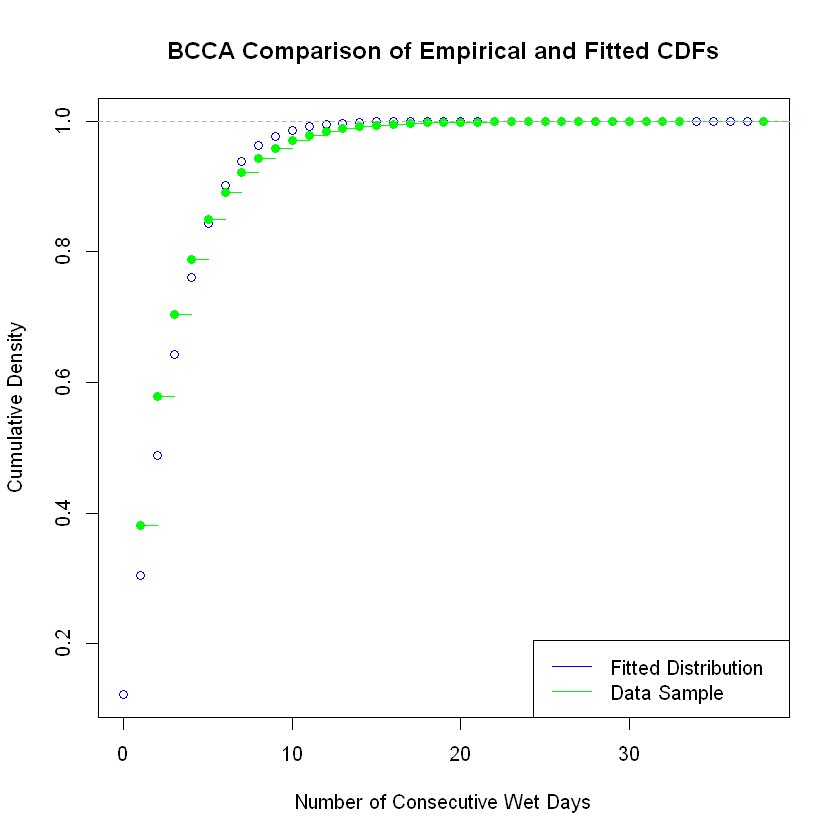

In [433]:
x <- seq(0,dBCSepMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dSep_mu, size=BCfdNB_dSep_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCSep$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

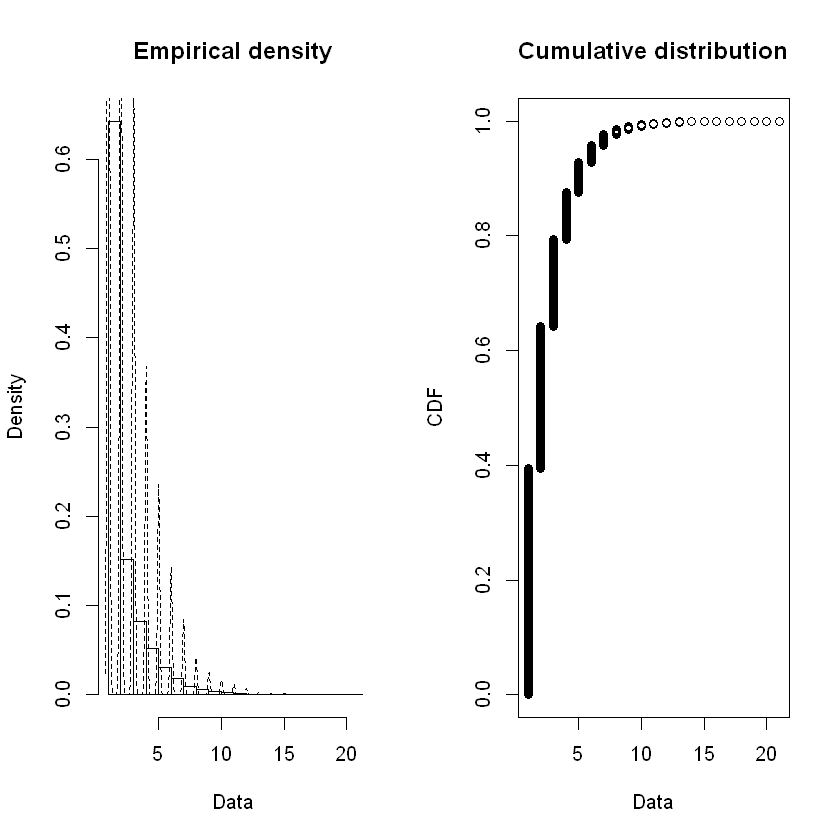

In [434]:
plotdist( dLOOct$Wet_Count, histo=TRUE, demp=TRUE )

In [435]:
LOfd_NB_dOct <- fitdist( dLOOct$Wet_Count, "nbinom" )
LOfd_GE_dOct <- fitdist( dLOOct$Wet_Count, "geom" )

In [436]:
LOfdNB_dOct_size <- LOfd_NB_dOct$estimate[["size"]]
LOfdNB_dOct_mu <- LOfd_NB_dOct$estimate[["mu"]]
cat("LOCA Oct size: ", LOfdNB_dOct_size, "\n", "LOCA Oct mu: ", LOfdNB_dOct_mu, "\n")

LOCA Oct size:  9.159081 
 LOCA Oct mu:  2.466895 


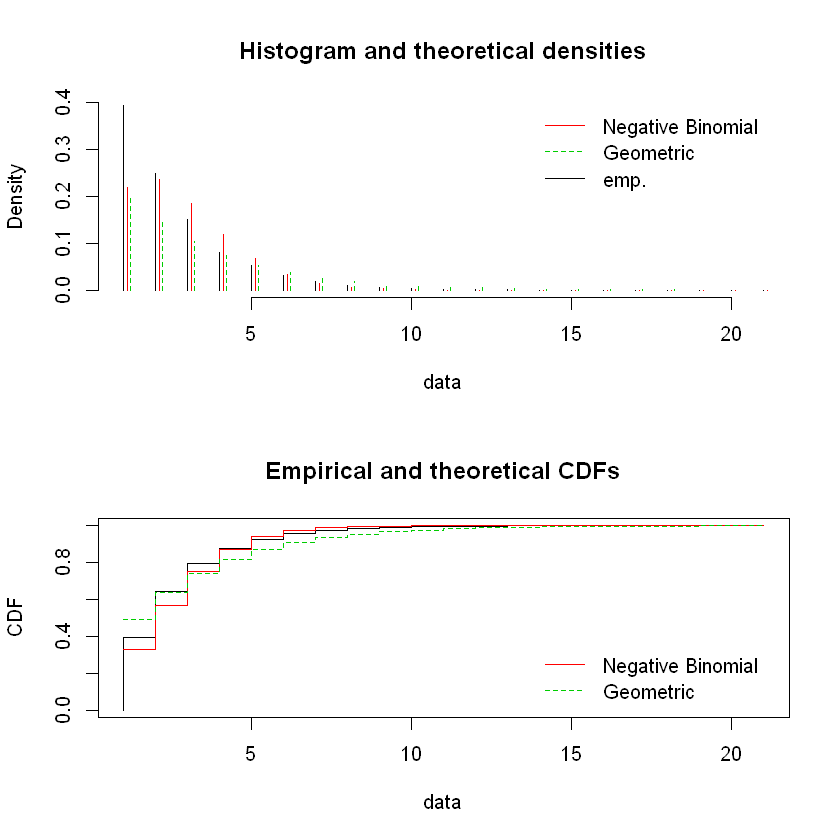

In [437]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dOct, LOfd_GE_dOct), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dOct, LOfd_GE_dOct), legendtext=plot.legend )

In [438]:
LOstatRes <- gofstat( list(LOfd_NB_dOct, LOfd_GE_dOct), fitnames=c("Negative Binomial", "Geometric") )

In [439]:
print( LOstatRes )

Chi-squared statistic:  102757.6 158950.8 
Degree of freedom of the Chi-squared distribution:  9 10 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     426594            358735.2439     534601.300
<= 2     269393            255291.4565     158149.795
<= 3     164109            201495.1751     112534.328
<= 4      88298            129965.0587      80075.822
<= 5      56089             72577.7265      56979.390
<= 6      33228             36341.9622      40544.708
<= 7      19535             16699.5360      28850.315
<= 8       9828              7157.3503      20528.960
<= 9       5879              2895.5095      14607.750
<= 10      3967              1115.6810      10394.407
<= 11      2821               412.3284       7396.327
> 11       3169               222.9717      18246.896

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           4025619   4510938
Bayesia

In [440]:
LOfdNB_dOct_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [441]:
LOfdNB_dOct_p = LOfdNB_dOct_size / (LOfdNB_dOct_size + LOfdNB_dOct_mu)
cat("LOCA prob: ", LOfdNB_dOct_p)

LOCA prob:  0.7878118

In [442]:
# add to our tracking dataframe
LOMonDistDF[10, ] <- list( 10, dLOOctMean, dLOOctBNr, LOfdNB_dOct_p, LOfdNB_dOct_mu, LOfdNB_dOct_size,
                          LOfdNB_dOct_pvalue )

In [443]:
LOgf_dOct <- goodfit( dLOOct$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dOct_size, prob=LOfdNB_dOct_p) )

In [444]:
summary( LOgf_dOct )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          449856.5 21        0
Likelihood Ratio 420529.7 20        0


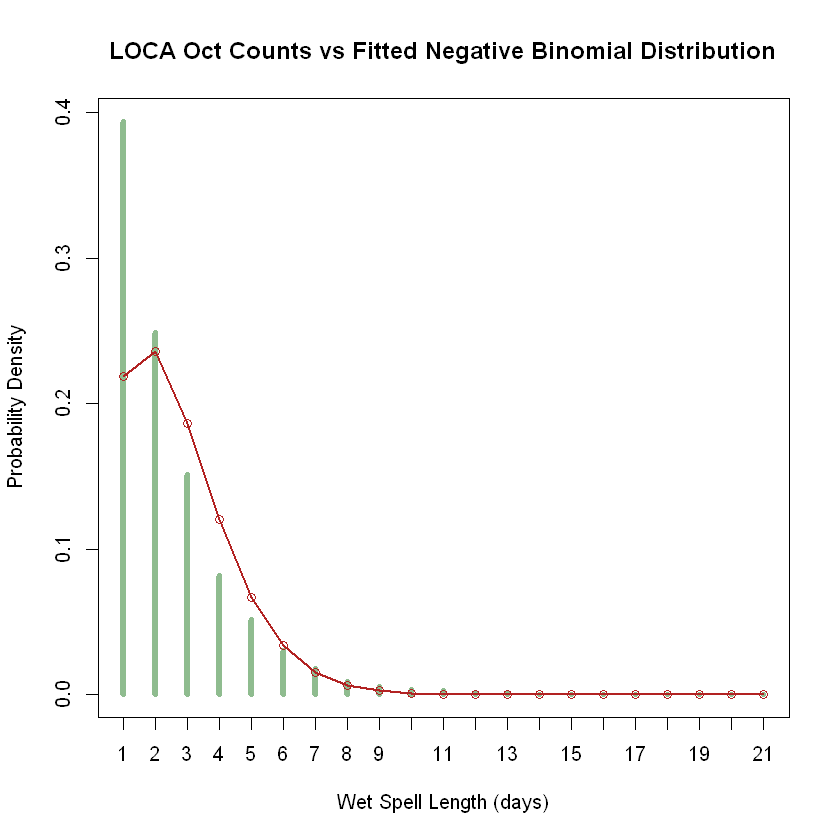

In [445]:
maxP <- max(dLOOct$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dOct_size, mu=LOfdNB_dOct_mu )
ttab <- table( dLOOct$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Oct Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

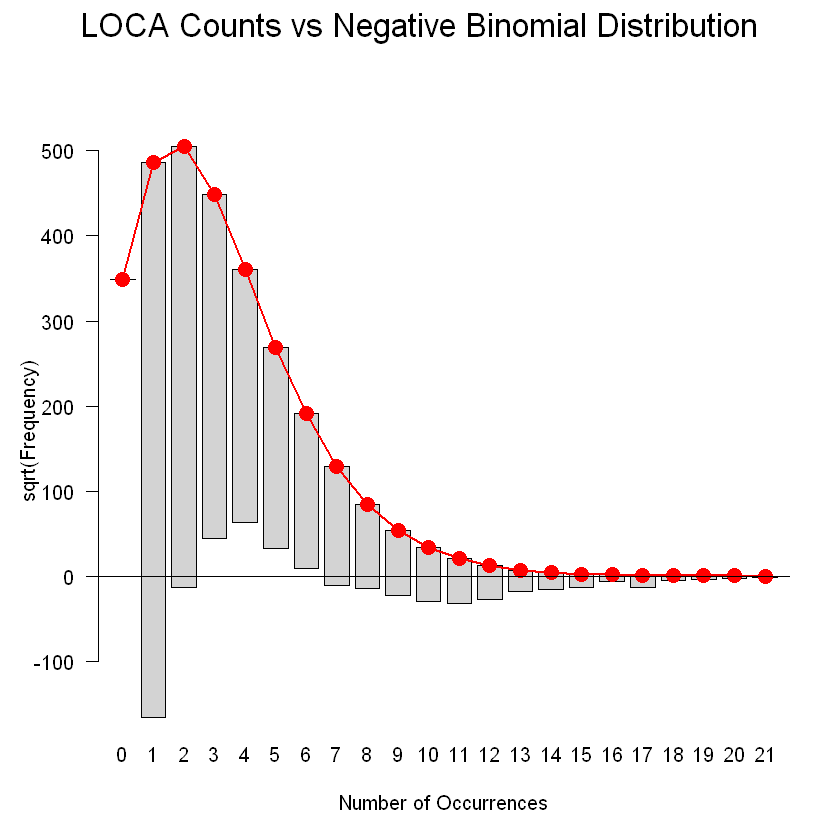

In [446]:
plot( LOgf_dOct, main="LOCA Counts vs Negative Binomial Distribution" )

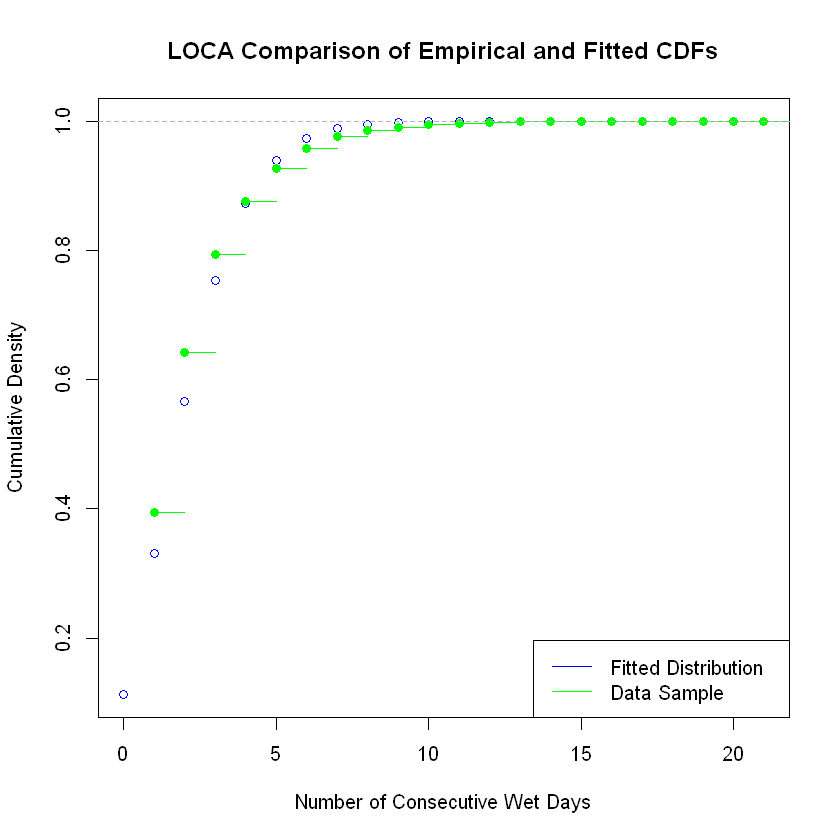

In [447]:
x <- seq(0,dLOOctMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dOct_mu, size=LOfdNB_dOct_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOOct$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

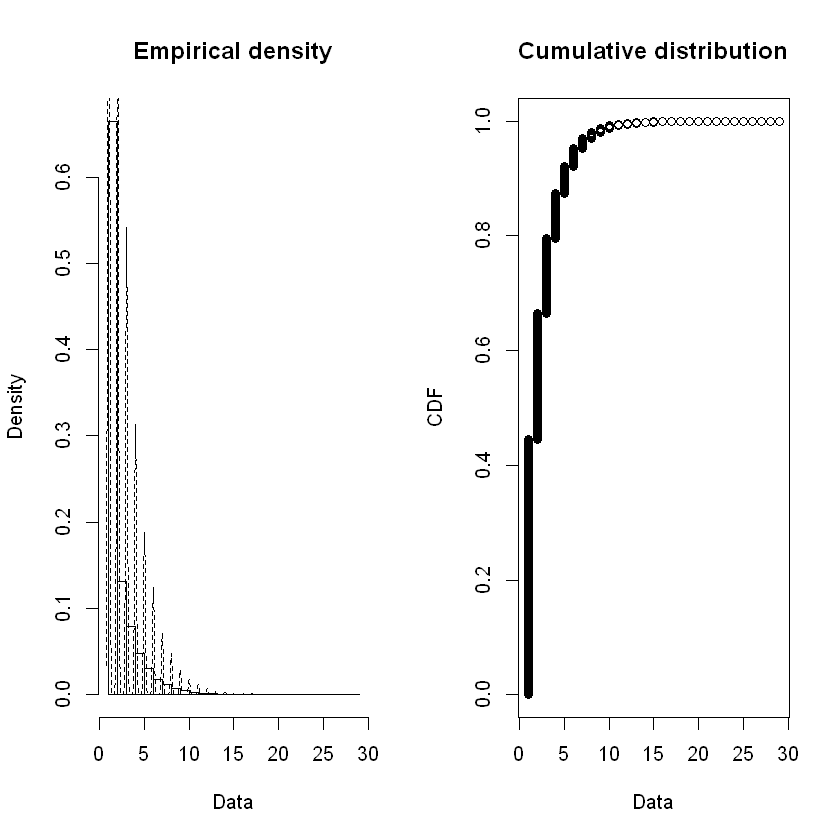

In [448]:
plotdist( dBCOct$Wet_Count, histo=TRUE, demp=TRUE )

In [449]:
BCfd_NB_dOct <- fitdist( dBCOct$Wet_Count, "nbinom" )
BCfd_GE_dOct <- fitdist( dBCOct$Wet_Count, "geom" )

In [450]:
summary( BCfd_NB_dOct )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate Std. Error
size 5.929697 0.03034562
mu   2.430454 0.00219903
Loglikelihood:  -1336752   AIC:  2673508   BIC:  2673531 
Correlation matrix:
              size            mu
size  1.0000000000 -0.0001512682
mu   -0.0001512682  1.0000000000


In [451]:
BCfdNB_dOct_size <- BCfd_NB_dOct$estimate[["size"]]
BCfdNB_dOct_mu <- BCfd_NB_dOct$estimate[["mu"]]
cat("BCCA Oct size: ", BCfdNB_dOct_size, "\n", "BCCA Oct mu: ", BCfdNB_dOct_mu, "\n")

BCCA Oct size:  5.929697 
 BCCA Oct mu:  2.430454 


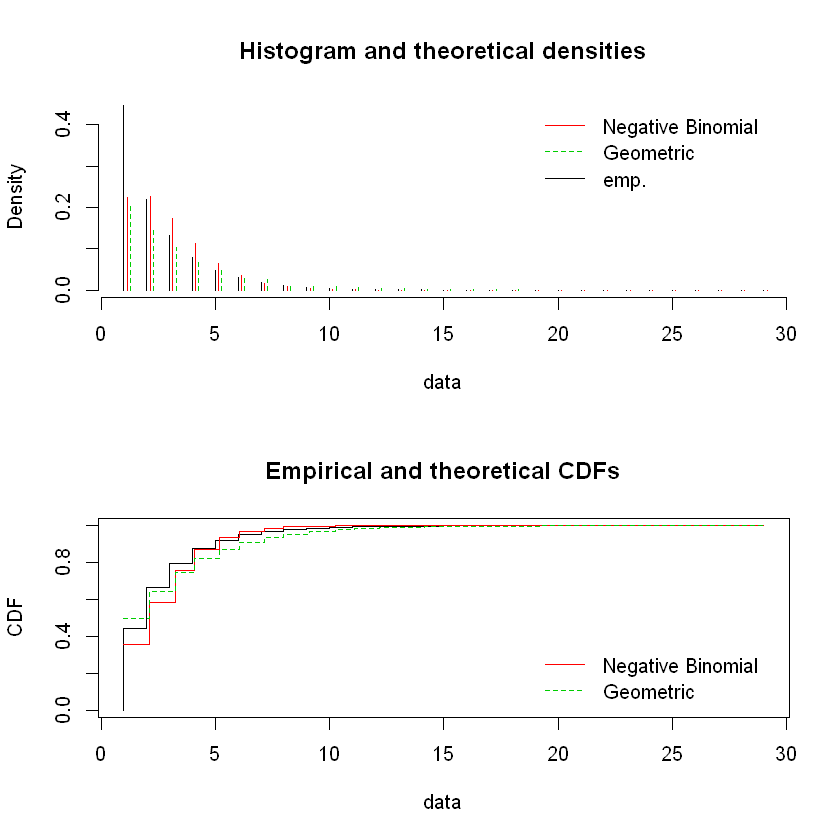

In [452]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dOct, BCfd_GE_dOct), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dOct, BCfd_GE_dOct), legendtext=plot.legend )

In [453]:
BCstatRes <- gofstat( list(BCfd_NB_dOct, BCfd_GE_dOct), fitnames=c("Negative Binomial", "Geometric") )

In [454]:
print(BCstatRes)

Chi-squared statistic:  101425.8 50716.76 
Degree of freedom of the Chi-squared distribution:  10 11 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     315856           251792.97158     352974.534
<= 2     155092           160516.50113     103701.056
<= 3      92871           123346.90638      73469.538
<= 4      55852            80053.11382      52051.284
<= 5      33474            46218.67124      36877.000
<= 6      21458            24476.40103      26126.408
<= 7      12558            12126.96613      18509.890
<= 8       8127             5698.01719      13113.783
<= 9       4841             2563.87085       9290.779
<= 10      3107             1112.80833       6582.278
<= 11      2054              468.49874       4663.375
<= 13      1874              269.20048       5644.597
> 13       1529               49.07311       5688.477

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's In

In [455]:
BCfdNB_dOct_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [456]:
BCfdNB_dOct_p = BCfdNB_dOct_size / (BCfdNB_dOct_size + BCfdNB_dOct_mu)
cat("BCCA prob: ", BCfdNB_dOct_p)

BCCA prob:  0.7092811

In [457]:
# add to our tracking dataframe
BCMonDistDF[10, ] <- list( 10, dBCOctMean, dBCOctBNr, BCfdNB_dOct_p, BCfdNB_dOct_mu, BCfdNB_dOct_size,
                          BCfdNB_dOct_pvalue )

In [458]:
BCgf_dOct <- goodfit( dBCOct$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dOct_size, prob=BCfdNB_dOct_p) )

In [459]:
summary( BCgf_dOct )


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          8673484.1 29        0
Likelihood Ratio  346661.3 28        0


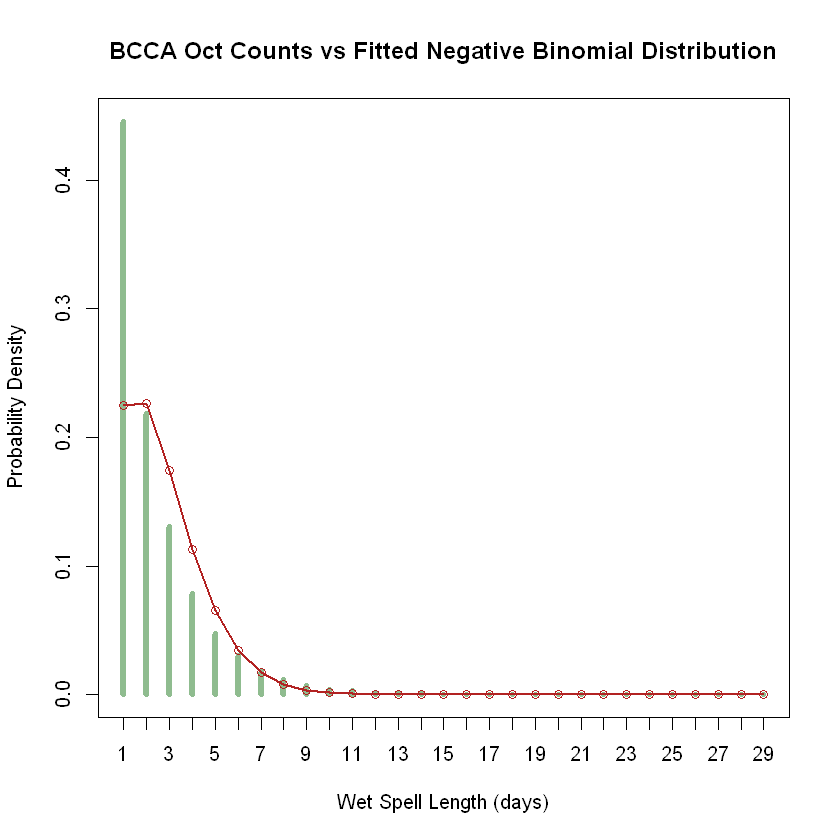

In [460]:
maxP <- max(dBCOct$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dOct_size, mu=BCfdNB_dOct_mu )
ttab <- table( dBCOct$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Oct Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

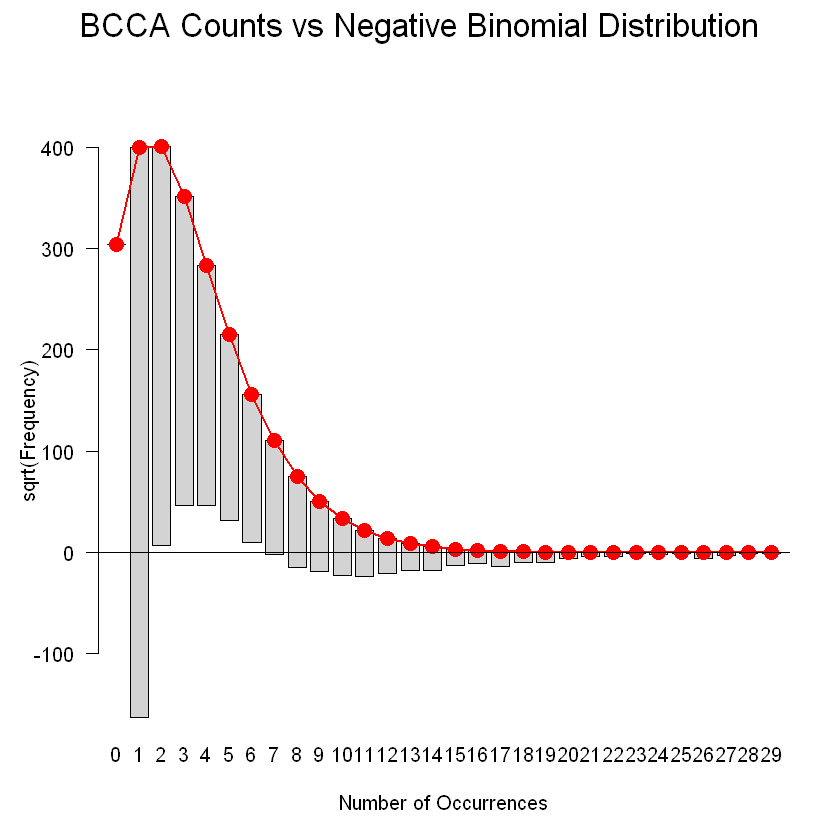

In [461]:
plot( BCgf_dOct, main="BCCA Counts vs Negative Binomial Distribution" )

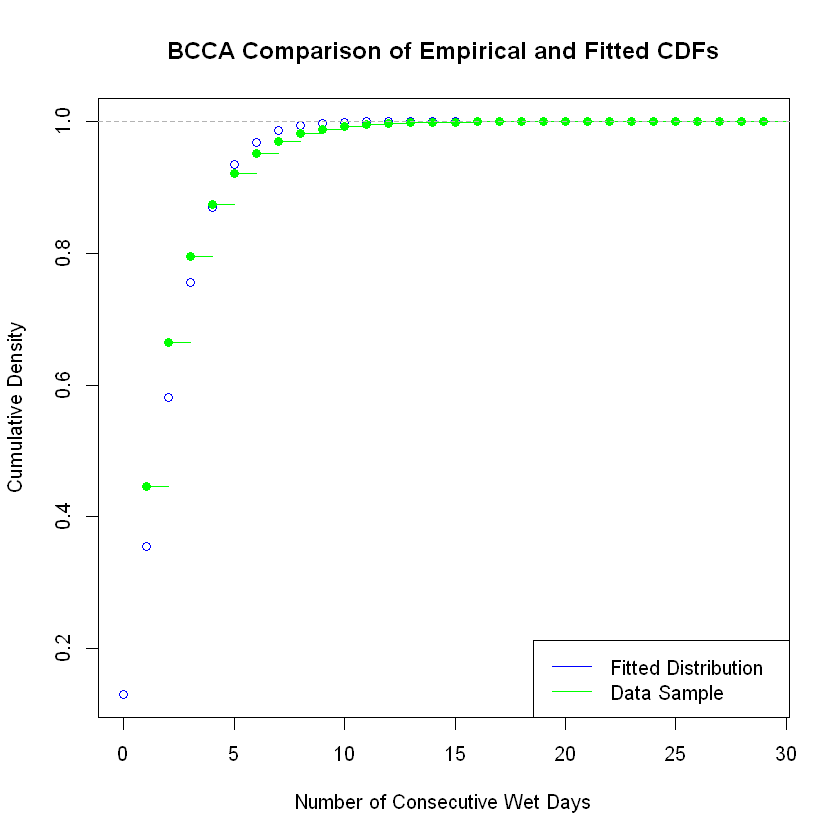

In [462]:
x <- seq(0,dBCOctMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dOct_mu, size=BCfdNB_dOct_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCOct$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

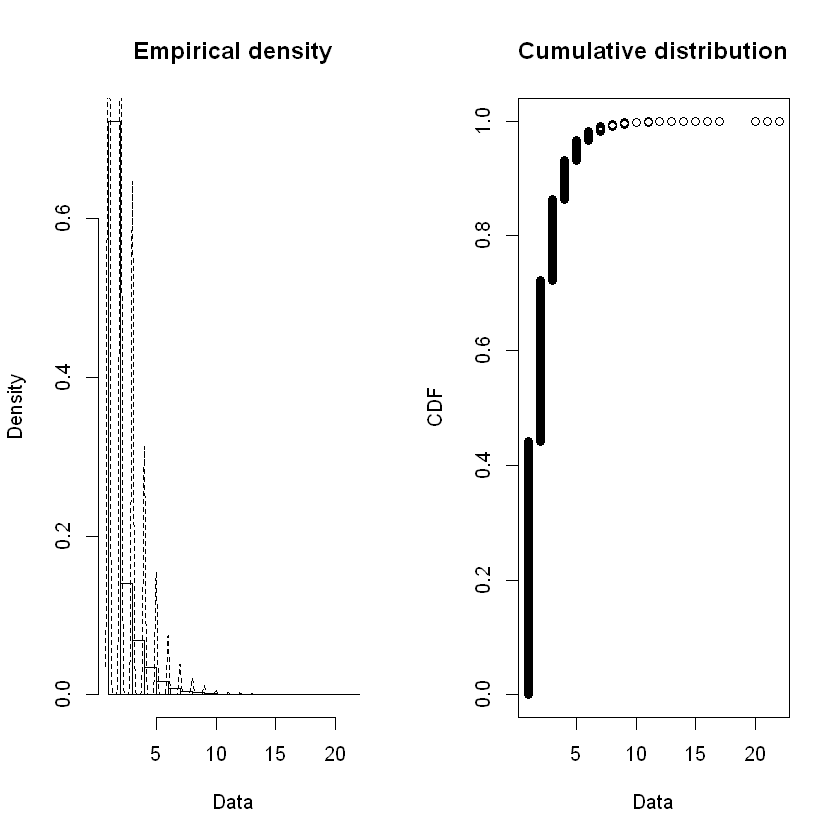

In [463]:
plotdist( dLONov$Wet_Count, histo=TRUE, demp=TRUE )

In [464]:
LOfd_NB_dNov <- fitdist( dLONov$Wet_Count, "nbinom" )
LOfd_GE_dNov <- fitdist( dLONov$Wet_Count, "geom" )

In [465]:
LOfdNB_dNov_size <- LOfd_NB_dNov$estimate[["size"]]
LOfdNB_dNov_mu <- LOfd_NB_dNov$estimate[["mu"]]
cat("LOCA Nov size: ", LOfdNB_dNov_size, "\n", "LOCA Nov mu: ", LOfdNB_dNov_mu, "\n")

LOCA Nov size:  247.6635 
 LOCA Nov mu:  2.113948 


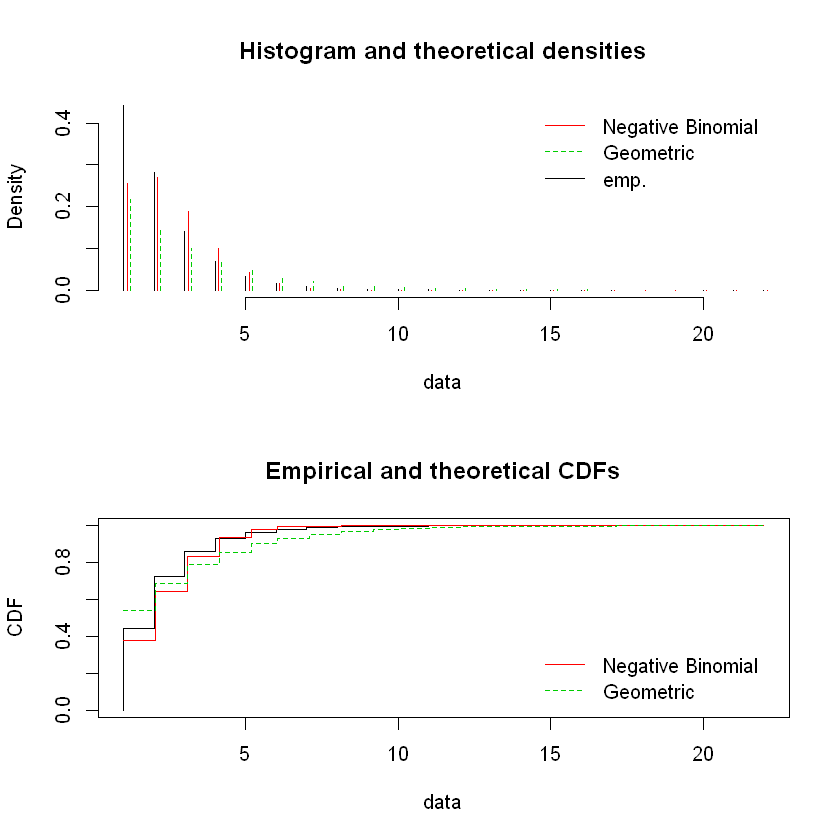

In [466]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dNov, LOfd_GE_dNov), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dNov, LOfd_GE_dNov), legendtext=plot.legend )

In [467]:
LOstatRes <- gofstat( list(LOfd_NB_dNov, LOfd_GE_dNov), fitnames=c("Negative Binomial", "Geometric") )

In [468]:
print( LOstatRes )

Chi-squared statistic:  163212 216453.5 
Degree of freedom of the Chi-squared distribution:  7 8 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    474111            405371.9456      579358.17
<= 2    302959            288782.4943      159030.48
<= 3    150481            203397.5291      107957.45
<= 4     73866            107874.2503       73286.64
<= 5     36502             45952.4878       49750.46
<= 6     17321             16377.2619       33772.98
<= 7      8986              5022.7579       22926.70
<= 8      4761              1353.1937       15563.73
<= 9      2545               325.3323       10565.40
> 9       3013                87.7470       22333.00

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           3578921   4200684
Bayesian Information Criterion           3578944   4200695


In [469]:
LOfdNB_dNov_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [470]:
LOfdNB_dNov_p = LOfdNB_dNov_size / (LOfdNB_dNov_size + LOfdNB_dNov_mu)
cat("LOCA prob: ", LOfdNB_dNov_p)

LOCA prob:  0.9915367

In [471]:
# add to our tracking dataframe
LOMonDistDF[11, ] <- list( 11, dLONovMean, dLONovBNr, LOfdNB_dNov_p, LOfdNB_dNov_mu, LOfdNB_dNov_size,
                          LOfdNB_dNov_pvalue )

In [472]:
LOgf_dNov <- goodfit( dLONov$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dNov_size, prob=LOfdNB_dNov_p) )

In [473]:
summary( LOgf_dNov )


	 Goodness-of-fit test for nbinomial distribution

                          X^2 df P(> X^2)
Pearson          5.012092e+10 22        0
Likelihood Ratio 4.459078e+05 19        0


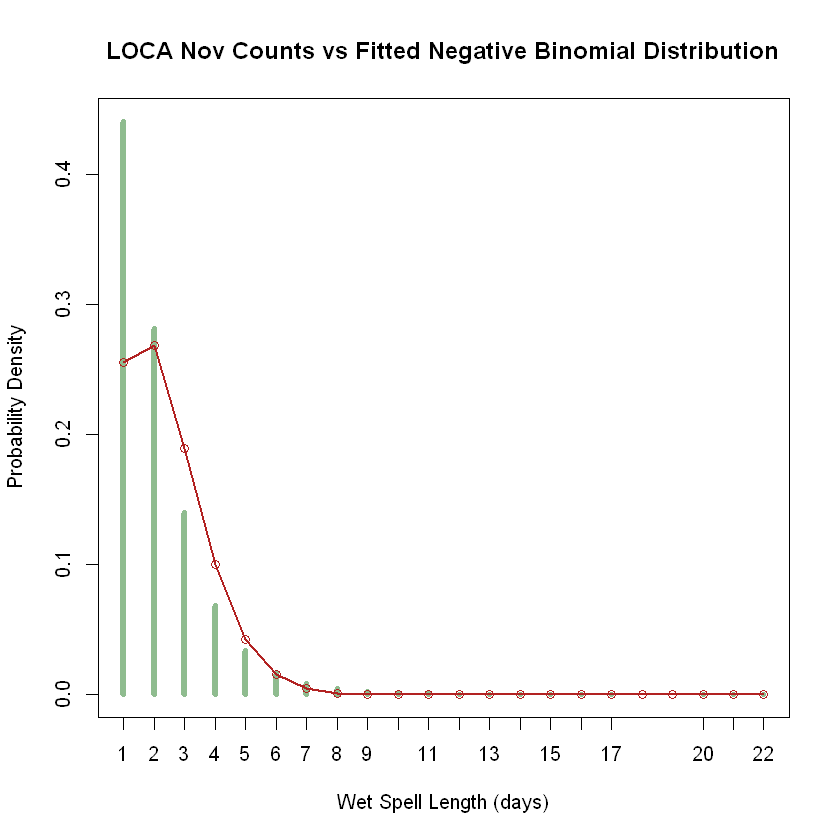

In [474]:
maxP <- max(dLONov$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dNov_size, mu=LOfdNB_dNov_mu )
ttab <- table( dLONov$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Nov Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

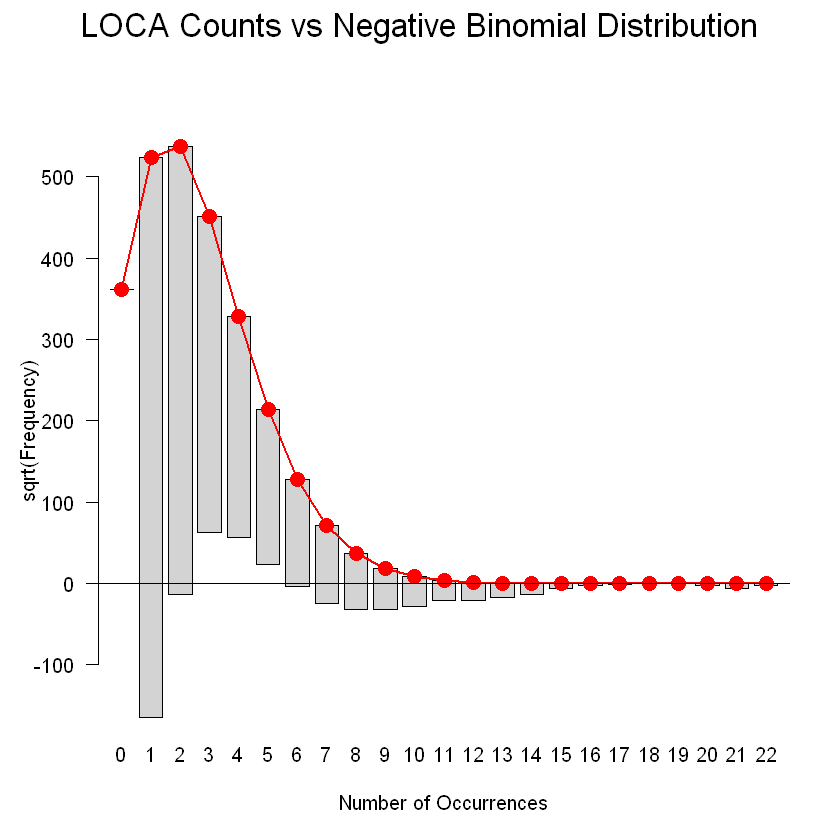

In [475]:
plot( LOgf_dNov, main="LOCA Counts vs Negative Binomial Distribution" )

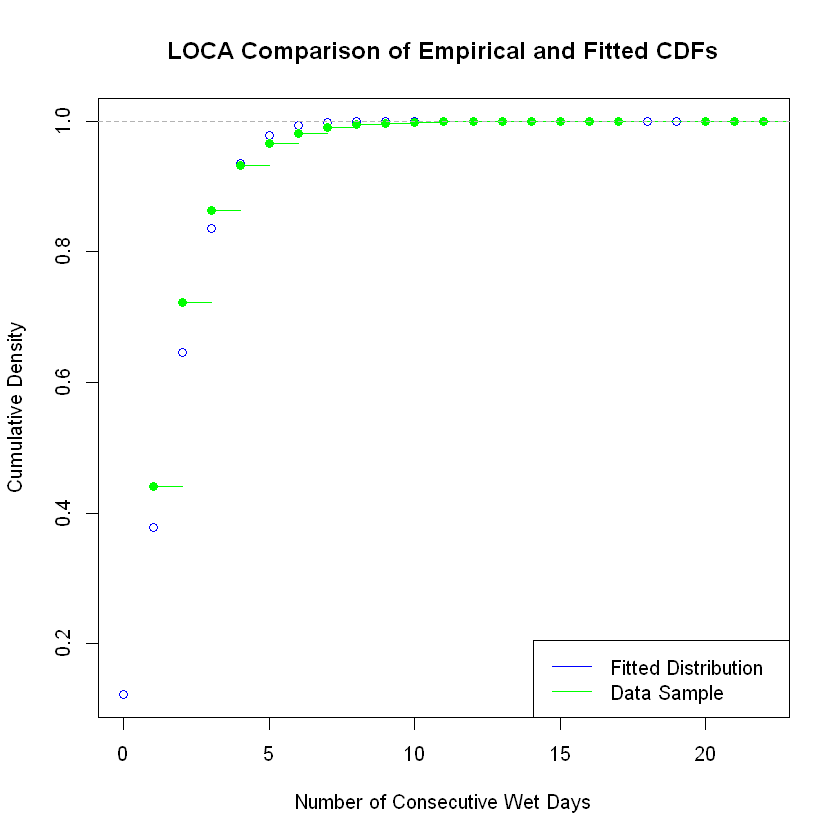

In [476]:
x <- seq(0,dLONovMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dNov_mu, size=LOfdNB_dNov_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLONov$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

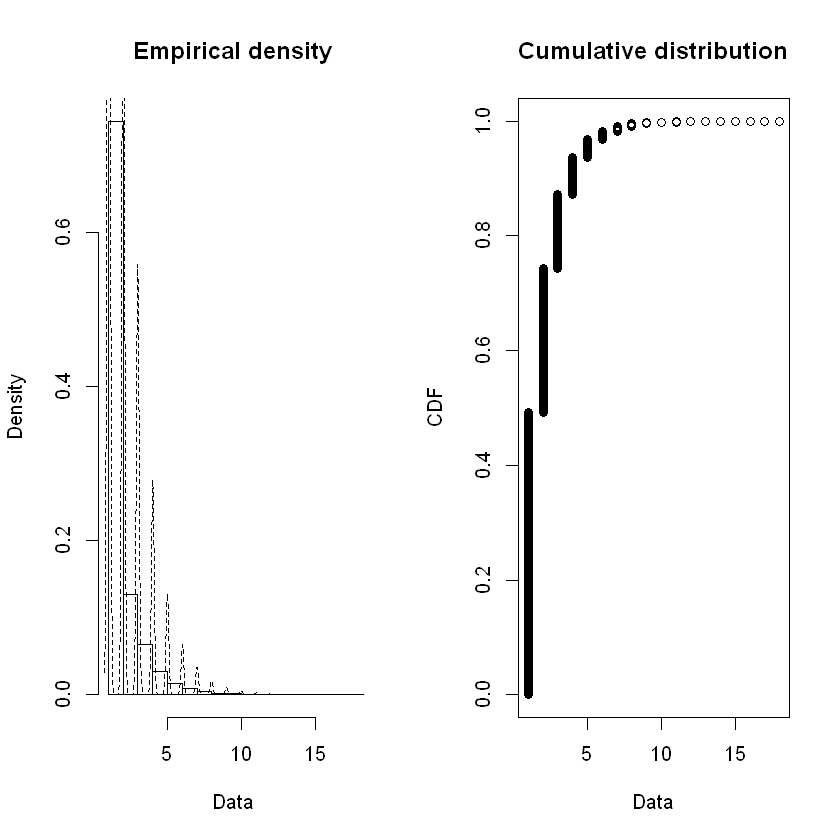

In [477]:
plotdist( dBCNov$Wet_Count, histo=TRUE, demp=TRUE )

In [478]:
BCfd_NB_dNov <- fitdist( dBCNov$Wet_Count, "nbinom" )
BCfd_GE_dNov <- fitdist( dBCNov$Wet_Count, "geom" )

In [479]:
summary( BCfd_NB_dNov )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
       estimate   Std. Error
size 161.964351 14.387021089
mu     2.021118  0.001783083
Loglikelihood:  -1055688   AIC:  2111381   BIC:  2111404 
Correlation matrix:
              size            mu
size  1.000000e+00 -2.389145e-05
mu   -2.389145e-05  1.000000e+00


In [480]:
BCfdNB_dNov_size <- BCfd_NB_dNov$estimate[["size"]]
BCfdNB_dNov_mu <- BCfd_NB_dNov$estimate[["mu"]]
cat("BCCA Nov size: ", BCfdNB_dNov_size, "\n", "BCCA Nov mu: ", BCfdNB_dNov_mu, "\n")

BCCA Nov size:  161.9644 
 BCCA Nov mu:  2.021118 


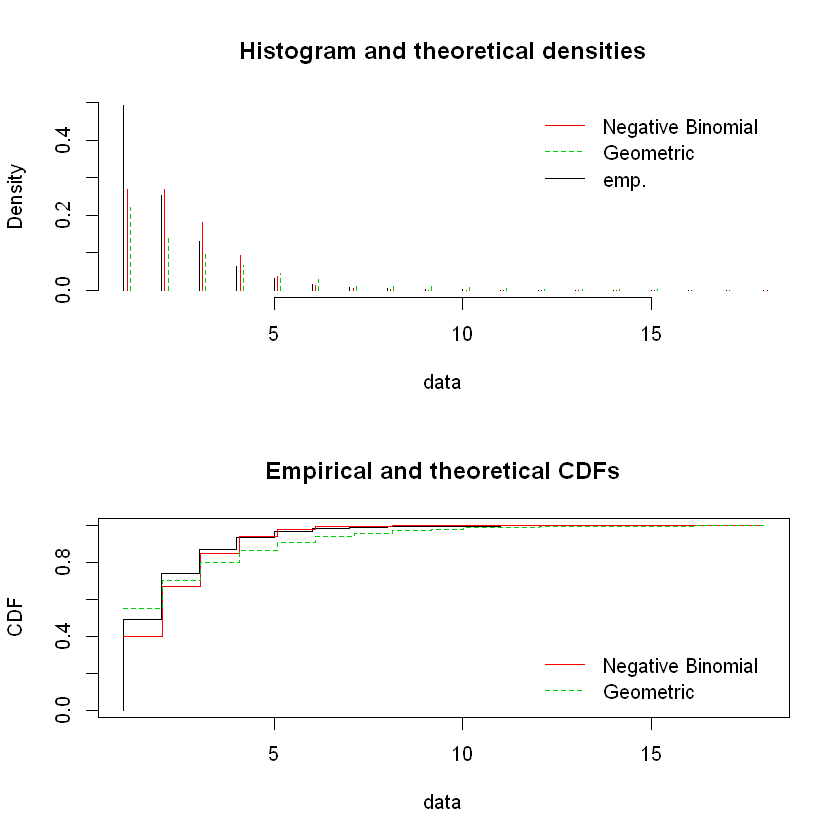

In [481]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dNov, BCfd_GE_dNov), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dNov, BCfd_GE_dNov), legendtext=plot.legend )

In [482]:
BCstatRes <- gofstat( list(BCfd_NB_dNov, BCfd_GE_dNov), fitnames=c("Negative Binomial", "Geometric") )

In [483]:
print(BCstatRes)

Chi-squared statistic:  155222.4 84674.71 
Degree of freedom of the Chi-squared distribution:  7 8 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     316730           2.587687e+05     355610.500
<= 2     161990           1.731388e+05      95356.253
<= 3      83330           1.166296e+05      63791.377
<= 4      41498           5.928235e+04      42675.122
<= 5      19525           2.425250e+04      28548.781
<= 6       9687           8.317931e+03      19098.549
<= 7       5299           2.459918e+03      12776.537
<= 8       2693           6.403421e+02       8547.241
<= 10      2081           1.804492e+02       9543.106
> 10        845           7.335296e+00       7730.533

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2111381   2469157
Bayesian Information Criterion           2111404   2469169


In [484]:
BCfdNB_dNov_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [485]:
BCfdNB_dNov_p = BCfdNB_dNov_size / (BCfdNB_dNov_size + BCfdNB_dNov_mu)
cat("BCCA prob: ", BCfdNB_dNov_p)

BCCA prob:  0.987675

In [486]:
# add to our tracking dataframe
BCMonDistDF[11, ] <- list( 11, dBCNovMean, dBCNovBNr, BCfdNB_dNov_p, BCfdNB_dNov_mu, BCfdNB_dNov_size,
                          BCfdNB_dNov_pvalue )

In [487]:
BCgf_dNov <- goodfit( dBCNov$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dNov_size, prob=BCfdNB_dNov_p) )

In [488]:
summary( BCgf_dNov )


	 Goodness-of-fit test for nbinomial distribution

                     X^2 df P(> X^2)
Pearson          5287729 18        0
Likelihood Ratio  308472 17        0


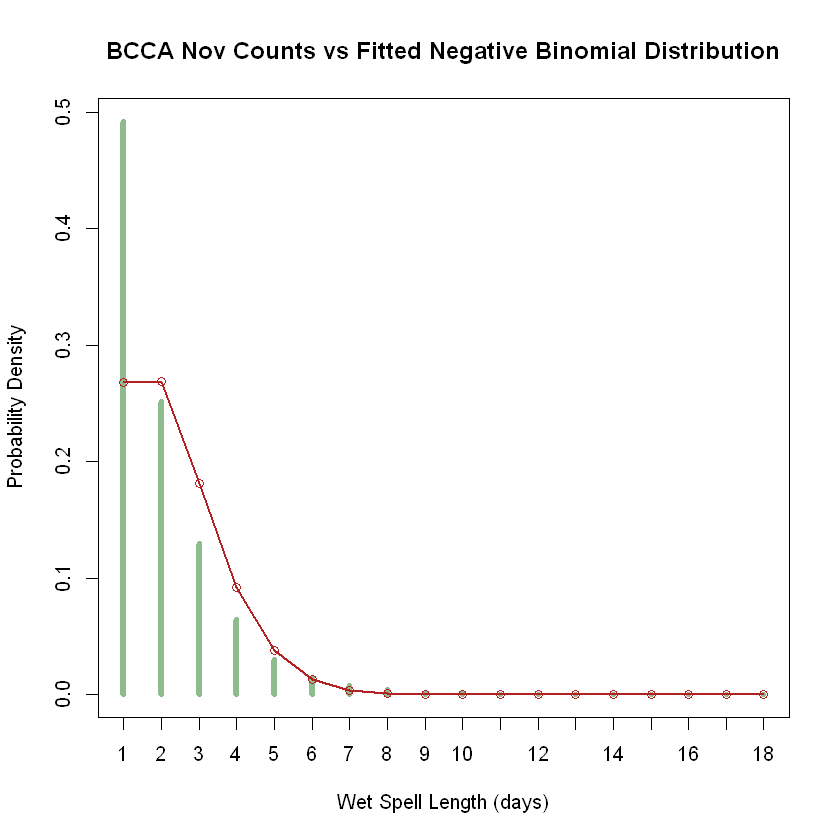

In [489]:
maxP <- max(dBCNov$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dNov_size, mu=BCfdNB_dNov_mu )
ttab <- table( dBCNov$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Nov Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

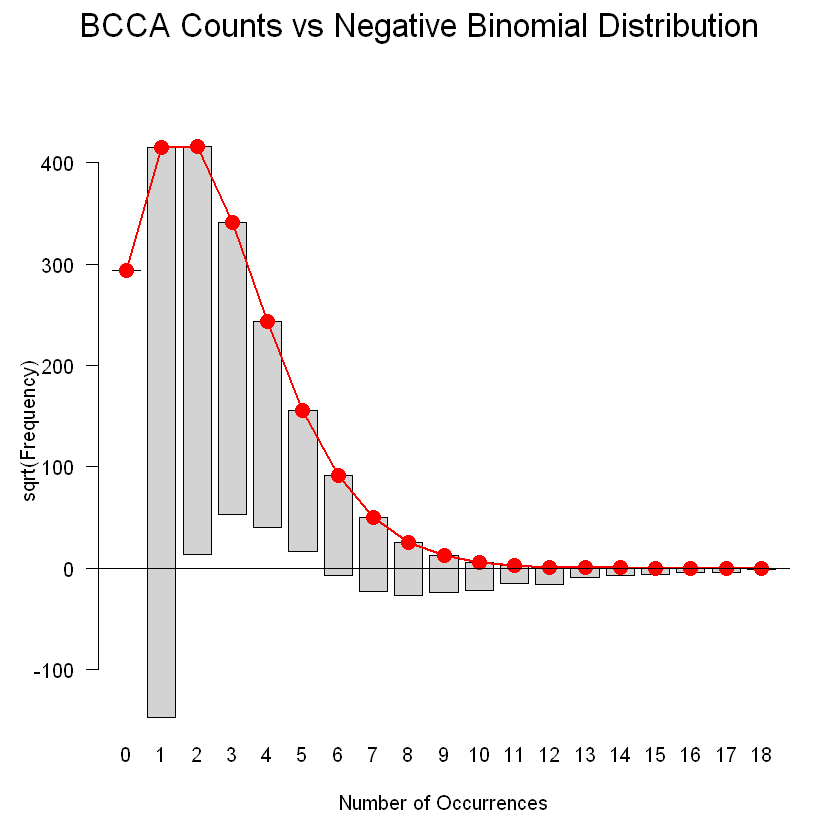

In [490]:
plot( BCgf_dNov, main="BCCA Counts vs Negative Binomial Distribution" )

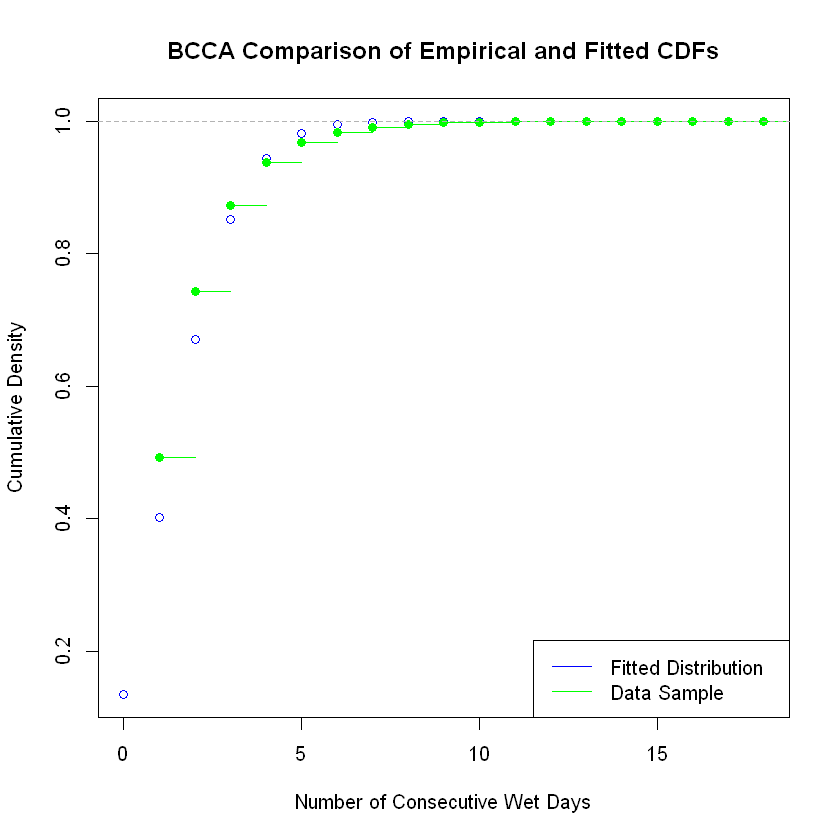

In [491]:
x <- seq(0,dBCNovMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dNov_mu, size=BCfdNB_dNov_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCNov$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

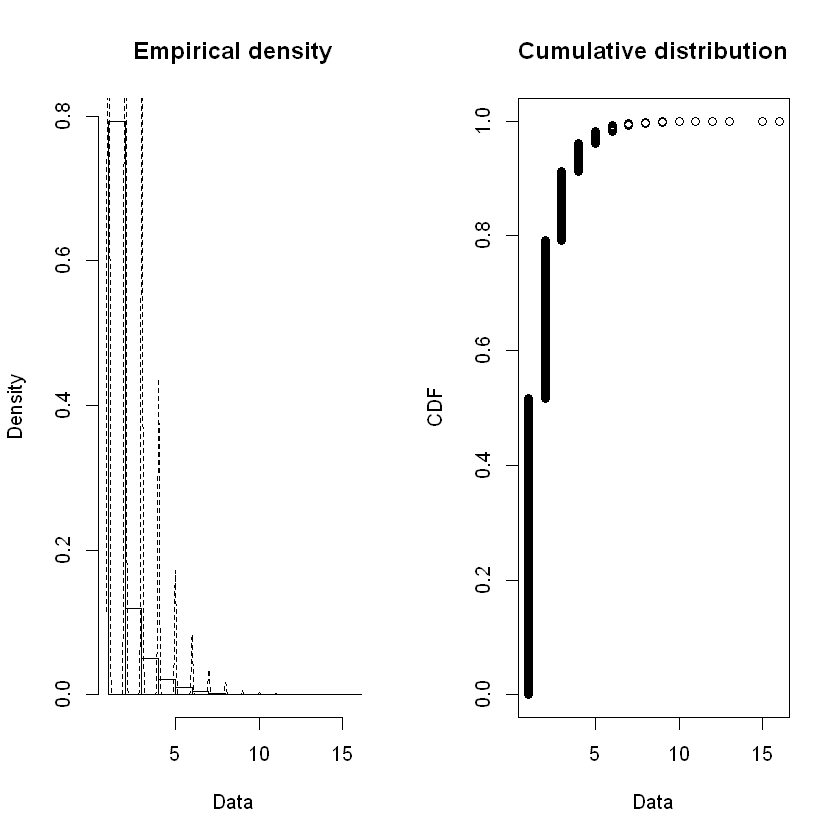

In [492]:
plotdist( dLODec$Wet_Count, histo=TRUE, demp=TRUE )

In [493]:
LOfd_NB_dDec <- fitdist( dLODec$Wet_Count, "nbinom" )
LOfd_GE_dDec <- fitdist( dLODec$Wet_Count, "geom" )

In [494]:
LOfdNB_dDec_size <- LOfd_NB_dDec$estimate[["size"]]
LOfdNB_dDec_mu <- LOfd_NB_dDec$estimate[["mu"]]
cat("LOCA Dec size: ", LOfdNB_dDec_size, "\n", "LOCA Dec mu: ", LOfdNB_dDec_mu, "\n")

LOCA Dec size:  4317364 
 LOCA Dec mu:  1.848601 


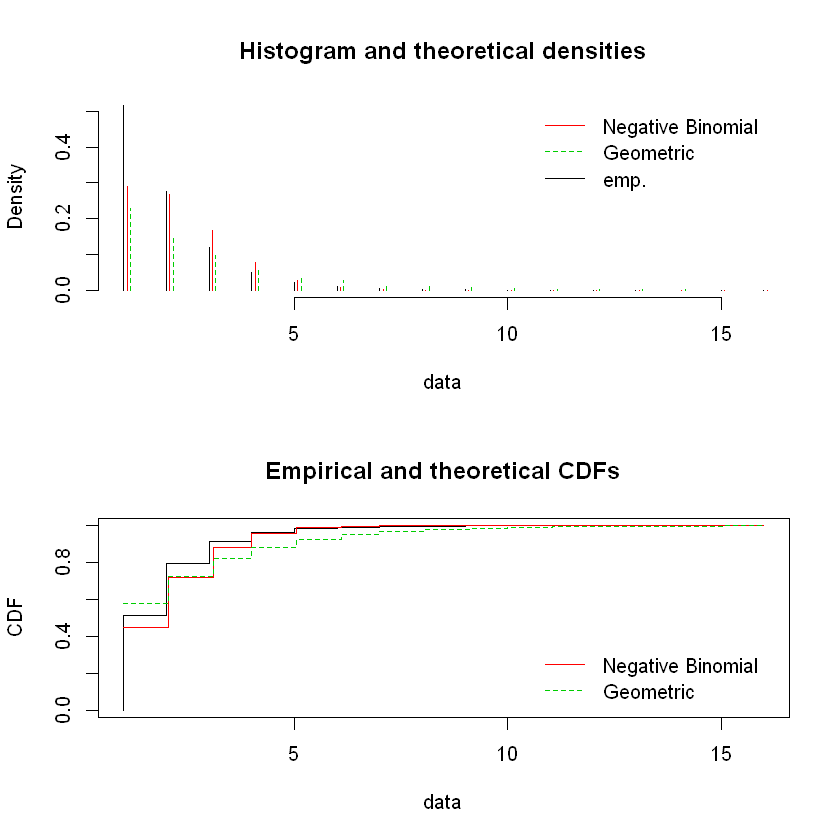

In [495]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dDec, LOfd_GE_dDec), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dDec, LOfd_GE_dDec), legendtext=plot.legend )

In [496]:
LOstatRes <- gofstat( list(LOfd_NB_dDec, LOfd_GE_dDec), fitnames=c("Negative Binomial", "Geometric") )

In [497]:
print( LOstatRes )

Chi-squared statistic:  68960.35 180809.9 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    511136           444372.81729      573518.53
<= 2    274396           266546.01442      146467.99
<= 3    118145           164245.77938       95047.71
<= 4     49510            75906.26243       61679.47
<= 5     20257            28064.09775       40025.76
<= 6      9762             8646.56112       25973.98
<= 7      4086             2283.43713       16855.34
<= 9      2608              636.02502       18035.95
> 9        825               24.00546       13120.27

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           3009500   3657947
Bayesian Information Criterion           3009523   3657959


In [498]:
LOfdNB_dDec_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [499]:
LOfdNB_dDec_p = LOfdNB_dDec_size / (LOfdNB_dDec_size + LOfdNB_dDec_mu)
cat("LOCA prob: ", LOfdNB_dDec_p)

LOCA prob:  0.9999996

In [500]:
# add to our tracking dataframe
LOMonDistDF[12, ] <- list( 12, dLODecMean, dLODecBNr, LOfdNB_dDec_p, LOfdNB_dDec_mu, LOfdNB_dDec_size,
                           LOfdNB_dDec_pvalue )

In [501]:
LOgf_dDec <- goodfit( dLODec$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dDec_size, prob=LOfdNB_dDec_p) )

In [502]:
summary( LOgf_dDec )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          13517311 16        0
Likelihood Ratio   489169 14        0


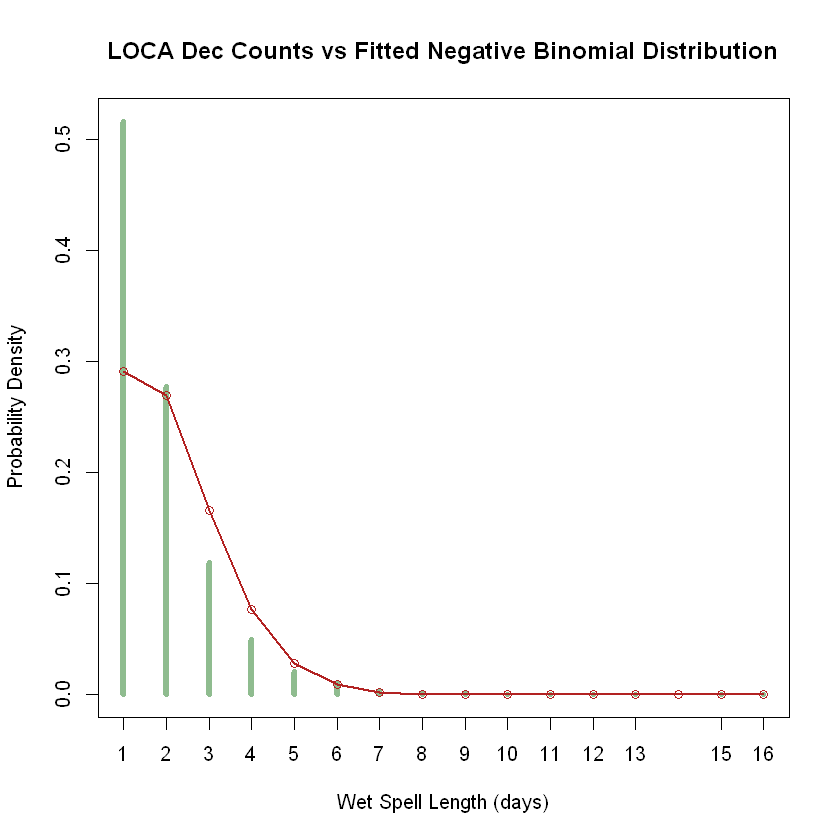

In [503]:
maxP <- max(dLODec$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dDec_size, mu=LOfdNB_dDec_mu )
ttab <- table( dLODec$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Dec Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

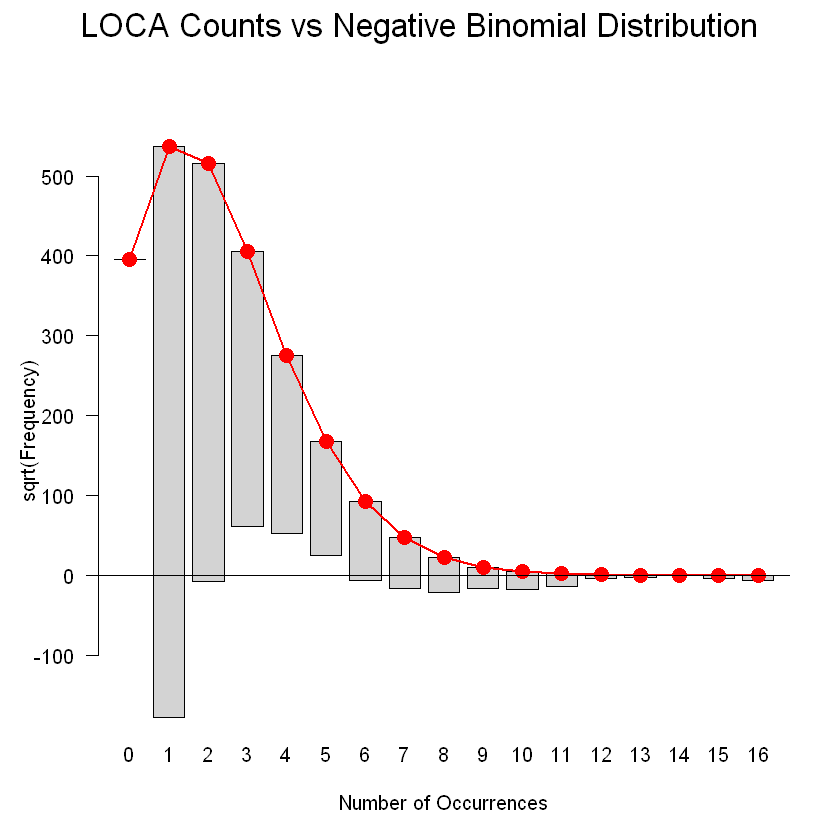

In [504]:
plot( LOgf_dDec, main="LOCA Counts vs Negative Binomial Distribution" )

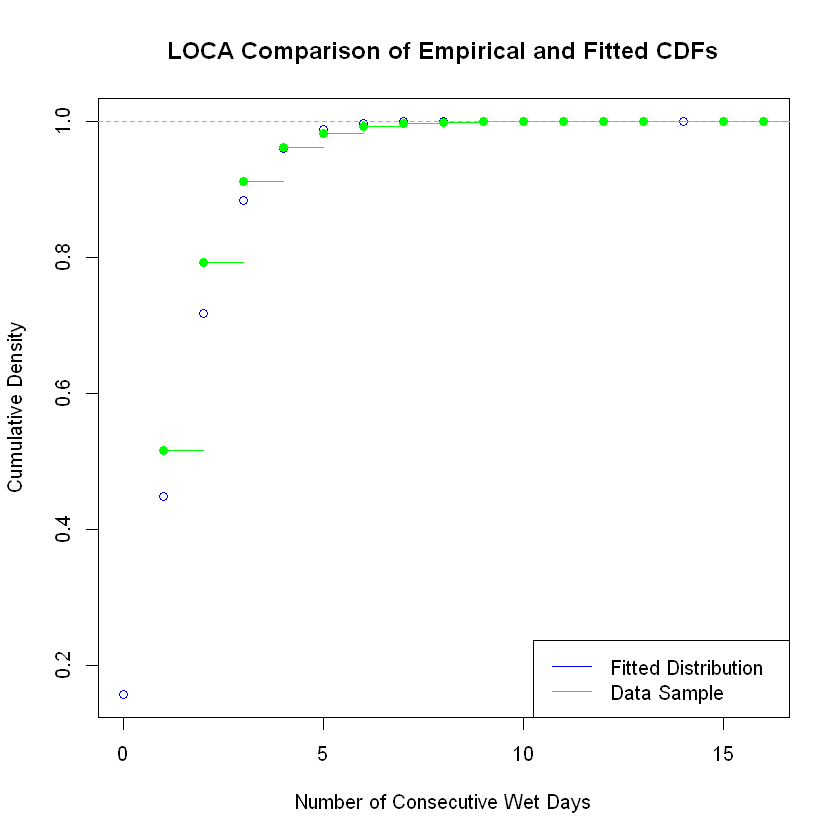

In [505]:
x <- seq(0,dLODecMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dDec_mu, size=LOfdNB_dDec_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLODec$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

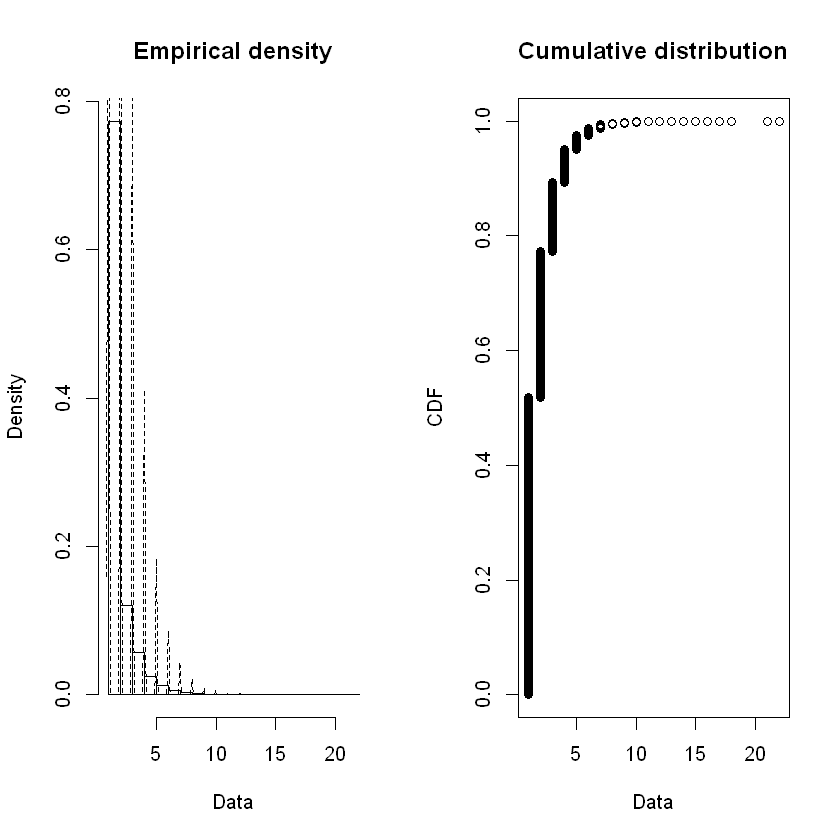

In [506]:
plotdist( dBCDec$Wet_Count, histo=TRUE, demp=TRUE )

In [507]:
BCfd_NB_dDec <- fitdist( dBCDec$Wet_Count, "nbinom" )
BCfd_GE_dDec <- fitdist( dBCDec$Wet_Count, "geom" )

In [508]:
summary( BCfd_NB_dDec )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
         estimate  Std. Error
size 2.810599e+05         NaN
mu   1.912703e+00 0.001725404
Loglikelihood:  -1012907   AIC:  2025817   BIC:  2025840 
Correlation matrix:
     size  mu
size    1 NaN
mu    NaN   1


In [509]:
BCfdNB_dDec_size <- BCfd_NB_dDec$estimate[["size"]]
BCfdNB_dDec_mu <- BCfd_NB_dDec$estimate[["mu"]]
cat("BCCA Dec size: ", BCfdNB_dDec_size, "\n", "BCCA Dec mu: ", BCfdNB_dDec_mu, "\n")

BCCA Dec size:  281059.9 
 BCCA Dec mu:  1.912703 


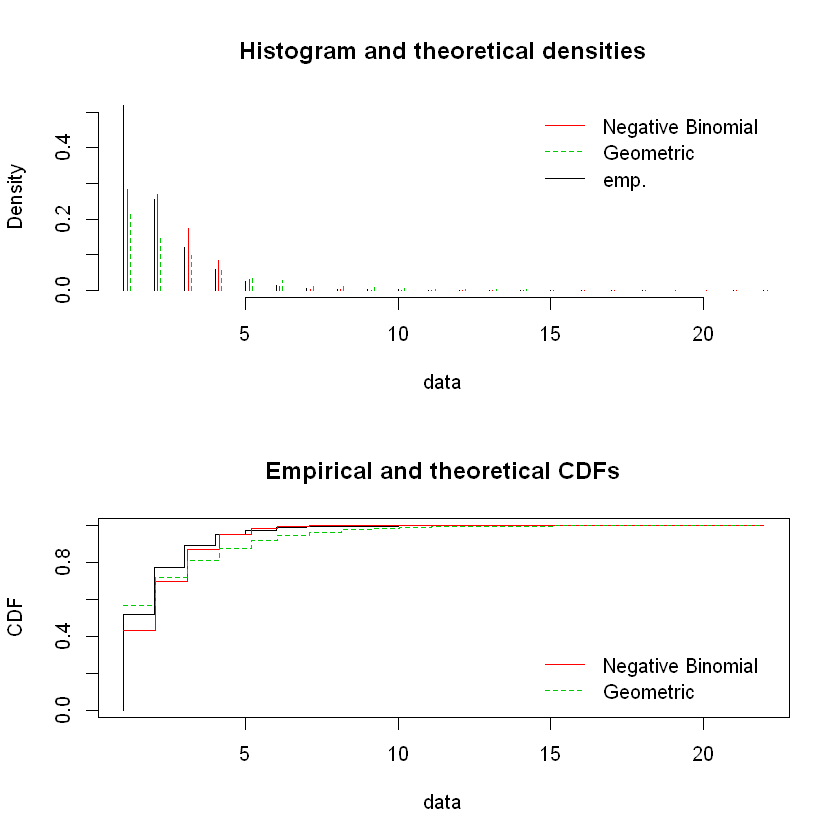

In [510]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dDec, BCfd_GE_dDec), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dDec, BCfd_GE_dDec), legendtext=plot.legend )

In [511]:
BCstatRes <- gofstat( list(BCfd_NB_dDec, BCfd_GE_dDec), fitnames=c("Negative Binomial", "Geometric") )

In [512]:
print(BCstatRes)

Chi-squared statistic:  65362.48 86550.66 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    333331            276451.4327     365600.727
<= 2    163565            173614.2433      95148.235
<= 3     77656            110690.8724      62475.191
<= 4     36590             52929.9005      41021.775
<= 5     15846             20247.9881      26935.268
<= 6      8083              6454.8027      17685.941
<= 7      3798              1763.7573      11612.748
<= 8      1911               421.7007       7625.036
> 8       1905               110.3023      14580.079

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2025817   2407829
Bayesian Information Criterion           2025840   2407840


In [513]:
BCfdNB_dDec_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [514]:
BCfdNB_dDec_p = BCfdNB_dDec_size / (BCfdNB_dDec_size + BCfdNB_dDec_mu)
cat("BCCA prob: ", BCfdNB_dDec_p)

BCCA prob:  0.9999932

In [515]:
# add to our tracking dataframe
BCMonDistDF[12, ] <- list( 12, dBCDecMean, dBCDecBNr, BCfdNB_dDec_p, BCfdNB_dDec_mu, BCfdNB_dDec_size,
                           BCfdNB_dDec_pvalue )

In [516]:
BCgf_dDec <- goodfit( dBCDec$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dDec_size, prob=BCfdNB_dDec_p) )

In [517]:
summary( BCgf_dDec )


	 Goodness-of-fit test for nbinomial distribution

                          X^2 df P(> X^2)
Pearson          2.530352e+12 22        0
Likelihood Ratio 3.253966e+05 19        0


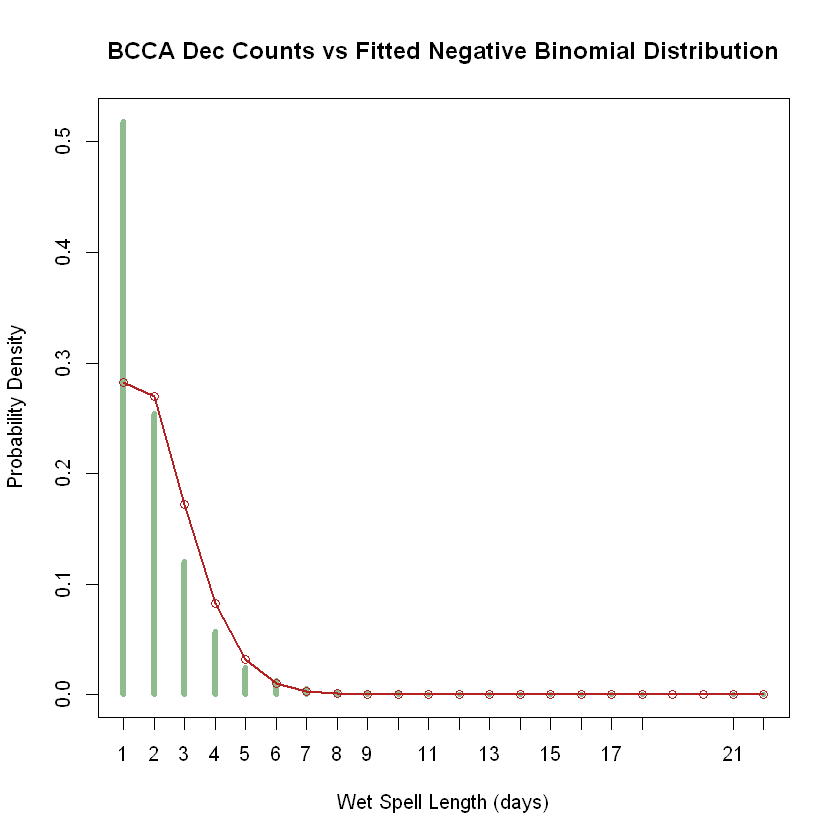

In [518]:
maxP <- max(dBCDec$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dDec_size, mu=BCfdNB_dDec_mu )
ttab <- table( dBCDec$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Dec Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

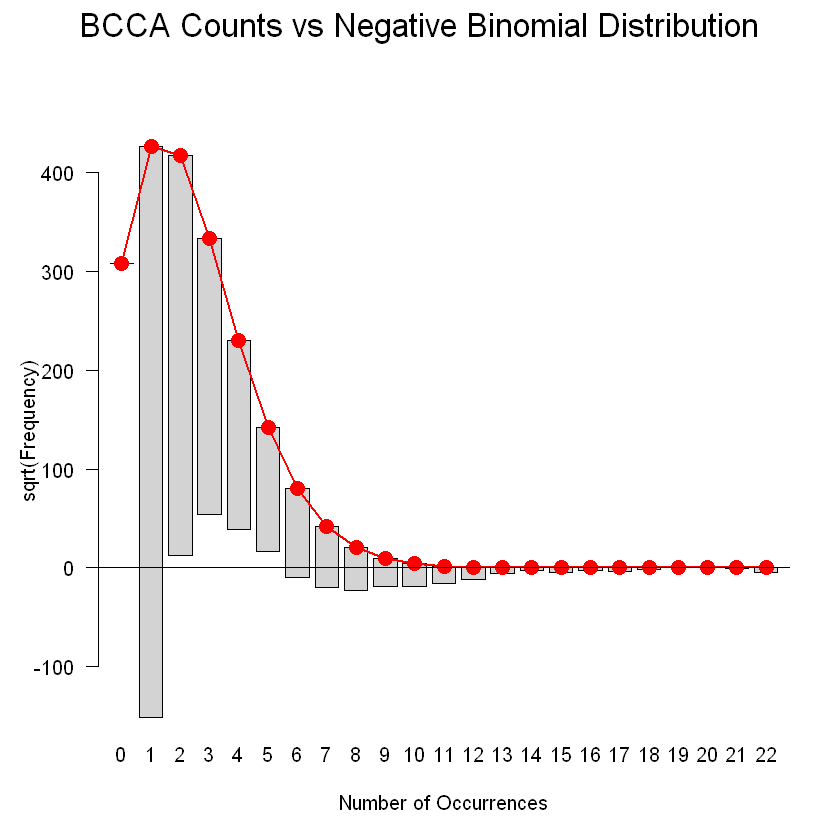

In [519]:
plot( BCgf_dDec, main="BCCA Counts vs Negative Binomial Distribution" )

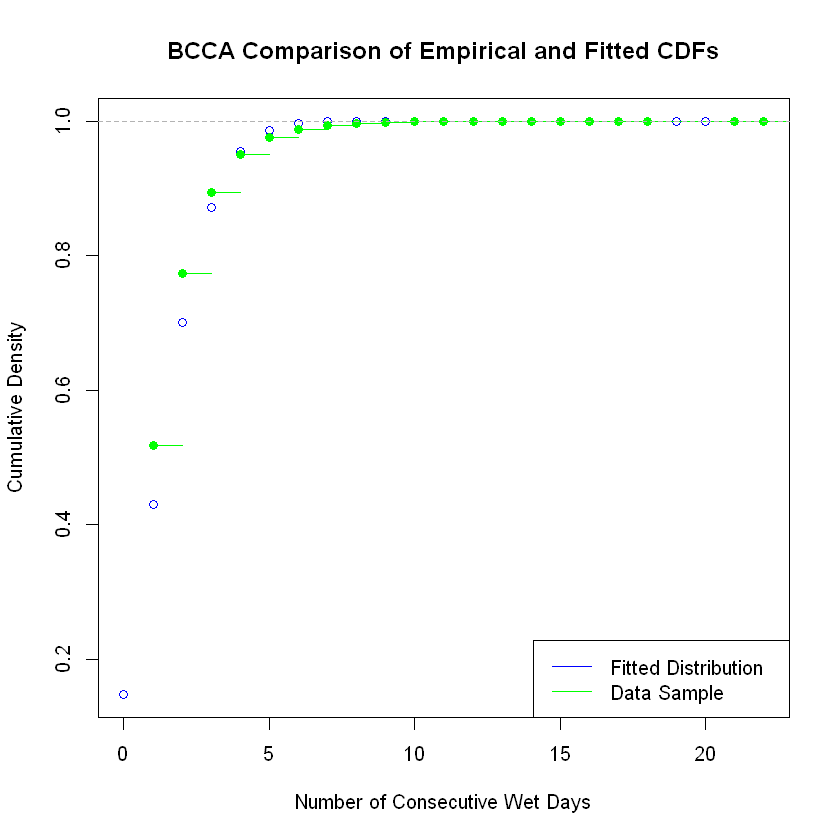

In [520]:
x <- seq(0,dBCDecMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dDec_mu, size=BCfdNB_dDec_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCDec$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Look at our summary DataFrame

In [521]:
print( LOMonDistDF, quote=FALSE, row.names=FALSE )

 month      smu      ssize     sprob      tmu        tsize pvalue
     1 1.784445   5.318792 0.9999998 1.784622 8.392017e+06      0
     2 1.935286   8.853641 0.9999996 1.935439 4.317364e+06      0
     3 1.885040  10.928531 0.9999993 1.885269 2.546743e+06      0
     4 2.277225   6.366151 0.8306775 2.277092 1.117116e+01      0
     5 2.662997   3.090073 0.6581614 2.663018 5.127262e+00      0
     6 2.956322   2.485403 0.5716712 2.956670 3.946134e+00      0
     7 2.625297   2.398276 0.6149561 2.624757 4.192017e+00      0
     8 2.590146   2.421449 0.6224558 2.590399 4.270781e+00      0
     9 2.917455   2.650261 0.5837756 2.917294 4.091652e+00      0
    10 2.467021   6.034884 0.7878118 2.466895 9.159081e+00      0
    11 2.113786 147.556616 0.9915367 2.113948 2.476635e+02      0
    12 1.848448   8.099468 0.9999996 1.848601 4.317364e+06      0


In [522]:
print( BCMonDistDF, quote=FALSE, row.names=FALSE )

 month      smu      ssize     sprob      tmu        tsize pvalue
     1 1.918293  19.205284 0.9999994 1.918418 3.062845e+06      0
     2 1.985640  48.329526 0.9999901 1.985985 1.999106e+05      0
     3 1.956357 142.094077 0.9999526 1.956569 4.128474e+04      0
     4 2.378602   2.529587 0.6734470 2.378531 4.905220e+00      0
     5 3.031576   1.644645 0.4744654 3.031764 2.737151e+00      0
     6 2.841019   1.623240 0.4951675 2.840649 2.786265e+00      0
     7 2.684914   1.500161 0.5123514 2.684850 2.820856e+00      0
     8 2.895663   1.343629 0.4656422 2.895815 2.523428e+00      0
     9 3.088916   1.865862 0.4829404 3.089337 2.885480e+00      0
    10 2.430230   3.629423 0.7092811 2.430454 5.929697e+00      0
    11 2.020961  95.275539 0.9876750 2.021118 1.619644e+02      0
    12 1.912133  22.379175 0.9999932 1.912703 2.810599e+05      0


### Output to a Spreadsheet

Output the stats and distribution fits to a spreadsheet

In [523]:
outputDF_xlsx <- createWorkbook()

In [524]:
LOsumstat_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="LOCA_Summary_Stats")
BCsumstat_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="BCCA_Summary_Stats")
LOmondist_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="LOCA_Dist_Properties")
BCmondist_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="BCCA_Dist_Properties")

In [525]:
addDataFrame( x=MonLOSumStatDF, sheet=LOsumstat_xlsx )
addDataFrame( x=MonBCSumStatDF, sheet=BCsumstat_xlsx )
addDataFrame( x=LOMonDistDF, sheet=LOmondist_xlsx )
addDataFrame( x=BCMonDistDF, sheet=BCmondist_xlsx )

In [526]:
saveWorkbook( outputDF_xlsx, file="CMIP5_Wet_RSummary_2041-2070.xlsx" )

## Check that No Grid Cell Outliers

Check that there are not any grid cell outliers. This part will take a long time so may need to split it out to a standalone R script. This also does not make sense so removed.

In [527]:
options(warn = oldw)